In [2]:
import os
import timm
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as nnf
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score
from torchvision import models

In [27]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 2
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = "fp16"
NUM_CLASSES=3
GRADIENT_ACCUMULATION_STEPS = 1

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"]=""

In [5]:
train_dir='common/dataset/train'
val_dir='common/dataset/val'

In [6]:
device=('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
train_imgs=os.listdir(train_dir)
val_imgs=os.listdir(val_dir)

In [8]:
train_temp=[]
val_temp=[]

In [9]:
for pth in train_imgs:
    path=os.path.join(train_dir, pth)
    train_temp.append(path)

In [10]:
for pth in val_imgs:
    path=os.path.join(val_dir, pth)
    val_temp.append(path)

In [11]:
train_temp=train_temp[1:]
val_temp=val_temp[1:]

In [12]:
train_temp

['common/dataset/train/no',
 'common/dataset/train/sphere',
 'common/dataset/train/vort']

In [13]:
train_img_path=[]
train_class=[]
val_img_path=[]
val_class=[]

In [14]:
def class_def(label):
    if label=='no':
        return 0
    elif label=='sphere':
        return 1
    else:
        return 2

In [15]:
for el in train_temp:
    lst=el.split('/')
    type=lst[-1]
    for it in os.listdir(el):
        p=os.path.join(el,it)
        train_img_path.append(p)
        if type=='no':
            train_class.append(0)
        elif type=='sphere':
            train_class.append(1)
        else:
            train_class.append(2)

In [16]:
for el in val_temp:
    lst=el.split('/')
    type=lst[-1]
    for it in os.listdir(el):
        p=os.path.join(el,it)
        val_img_path.append(p)
        if type=='no':
            val_class.append(0)
        elif type=='sphere':
            val_class.append(1)
        else:
            val_class.append(2)

In [17]:
train_img_path, test_img_path, train_class, test_class=train_test_split(train_img_path, train_class, test_size=0.1, shuffle=True)

In [18]:
class MyDataset(Dataset):
    def __init__(self, img_path, transform):
        self.img_path=img_path
        self.transform=transform
    def __len__(self):
        return len(self.img_path)
    def __getitem__(self, idx):
        image_path=self.img_path[idx]
        img=np.load(image_path)
        if (self.transform):
            img=self.transform(image=image)['image']
        label=image_path.split('/')[-2]
        label=class_def(label)

        return img, label

In [19]:
train_dataset=MyDataset(train_img_path, transform=False)
test_dataset=MyDataset(test_img_path, transform=False)
val_dataset=MyDataset(val_img_path, transform=False)

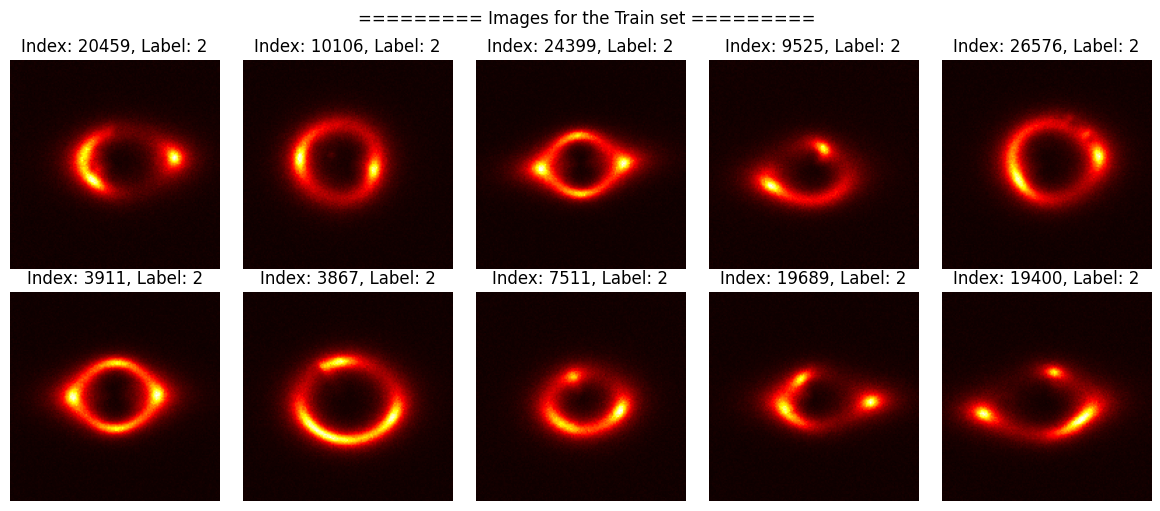

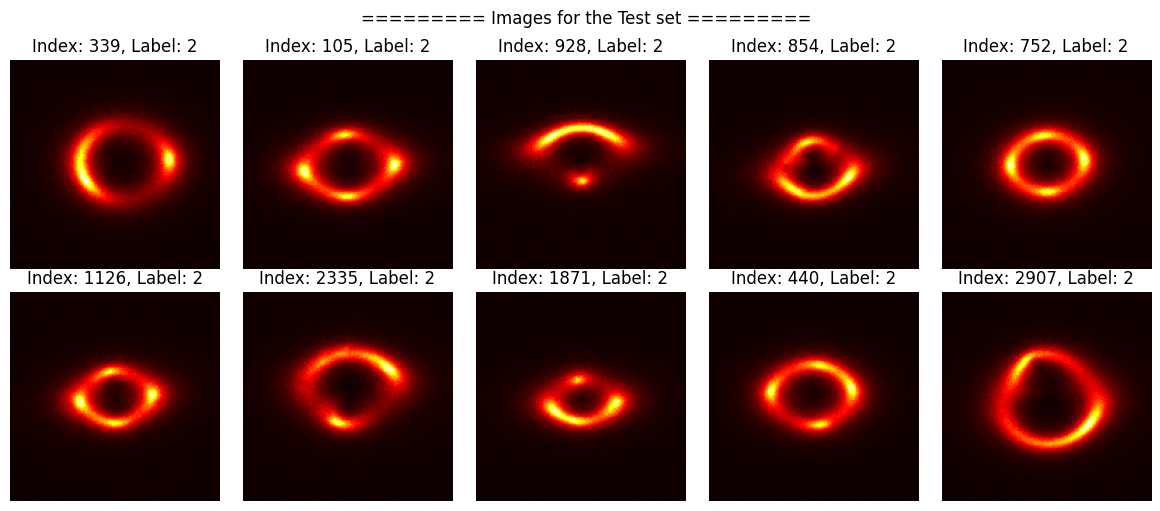

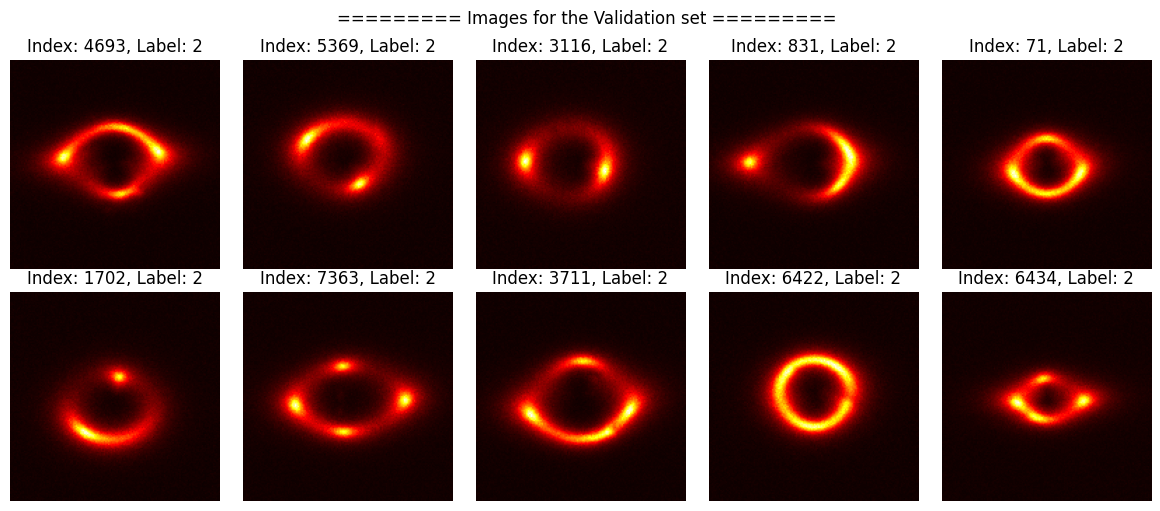

In [20]:
def visualize_images(dataset_input, dataset_type, samples, cols):
    
    dataset_len = len(dataset_input)
    dataset = dataset_input
    
    rows = samples // cols
    
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12, 8))
    fig.suptitle(f"========= Images for the {dataset_type.title()} set =========", y=0.9)
    
    for i in range(samples):
        idx = np.random.randint(0, dataset_len)
        image, label = dataset[idx]
        image = image.swapaxes(0, 1)
        image = image.swapaxes(1, 2)
        ax.ravel()[i].imshow(image, cmap='hot')
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Index: {idx}, Label: {class_def(label)}")
        
    plt.tight_layout(rect=[0, 0.2, 0.99, 0.975], h_pad=2.1, pad=1.7)
    plt.show()
    
visualize_images(dataset_input=train_dataset, dataset_type="train", samples=10, cols=5)
visualize_images(dataset_input=test_dataset, dataset_type="test", samples=10, cols=5)
visualize_images(dataset_input=val_dataset, dataset_type="validation", samples=10, cols=5)

In [23]:
def MyDataloader(dataset, shuffle):
    loader=DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle)
    return loader

In [24]:
train_loader=MyDataloader(dataset=train_dataset, shuffle=True)
test_loader=MyDataloader(dataset=test_dataset, shuffle=True)
val_loader=MyDataloader(dataset=val_dataset, shuffle=False)

In [25]:
class Model(nn.Module):
    
    def __init__(self, num_classes):
        super(Model, self).__init__()
        self.Model=timm.create_model('densenet161', pretrained=True, in_chans=1)
        
        for param in self.Model.parameters():
            param.requires_grad=True
            
        self.classifier=nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.25),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x=self.Model.forward_features(x)
        x=x.view(-1, 2208 * 4 * 4)
        x=self.classifier(x)
        
        return x

In [28]:
model=Model(NUM_CLASSES)
model.to(device)

Model(
  (Model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(192, 48, kernel_size

In [29]:
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [31]:
for ep in range(NUM_EPOCHS):
    print(f'Epoch No.: {ep+1}')
    total=0
    correct=0
    for i, data in enumerate(tqdm(train_loader)):
        img, lab=data
        img=img.to(device)
        lab=lab.to(device)
        optimizer.zero_grad()
        y_pred=model(img.float())
        loss=criterion(y_pred, lab)
        loss.backward()
        optimizer.step()
        _, predicted=torch.max(y_pred.data,1)
        total+=lab.size(0)
        correct+=(predicted==lab).sum().item()
        accuracy=100*(correct/total)
        print(f'Accuracy: {accuracy}')
        

Epoch No.: 1


  0%|                                       | 2/13500 [00:02<4:19:01,  1.15s/it]

Accuracy: 50.0
Accuracy: 25.0


  0%|                                       | 5/13500 [00:03<1:17:26,  2.90it/s]

Accuracy: 16.666666666666664
Accuracy: 25.0
Accuracy: 30.0


  0%|                                         | 7/13500 [00:03<51:48,  4.34it/s]

Accuracy: 33.33333333333333
Accuracy: 28.57142857142857
Accuracy: 25.0


  0%|                                        | 11/13500 [00:03<32:19,  6.95it/s]

Accuracy: 22.22222222222222
Accuracy: 20.0
Accuracy: 18.181818181818183


  0%|                                        | 13/13500 [00:03<28:09,  7.98it/s]

Accuracy: 25.0
Accuracy: 26.923076923076923
Accuracy: 28.57142857142857


  0%|                                        | 17/13500 [00:04<23:33,  9.54it/s]

Accuracy: 30.0
Accuracy: 31.25
Accuracy: 35.294117647058826


  0%|                                        | 19/13500 [00:04<22:22, 10.04it/s]

Accuracy: 33.33333333333333
Accuracy: 31.57894736842105
Accuracy: 30.0


  0%|                                        | 23/13500 [00:04<21:08, 10.63it/s]

Accuracy: 30.952380952380953
Accuracy: 31.818181818181817
Accuracy: 30.434782608695656


  0%|                                        | 25/13500 [00:04<20:49, 10.79it/s]

Accuracy: 31.25
Accuracy: 32.0
Accuracy: 32.69230769230769


  0%|                                        | 29/13500 [00:05<20:24, 11.00it/s]

Accuracy: 33.33333333333333
Accuracy: 33.92857142857143
Accuracy: 32.758620689655174
Accuracy: 31.666666666666664


  0%|                                        | 33/13500 [00:05<23:21,  9.61it/s]

Accuracy: 32.25806451612903
Accuracy: 32.8125
Accuracy: 33.33333333333333


  0%|                                        | 35/13500 [00:05<22:22, 10.03it/s]

Accuracy: 33.82352941176471
Accuracy: 34.285714285714285
Accuracy: 33.33333333333333


  0%|                                        | 39/13500 [00:06<21:05, 10.64it/s]

Accuracy: 32.432432432432435
Accuracy: 32.89473684210527
Accuracy: 32.05128205128205


  0%|                                        | 41/13500 [00:06<20:45, 10.81it/s]

Accuracy: 32.5
Accuracy: 32.926829268292686
Accuracy: 33.33333333333333


  0%|▏                                       | 45/13500 [00:06<20:16, 11.06it/s]

Accuracy: 32.55813953488372
Accuracy: 32.95454545454545
Accuracy: 33.33333333333333


  0%|▏                                       | 47/13500 [00:06<20:04, 11.17it/s]

Accuracy: 32.608695652173914
Accuracy: 31.914893617021278
Accuracy: 32.29166666666667


  0%|▏                                       | 51/13500 [00:07<20:00, 11.20it/s]

Accuracy: 32.6530612244898
Accuracy: 33.0
Accuracy: 32.35294117647059


  0%|▏                                       | 53/13500 [00:07<19:50, 11.29it/s]

Accuracy: 31.73076923076923
Accuracy: 32.075471698113205
Accuracy: 31.48148148148148


  0%|▏                                       | 57/13500 [00:07<19:40, 11.39it/s]

Accuracy: 32.72727272727273
Accuracy: 33.035714285714285
Accuracy: 32.45614035087719


  0%|▏                                       | 59/13500 [00:07<19:41, 11.38it/s]

Accuracy: 32.758620689655174
Accuracy: 32.20338983050847
Accuracy: 31.666666666666664


  0%|▏                                       | 63/13500 [00:08<19:59, 11.20it/s]

Accuracy: 31.967213114754102
Accuracy: 31.451612903225808
Accuracy: 30.952380952380953


  0%|▏                                       | 65/13500 [00:08<19:58, 11.21it/s]

Accuracy: 30.46875
Accuracy: 30.0
Accuracy: 29.545454545454547


  1%|▏                                       | 69/13500 [00:08<19:56, 11.22it/s]

Accuracy: 29.1044776119403
Accuracy: 28.676470588235293
Accuracy: 28.985507246376812


  1%|▏                                       | 71/13500 [00:09<19:49, 11.29it/s]

Accuracy: 30.0
Accuracy: 29.577464788732392
Accuracy: 29.166666666666668


  1%|▏                                       | 75/13500 [00:09<20:05, 11.13it/s]

Accuracy: 29.45205479452055
Accuracy: 29.72972972972973
Accuracy: 30.0


  1%|▏                                       | 77/13500 [00:09<19:58, 11.20it/s]

Accuracy: 30.92105263157895
Accuracy: 30.519480519480517
Accuracy: 31.41025641025641


  1%|▏                                       | 81/13500 [00:09<19:46, 11.31it/s]

Accuracy: 31.0126582278481
Accuracy: 30.625000000000004
Accuracy: 30.864197530864196


  1%|▏                                       | 83/13500 [00:10<20:21, 10.98it/s]

Accuracy: 31.70731707317073
Accuracy: 31.32530120481928
Accuracy: 31.547619047619047


  1%|▎                                       | 87/13500 [00:10<20:08, 11.10it/s]

Accuracy: 31.76470588235294
Accuracy: 31.976744186046513
Accuracy: 32.18390804597701


  1%|▎                                       | 89/13500 [00:10<20:17, 11.01it/s]

Accuracy: 31.818181818181817
Accuracy: 32.02247191011236
Accuracy: 32.22222222222222


  1%|▎                                       | 93/13500 [00:11<19:53, 11.23it/s]

Accuracy: 32.417582417582416
Accuracy: 32.065217391304344
Accuracy: 32.25806451612903


  1%|▎                                       | 95/13500 [00:11<19:50, 11.26it/s]

Accuracy: 32.4468085106383
Accuracy: 32.10526315789474
Accuracy: 31.770833333333332


  1%|▎                                       | 99/13500 [00:11<19:45, 11.30it/s]

Accuracy: 31.443298969072163
Accuracy: 31.63265306122449
Accuracy: 32.323232323232325


  1%|▎                                      | 101/13500 [00:11<19:40, 11.35it/s]

Accuracy: 32.0
Accuracy: 32.67326732673268
Accuracy: 33.33333333333333


  1%|▎                                      | 105/13500 [00:12<19:35, 11.40it/s]

Accuracy: 33.980582524271846
Accuracy: 34.13461538461539
Accuracy: 34.285714285714285


  1%|▎                                      | 107/13500 [00:12<19:50, 11.25it/s]

Accuracy: 33.9622641509434
Accuracy: 34.112149532710276
Accuracy: 33.7962962962963


  1%|▎                                      | 111/13500 [00:12<19:43, 11.32it/s]

Accuracy: 33.48623853211009
Accuracy: 33.18181818181819
Accuracy: 33.33333333333333


  1%|▎                                      | 113/13500 [00:12<19:42, 11.32it/s]

Accuracy: 33.92857142857143
Accuracy: 33.6283185840708
Accuracy: 33.33333333333333


  1%|▎                                      | 117/13500 [00:13<19:42, 11.31it/s]

Accuracy: 33.91304347826087
Accuracy: 33.62068965517241
Accuracy: 33.33333333333333


  1%|▎                                      | 119/13500 [00:13<19:38, 11.35it/s]

Accuracy: 33.47457627118644
Accuracy: 33.193277310924366
Accuracy: 32.916666666666664


  1%|▎                                      | 123/13500 [00:13<19:30, 11.43it/s]

Accuracy: 33.47107438016529
Accuracy: 33.19672131147541
Accuracy: 32.926829268292686


  1%|▎                                      | 125/13500 [00:13<19:52, 11.22it/s]

Accuracy: 33.064516129032256
Accuracy: 32.800000000000004
Accuracy: 32.53968253968254


  1%|▎                                      | 129/13500 [00:14<19:56, 11.18it/s]

Accuracy: 32.677165354330704
Accuracy: 32.421875
Accuracy: 32.55813953488372


  1%|▍                                      | 131/13500 [00:14<19:46, 11.27it/s]

Accuracy: 32.69230769230769
Accuracy: 32.44274809160305
Accuracy: 32.196969696969695


  1%|▍                                      | 135/13500 [00:14<19:38, 11.34it/s]

Accuracy: 32.33082706766917
Accuracy: 32.08955223880597
Accuracy: 31.851851851851855


  1%|▍                                      | 137/13500 [00:14<19:35, 11.37it/s]

Accuracy: 31.985294117647058
Accuracy: 31.751824817518248
Accuracy: 31.88405797101449


  1%|▍                                      | 141/13500 [00:15<19:33, 11.38it/s]

Accuracy: 31.654676258992804
Accuracy: 32.142857142857146
Accuracy: 32.269503546099294


  1%|▍                                      | 143/13500 [00:15<19:36, 11.35it/s]

Accuracy: 32.3943661971831
Accuracy: 32.86713286713287
Accuracy: 32.98611111111111


  1%|▍                                      | 147/13500 [00:15<19:32, 11.39it/s]

Accuracy: 32.758620689655174
Accuracy: 32.87671232876712
Accuracy: 32.6530612244898


  1%|▍                                      | 149/13500 [00:15<19:29, 11.42it/s]

Accuracy: 32.432432432432435
Accuracy: 32.21476510067114
Accuracy: 32.33333333333333


  1%|▍                                      | 153/13500 [00:16<19:26, 11.44it/s]

Accuracy: 32.450331125827816
Accuracy: 32.23684210526316
Accuracy: 32.02614379084967


  1%|▍                                      | 155/13500 [00:16<19:40, 11.30it/s]

Accuracy: 32.142857142857146
Accuracy: 32.25806451612903
Accuracy: 32.05128205128205


  1%|▍                                      | 159/13500 [00:16<19:39, 11.31it/s]

Accuracy: 32.1656050955414
Accuracy: 32.278481012658226
Accuracy: 32.075471698113205


  1%|▍                                      | 161/13500 [00:17<19:44, 11.26it/s]

Accuracy: 31.874999999999996
Accuracy: 31.67701863354037
Accuracy: 31.48148148148148


  1%|▍                                      | 165/13500 [00:17<19:44, 11.26it/s]

Accuracy: 31.28834355828221
Accuracy: 31.097560975609756
Accuracy: 31.212121212121215


  1%|▍                                      | 167/13500 [00:17<19:37, 11.32it/s]

Accuracy: 31.024096385542173
Accuracy: 31.137724550898206
Accuracy: 31.25


  1%|▍                                      | 171/13500 [00:17<19:57, 11.13it/s]

Accuracy: 31.65680473372781
Accuracy: 31.76470588235294
Accuracy: 31.871345029239766


  1%|▍                                      | 173/13500 [00:18<19:47, 11.22it/s]

Accuracy: 31.976744186046513
Accuracy: 31.79190751445087
Accuracy: 31.896551724137932


  1%|▌                                      | 177/13500 [00:18<19:34, 11.35it/s]

Accuracy: 32.0
Accuracy: 32.10227272727273
Accuracy: 31.92090395480226


  1%|▌                                      | 179/13500 [00:18<19:33, 11.35it/s]

Accuracy: 32.02247191011236
Accuracy: 32.402234636871505
Accuracy: 32.22222222222222


  1%|▌                                      | 183/13500 [00:18<19:29, 11.39it/s]

Accuracy: 32.04419889502763
Accuracy: 32.142857142857146
Accuracy: 32.240437158469945


  1%|▌                                      | 185/13500 [00:19<19:28, 11.39it/s]

Accuracy: 32.33695652173913
Accuracy: 32.432432432432435
Accuracy: 32.526881720430104


  1%|▌                                      | 189/13500 [00:19<19:29, 11.38it/s]

Accuracy: 32.35294117647059
Accuracy: 32.4468085106383
Accuracy: 32.804232804232804


  1%|▌                                      | 191/13500 [00:19<19:26, 11.41it/s]

Accuracy: 32.89473684210527
Accuracy: 33.246073298429316
Accuracy: 33.59375


  1%|▌                                      | 195/13500 [00:20<19:20, 11.46it/s]

Accuracy: 33.67875647668394
Accuracy: 33.50515463917525
Accuracy: 33.589743589743584


  1%|▌                                      | 197/13500 [00:20<19:38, 11.29it/s]

Accuracy: 33.6734693877551
Accuracy: 33.50253807106599
Accuracy: 33.58585858585859


  1%|▌                                      | 201/13500 [00:20<19:43, 11.24it/s]

Accuracy: 33.66834170854271
Accuracy: 33.75
Accuracy: 33.83084577114428


  2%|▌                                      | 203/13500 [00:20<19:39, 11.28it/s]

Accuracy: 33.910891089108915
Accuracy: 33.743842364532014
Accuracy: 33.57843137254902


  2%|▌                                      | 207/13500 [00:21<19:42, 11.25it/s]

Accuracy: 33.65853658536586
Accuracy: 33.980582524271846
Accuracy: 33.81642512077295


  2%|▌                                      | 209/13500 [00:21<19:42, 11.24it/s]

Accuracy: 33.894230769230774
Accuracy: 33.97129186602871
Accuracy: 33.80952380952381


  2%|▌                                      | 213/13500 [00:21<19:33, 11.32it/s]

Accuracy: 33.88625592417062
Accuracy: 33.72641509433962
Accuracy: 33.80281690140845


  2%|▌                                      | 215/13500 [00:21<19:32, 11.33it/s]

Accuracy: 33.8785046728972
Accuracy: 33.72093023255814
Accuracy: 33.56481481481482


  2%|▋                                      | 219/13500 [00:22<19:27, 11.38it/s]

Accuracy: 33.41013824884793
Accuracy: 33.48623853211009
Accuracy: 33.33333333333333


  2%|▋                                      | 221/13500 [00:22<19:25, 11.39it/s]

Accuracy: 33.409090909090914
Accuracy: 33.257918552036195
Accuracy: 33.108108108108105


  2%|▋                                      | 225/13500 [00:22<19:36, 11.29it/s]

Accuracy: 33.18385650224215
Accuracy: 33.25892857142857
Accuracy: 33.111111111111114


  2%|▋                                      | 227/13500 [00:22<19:30, 11.34it/s]

Accuracy: 33.1858407079646
Accuracy: 33.03964757709251
Accuracy: 32.89473684210527


  2%|▋                                      | 231/13500 [00:23<19:29, 11.35it/s]

Accuracy: 32.96943231441048
Accuracy: 33.04347826086956
Accuracy: 32.900432900432904


  2%|▋                                      | 233/13500 [00:23<19:29, 11.34it/s]

Accuracy: 32.974137931034484
Accuracy: 32.83261802575107
Accuracy: 32.9059829059829


  2%|▋                                      | 237/13500 [00:23<19:23, 11.40it/s]

Accuracy: 32.97872340425532
Accuracy: 33.05084745762712
Accuracy: 33.12236286919831


  2%|▋                                      | 239/13500 [00:23<19:21, 11.42it/s]

Accuracy: 32.983193277310924
Accuracy: 32.84518828451883
Accuracy: 32.708333333333336


  2%|▋                                      | 243/13500 [00:24<19:18, 11.44it/s]

Accuracy: 32.780082987551864
Accuracy: 32.64462809917356
Accuracy: 32.71604938271605


  2%|▋                                      | 245/13500 [00:24<19:21, 11.42it/s]

Accuracy: 32.78688524590164
Accuracy: 32.857142857142854
Accuracy: 32.926829268292686


  2%|▋                                      | 249/13500 [00:24<19:17, 11.45it/s]

Accuracy: 32.79352226720648
Accuracy: 32.66129032258064
Accuracy: 32.730923694779115


  2%|▋                                      | 251/13500 [00:24<19:19, 11.43it/s]

Accuracy: 32.6
Accuracy: 32.669322709163346
Accuracy: 32.53968253968254


  2%|▋                                      | 255/13500 [00:25<19:41, 11.21it/s]

Accuracy: 32.41106719367589
Accuracy: 32.28346456692913
Accuracy: 32.35294117647059


  2%|▋                                      | 257/13500 [00:25<19:35, 11.27it/s]

Accuracy: 32.421875
Accuracy: 32.295719844357976
Accuracy: 32.17054263565892


  2%|▊                                      | 261/13500 [00:25<19:58, 11.04it/s]

Accuracy: 32.04633204633205
Accuracy: 31.92307692307692
Accuracy: 31.800766283524908


  2%|▊                                      | 263/13500 [00:26<19:46, 11.15it/s]

Accuracy: 31.679389312977097
Accuracy: 31.749049429657795
Accuracy: 31.62878787878788


  2%|▊                                      | 267/13500 [00:26<19:50, 11.12it/s]

Accuracy: 31.50943396226415
Accuracy: 31.390977443609025
Accuracy: 31.46067415730337


  2%|▊                                      | 269/13500 [00:26<19:42, 11.19it/s]

Accuracy: 31.716417910447763
Accuracy: 31.59851301115242
Accuracy: 31.666666666666664


  2%|▊                                      | 273/13500 [00:26<19:54, 11.07it/s]

Accuracy: 31.73431734317343
Accuracy: 31.801470588235293
Accuracy: 31.684981684981683


  2%|▊                                      | 275/13500 [00:27<19:47, 11.14it/s]

Accuracy: 31.751824817518248
Accuracy: 31.818181818181817
Accuracy: 31.70289855072464


  2%|▊                                      | 279/13500 [00:27<19:40, 11.20it/s]

Accuracy: 31.768953068592058
Accuracy: 31.83453237410072
Accuracy: 31.899641577060933


  2%|▊                                      | 281/13500 [00:27<19:38, 11.22it/s]

Accuracy: 31.96428571428571
Accuracy: 32.028469750889684
Accuracy: 32.09219858156028


  2%|▊                                      | 285/13500 [00:27<19:29, 11.30it/s]

Accuracy: 31.978798586572438
Accuracy: 32.04225352112676
Accuracy: 32.10526315789474


  2%|▊                                      | 287/13500 [00:28<19:28, 11.30it/s]

Accuracy: 31.993006993006993
Accuracy: 31.881533101045296
Accuracy: 31.944444444444443


  2%|▊                                      | 291/13500 [00:28<19:27, 11.31it/s]

Accuracy: 32.00692041522492
Accuracy: 32.068965517241374
Accuracy: 32.13058419243986


  2%|▊                                      | 293/13500 [00:28<19:32, 11.26it/s]

Accuracy: 32.19178082191781
Accuracy: 32.25255972696246
Accuracy: 32.31292517006803


  2%|▊                                      | 297/13500 [00:29<19:37, 11.21it/s]

Accuracy: 32.20338983050847
Accuracy: 32.263513513513516
Accuracy: 32.323232323232325


  2%|▊                                      | 299/13500 [00:29<19:36, 11.22it/s]

Accuracy: 32.21476510067114
Accuracy: 32.274247491638796
Accuracy: 32.33333333333333


  2%|▉                                      | 303/13500 [00:29<19:29, 11.28it/s]

Accuracy: 32.55813953488372
Accuracy: 32.450331125827816
Accuracy: 32.34323432343234


  2%|▉                                      | 305/13500 [00:29<19:29, 11.28it/s]

Accuracy: 32.23684210526316
Accuracy: 32.295081967213115
Accuracy: 32.189542483660134


  2%|▉                                      | 309/13500 [00:30<19:33, 11.25it/s]

Accuracy: 32.410423452768725
Accuracy: 32.467532467532465
Accuracy: 32.5242718446602


  2%|▉                                      | 311/13500 [00:30<19:43, 11.14it/s]

Accuracy: 32.58064516129032
Accuracy: 32.79742765273312
Accuracy: 32.69230769230769


  2%|▉                                      | 315/13500 [00:30<19:38, 11.19it/s]

Accuracy: 32.587859424920126
Accuracy: 32.64331210191082
Accuracy: 32.53968253968254


  2%|▉                                      | 317/13500 [00:30<19:33, 11.24it/s]

Accuracy: 32.594936708860764
Accuracy: 32.80757097791798
Accuracy: 32.70440251572327


  2%|▉                                      | 321/13500 [00:31<19:29, 11.26it/s]

Accuracy: 32.758620689655174
Accuracy: 32.65625
Accuracy: 32.71028037383177


  2%|▉                                      | 323/13500 [00:31<19:25, 11.30it/s]

Accuracy: 32.7639751552795
Accuracy: 32.81733746130031
Accuracy: 32.870370370370374


  2%|▉                                      | 327/13500 [00:31<19:24, 11.31it/s]

Accuracy: 32.76923076923077
Accuracy: 32.668711656441715
Accuracy: 32.56880733944954


  2%|▉                                      | 329/13500 [00:31<19:25, 11.30it/s]

Accuracy: 32.46951219512195
Accuracy: 32.52279635258359
Accuracy: 32.57575757575758


  2%|▉                                      | 333/13500 [00:32<19:28, 11.26it/s]

Accuracy: 32.62839879154079
Accuracy: 32.68072289156627
Accuracy: 32.88288288288289


  2%|▉                                      | 335/13500 [00:32<19:24, 11.31it/s]

Accuracy: 32.93413173652694
Accuracy: 32.83582089552239
Accuracy: 32.73809523809524


  3%|▉                                      | 339/13500 [00:32<19:26, 11.29it/s]

Accuracy: 32.640949554896146
Accuracy: 32.69230769230769
Accuracy: 32.743362831858406


  3%|▉                                      | 341/13500 [00:32<19:24, 11.30it/s]

Accuracy: 32.64705882352941
Accuracy: 32.697947214076244
Accuracy: 32.60233918128655


  3%|▉                                      | 345/13500 [00:33<19:27, 11.27it/s]

Accuracy: 32.6530612244898
Accuracy: 32.55813953488372
Accuracy: 32.7536231884058


  3%|█                                      | 347/13500 [00:33<19:23, 11.31it/s]

Accuracy: 32.65895953757225
Accuracy: 32.85302593659942
Accuracy: 32.90229885057471


  3%|█                                      | 351/13500 [00:33<19:24, 11.29it/s]

Accuracy: 32.808022922636106
Accuracy: 32.857142857142854
Accuracy: 33.04843304843305


  3%|█                                      | 353/13500 [00:34<19:21, 11.32it/s]

Accuracy: 32.95454545454545
Accuracy: 32.86118980169972
Accuracy: 32.7683615819209


  3%|█                                      | 357/13500 [00:34<19:25, 11.28it/s]

Accuracy: 32.67605633802817
Accuracy: 32.7247191011236
Accuracy: 32.91316526610644


  3%|█                                      | 359/13500 [00:34<19:21, 11.31it/s]

Accuracy: 32.960893854748605
Accuracy: 32.86908077994429
Accuracy: 33.05555555555556


  3%|█                                      | 363/13500 [00:34<19:22, 11.30it/s]

Accuracy: 33.10249307479224
Accuracy: 33.14917127071823
Accuracy: 33.19559228650138


  3%|█                                      | 365/13500 [00:35<19:24, 11.28it/s]

Accuracy: 33.104395604395606
Accuracy: 33.15068493150685
Accuracy: 33.19672131147541


  3%|█                                      | 369/13500 [00:35<19:25, 11.26it/s]

Accuracy: 33.106267029972756
Accuracy: 33.016304347826086
Accuracy: 33.06233062330624


  3%|█                                      | 371/13500 [00:35<19:21, 11.30it/s]

Accuracy: 32.972972972972975
Accuracy: 32.88409703504043
Accuracy: 32.93010752688172


  3%|█                                      | 375/13500 [00:35<19:18, 11.33it/s]

Accuracy: 32.975871313672926
Accuracy: 32.887700534759354
Accuracy: 32.93333333333333


  3%|█                                      | 377/13500 [00:36<19:21, 11.30it/s]

Accuracy: 32.97872340425532
Accuracy: 32.891246684350136
Accuracy: 32.93650793650794


  3%|█                                      | 381/13500 [00:36<19:16, 11.34it/s]

Accuracy: 32.98153034300791
Accuracy: 33.026315789473685
Accuracy: 32.93963254593176


  3%|█                                      | 383/13500 [00:36<19:19, 11.32it/s]

Accuracy: 32.85340314136126
Accuracy: 33.02872062663185
Accuracy: 33.07291666666667


  3%|█                                      | 387/13500 [00:37<19:24, 11.26it/s]

Accuracy: 32.98701298701299
Accuracy: 33.031088082901555
Accuracy: 33.0749354005168


  3%|█                                      | 389/13500 [00:37<19:20, 11.30it/s]

Accuracy: 32.98969072164948
Accuracy: 33.03341902313625
Accuracy: 33.07692307692307


  3%|█▏                                     | 393/13500 [00:37<19:30, 11.19it/s]

Accuracy: 32.992327365728904
Accuracy: 32.90816326530612
Accuracy: 32.82442748091603


  3%|█▏                                     | 395/13500 [00:37<19:23, 11.26it/s]

Accuracy: 32.74111675126903
Accuracy: 32.65822784810127
Accuracy: 32.57575757575758


  3%|█▏                                     | 399/13500 [00:38<19:25, 11.24it/s]

Accuracy: 32.61964735516373
Accuracy: 32.537688442211056
Accuracy: 32.70676691729324


  3%|█▏                                     | 401/13500 [00:38<19:23, 11.26it/s]

Accuracy: 32.625
Accuracy: 32.54364089775561
Accuracy: 32.58706467661692


  3%|█▏                                     | 405/13500 [00:38<19:21, 11.28it/s]

Accuracy: 32.50620347394541
Accuracy: 32.67326732673268
Accuracy: 32.71604938271605


  3%|█▏                                     | 407/13500 [00:38<19:21, 11.27it/s]

Accuracy: 32.758620689655174
Accuracy: 32.923832923832926
Accuracy: 32.84313725490196


  3%|█▏                                     | 411/13500 [00:39<19:26, 11.22it/s]

Accuracy: 32.88508557457212
Accuracy: 32.80487804878049
Accuracy: 32.72506082725061


  3%|█▏                                     | 413/13500 [00:39<19:21, 11.27it/s]

Accuracy: 32.64563106796117
Accuracy: 32.68765133171913
Accuracy: 32.608695652173914


  3%|█▏                                     | 417/13500 [00:39<19:23, 11.24it/s]

Accuracy: 32.53012048192771
Accuracy: 32.45192307692308
Accuracy: 32.49400479616307


  3%|█▏                                     | 419/13500 [00:39<19:23, 11.24it/s]

Accuracy: 32.41626794258373
Accuracy: 32.57756563245823
Accuracy: 32.61904761904762


  3%|█▏                                     | 423/13500 [00:40<19:22, 11.25it/s]

Accuracy: 32.66033254156769
Accuracy: 32.70142180094787
Accuracy: 32.74231678486997


  3%|█▏                                     | 425/13500 [00:40<19:17, 11.30it/s]

Accuracy: 32.78301886792453
Accuracy: 32.70588235294118
Accuracy: 32.74647887323944


  3%|█▏                                     | 429/13500 [00:40<19:21, 11.26it/s]

Accuracy: 32.78688524590164
Accuracy: 32.71028037383177
Accuracy: 32.75058275058275


  3%|█▏                                     | 431/13500 [00:40<19:19, 11.28it/s]

Accuracy: 32.67441860465116
Accuracy: 32.71461716937355
Accuracy: 32.63888888888889


  3%|█▎                                     | 435/13500 [00:41<19:23, 11.23it/s]

Accuracy: 32.5635103926097
Accuracy: 32.6036866359447
Accuracy: 32.64367816091954


  3%|█▎                                     | 437/13500 [00:41<19:17, 11.29it/s]

Accuracy: 32.68348623853211
Accuracy: 32.608695652173914
Accuracy: 32.64840182648402


  3%|█▎                                     | 441/13500 [00:41<19:19, 11.26it/s]

Accuracy: 32.687927107061505
Accuracy: 32.84090909090909
Accuracy: 32.76643990929705


  3%|█▎                                     | 443/13500 [00:42<19:19, 11.27it/s]

Accuracy: 32.80542986425339
Accuracy: 32.731376975169304
Accuracy: 32.65765765765766


  3%|█▎                                     | 447/13500 [00:42<19:16, 11.29it/s]

Accuracy: 32.58426966292135
Accuracy: 32.62331838565022
Accuracy: 32.5503355704698


  3%|█▎                                     | 449/13500 [00:42<19:12, 11.32it/s]

Accuracy: 32.47767857142857
Accuracy: 32.40534521158129
Accuracy: 32.33333333333333


  3%|█▎                                     | 453/13500 [00:42<19:13, 11.31it/s]

Accuracy: 32.37250554323725
Accuracy: 32.30088495575221
Accuracy: 32.450331125827816


  3%|█▎                                     | 455/13500 [00:43<19:16, 11.28it/s]

Accuracy: 32.59911894273127
Accuracy: 32.637362637362635
Accuracy: 32.67543859649123


  3%|█▎                                     | 459/13500 [00:43<19:18, 11.26it/s]

Accuracy: 32.713347921225385
Accuracy: 32.86026200873363
Accuracy: 32.78867102396514


  3%|█▎                                     | 461/13500 [00:43<19:20, 11.23it/s]

Accuracy: 32.71739130434783
Accuracy: 32.75488069414317
Accuracy: 32.683982683982684


  3%|█▎                                     | 465/13500 [00:43<19:22, 11.21it/s]

Accuracy: 32.6133909287257
Accuracy: 32.543103448275865
Accuracy: 32.58064516129032


  3%|█▎                                     | 467/13500 [00:44<19:21, 11.22it/s]

Accuracy: 32.51072961373391
Accuracy: 32.54817987152035
Accuracy: 32.585470085470085


  3%|█▎                                     | 471/13500 [00:44<19:18, 11.24it/s]

Accuracy: 32.51599147121535
Accuracy: 32.4468085106383
Accuracy: 32.48407643312102


  4%|█▎                                     | 473/13500 [00:44<19:21, 11.22it/s]

Accuracy: 32.41525423728814
Accuracy: 32.346723044397464
Accuracy: 32.278481012658226


  4%|█▍                                     | 477/13500 [00:45<19:28, 11.15it/s]

Accuracy: 32.21052631578947
Accuracy: 32.142857142857146
Accuracy: 32.18029350104822


  4%|█▍                                     | 479/13500 [00:45<19:25, 11.17it/s]

Accuracy: 32.11297071129707
Accuracy: 32.045929018789145
Accuracy: 32.083333333333336


  4%|█▍                                     | 483/13500 [00:45<19:19, 11.22it/s]

Accuracy: 32.016632016632016
Accuracy: 32.053941908713696
Accuracy: 31.987577639751553


  4%|█▍                                     | 485/13500 [00:45<19:18, 11.24it/s]

Accuracy: 32.02479338842975
Accuracy: 32.16494845360825
Accuracy: 32.20164609053498


  4%|█▍                                     | 489/13500 [00:46<19:22, 11.19it/s]

Accuracy: 32.238193018480494
Accuracy: 32.17213114754098
Accuracy: 32.20858895705521


  4%|█▍                                     | 491/13500 [00:46<19:24, 11.17it/s]

Accuracy: 32.244897959183675
Accuracy: 32.17922606924644
Accuracy: 32.21544715447154


  4%|█▍                                     | 495/13500 [00:46<19:23, 11.18it/s]

Accuracy: 32.25152129817444
Accuracy: 32.28744939271255
Accuracy: 32.323232323232325


  4%|█▍                                     | 497/13500 [00:46<19:22, 11.18it/s]

Accuracy: 32.358870967741936
Accuracy: 32.3943661971831
Accuracy: 32.429718875502004


  4%|█▍                                     | 501/13500 [00:47<19:16, 11.24it/s]

Accuracy: 32.565130260521045
Accuracy: 32.5
Accuracy: 32.53493013972056


  4%|█▍                                     | 503/13500 [00:47<19:15, 11.25it/s]

Accuracy: 32.569721115537845
Accuracy: 32.60437375745527
Accuracy: 32.63888888888889


  4%|█▍                                     | 507/13500 [00:47<19:18, 11.21it/s]

Accuracy: 32.67326732673268
Accuracy: 32.608695652173914
Accuracy: 32.544378698224854


  4%|█▍                                     | 509/13500 [00:47<19:22, 11.18it/s]

Accuracy: 32.57874015748031
Accuracy: 32.5147347740668
Accuracy: 32.64705882352941


  4%|█▍                                     | 513/13500 [00:48<19:26, 11.13it/s]

Accuracy: 32.58317025440313
Accuracy: 32.51953125
Accuracy: 32.553606237816766


  4%|█▍                                     | 515/13500 [00:48<19:24, 11.15it/s]

Accuracy: 32.490272373540854
Accuracy: 32.5242718446602
Accuracy: 32.55813953488372


  4%|█▍                                     | 519/13500 [00:48<19:18, 11.20it/s]

Accuracy: 32.59187620889749
Accuracy: 32.722007722007724
Accuracy: 32.75529865125241


  4%|█▌                                     | 521/13500 [00:48<19:24, 11.14it/s]

Accuracy: 32.69230769230769
Accuracy: 32.72552783109405
Accuracy: 32.662835249042146


  4%|█▌                                     | 525/13500 [00:49<19:25, 11.14it/s]

Accuracy: 32.60038240917782
Accuracy: 32.538167938931295
Accuracy: 32.476190476190474


  4%|█▌                                     | 527/13500 [00:49<19:26, 11.12it/s]

Accuracy: 32.414448669201526
Accuracy: 32.44781783681214
Accuracy: 32.57575757575758


  4%|█▌                                     | 531/13500 [00:49<19:18, 11.19it/s]

Accuracy: 32.70321361058601
Accuracy: 32.73584905660377
Accuracy: 32.86252354048964


  4%|█▌                                     | 533/13500 [00:50<19:11, 11.26it/s]

Accuracy: 32.89473684210527
Accuracy: 32.833020637898684
Accuracy: 32.77153558052434


  4%|█▌                                     | 537/13500 [00:50<19:16, 11.21it/s]

Accuracy: 32.71028037383177
Accuracy: 32.742537313432834
Accuracy: 32.68156424581006


  4%|█▌                                     | 539/13500 [00:50<19:16, 11.21it/s]

Accuracy: 32.62081784386617
Accuracy: 32.74582560296846
Accuracy: 32.68518518518518


  4%|█▌                                     | 543/13500 [00:50<19:14, 11.22it/s]

Accuracy: 32.71719038817005
Accuracy: 32.74907749077491
Accuracy: 32.87292817679558


  4%|█▌                                     | 545/13500 [00:51<19:13, 11.23it/s]

Accuracy: 32.8125
Accuracy: 32.84403669724771
Accuracy: 32.78388278388278


  4%|█▌                                     | 549/13500 [00:51<19:17, 11.19it/s]

Accuracy: 32.81535648994516
Accuracy: 32.846715328467155
Accuracy: 32.87795992714025


  4%|█▌                                     | 551/13500 [00:51<19:13, 11.23it/s]

Accuracy: 32.90909090909091
Accuracy: 32.94010889292196
Accuracy: 32.880434782608695


  4%|█▌                                     | 555/13500 [00:52<19:20, 11.16it/s]

Accuracy: 32.82097649186257
Accuracy: 32.851985559566785
Accuracy: 32.972972972972975


  4%|█▌                                     | 557/13500 [00:52<19:17, 11.18it/s]

Accuracy: 33.00359712230216
Accuracy: 32.9443447037702
Accuracy: 32.88530465949821


  4%|█▌                                     | 561/13500 [00:52<19:17, 11.18it/s]

Accuracy: 32.91592128801431
Accuracy: 33.035714285714285
Accuracy: 32.97682709447415


  4%|█▋                                     | 563/13500 [00:52<19:18, 11.17it/s]

Accuracy: 33.096085409252666
Accuracy: 33.12611012433393
Accuracy: 33.06737588652482


  4%|█▋                                     | 567/13500 [00:53<19:21, 11.14it/s]

Accuracy: 33.097345132743364
Accuracy: 33.03886925795053
Accuracy: 33.06878306878307


  4%|█▋                                     | 569/13500 [00:53<19:19, 11.15it/s]

Accuracy: 33.01056338028169
Accuracy: 33.04042179261863
Accuracy: 32.98245614035088


  4%|█▋                                     | 573/13500 [00:53<19:18, 11.16it/s]

Accuracy: 33.012259194395796
Accuracy: 32.95454545454545
Accuracy: 32.897033158813265


  4%|█▋                                     | 575/13500 [00:53<19:16, 11.17it/s]

Accuracy: 32.926829268292686
Accuracy: 32.95652173913044
Accuracy: 32.98611111111111


  4%|█▋                                     | 579/13500 [00:54<19:26, 11.08it/s]

Accuracy: 32.92894280762565
Accuracy: 32.95847750865052
Accuracy: 32.90155440414508


  4%|█▋                                     | 581/13500 [00:54<19:24, 11.10it/s]

Accuracy: 32.93103448275862
Accuracy: 32.87435456110155
Accuracy: 32.90378006872852


  4%|█▋                                     | 585/13500 [00:54<19:18, 11.15it/s]

Accuracy: 32.84734133790737
Accuracy: 32.87671232876712
Accuracy: 32.82051282051282


  4%|█▋                                     | 587/13500 [00:54<19:13, 11.19it/s]

Accuracy: 32.76450511945392
Accuracy: 32.70868824531516
Accuracy: 32.6530612244898


  4%|█▋                                     | 591/13500 [00:55<19:13, 11.19it/s]

Accuracy: 32.682512733446515
Accuracy: 32.6271186440678
Accuracy: 32.656514382402705


  4%|█▋                                     | 593/13500 [00:55<19:09, 11.23it/s]

Accuracy: 32.77027027027027
Accuracy: 32.79932546374368
Accuracy: 32.744107744107744


  4%|█▋                                     | 597/13500 [00:55<19:10, 11.22it/s]

Accuracy: 32.773109243697476
Accuracy: 32.88590604026846
Accuracy: 32.83082077051927


  4%|█▋                                     | 599/13500 [00:55<19:06, 11.25it/s]

Accuracy: 32.77591973244147
Accuracy: 32.80467445742905
Accuracy: 32.75


  4%|█▋                                     | 603/13500 [00:56<19:08, 11.23it/s]

Accuracy: 32.6955074875208
Accuracy: 32.72425249169435
Accuracy: 32.752902155887234


  4%|█▋                                     | 605/13500 [00:56<19:11, 11.20it/s]

Accuracy: 32.698675496688736
Accuracy: 32.72727272727273
Accuracy: 32.755775577557756


  5%|█▊                                     | 609/13500 [00:56<19:19, 11.12it/s]

Accuracy: 32.70181219110379
Accuracy: 32.64802631578947
Accuracy: 32.67651888341543


  5%|█▊                                     | 611/13500 [00:57<19:14, 11.16it/s]

Accuracy: 32.704918032786885
Accuracy: 32.733224222585925
Accuracy: 32.6797385620915


  5%|█▊                                     | 615/13500 [00:57<19:11, 11.19it/s]

Accuracy: 32.70799347471452
Accuracy: 32.81758957654723
Accuracy: 32.764227642276424


  5%|█▊                                     | 617/13500 [00:57<19:11, 11.19it/s]

Accuracy: 32.711038961038966
Accuracy: 32.6580226904376
Accuracy: 32.68608414239482


  5%|█▊                                     | 621/13500 [00:57<19:07, 11.23it/s]

Accuracy: 32.794830371567045
Accuracy: 32.74193548387097
Accuracy: 32.689210950080515


  5%|█▊                                     | 623/13500 [00:58<19:04, 11.26it/s]

Accuracy: 32.636655948553056
Accuracy: 32.58426966292135
Accuracy: 32.532051282051285


  5%|█▊                                     | 627/13500 [00:58<19:05, 11.24it/s]

Accuracy: 32.48
Accuracy: 32.42811501597444
Accuracy: 32.45614035087719


  5%|█▊                                     | 629/13500 [00:58<18:59, 11.29it/s]

Accuracy: 32.404458598726116
Accuracy: 32.432432432432435
Accuracy: 32.46031746031746


  5%|█▊                                     | 633/13500 [00:58<18:56, 11.32it/s]

Accuracy: 32.408874801901746
Accuracy: 32.436708860759495
Accuracy: 32.46445497630332


  5%|█▊                                     | 635/13500 [00:59<18:56, 11.32it/s]

Accuracy: 32.49211356466877
Accuracy: 32.44094488188976
Accuracy: 32.4685534591195


  5%|█▊                                     | 639/13500 [00:59<18:57, 11.31it/s]

Accuracy: 32.49607535321821
Accuracy: 32.445141065830725
Accuracy: 32.3943661971831


  5%|█▊                                     | 641/13500 [00:59<19:01, 11.26it/s]

Accuracy: 32.34375
Accuracy: 32.293291731669264
Accuracy: 32.242990654205606


  5%|█▊                                     | 645/13500 [01:00<19:00, 11.27it/s]

Accuracy: 32.2706065318818
Accuracy: 32.22049689440994
Accuracy: 32.17054263565892


  5%|█▊                                     | 647/13500 [01:00<19:02, 11.25it/s]

Accuracy: 32.19814241486068
Accuracy: 32.1483771251932
Accuracy: 32.25308641975309


  5%|█▉                                     | 651/13500 [01:00<19:03, 11.24it/s]

Accuracy: 32.280431432973806
Accuracy: 32.30769230769231
Accuracy: 32.334869431643625


  5%|█▉                                     | 653/13500 [01:00<19:00, 11.26it/s]

Accuracy: 32.285276073619634
Accuracy: 32.31240428790199
Accuracy: 32.3394495412844


  5%|█▉                                     | 657/13500 [01:01<19:02, 11.24it/s]

Accuracy: 32.44274809160305
Accuracy: 32.46951219512195
Accuracy: 32.42009132420091


  5%|█▉                                     | 659/13500 [01:01<18:59, 11.26it/s]

Accuracy: 32.37082066869301
Accuracy: 32.39757207890743
Accuracy: 32.34848484848485


  5%|█▉                                     | 663/13500 [01:01<19:02, 11.23it/s]

Accuracy: 32.299546142208776
Accuracy: 32.3262839879154
Accuracy: 32.35294117647059


  5%|█▉                                     | 665/13500 [01:01<19:02, 11.23it/s]

Accuracy: 32.30421686746988
Accuracy: 32.25563909774436
Accuracy: 32.28228228228228


  5%|█▉                                     | 669/13500 [01:02<19:03, 11.22it/s]

Accuracy: 32.30884557721139
Accuracy: 32.26047904191617
Accuracy: 32.36173393124066


  5%|█▉                                     | 671/13500 [01:02<19:18, 11.07it/s]

Accuracy: 32.31343283582089
Accuracy: 32.3397913561848
Accuracy: 32.36607142857143


  5%|█▉                                     | 675/13500 [01:02<19:26, 11.00it/s]

Accuracy: 32.39227340267459
Accuracy: 32.34421364985163
Accuracy: 32.370370370370374


  5%|█▉                                     | 677/13500 [01:02<19:28, 10.97it/s]

Accuracy: 32.39644970414201
Accuracy: 32.42245199409158
Accuracy: 32.37463126843657


  5%|█▉                                     | 681/13500 [01:03<19:41, 10.85it/s]

Accuracy: 32.40058910162003
Accuracy: 32.4264705882353
Accuracy: 32.45227606461087


  5%|█▉                                     | 683/13500 [01:03<19:27, 10.98it/s]

Accuracy: 32.47800586510264
Accuracy: 32.43045387994143
Accuracy: 32.52923976608187


  5%|█▉                                     | 687/13500 [01:03<19:41, 10.84it/s]

Accuracy: 32.481751824817515
Accuracy: 32.50728862973761
Accuracy: 32.45997088791849


  5%|█▉                                     | 689/13500 [01:04<19:28, 10.96it/s]

Accuracy: 32.48546511627907
Accuracy: 32.51088534107402
Accuracy: 32.463768115942024


  5%|██                                     | 693/13500 [01:04<19:32, 10.92it/s]

Accuracy: 32.41678726483357
Accuracy: 32.369942196531795
Accuracy: 32.323232323232325


  5%|██                                     | 695/13500 [01:04<19:28, 10.95it/s]

Accuracy: 32.27665706051873
Accuracy: 32.23021582733813
Accuracy: 32.25574712643678


  5%|██                                     | 699/13500 [01:04<19:10, 11.13it/s]

Accuracy: 32.281205164992826
Accuracy: 32.23495702005731
Accuracy: 32.26037195994277


  5%|██                                     | 701/13500 [01:05<19:23, 11.00it/s]

Accuracy: 32.285714285714285
Accuracy: 32.31098430813124
Accuracy: 32.407407407407405


  5%|██                                     | 705/13500 [01:05<19:18, 11.04it/s]

Accuracy: 32.432432432432435
Accuracy: 32.38636363636363
Accuracy: 32.4113475177305


  5%|██                                     | 707/13500 [01:05<19:23, 10.99it/s]

Accuracy: 32.36543909348442
Accuracy: 32.31966053748232
Accuracy: 32.34463276836158


  5%|██                                     | 711/13500 [01:06<19:09, 11.12it/s]

Accuracy: 32.36953455571227
Accuracy: 32.32394366197183
Accuracy: 32.278481012658226


  5%|██                                     | 713/13500 [01:06<19:07, 11.15it/s]

Accuracy: 32.37359550561798
Accuracy: 32.398316970546986
Accuracy: 32.42296918767507


  5%|██                                     | 717/13500 [01:06<19:02, 11.19it/s]

Accuracy: 32.44755244755245
Accuracy: 32.402234636871505
Accuracy: 32.42677824267782


  5%|██                                     | 719/13500 [01:06<19:00, 11.21it/s]

Accuracy: 32.381615598885794
Accuracy: 32.33657858136301
Accuracy: 32.361111111111114


  5%|██                                     | 723/13500 [01:07<19:03, 11.17it/s]

Accuracy: 32.31622746185853
Accuracy: 32.34072022160665
Accuracy: 32.365145228215766


  5%|██                                     | 725/13500 [01:07<19:01, 11.19it/s]

Accuracy: 32.389502762430936
Accuracy: 32.3448275862069
Accuracy: 32.36914600550964


  5%|██                                     | 729/13500 [01:07<19:12, 11.08it/s]

Accuracy: 32.393397524071524
Accuracy: 32.3489010989011
Accuracy: 32.37311385459534


  5%|██                                     | 731/13500 [01:07<19:10, 11.10it/s]

Accuracy: 32.465753424657535
Accuracy: 32.489740082079344
Accuracy: 32.51366120218579


  5%|██                                     | 735/13500 [01:08<19:09, 11.10it/s]

Accuracy: 32.46930422919509
Accuracy: 32.49318801089918
Accuracy: 32.44897959183673


  5%|██▏                                    | 737/13500 [01:08<19:12, 11.08it/s]

Accuracy: 32.40489130434783
Accuracy: 32.36092265943012
Accuracy: 32.38482384823848


  5%|██▏                                    | 741/13500 [01:08<19:10, 11.09it/s]

Accuracy: 32.408660351826796
Accuracy: 32.432432432432435
Accuracy: 32.523616734143054


  6%|██▏                                    | 743/13500 [01:08<19:09, 11.09it/s]

Accuracy: 32.47978436657682
Accuracy: 32.50336473755047
Accuracy: 32.526881720430104


  6%|██▏                                    | 747/13500 [01:09<19:07, 11.11it/s]

Accuracy: 32.5503355704698
Accuracy: 32.506702412868634
Accuracy: 32.53012048192771


  6%|██▏                                    | 749/13500 [01:09<19:03, 11.16it/s]

Accuracy: 32.55347593582888
Accuracy: 32.510013351134845
Accuracy: 32.53333333333333


  6%|██▏                                    | 753/13500 [01:09<19:00, 11.17it/s]

Accuracy: 32.55659121171771
Accuracy: 32.64627659574468
Accuracy: 32.602921646746346


  6%|██▏                                    | 755/13500 [01:09<18:58, 11.19it/s]

Accuracy: 32.55968169761273
Accuracy: 32.58278145695364
Accuracy: 32.60582010582011


  6%|██▏                                    | 759/13500 [01:10<18:57, 11.20it/s]

Accuracy: 32.628797886393656
Accuracy: 32.65171503957784
Accuracy: 32.674571805006586


  6%|██▏                                    | 761/13500 [01:10<18:53, 11.24it/s]

Accuracy: 32.69736842105263
Accuracy: 32.65440210249672
Accuracy: 32.677165354330704


  6%|██▏                                    | 765/13500 [01:10<18:56, 11.21it/s]

Accuracy: 32.69986893840105
Accuracy: 32.72251308900523
Accuracy: 32.745098039215684


  6%|██▏                                    | 767/13500 [01:11<19:01, 11.15it/s]

Accuracy: 32.76762402088773
Accuracy: 32.79009126466754
Accuracy: 32.87760416666667


  6%|██▏                                    | 771/13500 [01:11<19:06, 11.11it/s]

Accuracy: 32.83485045513654
Accuracy: 32.857142857142854
Accuracy: 32.81452658884565


  6%|██▏                                    | 773/13500 [01:11<19:10, 11.06it/s]

Accuracy: 32.83678756476684
Accuracy: 32.85899094437257
Accuracy: 32.945736434108525


  6%|██▏                                    | 777/13500 [01:11<19:09, 11.06it/s]

Accuracy: 33.03225806451613
Accuracy: 32.98969072164948
Accuracy: 32.94723294723295


  6%|██▎                                    | 779/13500 [01:12<19:12, 11.04it/s]

Accuracy: 33.03341902313625
Accuracy: 32.99101412066752
Accuracy: 33.07692307692307


  6%|██▎                                    | 783/13500 [01:12<19:10, 11.05it/s]

Accuracy: 33.162612035851474
Accuracy: 33.12020460358056
Accuracy: 33.205619412515965


  6%|██▎                                    | 785/13500 [01:12<19:13, 11.02it/s]

Accuracy: 33.22704081632653
Accuracy: 33.31210191082803
Accuracy: 33.26972010178117


  6%|██▎                                    | 789/13500 [01:13<19:10, 11.05it/s]

Accuracy: 33.2274459974587
Accuracy: 33.18527918781726
Accuracy: 33.143219264892274


  6%|██▎                                    | 791/13500 [01:13<19:04, 11.11it/s]

Accuracy: 33.164556962025316
Accuracy: 33.122629582806574
Accuracy: 33.14393939393939


  6%|██▎                                    | 795/13500 [01:13<18:59, 11.15it/s]

Accuracy: 33.22824716267339
Accuracy: 33.249370277078086
Accuracy: 33.270440251572325


  6%|██▎                                    | 797/13500 [01:13<18:56, 11.18it/s]

Accuracy: 33.2286432160804
Accuracy: 33.24968632371393
Accuracy: 33.20802005012531


  6%|██▎                                    | 801/13500 [01:14<18:57, 11.16it/s]

Accuracy: 33.166458072590736
Accuracy: 33.1875
Accuracy: 33.20848938826467


  6%|██▎                                    | 803/13500 [01:14<18:56, 11.17it/s]

Accuracy: 33.22942643391521
Accuracy: 33.25031133250312
Accuracy: 33.2089552238806


  6%|██▎                                    | 807/13500 [01:14<18:56, 11.16it/s]

Accuracy: 33.29192546583851
Accuracy: 33.312655086848636
Accuracy: 33.27137546468401


  6%|██▎                                    | 809/13500 [01:14<18:57, 11.15it/s]

Accuracy: 33.29207920792079
Accuracy: 33.31273176761434
Accuracy: 33.2716049382716


  6%|██▎                                    | 813/13500 [01:15<19:06, 11.07it/s]

Accuracy: 33.23057953144266
Accuracy: 33.189655172413794
Accuracy: 33.14883148831488


  6%|██▎                                    | 815/13500 [01:15<19:01, 11.11it/s]

Accuracy: 33.169533169533175
Accuracy: 33.190184049079754
Accuracy: 33.21078431372549


  6%|██▎                                    | 819/13500 [01:15<18:55, 11.17it/s]

Accuracy: 33.17013463892289
Accuracy: 33.12958435207824
Accuracy: 33.089133089133085


  6%|██▎                                    | 821/13500 [01:15<18:51, 11.20it/s]

Accuracy: 33.048780487804876
Accuracy: 33.00852618757612
Accuracy: 33.02919708029197


  6%|██▍                                    | 825/13500 [01:16<18:51, 11.20it/s]

Accuracy: 33.11057108140948
Accuracy: 33.13106796116505
Accuracy: 33.21212121212121


  6%|██▍                                    | 827/13500 [01:16<18:48, 11.23it/s]

Accuracy: 33.171912832929785
Accuracy: 33.13180169286578
Accuracy: 33.15217391304348


  6%|██▍                                    | 831/13500 [01:16<18:53, 11.18it/s]

Accuracy: 33.11218335343788
Accuracy: 33.0722891566265
Accuracy: 33.03249097472924


  6%|██▍                                    | 833/13500 [01:16<18:49, 11.22it/s]

Accuracy: 32.99278846153847
Accuracy: 33.01320528211284
Accuracy: 33.093525179856115


  6%|██▍                                    | 837/13500 [01:17<18:53, 11.17it/s]

Accuracy: 33.113772455089816
Accuracy: 33.07416267942584
Accuracy: 33.03464755077658


  6%|██▍                                    | 839/13500 [01:17<18:50, 11.19it/s]

Accuracy: 32.995226730310264
Accuracy: 33.01549463647199
Accuracy: 33.035714285714285


  6%|██▍                                    | 843/13500 [01:17<18:53, 11.16it/s]

Accuracy: 32.99643281807372
Accuracy: 33.0166270783848
Accuracy: 32.977461447212335


  6%|██▍                                    | 845/13500 [01:18<18:51, 11.18it/s]

Accuracy: 32.997630331753555
Accuracy: 33.01775147928994
Accuracy: 33.03782505910166


  6%|██▍                                    | 849/13500 [01:18<19:02, 11.08it/s]

Accuracy: 32.99881936245573
Accuracy: 32.95990566037736
Accuracy: 32.97997644287397


  6%|██▍                                    | 851/13500 [01:18<19:03, 11.07it/s]

Accuracy: 32.94117647058823
Accuracy: 32.90246768507638
Accuracy: 32.92253521126761


  6%|██▍                                    | 855/13500 [01:18<19:05, 11.03it/s]

Accuracy: 32.88393903868699
Accuracy: 32.903981264637
Accuracy: 32.98245614035088


  6%|██▍                                    | 857/13500 [01:19<19:08, 11.01it/s]

Accuracy: 32.94392523364486
Accuracy: 32.963827304550755
Accuracy: 32.925407925407924


  6%|██▍                                    | 861/13500 [01:19<19:05, 11.03it/s]

Accuracy: 32.9452852153667
Accuracy: 32.96511627906977
Accuracy: 33.04297328687573


  6%|██▍                                    | 863/13500 [01:19<18:57, 11.10it/s]

Accuracy: 33.06264501160093
Accuracy: 33.14020857473928
Accuracy: 33.15972222222222


  6%|██▌                                    | 867/13500 [01:20<19:03, 11.04it/s]

Accuracy: 33.179190751445084
Accuracy: 33.198614318706696
Accuracy: 33.160322952710494


  6%|██▌                                    | 869/13500 [01:20<19:06, 11.02it/s]

Accuracy: 33.17972350230415
Accuracy: 33.2566168009206
Accuracy: 33.2183908045977


  6%|██▌                                    | 873/13500 [01:20<19:07, 11.00it/s]

Accuracy: 33.237657864523534
Accuracy: 33.19954128440367
Accuracy: 33.21878579610538


  6%|██▌                                    | 875/13500 [01:20<19:00, 11.07it/s]

Accuracy: 33.18077803203661
Accuracy: 33.25714285714286
Accuracy: 33.21917808219178


  7%|██▌                                    | 879/13500 [01:21<18:57, 11.10it/s]

Accuracy: 33.181299885974916
Accuracy: 33.2004555808656
Accuracy: 33.21956769055745


  7%|██▌                                    | 881/13500 [01:21<18:52, 11.14it/s]

Accuracy: 33.18181818181819
Accuracy: 33.14415437003405
Accuracy: 33.10657596371882


  7%|██▌                                    | 885/13500 [01:21<18:54, 11.12it/s]

Accuracy: 33.12570781426953
Accuracy: 33.1447963800905
Accuracy: 33.163841807909606


  7%|██▌                                    | 887/13500 [01:21<18:53, 11.12it/s]

Accuracy: 33.12641083521445
Accuracy: 33.089064261555805
Accuracy: 33.108108108108105


  7%|██▌                                    | 891/13500 [01:22<18:50, 11.16it/s]

Accuracy: 33.07086614173229
Accuracy: 33.08988764044944
Accuracy: 33.108866442199776


  7%|██▌                                    | 893/13500 [01:22<18:51, 11.14it/s]

Accuracy: 33.07174887892377
Accuracy: 33.090705487122065
Accuracy: 33.053691275167786


  7%|██▌                                    | 897/13500 [01:22<18:44, 11.21it/s]

Accuracy: 33.01675977653631
Accuracy: 33.035714285714285
Accuracy: 32.99888517279822


  7%|██▌                                    | 899/13500 [01:22<18:50, 11.15it/s]

Accuracy: 33.01781737193764
Accuracy: 33.03670745272525
Accuracy: 33.0


  7%|██▌                                    | 903/13500 [01:23<18:48, 11.16it/s]

Accuracy: 33.0188679245283
Accuracy: 33.03769401330377
Accuracy: 33.056478405315616


  7%|██▌                                    | 905/13500 [01:23<18:50, 11.14it/s]

Accuracy: 33.01991150442478
Accuracy: 32.98342541436464
Accuracy: 32.94701986754967


  7%|██▋                                    | 909/13500 [01:23<18:53, 11.11it/s]

Accuracy: 33.02094818081588
Accuracy: 33.09471365638766
Accuracy: 33.11331133113311


  7%|██▋                                    | 911/13500 [01:24<18:47, 11.17it/s]

Accuracy: 33.07692307692307
Accuracy: 33.04061470911087
Accuracy: 33.00438596491228


  7%|██▋                                    | 915/13500 [01:24<18:46, 11.18it/s]

Accuracy: 32.968236582694416
Accuracy: 33.04157549234136
Accuracy: 33.005464480874316


  7%|██▋                                    | 917/13500 [01:24<18:46, 11.17it/s]

Accuracy: 33.0240174672489
Accuracy: 33.042529989094874
Accuracy: 33.006535947712415


  7%|██▋                                    | 921/13500 [01:24<18:58, 11.04it/s]

Accuracy: 33.02502720348205
Accuracy: 32.98913043478261
Accuracy: 33.00760043431053


  7%|██▋                                    | 923/13500 [01:25<18:58, 11.04it/s]

Accuracy: 33.02603036876356
Accuracy: 32.99024918743228
Accuracy: 32.95454545454545


  7%|██▋                                    | 927/13500 [01:25<18:53, 11.09it/s]

Accuracy: 32.972972972972975
Accuracy: 32.937365010799134
Accuracy: 32.901833872707655


  7%|██▋                                    | 929/13500 [01:25<18:52, 11.10it/s]

Accuracy: 32.92025862068966
Accuracy: 32.93864370290635
Accuracy: 32.903225806451616


  7%|██▋                                    | 933/13500 [01:25<18:52, 11.09it/s]

Accuracy: 32.921589688506984
Accuracy: 32.886266094420606
Accuracy: 32.958199356913184


  7%|██▋                                    | 935/13500 [01:26<18:52, 11.09it/s]

Accuracy: 32.92291220556745
Accuracy: 32.94117647058823
Accuracy: 32.95940170940171


  7%|██▋                                    | 939/13500 [01:26<18:42, 11.19it/s]

Accuracy: 33.03094983991462
Accuracy: 32.99573560767591
Accuracy: 32.960596379126734


  7%|██▋                                    | 941/13500 [01:26<18:45, 11.16it/s]

Accuracy: 32.92553191489362
Accuracy: 32.94367693942614
Accuracy: 32.90870488322717


  7%|██▋                                    | 945/13500 [01:27<18:47, 11.14it/s]

Accuracy: 32.87380699893955
Accuracy: 32.891949152542374
Accuracy: 32.96296296296296


  7%|██▋                                    | 947/13500 [01:27<18:43, 11.17it/s]

Accuracy: 33.033826638477805
Accuracy: 32.99894403379092
Accuracy: 32.96413502109704


  7%|██▋                                    | 951/13500 [01:27<18:45, 11.15it/s]

Accuracy: 32.982086406743946
Accuracy: 33.0
Accuracy: 33.01787592008412


  7%|██▊                                    | 953/13500 [01:27<18:42, 11.18it/s]

Accuracy: 33.035714285714285
Accuracy: 33.001049317943334
Accuracy: 32.9664570230608


  7%|██▊                                    | 957/13500 [01:28<18:44, 11.16it/s]

Accuracy: 32.98429319371728
Accuracy: 32.94979079497908
Accuracy: 32.967607105538136


  7%|██▊                                    | 959/13500 [01:28<18:45, 11.15it/s]

Accuracy: 32.98538622129436
Accuracy: 33.05526590198123
Accuracy: 33.07291666666667


  7%|██▊                                    | 963/13500 [01:28<18:45, 11.14it/s]

Accuracy: 33.09053069719043
Accuracy: 33.16008316008316
Accuracy: 33.12564901349948


  7%|██▊                                    | 965/13500 [01:28<18:41, 11.17it/s]

Accuracy: 33.09128630705394
Accuracy: 33.05699481865285
Accuracy: 33.07453416149068


  7%|██▊                                    | 969/13500 [01:29<18:40, 11.18it/s]

Accuracy: 33.092037228541884
Accuracy: 33.10950413223141
Accuracy: 33.126934984520126


  7%|██▊                                    | 971/13500 [01:29<18:37, 11.21it/s]

Accuracy: 33.144329896907216
Accuracy: 33.11019567456231
Accuracy: 33.0761316872428


  7%|██▊                                    | 975/13500 [01:29<18:41, 11.17it/s]

Accuracy: 33.093525179856115
Accuracy: 33.059548254620125
Accuracy: 33.02564102564103


  7%|██▊                                    | 977/13500 [01:29<18:42, 11.16it/s]

Accuracy: 33.04303278688525
Accuracy: 33.00921187308086
Accuracy: 32.97546012269939


  7%|██▊                                    | 981/13500 [01:30<18:43, 11.15it/s]

Accuracy: 32.99284984678243
Accuracy: 32.95918367346939
Accuracy: 33.02752293577982


  7%|██▊                                    | 983/13500 [01:30<18:38, 11.19it/s]

Accuracy: 33.09572301425662
Accuracy: 33.11291963377416
Accuracy: 33.079268292682926


  7%|██▊                                    | 987/13500 [01:30<18:39, 11.18it/s]

Accuracy: 33.09644670050761
Accuracy: 33.062880324543606
Accuracy: 33.08004052684904


  7%|██▊                                    | 989/13500 [01:31<18:41, 11.16it/s]

Accuracy: 33.14777327935223
Accuracy: 33.114256825075834
Accuracy: 33.131313131313135


  7%|██▊                                    | 993/13500 [01:31<18:42, 11.14it/s]

Accuracy: 33.148335015136226
Accuracy: 33.215725806451616
Accuracy: 33.18227593152064


  7%|██▊                                    | 995/13500 [01:31<18:38, 11.18it/s]

Accuracy: 33.24949698189135
Accuracy: 33.31658291457286
Accuracy: 33.33333333333333


  7%|██▉                                    | 999/13500 [01:31<18:39, 11.17it/s]

Accuracy: 33.35005015045135
Accuracy: 33.366733466933866
Accuracy: 33.38338338338339


  7%|██▊                                   | 1001/13500 [01:32<18:39, 11.17it/s]

Accuracy: 33.35
Accuracy: 33.31668331668332
Accuracy: 33.38323353293413


  7%|██▊                                   | 1005/13500 [01:32<18:42, 11.13it/s]

Accuracy: 33.39980059820538
Accuracy: 33.41633466135458
Accuracy: 33.38308457711443


  7%|██▊                                   | 1007/13500 [01:32<18:38, 11.17it/s]

Accuracy: 33.34990059642147
Accuracy: 33.41608738828202
Accuracy: 33.432539682539684


  7%|██▊                                   | 1011/13500 [01:32<18:42, 11.13it/s]

Accuracy: 33.3994053518335
Accuracy: 33.415841584158414
Accuracy: 33.38278931750742


  8%|██▊                                   | 1013/13500 [01:33<18:42, 11.13it/s]

Accuracy: 33.39920948616601
Accuracy: 33.366238894373154
Accuracy: 33.33333333333333


  8%|██▊                                   | 1017/13500 [01:33<18:41, 11.13it/s]

Accuracy: 33.34975369458128
Accuracy: 33.36614173228347
Accuracy: 33.33333333333333


  8%|██▊                                   | 1019/13500 [01:33<18:41, 11.13it/s]

Accuracy: 33.30058939096267
Accuracy: 33.316977428851814
Accuracy: 33.28431372549019


  8%|██▉                                   | 1023/13500 [01:34<18:42, 11.12it/s]

Accuracy: 33.30068560235064
Accuracy: 33.268101761252446
Accuracy: 33.33333333333333


  8%|██▉                                   | 1025/13500 [01:34<18:41, 11.12it/s]

Accuracy: 33.349609375
Accuracy: 33.31707317073171
Accuracy: 33.33333333333333


  8%|██▉                                   | 1029/13500 [01:34<18:35, 11.18it/s]

Accuracy: 33.34956183057449
Accuracy: 33.36575875486381
Accuracy: 33.38192419825073


  8%|██▉                                   | 1031/13500 [01:34<18:37, 11.16it/s]

Accuracy: 33.349514563106794
Accuracy: 33.31716779825412
Accuracy: 33.28488372093023


  8%|██▉                                   | 1035/13500 [01:35<18:36, 11.16it/s]

Accuracy: 33.30106485963214
Accuracy: 33.317214700193425
Accuracy: 33.33333333333333


  8%|██▉                                   | 1037/13500 [01:35<18:33, 11.19it/s]

Accuracy: 33.3011583011583
Accuracy: 33.365477338476374
Accuracy: 33.33333333333333


  8%|██▉                                   | 1041/13500 [01:35<18:37, 11.15it/s]

Accuracy: 33.34937439846006
Accuracy: 33.31730769230769
Accuracy: 33.33333333333333


  8%|██▉                                   | 1043/13500 [01:35<18:36, 11.15it/s]

Accuracy: 33.301343570057576
Accuracy: 33.31735378715244
Accuracy: 33.33333333333333


  8%|██▉                                   | 1047/13500 [01:36<18:32, 11.20it/s]

Accuracy: 33.301435406698566
Accuracy: 33.269598470363285
Accuracy: 33.2378223495702


  8%|██▉                                   | 1049/13500 [01:36<18:33, 11.18it/s]

Accuracy: 33.20610687022901
Accuracy: 33.222116301239275
Accuracy: 33.19047619047619


  8%|██▉                                   | 1053/13500 [01:36<18:34, 11.16it/s]

Accuracy: 33.206470028544246
Accuracy: 33.174904942965775
Accuracy: 33.14339981006648


  8%|██▉                                   | 1055/13500 [01:36<18:31, 11.20it/s]

Accuracy: 33.111954459203034
Accuracy: 33.175355450236964
Accuracy: 33.14393939393939


  8%|██▉                                   | 1059/13500 [01:37<18:37, 11.13it/s]

Accuracy: 33.15988647114475
Accuracy: 33.12854442344045
Accuracy: 33.097261567516526


  8%|██▉                                   | 1061/13500 [01:37<18:32, 11.18it/s]

Accuracy: 33.160377358490564
Accuracy: 33.129123468426016
Accuracy: 33.09792843691149


  8%|██▉                                   | 1065/13500 [01:37<18:38, 11.12it/s]

Accuracy: 33.06679209783631
Accuracy: 33.1296992481203
Accuracy: 33.14553990610329


  8%|███                                   | 1067/13500 [01:38<18:32, 11.17it/s]

Accuracy: 33.16135084427768
Accuracy: 33.1302717900656
Accuracy: 33.146067415730336


  8%|███                                   | 1071/13500 [01:38<18:35, 11.15it/s]

Accuracy: 33.11506080449018
Accuracy: 33.177570093457945
Accuracy: 33.14659197012138


  8%|███                                   | 1073/13500 [01:38<18:35, 11.14it/s]

Accuracy: 33.16231343283582
Accuracy: 33.224603914259085
Accuracy: 33.28677839851024


  8%|███                                   | 1077/13500 [01:38<18:32, 11.17it/s]

Accuracy: 33.30232558139535
Accuracy: 33.317843866171
Accuracy: 33.37975858867224


  8%|███                                   | 1079/13500 [01:39<18:33, 11.15it/s]

Accuracy: 33.34879406307978
Accuracy: 33.410565338276186
Accuracy: 33.425925925925924


  8%|███                                   | 1083/13500 [01:39<18:34, 11.14it/s]

Accuracy: 33.3950046253469
Accuracy: 33.364140480591495
Accuracy: 33.33333333333333


  8%|███                                   | 1085/13500 [01:39<18:30, 11.18it/s]

Accuracy: 33.34870848708487
Accuracy: 33.36405529953917
Accuracy: 33.37937384898711


  8%|███                                   | 1089/13500 [01:39<18:33, 11.14it/s]

Accuracy: 33.39466421343146
Accuracy: 33.36397058823529
Accuracy: 33.37924701561065


  8%|███                                   | 1091/13500 [01:40<18:30, 11.18it/s]

Accuracy: 33.39449541284404
Accuracy: 33.40971585701192
Accuracy: 33.42490842490842


  8%|███                                   | 1095/13500 [01:40<18:31, 11.16it/s]

Accuracy: 33.44007319304666
Accuracy: 33.409506398537474
Accuracy: 33.37899543378995


  8%|███                                   | 1097/13500 [01:40<18:31, 11.16it/s]

Accuracy: 33.3485401459854
Accuracy: 33.31814038286235
Accuracy: 33.287795992714024


  8%|███                                   | 1101/13500 [01:41<18:33, 11.13it/s]

Accuracy: 33.25750682438581
Accuracy: 33.27272727272727
Accuracy: 33.287920072661215


  8%|███                                   | 1103/13500 [01:41<18:35, 11.11it/s]

Accuracy: 33.30308529945554
Accuracy: 33.27289211242067
Accuracy: 33.33333333333333


  8%|███                                   | 1107/13500 [01:41<18:35, 11.11it/s]

Accuracy: 33.348416289592755
Accuracy: 33.31826401446655
Accuracy: 33.33333333333333


  8%|███                                   | 1109/13500 [01:41<18:30, 11.15it/s]

Accuracy: 33.30324909747293
Accuracy: 33.31830477908026
Accuracy: 33.37837837837838


  8%|███▏                                  | 1113/13500 [01:42<18:36, 11.10it/s]

Accuracy: 33.34833483348335
Accuracy: 33.36330935251798
Accuracy: 33.33333333333333


  8%|███▏                                  | 1115/13500 [01:42<18:37, 11.09it/s]

Accuracy: 33.348294434470375
Accuracy: 33.318385650224215
Accuracy: 33.33333333333333


  8%|███▏                                  | 1119/13500 [01:42<18:37, 11.08it/s]

Accuracy: 33.39301700984781
Accuracy: 33.36314847942755
Accuracy: 33.33333333333333


  8%|███▏                                  | 1121/13500 [01:42<18:32, 11.13it/s]

Accuracy: 33.30357142857142
Accuracy: 33.27386262265834
Accuracy: 33.33333333333333


  8%|███▏                                  | 1125/13500 [01:43<18:33, 11.11it/s]

Accuracy: 33.34817453250223
Accuracy: 33.31850533807829
Accuracy: 33.28888888888889


  8%|███▏                                  | 1127/13500 [01:43<18:30, 11.14it/s]

Accuracy: 33.30373001776199
Accuracy: 33.274179236912154
Accuracy: 33.28900709219858


  8%|███▏                                  | 1131/13500 [01:43<18:29, 11.15it/s]

Accuracy: 33.25952170062001
Accuracy: 33.27433628318584
Accuracy: 33.244916003536694


  8%|███▏                                  | 1133/13500 [01:43<18:27, 11.17it/s]

Accuracy: 33.25971731448763
Accuracy: 33.23036187113857
Accuracy: 33.24514991181658


  8%|███▏                                  | 1137/13500 [01:44<18:25, 11.19it/s]

Accuracy: 33.215859030837
Accuracy: 33.2306338028169
Accuracy: 33.24538258575198


  8%|███▏                                  | 1139/13500 [01:44<18:25, 11.18it/s]

Accuracy: 33.30404217926186
Accuracy: 33.31870061457419
Accuracy: 33.28947368421053


  8%|███▏                                  | 1143/13500 [01:44<18:28, 11.15it/s]

Accuracy: 33.30411919368974
Accuracy: 33.31873905429072
Accuracy: 33.37707786526684


  8%|███▏                                  | 1145/13500 [01:45<18:27, 11.16it/s]

Accuracy: 33.3479020979021
Accuracy: 33.31877729257642
Accuracy: 33.33333333333333


  9%|███▏                                  | 1149/13500 [01:45<18:22, 11.20it/s]

Accuracy: 33.347863993025285
Accuracy: 33.36236933797909
Accuracy: 33.33333333333333


  9%|███▏                                  | 1151/13500 [01:45<18:25, 11.17it/s]

Accuracy: 33.30434782608695
Accuracy: 33.31885317115552
Accuracy: 33.33333333333333


  9%|███▎                                  | 1155/13500 [01:45<18:25, 11.16it/s]

Accuracy: 33.30442324371206
Accuracy: 33.31889081455806
Accuracy: 33.29004329004329


  9%|███▎                                  | 1157/13500 [01:46<18:28, 11.13it/s]

Accuracy: 33.30449826989619
Accuracy: 33.318928262748486
Accuracy: 33.33333333333333


  9%|███▎                                  | 1161/13500 [01:46<18:27, 11.15it/s]

Accuracy: 33.30457290767903
Accuracy: 33.36206896551724
Accuracy: 33.37639965546943


  9%|███▎                                  | 1163/13500 [01:46<18:26, 11.15it/s]

Accuracy: 33.34767641996558
Accuracy: 33.36199484092863
Accuracy: 33.376288659793815


  9%|███▎                                  | 1167/13500 [01:46<18:25, 11.16it/s]

Accuracy: 33.347639484978544
Accuracy: 33.36192109777015
Accuracy: 33.37617823479006


  9%|███▎                                  | 1169/13500 [01:47<18:23, 11.18it/s]

Accuracy: 33.34760273972603
Accuracy: 33.361847733105215
Accuracy: 33.376068376068375


  9%|███▎                                  | 1173/13500 [01:47<18:26, 11.14it/s]

Accuracy: 33.39026473099915
Accuracy: 33.36177474402731
Accuracy: 33.37595907928389


  9%|███▎                                  | 1175/13500 [01:47<18:25, 11.15it/s]

Accuracy: 33.43270868824531
Accuracy: 33.48936170212766
Accuracy: 33.4608843537415


  9%|███▎                                  | 1179/13500 [01:48<18:22, 11.17it/s]

Accuracy: 33.47493627867459
Accuracy: 33.488964346349746
Accuracy: 33.50296861747243


  9%|███▎                                  | 1181/13500 [01:48<18:19, 11.20it/s]

Accuracy: 33.47457627118644
Accuracy: 33.48856900931414
Accuracy: 33.50253807106599


  9%|███▎                                  | 1185/13500 [01:48<18:18, 11.21it/s]

Accuracy: 33.4742180896027
Accuracy: 33.44594594594595
Accuracy: 33.459915611814345


  9%|███▎                                  | 1187/13500 [01:48<18:17, 11.21it/s]

Accuracy: 33.473861720067454
Accuracy: 33.445661331086775
Accuracy: 33.417508417508415


  9%|███▎                                  | 1191/13500 [01:49<18:17, 11.22it/s]

Accuracy: 33.38940285954584
Accuracy: 33.36134453781512
Accuracy: 33.33333333333333


  9%|███▎                                  | 1193/13500 [01:49<18:19, 11.19it/s]

Accuracy: 33.34731543624161
Accuracy: 33.40318524727577
Accuracy: 33.41708542713568


  9%|███▎                                  | 1197/13500 [01:49<18:17, 11.21it/s]

Accuracy: 33.38912133891213
Accuracy: 33.40301003344482
Accuracy: 33.45864661654135


  9%|███▎                                  | 1199/13500 [01:49<18:16, 11.22it/s]

Accuracy: 33.47245409015025
Accuracy: 33.527939949958295
Accuracy: 33.541666666666664


  9%|███▍                                  | 1203/13500 [01:50<18:15, 11.22it/s]

Accuracy: 33.55537052456287
Accuracy: 33.56905158069883
Accuracy: 33.54114713216958


  9%|███▍                                  | 1205/13500 [01:50<18:18, 11.19it/s]

Accuracy: 33.5548172757475
Accuracy: 33.52697095435684
Accuracy: 33.540630182421225


  9%|███▍                                  | 1209/13500 [01:50<18:23, 11.14it/s]

Accuracy: 33.5956917978459
Accuracy: 33.609271523178805
Accuracy: 33.62282878411911


  9%|███▍                                  | 1211/13500 [01:50<18:23, 11.13it/s]

Accuracy: 33.63636363636363
Accuracy: 33.691164327002475
Accuracy: 33.7046204620462


  9%|███▍                                  | 1215/13500 [01:51<18:21, 11.16it/s]

Accuracy: 33.71805441055235
Accuracy: 33.73146622734761
Accuracy: 33.7037037037037


  9%|███▍                                  | 1217/13500 [01:51<18:26, 11.10it/s]

Accuracy: 33.67598684210527
Accuracy: 33.648315529991784
Accuracy: 33.62068965517241


  9%|███▍                                  | 1221/13500 [01:51<18:23, 11.13it/s]

Accuracy: 33.593109105824446
Accuracy: 33.60655737704918
Accuracy: 33.660933660933665


  9%|███▍                                  | 1223/13500 [01:52<18:18, 11.17it/s]

Accuracy: 33.63338788870704
Accuracy: 33.64677023712183
Accuracy: 33.619281045751634


  9%|███▍                                  | 1227/13500 [01:52<18:14, 11.21it/s]

Accuracy: 33.63265306122449
Accuracy: 33.605220228384994
Accuracy: 33.577832110839445


  9%|███▍                                  | 1229/13500 [01:52<18:17, 11.18it/s]

Accuracy: 33.55048859934853
Accuracy: 33.604556550040684
Accuracy: 33.577235772357724


  9%|███▍                                  | 1233/13500 [01:52<18:21, 11.14it/s]

Accuracy: 33.63119415109667
Accuracy: 33.603896103896105
Accuracy: 33.617193836171936


  9%|███▍                                  | 1235/13500 [01:53<18:19, 11.16it/s]

Accuracy: 33.630470016207454
Accuracy: 33.603238866396765
Accuracy: 33.57605177993527


  9%|███▍                                  | 1239/13500 [01:53<18:21, 11.13it/s]

Accuracy: 33.629749393694425
Accuracy: 33.60258481421648
Accuracy: 33.61581920903955


  9%|███▍                                  | 1241/13500 [01:53<18:21, 11.13it/s]

Accuracy: 33.58870967741935
Accuracy: 33.60193392425464
Accuracy: 33.65539452495974


  9%|███▌                                  | 1245/13500 [01:53<18:25, 11.09it/s]

Accuracy: 33.6283185840708
Accuracy: 33.641479099678456
Accuracy: 33.65461847389558


  9%|███▌                                  | 1247/13500 [01:54<18:22, 11.12it/s]

Accuracy: 33.62760834670947
Accuracy: 33.60064153969527
Accuracy: 33.65384615384615


  9%|███▌                                  | 1251/13500 [01:54<18:20, 11.13it/s]

Accuracy: 33.66693354683747
Accuracy: 33.64
Accuracy: 33.61310951239009


  9%|███▌                                  | 1253/13500 [01:54<18:21, 11.11it/s]

Accuracy: 33.626198083067095
Accuracy: 33.679169992019155
Accuracy: 33.73205741626794


  9%|███▌                                  | 1257/13500 [01:55<18:22, 11.11it/s]

Accuracy: 33.70517928286853
Accuracy: 33.71815286624204
Accuracy: 33.7708830548926


  9%|███▌                                  | 1259/13500 [01:55<18:19, 11.13it/s]

Accuracy: 33.78378378378378
Accuracy: 33.756949960285944
Accuracy: 33.76984126984127


  9%|███▌                                  | 1263/13500 [01:55<18:14, 11.18it/s]

Accuracy: 33.74306106264869
Accuracy: 33.71632329635499
Accuracy: 33.729216152019006


  9%|███▌                                  | 1265/13500 [01:55<18:13, 11.19it/s]

Accuracy: 33.70253164556962
Accuracy: 33.715415019762844
Accuracy: 33.72827804107425


  9%|███▌                                  | 1269/13500 [01:56<18:12, 11.20it/s]

Accuracy: 33.74112075769534
Accuracy: 33.753943217665615
Accuracy: 33.766745468873125


  9%|███▌                                  | 1271/13500 [01:56<18:11, 11.20it/s]

Accuracy: 33.77952755905512
Accuracy: 33.75295043273013
Accuracy: 33.72641509433962


  9%|███▌                                  | 1275/13500 [01:56<18:12, 11.19it/s]

Accuracy: 33.77847604084839
Accuracy: 33.75196232339089
Accuracy: 33.72549019607843


  9%|███▌                                  | 1277/13500 [01:56<18:15, 11.16it/s]

Accuracy: 33.73824451410658
Accuracy: 33.71182458888019
Accuracy: 33.7245696400626


  9%|███▌                                  | 1281/13500 [01:57<18:19, 11.11it/s]

Accuracy: 33.69820172009382
Accuracy: 33.7109375
Accuracy: 33.723653395784545


 10%|███▌                                  | 1283/13500 [01:57<18:20, 11.10it/s]

Accuracy: 33.697347893915754
Accuracy: 33.749025720966486
Accuracy: 33.76168224299065


 10%|███▌                                  | 1287/13500 [01:57<18:17, 11.13it/s]

Accuracy: 33.77431906614786
Accuracy: 33.78693623639191
Accuracy: 33.7995337995338


 10%|███▋                                  | 1289/13500 [01:57<18:19, 11.11it/s]

Accuracy: 33.773291925465834
Accuracy: 33.785880527540726
Accuracy: 33.798449612403104


 10%|███▋                                  | 1293/13500 [01:58<18:22, 11.07it/s]

Accuracy: 33.81099922540666
Accuracy: 33.78482972136223
Accuracy: 33.79737045630317


 10%|███▋                                  | 1295/13500 [01:58<18:21, 11.08it/s]

Accuracy: 33.809891808346215
Accuracy: 33.82239382239382
Accuracy: 33.83487654320987


 10%|███▋                                  | 1299/13500 [01:58<18:24, 11.05it/s]

Accuracy: 33.885890516576715
Accuracy: 33.85978428351309
Accuracy: 33.872209391839874


 10%|███▋                                  | 1301/13500 [01:59<18:19, 11.09it/s]

Accuracy: 33.88461538461539
Accuracy: 33.93543428132206
Accuracy: 33.90937019969278


 10%|███▋                                  | 1305/13500 [01:59<18:16, 11.12it/s]

Accuracy: 33.96009209516501
Accuracy: 33.97239263803681
Accuracy: 33.946360153256705


 10%|███▋                                  | 1307/13500 [01:59<18:13, 11.15it/s]

Accuracy: 33.920367534456354
Accuracy: 33.89441469013007
Accuracy: 33.86850152905198


 10%|███▋                                  | 1311/13500 [01:59<18:11, 11.16it/s]

Accuracy: 33.84262796027502
Accuracy: 33.89312977099237
Accuracy: 33.86727688787185


 10%|███▋                                  | 1313/13500 [02:00<18:11, 11.17it/s]

Accuracy: 33.87957317073171
Accuracy: 33.89185072353389
Accuracy: 33.9041095890411


 10%|███▋                                  | 1317/13500 [02:00<18:10, 11.18it/s]

Accuracy: 33.91634980988593
Accuracy: 33.96656534954408
Accuracy: 33.97873955960517


 10%|███▋                                  | 1319/13500 [02:00<18:07, 11.21it/s]

Accuracy: 33.952959028831565
Accuracy: 33.965125094768766
Accuracy: 33.97727272727273


 10%|███▋                                  | 1323/13500 [02:00<18:10, 11.16it/s]

Accuracy: 33.989401968205904
Accuracy: 33.963691376701966
Accuracy: 33.93801965230537


 10%|███▋                                  | 1325/13500 [02:01<18:07, 11.20it/s]

Accuracy: 33.95015105740181
Accuracy: 33.9622641509434
Accuracy: 33.93665158371041


 10%|███▋                                  | 1329/13500 [02:01<18:07, 11.19it/s]

Accuracy: 33.91107761868877
Accuracy: 33.92319277108434
Accuracy: 33.89766741911212


 10%|███▋                                  | 1331/13500 [02:01<18:09, 11.17it/s]

Accuracy: 33.94736842105263
Accuracy: 33.959429000751314
Accuracy: 34.00900900900901


 10%|███▊                                  | 1335/13500 [02:02<18:12, 11.14it/s]

Accuracy: 34.058514628657164
Accuracy: 34.070464767616194
Accuracy: 34.08239700374532


 10%|███▊                                  | 1337/13500 [02:02<18:11, 11.14it/s]

Accuracy: 34.0943113772455
Accuracy: 34.106207928197456
Accuracy: 34.15545590433483


 10%|███▊                                  | 1341/13500 [02:02<18:06, 11.19it/s]

Accuracy: 34.12994772218073
Accuracy: 34.14179104477612
Accuracy: 34.153616703952274


 10%|███▊                                  | 1343/13500 [02:02<18:28, 10.97it/s]

Accuracy: 34.16542473919523
Accuracy: 34.177215189873415
Accuracy: 34.188988095238095


 10%|███▊                                  | 1347/13500 [02:03<18:32, 10.93it/s]

Accuracy: 34.163568773234196
Accuracy: 34.138187221396734
Accuracy: 34.11284335560505


 10%|███▊                                  | 1349/13500 [02:03<18:38, 10.87it/s]

Accuracy: 34.08753709198813
Accuracy: 34.062268346923645
Accuracy: 34.03703703703704


 10%|███▊                                  | 1353/13500 [02:03<18:27, 10.97it/s]

Accuracy: 34.011843079200595
Accuracy: 33.98668639053255
Accuracy: 33.961566888396156


 10%|███▊                                  | 1355/13500 [02:03<18:41, 10.83it/s]

Accuracy: 33.97341211225997
Accuracy: 33.94833948339483
Accuracy: 33.92330383480826


 10%|███▊                                  | 1359/13500 [02:04<18:31, 10.92it/s]

Accuracy: 33.89830508474576
Accuracy: 33.87334315169367
Accuracy: 33.88520971302428


 10%|███▊                                  | 1361/13500 [02:04<18:46, 10.77it/s]

Accuracy: 33.89705882352941
Accuracy: 33.90889052167524
Accuracy: 33.883994126284875


 10%|███▊                                  | 1365/13500 [02:04<18:36, 10.87it/s]

Accuracy: 33.85913426265591
Accuracy: 33.87096774193548
Accuracy: 33.91941391941392


 10%|███▊                                  | 1367/13500 [02:04<18:45, 10.78it/s]

Accuracy: 33.89458272327965
Accuracy: 33.869787856620334
Accuracy: 33.845029239766085


 10%|███▊                                  | 1371/13500 [02:05<18:55, 10.69it/s]

Accuracy: 33.82030679327976
Accuracy: 33.83211678832117
Accuracy: 33.8074398249453


 10%|███▊                                  | 1373/13500 [02:05<18:44, 10.78it/s]

Accuracy: 33.78279883381924
Accuracy: 33.83102694828842
Accuracy: 33.84279475982533


 10%|███▉                                  | 1377/13500 [02:05<18:37, 10.85it/s]

Accuracy: 33.81818181818182
Accuracy: 33.82994186046512
Accuracy: 33.805374001452435


 10%|███▉                                  | 1379/13500 [02:06<18:28, 10.93it/s]

Accuracy: 33.853410740203195
Accuracy: 33.86511965192168
Accuracy: 33.8768115942029


 10%|███▉                                  | 1383/13500 [02:06<18:18, 11.03it/s]

Accuracy: 33.88848660391021
Accuracy: 33.90014471780029
Accuracy: 33.875632682574114


 10%|███▉                                  | 1385/13500 [02:06<18:12, 11.09it/s]

Accuracy: 33.851156069364166
Accuracy: 33.82671480144404
Accuracy: 33.874458874458874


 10%|███▉                                  | 1389/13500 [02:06<18:10, 11.11it/s]

Accuracy: 33.88608507570295
Accuracy: 33.89769452449568
Accuracy: 33.94528437724982


 10%|███▉                                  | 1391/13500 [02:07<18:08, 11.13it/s]

Accuracy: 33.92086330935252
Accuracy: 33.93242271746944
Accuracy: 33.94396551724138


 10%|███▉                                  | 1395/13500 [02:07<18:13, 11.07it/s]

Accuracy: 33.91959798994975
Accuracy: 33.89526542324246
Accuracy: 33.87096774193548


 10%|███▉                                  | 1397/13500 [02:07<18:11, 11.09it/s]

Accuracy: 33.846704871060176
Accuracy: 33.82247673586256
Accuracy: 33.798283261802574


 10%|███▉                                  | 1401/13500 [02:08<18:06, 11.14it/s]

Accuracy: 33.809864188706214
Accuracy: 33.82142857142857
Accuracy: 33.83297644539615


 10%|███▉                                  | 1403/13500 [02:08<18:03, 11.17it/s]

Accuracy: 33.84450784593438
Accuracy: 33.82038488952245
Accuracy: 33.7962962962963


 10%|███▉                                  | 1407/13500 [02:08<17:58, 11.21it/s]

Accuracy: 33.77224199288256
Accuracy: 33.74822190611664
Accuracy: 33.759772565742715


 10%|███▉                                  | 1409/13500 [02:08<17:56, 11.23it/s]

Accuracy: 33.73579545454545
Accuracy: 33.74733853797019
Accuracy: 33.72340425531915


 10%|███▉                                  | 1413/13500 [02:09<17:59, 11.20it/s]

Accuracy: 33.69950389794472
Accuracy: 33.6756373937677
Accuracy: 33.65180467091295


 10%|███▉                                  | 1415/13500 [02:09<18:02, 11.16it/s]

Accuracy: 33.663366336633665
Accuracy: 33.63957597173145
Accuracy: 33.65112994350282


 11%|███▉                                  | 1419/13500 [02:09<18:01, 11.17it/s]

Accuracy: 33.62738179251941
Accuracy: 33.60366713681241
Accuracy: 33.61522198731501


 11%|███▉                                  | 1421/13500 [02:09<17:59, 11.19it/s]

Accuracy: 33.59154929577465
Accuracy: 33.56790992258973
Accuracy: 33.54430379746836


 11%|████                                  | 1425/13500 [02:10<17:55, 11.23it/s]

Accuracy: 33.555867884750526
Accuracy: 33.532303370786515
Accuracy: 33.578947368421055


 11%|████                                  | 1427/13500 [02:10<17:53, 11.24it/s]

Accuracy: 33.55539971949509
Accuracy: 33.56692361597757
Accuracy: 33.57843137254902


 11%|████                                  | 1431/13500 [02:10<17:55, 11.22it/s]

Accuracy: 33.58992302309307
Accuracy: 33.56643356643357
Accuracy: 33.542976939203356


 11%|████                                  | 1433/13500 [02:10<17:53, 11.24it/s]

Accuracy: 33.55446927374302
Accuracy: 33.565945568736915
Accuracy: 33.57740585774059


 11%|████                                  | 1437/13500 [02:11<17:56, 11.21it/s]

Accuracy: 33.58885017421603
Accuracy: 33.56545961002785
Accuracy: 33.57689631176061


 11%|████                                  | 1439/13500 [02:11<17:59, 11.17it/s]

Accuracy: 33.623087621696804
Accuracy: 33.599722029186935
Accuracy: 33.611111111111114


 11%|████                                  | 1443/13500 [02:11<17:58, 11.18it/s]

Accuracy: 33.622484385843165
Accuracy: 33.633841886269074
Accuracy: 33.64518364518364


 11%|████                                  | 1445/13500 [02:12<18:02, 11.13it/s]

Accuracy: 33.65650969529086
Accuracy: 33.63321799307958
Accuracy: 33.64453665283541


 11%|████                                  | 1449/13500 [02:12<18:03, 11.12it/s]

Accuracy: 33.6558396682792
Accuracy: 33.6671270718232
Accuracy: 33.6783988957902


 11%|████                                  | 1451/13500 [02:12<17:59, 11.17it/s]

Accuracy: 33.6551724137931
Accuracy: 33.66643694004135
Accuracy: 33.67768595041322


 11%|████                                  | 1455/13500 [02:12<17:58, 11.17it/s]

Accuracy: 33.68891947694425
Accuracy: 33.70013755158185
Accuracy: 33.71134020618557


 11%|████                                  | 1457/13500 [02:13<18:04, 11.10it/s]

Accuracy: 33.68818681318682
Accuracy: 33.69938229238161
Accuracy: 33.710562414266114


 11%|████                                  | 1461/13500 [02:13<18:01, 11.13it/s]

Accuracy: 33.721727210418095
Accuracy: 33.73287671232877
Accuracy: 33.709787816563995


 11%|████                                  | 1463/13500 [02:13<17:59, 11.15it/s]

Accuracy: 33.72093023255814
Accuracy: 33.76623376623377
Accuracy: 33.7431693989071


 11%|████▏                                 | 1467/13500 [02:13<17:59, 11.15it/s]

Accuracy: 33.78839590443686
Accuracy: 33.765347885402456
Accuracy: 33.74233128834356


 11%|████▏                                 | 1469/13500 [02:14<17:55, 11.18it/s]

Accuracy: 33.753405994550405
Accuracy: 33.764465622872706
Accuracy: 33.80952380952381


 11%|████▏                                 | 1473/13500 [02:14<17:53, 11.20it/s]

Accuracy: 33.820530251529576
Accuracy: 33.83152173913043
Accuracy: 33.87644263408011


 11%|████▏                                 | 1475/13500 [02:14<17:50, 11.23it/s]

Accuracy: 33.88738127544097
Accuracy: 33.89830508474576
Accuracy: 33.87533875338754


 11%|████▏                                 | 1479/13500 [02:15<17:53, 11.20it/s]

Accuracy: 33.852403520649965
Accuracy: 33.89715832205684
Accuracy: 33.874239350912774


 11%|████▏                                 | 1481/13500 [02:15<17:58, 11.15it/s]

Accuracy: 33.88513513513514
Accuracy: 33.89601620526671
Accuracy: 33.87314439946019


 11%|████▏                                 | 1485/13500 [02:15<17:53, 11.19it/s]

Accuracy: 33.85030343897505
Accuracy: 33.82749326145553
Accuracy: 33.804713804713806


 11%|████▏                                 | 1487/13500 [02:15<17:55, 11.17it/s]

Accuracy: 33.815612382234185
Accuracy: 33.79287155346335
Accuracy: 33.803763440860216


 11%|████▏                                 | 1491/13500 [02:16<18:00, 11.11it/s]

Accuracy: 33.781061114842174
Accuracy: 33.79194630872483
Accuracy: 33.76928236083165


 11%|████▏                                 | 1493/13500 [02:16<17:56, 11.15it/s]

Accuracy: 33.74664879356568
Accuracy: 33.72404554588078
Accuracy: 33.734939759036145


 11%|████▏                                 | 1497/13500 [02:16<17:57, 11.14it/s]

Accuracy: 33.74581939799331
Accuracy: 33.72326203208556
Accuracy: 33.734134936539746


 11%|████▏                                 | 1499/13500 [02:16<17:54, 11.17it/s]

Accuracy: 33.74499332443258
Accuracy: 33.7891927951968
Accuracy: 33.766666666666666


 11%|████▏                                 | 1503/13500 [02:17<17:53, 11.18it/s]

Accuracy: 33.810792804796804
Accuracy: 33.788282290279625
Accuracy: 33.79906852960745


 11%|████▏                                 | 1505/13500 [02:17<17:50, 11.21it/s]

Accuracy: 33.77659574468085
Accuracy: 33.7873754152824
Accuracy: 33.764940239043824


 11%|████▏                                 | 1509/13500 [02:17<17:53, 11.17it/s]

Accuracy: 33.77571333775713
Accuracy: 33.786472148541115
Accuracy: 33.79721669980119


 11%|████▎                                 | 1511/13500 [02:17<17:51, 11.19it/s]

Accuracy: 33.80794701986755
Accuracy: 33.78557246856386
Accuracy: 33.7962962962963


 11%|████▎                                 | 1515/13500 [02:18<17:51, 11.18it/s]

Accuracy: 33.773959021810974
Accuracy: 33.751651254953764
Accuracy: 33.729372937293725


 11%|████▎                                 | 1517/13500 [02:18<17:52, 11.17it/s]

Accuracy: 33.7401055408971
Accuracy: 33.75082399472643
Accuracy: 33.72859025032938


 11%|████▎                                 | 1521/13500 [02:18<17:55, 11.13it/s]

Accuracy: 33.706385780118495
Accuracy: 33.71710526315789
Accuracy: 33.72781065088758


 11%|████▎                                 | 1523/13500 [02:19<17:56, 11.13it/s]

Accuracy: 33.70565045992115
Accuracy: 33.683519369665134
Accuracy: 33.727034120734906


 11%|████▎                                 | 1527/13500 [02:19<18:00, 11.08it/s]

Accuracy: 33.73770491803278
Accuracy: 33.7483617300131
Accuracy: 33.75900458415193


 11%|████▎                                 | 1529/13500 [02:19<17:59, 11.09it/s]

Accuracy: 33.73691099476439
Accuracy: 33.78024852844997
Accuracy: 33.790849673202615


 11%|████▎                                 | 1533/13500 [02:19<17:52, 11.16it/s]

Accuracy: 33.76877857609406
Accuracy: 33.77937336814622
Accuracy: 33.789954337899545


 11%|████▎                                 | 1535/13500 [02:20<17:50, 11.17it/s]

Accuracy: 33.80052151238592
Accuracy: 33.811074918566774
Accuracy: 33.85416666666667


 11%|████▎                                 | 1539/13500 [02:20<17:50, 11.17it/s]

Accuracy: 33.897202342225114
Accuracy: 33.9076723016905
Accuracy: 33.8856400259909


 11%|████▎                                 | 1541/13500 [02:20<17:50, 11.17it/s]

Accuracy: 33.896103896103895
Accuracy: 33.87410772225827
Accuracy: 33.85214007782101


 11%|████▎                                 | 1545/13500 [02:20<17:47, 11.20it/s]

Accuracy: 33.8950097213221
Accuracy: 33.873056994818654
Accuracy: 33.85113268608414


 11%|████▎                                 | 1547/13500 [02:21<17:49, 11.18it/s]

Accuracy: 33.82923673997413
Accuracy: 33.839689722042664
Accuracy: 33.850129198966414


 11%|████▎                                 | 1551/13500 [02:21<17:50, 11.16it/s]

Accuracy: 33.82827630729503
Accuracy: 33.806451612903224
Accuracy: 33.78465506125081


 12%|████▎                                 | 1553/13500 [02:21<17:51, 11.15it/s]

Accuracy: 33.76288659793815
Accuracy: 33.77334191886671
Accuracy: 33.75160875160875


 12%|████▍                                 | 1557/13500 [02:22<17:45, 11.21it/s]

Accuracy: 33.762057877813504
Accuracy: 33.74035989717223
Accuracy: 33.75080282594733


 12%|████▍                                 | 1559/13500 [02:22<17:44, 11.22it/s]

Accuracy: 33.761232349165596
Accuracy: 33.73957665169981
Accuracy: 33.71794871794872


 12%|████▍                                 | 1563/13500 [02:22<17:44, 11.21it/s]

Accuracy: 33.696348494554776
Accuracy: 33.67477592829706
Accuracy: 33.685220729366605


 12%|████▍                                 | 1565/13500 [02:22<17:50, 11.15it/s]

Accuracy: 33.66368286445013
Accuracy: 33.64217252396166
Accuracy: 33.62068965517241


 12%|████▍                                 | 1569/13500 [02:23<18:10, 10.94it/s]

Accuracy: 33.599234205488195
Accuracy: 33.609693877551024
Accuracy: 33.62014021669854


 12%|████▍                                 | 1571/13500 [02:23<18:05, 10.99it/s]

Accuracy: 33.59872611464968
Accuracy: 33.609166136218974
Accuracy: 33.587786259541986


 12%|████▍                                 | 1575/13500 [02:23<18:05, 10.99it/s]

Accuracy: 33.56643356643357
Accuracy: 33.54510800508259
Accuracy: 33.523809523809526


 12%|████▍                                 | 1577/13500 [02:23<18:08, 10.95it/s]

Accuracy: 33.53426395939086
Accuracy: 33.512999365884596
Accuracy: 33.5234474017744


 12%|████▍                                 | 1581/13500 [02:24<18:06, 10.97it/s]

Accuracy: 33.53388220392654
Accuracy: 33.5126582278481
Accuracy: 33.55471220746363


 12%|████▍                                 | 1583/13500 [02:24<18:10, 10.93it/s]

Accuracy: 33.59671302149178
Accuracy: 33.575489576753
Accuracy: 33.55429292929293


 12%|████▍                                 | 1587/13500 [02:24<18:12, 10.91it/s]

Accuracy: 33.53312302839117
Accuracy: 33.511979823455235
Accuracy: 33.49086326402016


 12%|████▍                                 | 1589/13500 [02:24<18:11, 10.92it/s]

Accuracy: 33.46977329974811
Accuracy: 33.480176211453745
Accuracy: 33.490566037735846


 12%|████▍                                 | 1593/13500 [02:25<18:06, 10.96it/s]

Accuracy: 33.46951602765556
Accuracy: 33.51130653266331
Accuracy: 33.490269930947896


 12%|████▍                                 | 1595/13500 [02:25<18:13, 10.89it/s]

Accuracy: 33.500627352572145
Accuracy: 33.47962382445141
Accuracy: 33.45864661654135


 12%|████▌                                 | 1599/13500 [02:25<18:03, 10.98it/s]

Accuracy: 33.43769567939887
Accuracy: 33.41677096370463
Accuracy: 33.42714196372733


 12%|████▌                                 | 1601/13500 [02:26<17:57, 11.04it/s]

Accuracy: 33.4375
Accuracy: 33.416614615865086
Accuracy: 33.42696629213483


 12%|████▌                                 | 1605/13500 [02:26<17:57, 11.04it/s]

Accuracy: 33.4061135371179
Accuracy: 33.385286783042396
Accuracy: 33.426791277258566


 12%|████▌                                 | 1607/13500 [02:26<17:52, 11.09it/s]

Accuracy: 33.40597758405978
Accuracy: 33.41630367143746
Accuracy: 33.3955223880597


 12%|████▌                                 | 1611/13500 [02:26<17:47, 11.14it/s]

Accuracy: 33.374766935985086
Accuracy: 33.38509316770186
Accuracy: 33.36436995654873


 12%|████▌                                 | 1613/13500 [02:27<17:43, 11.17it/s]

Accuracy: 33.37468982630273
Accuracy: 33.38499690018599
Accuracy: 33.36431226765799


 12%|████▌                                 | 1617/13500 [02:27<17:41, 11.19it/s]

Accuracy: 33.37461300309597
Accuracy: 33.38490099009901
Accuracy: 33.36425479282622


 12%|████▌                                 | 1619/13500 [02:27<17:41, 11.19it/s]

Accuracy: 33.37453646477132
Accuracy: 33.35392217418159
Accuracy: 33.33333333333333


 12%|████▌                                 | 1623/13500 [02:28<17:47, 11.13it/s]

Accuracy: 33.34361505243677
Accuracy: 33.323057953144264
Accuracy: 33.364140480591495


 12%|████▌                                 | 1625/13500 [02:28<17:45, 11.14it/s]

Accuracy: 33.3435960591133
Accuracy: 33.353846153846156
Accuracy: 33.33333333333333


 12%|████▌                                 | 1629/13500 [02:28<17:44, 11.15it/s]

Accuracy: 33.31284572833436
Accuracy: 33.32309582309582
Accuracy: 33.33333333333333


 12%|████▌                                 | 1631/13500 [02:28<17:44, 11.15it/s]

Accuracy: 33.312883435582826
Accuracy: 33.29245861434703
Accuracy: 33.30269607843137


 12%|████▌                                 | 1635/13500 [02:29<17:44, 11.15it/s]

Accuracy: 33.312921004286586
Accuracy: 33.323133414932684
Accuracy: 33.30275229357798


 12%|████▌                                 | 1637/13500 [02:29<17:44, 11.15it/s]

Accuracy: 33.312958435207825
Accuracy: 33.32315210751374
Accuracy: 33.33333333333333


 12%|████▌                                 | 1641/13500 [02:29<17:38, 11.20it/s]

Accuracy: 33.343502135448446
Accuracy: 33.32317073170732
Accuracy: 33.33333333333333


 12%|████▌                                 | 1643/13500 [02:29<17:41, 11.17it/s]

Accuracy: 33.31303288672351
Accuracy: 33.29275715155204
Accuracy: 33.27250608272506


 12%|████▋                                 | 1647/13500 [02:30<17:38, 11.20it/s]

Accuracy: 33.31306990881459
Accuracy: 33.29283110571081
Accuracy: 33.3029751062538


 12%|████▋                                 | 1649/13500 [02:30<17:37, 11.21it/s]

Accuracy: 33.31310679611651
Accuracy: 33.29290479078229
Accuracy: 33.27272727272727


 12%|████▋                                 | 1653/13500 [02:30<17:40, 11.17it/s]

Accuracy: 33.31314354936402
Accuracy: 33.29297820823244
Accuracy: 33.272837265577735


 12%|████▋                                 | 1655/13500 [02:30<17:39, 11.18it/s]

Accuracy: 33.252720677146314
Accuracy: 33.26283987915408
Accuracy: 33.27294685990338


 12%|████▋                                 | 1659/13500 [02:31<17:40, 11.17it/s]

Accuracy: 33.25286662643332
Accuracy: 33.232810615199035
Accuracy: 33.212778782399035


 12%|████▋                                 | 1661/13500 [02:31<17:39, 11.18it/s]

Accuracy: 33.192771084337345
Accuracy: 33.172787477423235
Accuracy: 33.182912154031285


 12%|████▋                                 | 1665/13500 [02:31<17:42, 11.14it/s]

Accuracy: 33.19302465423933
Accuracy: 33.23317307692308
Accuracy: 33.273273273273276


 12%|████▋                                 | 1667/13500 [02:31<17:45, 11.11it/s]

Accuracy: 33.283313325330134
Accuracy: 33.2633473305339
Accuracy: 33.273381294964025


 12%|████▋                                 | 1671/13500 [02:32<17:38, 11.18it/s]

Accuracy: 33.25344517675254
Accuracy: 33.293413173652695
Accuracy: 33.30341113105925


 12%|████▋                                 | 1673/13500 [02:32<17:35, 11.21it/s]

Accuracy: 33.28349282296651
Accuracy: 33.26359832635983
Accuracy: 33.24372759856631


 12%|████▋                                 | 1677/13500 [02:32<17:35, 11.20it/s]

Accuracy: 33.25373134328358
Accuracy: 33.29355608591885
Accuracy: 33.30351818723912


 12%|████▋                                 | 1679/13500 [02:33<17:40, 11.14it/s]

Accuracy: 33.3134684147795
Accuracy: 33.32340678975581
Accuracy: 33.33333333333333


 12%|████▋                                 | 1683/13500 [02:33<17:41, 11.13it/s]

Accuracy: 33.31350386674599
Accuracy: 33.32342449464923
Accuracy: 33.30362448009507


 12%|████▋                                 | 1685/13500 [02:33<17:38, 11.16it/s]

Accuracy: 33.31353919239905
Accuracy: 33.323442136498514
Accuracy: 33.33333333333333


 13%|████▊                                 | 1689/13500 [02:33<17:36, 11.18it/s]

Accuracy: 33.31357439241256
Accuracy: 33.29383886255924
Accuracy: 33.30373001776199


 13%|████▊                                 | 1691/13500 [02:34<17:35, 11.19it/s]

Accuracy: 33.31360946745562
Accuracy: 33.29390892962744
Accuracy: 33.30378250591017


 13%|████▊                                 | 1695/13500 [02:34<17:39, 11.15it/s]

Accuracy: 33.31364441819255
Accuracy: 33.32349468713105
Accuracy: 33.30383480825959


 13%|████▊                                 | 1697/13500 [02:34<17:40, 11.13it/s]

Accuracy: 33.284198113207545
Accuracy: 33.29404832056571
Accuracy: 33.30388692579505


 13%|████▊                                 | 1701/13500 [02:35<17:35, 11.18it/s]

Accuracy: 33.28428487345497
Accuracy: 33.294117647058826
Accuracy: 33.303938859494416


 13%|████▊                                 | 1703/13500 [02:35<17:38, 11.14it/s]

Accuracy: 33.28437132784959
Accuracy: 33.264826776277154
Accuracy: 33.24530516431925


 13%|████▊                                 | 1707/13500 [02:35<17:35, 11.17it/s]

Accuracy: 33.225806451612904
Accuracy: 33.26494724501758
Accuracy: 33.24545987111892


 13%|████▊                                 | 1709/13500 [02:35<17:36, 11.16it/s]

Accuracy: 33.22599531615925
Accuracy: 33.23581041544763
Accuracy: 33.21637426900585


 13%|████▊                                 | 1713/13500 [02:36<17:34, 11.18it/s]

Accuracy: 33.22618351841029
Accuracy: 33.206775700934585
Accuracy: 33.21657910099241


 13%|████▊                                 | 1715/13500 [02:36<17:32, 11.20it/s]

Accuracy: 33.25554259043174
Accuracy: 33.23615160349854
Accuracy: 33.21678321678322


 13%|████▊                                 | 1719/13500 [02:36<17:33, 11.18it/s]

Accuracy: 33.1974373907979
Accuracy: 33.20721769499418
Accuracy: 33.21698662012798


 13%|████▊                                 | 1721/13500 [02:36<17:36, 11.15it/s]

Accuracy: 33.22674418604652
Accuracy: 33.23649041255084
Accuracy: 33.21718931475029


 13%|████▊                                 | 1725/13500 [02:37<17:34, 11.17it/s]

Accuracy: 33.22692977365061
Accuracy: 33.23665893271462
Accuracy: 33.21739130434783


 13%|████▊                                 | 1727/13500 [02:37<17:33, 11.18it/s]

Accuracy: 33.25608342989571
Accuracy: 33.23682686740012
Accuracy: 33.217592592592595


 13%|████▊                                 | 1731/13500 [02:37<17:29, 11.21it/s]

Accuracy: 33.256217466743784
Accuracy: 33.26589595375722
Accuracy: 33.27556325823224


 13%|████▉                                 | 1733/13500 [02:37<17:26, 11.24it/s]

Accuracy: 33.28521939953811
Accuracy: 33.29486439699942
Accuracy: 33.27566320645906


 13%|████▉                                 | 1737/13500 [02:38<17:28, 11.21it/s]

Accuracy: 33.28530259365994
Accuracy: 33.266129032258064
Accuracy: 33.30454807138745


 13%|████▉                                 | 1739/13500 [02:38<17:27, 11.23it/s]

Accuracy: 33.28538550057537
Accuracy: 33.266244968372625
Accuracy: 33.304597701149426


 13%|████▉                                 | 1743/13500 [02:38<17:39, 11.09it/s]

Accuracy: 33.31418724870764
Accuracy: 33.352468427095296
Accuracy: 33.33333333333333


 13%|████▉                                 | 1745/13500 [02:38<17:39, 11.09it/s]

Accuracy: 33.34288990825688
Accuracy: 33.35243553008596
Accuracy: 33.36197021764032


 13%|████▉                                 | 1749/13500 [02:39<17:34, 11.14it/s]

Accuracy: 33.371493989696624
Accuracy: 33.35240274599543
Accuracy: 33.33333333333333


 13%|████▉                                 | 1751/13500 [02:39<17:32, 11.16it/s]

Accuracy: 33.31428571428571
Accuracy: 33.32381496287836
Accuracy: 33.33333333333333


 13%|████▉                                 | 1755/13500 [02:39<17:33, 11.15it/s]

Accuracy: 33.342840844266966
Accuracy: 33.352337514253136
Accuracy: 33.390313390313395


 13%|████▉                                 | 1757/13500 [02:40<17:29, 11.19it/s]

Accuracy: 33.428246013667426
Accuracy: 33.4092202618099
Accuracy: 33.39021615472127


 13%|████▉                                 | 1761/13500 [02:40<17:29, 11.19it/s]

Accuracy: 33.37123365548607
Accuracy: 33.38068181818182
Accuracy: 33.418512208972174


 13%|████▉                                 | 1763/13500 [02:40<17:27, 11.20it/s]

Accuracy: 33.42792281498298
Accuracy: 33.40896199659671
Accuracy: 33.41836734693878


 13%|████▉                                 | 1767/13500 [02:40<17:31, 11.16it/s]

Accuracy: 33.42776203966006
Accuracy: 33.4088335220838
Accuracy: 33.446519524618


 13%|████▉                                 | 1769/13500 [02:41<17:33, 11.14it/s]

Accuracy: 33.42760180995475
Accuracy: 33.43697003957038
Accuracy: 33.4180790960452


 13%|████▉                                 | 1773/13500 [02:41<17:36, 11.10it/s]

Accuracy: 33.39920948616601
Accuracy: 33.3803611738149
Accuracy: 33.38973491257755


 13%|████▉                                 | 1775/13500 [02:41<17:32, 11.14it/s]

Accuracy: 33.39909808342728
Accuracy: 33.38028169014085
Accuracy: 33.38963963963964


 13%|█████                                 | 1779/13500 [02:42<17:29, 11.17it/s]

Accuracy: 33.37084974676421
Accuracy: 33.352080989876264
Accuracy: 33.36143901068016


 13%|█████                                 | 1781/13500 [02:42<17:28, 11.17it/s]

Accuracy: 33.37078651685393
Accuracy: 33.35204941044357
Accuracy: 33.33333333333333


 13%|█████                                 | 1785/13500 [02:42<17:24, 11.21it/s]

Accuracy: 33.34268087492989
Accuracy: 33.35201793721973
Accuracy: 33.36134453781512


 13%|█████                                 | 1787/13500 [02:42<17:25, 11.20it/s]

Accuracy: 33.370660694288915
Accuracy: 33.3799664241746
Accuracy: 33.38926174496644


 13%|█████                                 | 1791/13500 [02:43<17:28, 11.17it/s]

Accuracy: 33.39854667411962
Accuracy: 33.37988826815643
Accuracy: 33.36125069793411


 13%|█████                                 | 1793/13500 [02:43<17:26, 11.19it/s]

Accuracy: 33.370535714285715
Accuracy: 33.351924149470165
Accuracy: 33.36120401337793


 13%|█████                                 | 1797/13500 [02:43<17:27, 11.17it/s]

Accuracy: 33.34261838440111
Accuracy: 33.32405345211581
Accuracy: 33.30550918196995


 13%|█████                                 | 1799/13500 [02:43<17:30, 11.14it/s]

Accuracy: 33.31479421579533
Accuracy: 33.35186214563646
Accuracy: 33.33333333333333


 13%|█████                                 | 1803/13500 [02:44<17:29, 11.15it/s]

Accuracy: 33.31482509716824
Accuracy: 33.29633740288568
Accuracy: 33.30560177481974


 13%|█████                                 | 1805/13500 [02:44<17:27, 11.16it/s]

Accuracy: 33.287139689578716
Accuracy: 33.26869806094182
Accuracy: 33.27796234772979


 13%|█████                                 | 1809/13500 [02:44<17:39, 11.03it/s]

Accuracy: 33.31488655229663
Accuracy: 33.32411504424779
Accuracy: 33.33333333333333


 13%|█████                                 | 1811/13500 [02:44<17:34, 11.08it/s]

Accuracy: 33.34254143646409
Accuracy: 33.324130314743236
Accuracy: 33.30573951434879


 13%|█████                                 | 1815/13500 [02:45<17:30, 11.12it/s]

Accuracy: 33.28736900165472
Accuracy: 33.32414553472988
Accuracy: 33.33333333333333


 13%|█████                                 | 1817/13500 [02:45<17:30, 11.12it/s]

Accuracy: 33.31497797356828
Accuracy: 33.3241607044579
Accuracy: 33.3058305830583


 13%|█████▏                                | 1821/13500 [02:45<17:31, 11.10it/s]

Accuracy: 33.31500824628917
Accuracy: 33.324175824175825
Accuracy: 33.305875892366835


 14%|█████▏                                | 1823/13500 [02:45<17:30, 11.11it/s]

Accuracy: 33.31503841931943
Accuracy: 33.32419089413056
Accuracy: 33.33333333333333


 14%|█████▏                                | 1825/13500 [02:46<24:13,  8.03it/s]

Accuracy: 33.31506849315068


 14%|█████▏                                | 1826/13500 [02:46<40:40,  4.78it/s]

Accuracy: 33.29682365826944


 14%|█████▏                                | 1827/13500 [02:47<57:05,  3.41it/s]

Accuracy: 33.278598795840175


 14%|█████▏                                | 1829/13500 [02:48<55:58,  3.48it/s]

Accuracy: 33.28774617067834
Accuracy: 33.26954620010935
Accuracy: 33.278688524590166


 14%|█████▏                                | 1833/13500 [02:48<31:53,  6.10it/s]

Accuracy: 33.31512834516658
Accuracy: 33.32423580786026
Accuracy: 33.306055646481184


 14%|█████▏                                | 1835/13500 [02:48<26:51,  7.24it/s]

Accuracy: 33.287895310796074
Accuracy: 33.29700272479564
Accuracy: 33.30610021786492


 14%|█████▏                                | 1839/13500 [02:49<21:39,  8.97it/s]

Accuracy: 33.287969515514426
Accuracy: 33.29706202393907
Accuracy: 33.30614464382817


 14%|█████▏                                | 1841/13500 [02:49<20:15,  9.59it/s]

Accuracy: 33.28804347826087
Accuracy: 33.29712112982075
Accuracy: 33.27904451682953


 14%|█████▏                                | 1845/13500 [02:49<18:48, 10.33it/s]

Accuracy: 33.31524688008681
Accuracy: 33.29718004338395
Accuracy: 33.27913279132792


 14%|█████▏                                | 1847/13500 [02:49<18:20, 10.59it/s]

Accuracy: 33.315276273022754
Accuracy: 33.29723876556579
Accuracy: 33.27922077922078


 14%|█████▏                                | 1851/13500 [02:50<17:49, 10.89it/s]

Accuracy: 33.26122228231477
Accuracy: 33.24324324324324
Accuracy: 33.22528363047002


 14%|█████▏                                | 1853/13500 [02:50<17:42, 10.96it/s]

Accuracy: 33.207343412526996
Accuracy: 33.2164058283864
Accuracy: 33.25242718446602


 14%|█████▏                                | 1857/13500 [02:50<17:30, 11.08it/s]

Accuracy: 33.26145552560647
Accuracy: 33.24353448275862
Accuracy: 33.225632740980075


 14%|█████▏                                | 1859/13500 [02:50<17:31, 11.07it/s]

Accuracy: 33.20775026910657
Accuracy: 33.18988703604088
Accuracy: 33.17204301075269


 14%|█████▏                                | 1863/13500 [02:51<17:25, 11.13it/s]

Accuracy: 33.181085437936595
Accuracy: 33.190118152524164
Accuracy: 33.17230273752013


 14%|█████▏                                | 1865/13500 [02:51<17:22, 11.16it/s]

Accuracy: 33.18133047210301
Accuracy: 33.16353887399464
Accuracy: 33.17256162915327


 14%|█████▎                                | 1869/13500 [02:51<17:25, 11.13it/s]

Accuracy: 33.18157471880021
Accuracy: 33.190578158458244
Accuracy: 33.172819689673624


 14%|█████▎                                | 1871/13500 [02:51<17:21, 11.16it/s]

Accuracy: 33.20855614973262
Accuracy: 33.21753073222876
Accuracy: 33.22649572649573


 14%|█████▎                                | 1875/13500 [02:52<17:19, 11.18it/s]

Accuracy: 33.20875600640684
Accuracy: 33.19103521878335
Accuracy: 33.17333333333333


 14%|█████▎                                | 1877/13500 [02:52<17:15, 11.22it/s]

Accuracy: 33.18230277185501
Accuracy: 33.19126265316995
Accuracy: 33.17358892438765


 14%|█████▎                                | 1881/13500 [02:52<17:33, 11.03it/s]

Accuracy: 33.155934007450774
Accuracy: 33.13829787234043
Accuracy: 33.12068048910154


 14%|█████▎                                | 1883/13500 [02:53<17:39, 10.96it/s]

Accuracy: 33.10308182784272
Accuracy: 33.08550185873606
Accuracy: 33.067940552016985


 14%|█████▎                                | 1887/13500 [02:53<17:29, 11.06it/s]

Accuracy: 33.05039787798408
Accuracy: 33.03287380699894
Accuracy: 33.01536830948596


 14%|█████▎                                | 1889/13500 [02:53<17:29, 11.06it/s]

Accuracy: 32.9978813559322
Accuracy: 33.0068819481207
Accuracy: 33.01587301587301


 14%|█████▎                                | 1893/13500 [02:53<17:24, 11.11it/s]

Accuracy: 33.02485457429931
Accuracy: 33.033826638477805
Accuracy: 33.01637612255679


 14%|█████▎                                | 1895/13500 [02:54<17:27, 11.08it/s]

Accuracy: 32.99894403379092
Accuracy: 33.00791556728232
Accuracy: 32.99050632911392


 14%|█████▎                                | 1899/13500 [02:54<17:27, 11.07it/s]

Accuracy: 32.97311544544017
Accuracy: 32.95574288724974
Accuracy: 32.964718272775144


 14%|█████▎                                | 1901/13500 [02:54<17:26, 11.08it/s]

Accuracy: 32.973684210526315
Accuracy: 32.98264071541294
Accuracy: 32.965299684542586


 14%|█████▎                                | 1905/13500 [02:55<17:24, 11.11it/s]

Accuracy: 32.974251182343664
Accuracy: 32.983193277310924
Accuracy: 32.965879265091864


 14%|█████▎                                | 1907/13500 [02:55<17:21, 11.13it/s]

Accuracy: 32.948583420776494
Accuracy: 32.93130571578396
Accuracy: 32.914046121593294


 14%|█████▍                                | 1911/13500 [02:55<17:25, 11.08it/s]

Accuracy: 32.92299633315872
Accuracy: 32.931937172774866
Accuracy: 32.91470434327577


 14%|█████▍                                | 1913/13500 [02:55<17:36, 10.96it/s]

Accuracy: 32.89748953974895
Accuracy: 32.9064296915839
Accuracy: 32.9153605015674


 14%|█████▍                                | 1917/13500 [02:56<17:29, 11.04it/s]

Accuracy: 32.89817232375979
Accuracy: 32.88100208768267
Accuracy: 32.863849765258216


 14%|█████▍                                | 1919/13500 [02:56<17:23, 11.10it/s]

Accuracy: 32.87278415015641
Accuracy: 32.85565398645128
Accuracy: 32.890625


 14%|█████▍                                | 1923/13500 [02:56<17:17, 11.16it/s]

Accuracy: 32.89953149401354
Accuracy: 32.93444328824142
Accuracy: 32.91731669266771


 14%|█████▍                                | 1925/13500 [02:56<17:15, 11.18it/s]

Accuracy: 32.9002079002079
Accuracy: 32.90909090909091
Accuracy: 32.91796469366563


 14%|█████▍                                | 1929/13500 [02:57<17:16, 11.17it/s]

Accuracy: 32.926829268292686
Accuracy: 32.93568464730291
Accuracy: 32.91861067910835


 14%|█████▍                                | 1931/13500 [02:57<17:16, 11.16it/s]

Accuracy: 32.90155440414508
Accuracy: 32.91040911444848
Accuracy: 32.91925465838509


 14%|█████▍                                | 1935/13500 [02:57<17:13, 11.19it/s]

Accuracy: 32.90222452146922
Accuracy: 32.91106514994829
Accuracy: 32.89405684754522


 14%|█████▍                                | 1937/13500 [02:57<17:16, 11.15it/s]

Accuracy: 32.928719008264466
Accuracy: 32.93753226639133
Accuracy: 32.946336429308566


 14%|█████▍                                | 1941/13500 [02:58<17:16, 11.15it/s]

Accuracy: 32.92934502320784
Accuracy: 32.93814432989691
Accuracy: 32.92117465224111


 14%|█████▍                                | 1943/13500 [02:58<17:14, 11.17it/s]

Accuracy: 32.92996910401648
Accuracy: 32.964487905301084
Accuracy: 32.94753086419753


 14%|█████▍                                | 1947/13500 [02:58<17:15, 11.15it/s]

Accuracy: 32.95629820051414
Accuracy: 32.939362795477905
Accuracy: 32.973805855161785


 14%|█████▍                                | 1949/13500 [02:59<17:15, 11.15it/s]

Accuracy: 32.95687885010267
Accuracy: 32.965623396613644
Accuracy: 32.94871794871795


 14%|█████▍                                | 1953/13500 [02:59<17:14, 11.16it/s]

Accuracy: 32.98308559712967
Accuracy: 33.017418032786885
Accuracy: 33.05171530977983


 14%|█████▌                                | 1955/13500 [02:59<17:14, 11.16it/s]

Accuracy: 33.03480040941658
Accuracy: 33.04347826086956
Accuracy: 33.02658486707566


 15%|█████▌                                | 1959/13500 [02:59<17:16, 11.14it/s]

Accuracy: 33.00970873786408
Accuracy: 32.99284984678243
Accuracy: 32.97600816743236


 15%|█████▌                                | 1961/13500 [03:00<17:20, 11.09it/s]

Accuracy: 32.95918367346939
Accuracy: 32.967873533911266
Accuracy: 33.00203873598369


 15%|█████▌                                | 1965/13500 [03:00<17:15, 11.14it/s]

Accuracy: 32.98522669383597
Accuracy: 32.96843177189409
Accuracy: 32.97709923664122


 15%|█████▌                                | 1967/13500 [03:00<17:14, 11.15it/s]

Accuracy: 32.98575788402848
Accuracy: 32.99440772750381
Accuracy: 32.97764227642276


 15%|█████▌                                | 1971/13500 [03:00<17:16, 11.13it/s]

Accuracy: 32.9862874555612
Accuracy: 32.99492385786802
Accuracy: 33.00355149670218


 15%|█████▌                                | 1973/13500 [03:01<17:13, 11.15it/s]

Accuracy: 32.9868154158215
Accuracy: 32.970096300050685
Accuracy: 33.00405268490375


 15%|█████▌                                | 1977/13500 [03:01<17:21, 11.07it/s]

Accuracy: 32.9873417721519
Accuracy: 32.99595141700405
Accuracy: 32.97926150733434


 15%|█████▌                                | 1979/13500 [03:01<17:18, 11.10it/s]

Accuracy: 32.96258847320526
Accuracy: 32.94593228903487
Accuracy: 32.92929292929293


 15%|█████▌                                | 1983/13500 [03:02<17:11, 11.17it/s]

Accuracy: 32.93791014639071
Accuracy: 32.94651866801211
Accuracy: 32.95511850731215


 15%|█████▌                                | 1985/13500 [03:02<17:09, 11.19it/s]

Accuracy: 32.96370967741936
Accuracy: 32.94710327455919
Accuracy: 32.93051359516616


 15%|█████▌                                | 1989/13500 [03:02<17:19, 11.08it/s]

Accuracy: 32.939104177151485
Accuracy: 32.947686116700204
Accuracy: 32.95625942684766


 15%|█████▌                                | 1991/13500 [03:02<17:18, 11.08it/s]

Accuracy: 32.96482412060301
Accuracy: 32.94826720241085
Accuracy: 32.95682730923695


 15%|█████▌                                | 1995/13500 [03:03<17:16, 11.10it/s]

Accuracy: 32.96537882589062
Accuracy: 32.948846539618856
Accuracy: 32.957393483709275


 15%|█████▌                                | 1997/13500 [03:03<17:13, 11.13it/s]

Accuracy: 32.94088176352705
Accuracy: 32.94942413620431
Accuracy: 32.932932932932935


 15%|█████▋                                | 2001/13500 [03:03<17:07, 11.20it/s]

Accuracy: 32.94147073536769
Accuracy: 32.95
Accuracy: 32.93353323338331


 15%|█████▋                                | 2003/13500 [03:03<17:05, 11.21it/s]

Accuracy: 32.94205794205794
Accuracy: 32.95057413879181
Accuracy: 32.95908183632735


 15%|█████▋                                | 2007/13500 [03:04<17:09, 11.17it/s]

Accuracy: 32.96758104738154
Accuracy: 32.97607178464606
Accuracy: 32.98455406078725


 15%|█████▋                                | 2009/13500 [03:04<17:06, 11.19it/s]

Accuracy: 32.993027888446214
Accuracy: 33.02638128422101
Accuracy: 33.00995024875622


 15%|█████▋                                | 2013/13500 [03:04<17:11, 11.13it/s]

Accuracy: 33.04326205867728
Accuracy: 33.05168986083499
Accuracy: 33.03527074018877


 15%|█████▋                                | 2015/13500 [03:04<17:09, 11.15it/s]

Accuracy: 33.0188679245283
Accuracy: 33.05210918114144
Accuracy: 33.06051587301587


 15%|█████▋                                | 2019/13500 [03:05<17:08, 11.16it/s]

Accuracy: 33.04412493802677
Accuracy: 33.02775024777007
Accuracy: 33.01139177810797


 15%|█████▋                                | 2021/13500 [03:05<17:08, 11.16it/s]

Accuracy: 33.01980198019802
Accuracy: 33.02820385947551
Accuracy: 33.03659742828882


 15%|█████▋                                | 2025/13500 [03:05<17:10, 11.13it/s]

Accuracy: 33.04498269896194
Accuracy: 33.05335968379446
Accuracy: 33.03703703703704


 15%|█████▋                                | 2027/13500 [03:06<17:08, 11.16it/s]

Accuracy: 33.020730503455084
Accuracy: 33.00444005920079
Accuracy: 33.01282051282051


 15%|█████▋                                | 2031/13500 [03:06<17:10, 11.13it/s]

Accuracy: 32.99655002464268
Accuracy: 32.98029556650246
Accuracy: 32.96405711472181


 15%|█████▋                                | 2033/13500 [03:06<17:07, 11.16it/s]

Accuracy: 32.97244094488189
Accuracy: 32.98081652729955
Accuracy: 32.9646017699115


 15%|█████▋                                | 2037/13500 [03:06<17:13, 11.09it/s]

Accuracy: 32.972972972972975
Accuracy: 33.00589390962672
Accuracy: 32.98969072164948


 15%|█████▋                                | 2039/13500 [03:07<17:10, 11.12it/s]

Accuracy: 32.97350343473994
Accuracy: 32.98185384992644
Accuracy: 33.01470588235294


 15%|█████▊                                | 2043/13500 [03:07<17:16, 11.05it/s]

Accuracy: 32.998530132288096
Accuracy: 33.006856023506366
Accuracy: 32.99069995105237


 15%|█████▊                                | 2045/13500 [03:07<17:11, 11.10it/s]

Accuracy: 32.974559686888455
Accuracy: 32.98288508557457
Accuracy: 32.99120234604106


 15%|█████▊                                | 2049/13500 [03:07<17:13, 11.08it/s]

Accuracy: 32.99951148021495
Accuracy: 33.0078125
Accuracy: 33.01610541727672


 15%|█████▊                                | 2051/13500 [03:08<17:10, 11.11it/s]

Accuracy: 33.02439024390244
Accuracy: 33.03266699171136
Accuracy: 33.01656920077973


 15%|█████▊                                | 2055/13500 [03:08<17:12, 11.09it/s]

Accuracy: 33.000487092060396
Accuracy: 32.984420642648494
Accuracy: 32.992700729927


 15%|█████▊                                | 2057/13500 [03:08<17:06, 11.15it/s]

Accuracy: 32.976653696498055
Accuracy: 32.98492950899368
Accuracy: 32.99319727891156


 15%|█████▊                                | 2061/13500 [03:09<17:06, 11.14it/s]

Accuracy: 32.977173385138414
Accuracy: 32.96116504854369
Accuracy: 32.96943231441048


 15%|█████▊                                | 2063/13500 [03:09<17:07, 11.13it/s]

Accuracy: 32.95344325897187
Accuracy: 32.937469704314104
Accuracy: 32.92151162790697


 15%|█████▊                                | 2067/13500 [03:09<17:09, 11.11it/s]

Accuracy: 32.92978208232446
Accuracy: 32.93804453049371
Accuracy: 32.92210933720368


 15%|█████▊                                | 2069/13500 [03:09<17:06, 11.14it/s]

Accuracy: 32.93036750483559
Accuracy: 32.914451425809574
Accuracy: 32.92270531400966


 15%|█████▊                                | 2071/13500 [03:09<17:11, 11.08it/s]

Accuracy: 32.906808305166585
Accuracy: 32.915057915057915


 15%|█████▊                                | 2073/13500 [03:10<24:48,  7.68it/s]

Accuracy: 32.89917993246503


 15%|█████▊                                | 2074/13500 [03:11<41:22,  4.60it/s]

Accuracy: 32.907425265188046


 15%|█████▊                                | 2075/13500 [03:11<57:10,  3.33it/s]

Accuracy: 32.89156626506024


 15%|█████▊                                | 2078/13500 [03:12<46:39,  4.08it/s]

Accuracy: 32.89980732177264
Accuracy: 32.883967260471834
Accuracy: 32.868142444658325


 15%|█████▊                                | 2080/13500 [03:12<36:07,  5.27it/s]

Accuracy: 32.87638287638288
Accuracy: 32.88461538461539
Accuracy: 32.86881307063911


 15%|█████▊                                | 2084/13500 [03:12<25:35,  7.44it/s]

Accuracy: 32.87704130643612
Accuracy: 32.8612578012482
Accuracy: 32.84548944337812


 15%|█████▊                                | 2086/13500 [03:13<22:52,  8.32it/s]

Accuracy: 32.829736211031175
Accuracy: 32.81399808245446
Accuracy: 32.82223287014854


 15%|█████▉                                | 2090/13500 [03:13<19:54,  9.55it/s]

Accuracy: 32.80651340996169
Accuracy: 32.7908089995213
Accuracy: 32.82296650717703


 15%|█████▉                                | 2092/13500 [03:13<19:08,  9.93it/s]

Accuracy: 32.831181252989
Accuracy: 32.83938814531549
Accuracy: 32.84758719541328


 16%|█████▉                                | 2096/13500 [03:13<18:12, 10.44it/s]

Accuracy: 32.831900668576885
Accuracy: 32.840095465393794
Accuracy: 32.82442748091603


 16%|█████▉                                | 2098/13500 [03:14<17:53, 10.63it/s]

Accuracy: 32.80877443967572
Accuracy: 32.79313632030505
Accuracy: 32.7775131014769


 16%|█████▉                                | 2102/13500 [03:14<17:36, 10.79it/s]

Accuracy: 32.80952380952381
Accuracy: 32.79390766301761
Accuracy: 32.77830637488107


 16%|█████▉                                | 2104/13500 [03:14<17:28, 10.87it/s]

Accuracy: 32.78649548264384
Accuracy: 32.77091254752852
Accuracy: 32.80285035629454


 16%|█████▉                                | 2108/13500 [03:15<17:15, 11.00it/s]

Accuracy: 32.78727445394112
Accuracy: 32.795443758898905
Accuracy: 32.77988614800759


 16%|█████▉                                | 2110/13500 [03:15<17:09, 11.07it/s]

Accuracy: 32.764343290659085
Accuracy: 32.74881516587678
Accuracy: 32.733301752723825


 16%|█████▉                                | 2114/13500 [03:15<17:05, 11.11it/s]

Accuracy: 32.74147727272727
Accuracy: 32.74964505442499
Accuracy: 32.78145695364238


 16%|█████▉                                | 2116/13500 [03:15<17:14, 11.00it/s]

Accuracy: 32.76595744680851
Accuracy: 32.774102079395085
Accuracy: 32.78223901747756


 16%|█████▉                                | 2118/13500 [03:15<17:13, 11.01it/s]

Accuracy: 32.79036827195468
Accuracy: 32.798489853704574


 16%|█████▉                                | 2122/13500 [03:16<19:43,  9.61it/s]

Accuracy: 32.80660377358491
Accuracy: 32.814710042432814
Accuracy: 32.79924599434496


 16%|█████▉                                | 2124/13500 [03:16<18:57, 10.00it/s]

Accuracy: 32.80734809232219
Accuracy: 32.79190207156309
Accuracy: 32.800000000000004


 16%|█████▉                                | 2128/13500 [03:17<17:59, 10.54it/s]

Accuracy: 32.78457196613358
Accuracy: 32.81617301363423
Accuracy: 32.82424812030075


 16%|█████▉                                | 2130/13500 [03:17<17:42, 10.70it/s]

Accuracy: 32.8088304368248
Accuracy: 32.79342723004695
Accuracy: 32.8015016424214


 16%|██████                                | 2134/13500 [03:17<17:22, 10.90it/s]

Accuracy: 32.809568480300186
Accuracy: 32.79418659165494
Accuracy: 32.77881911902531


 16%|██████                                | 2136/13500 [03:17<17:13, 11.00it/s]

Accuracy: 32.76346604215456
Accuracy: 32.77153558052434
Accuracy: 32.75620028076743


 16%|██████                                | 2140/13500 [03:18<17:09, 11.03it/s]

Accuracy: 32.74087932647334
Accuracy: 32.7255726975222
Accuracy: 32.71028037383177


 16%|██████                                | 2142/13500 [03:18<17:07, 11.05it/s]

Accuracy: 32.74170948155068
Accuracy: 32.749766573295986
Accuracy: 32.73448436770882


 16%|██████                                | 2146/13500 [03:18<17:05, 11.07it/s]

Accuracy: 32.719216417910445
Accuracy: 32.72727272727273
Accuracy: 32.758620689655174


 16%|██████                                | 2148/13500 [03:18<17:05, 11.07it/s]

Accuracy: 32.743362831858406
Accuracy: 32.7513966480447
Accuracy: 32.75942298743602


 16%|██████                                | 2152/13500 [03:19<17:01, 11.11it/s]

Accuracy: 32.74418604651162
Accuracy: 32.72896327289633
Accuracy: 32.71375464684015


 16%|██████                                | 2154/13500 [03:19<17:04, 11.07it/s]

Accuracy: 32.69856014862982
Accuracy: 32.70659238625812
Accuracy: 32.69141531322506


 16%|██████                                | 2158/13500 [03:19<17:00, 11.11it/s]

Accuracy: 32.69944341372913
Accuracy: 32.68428372739917
Accuracy: 32.66913809082484


 16%|██████                                | 2160/13500 [03:19<17:01, 11.11it/s]

Accuracy: 32.677165354330704
Accuracy: 32.66203703703704
Accuracy: 32.67006015733457


 16%|██████                                | 2164/13500 [03:20<16:59, 11.12it/s]

Accuracy: 32.67807585568917
Accuracy: 32.68608414239482
Accuracy: 32.71719038817005


 16%|██████                                | 2166/13500 [03:20<16:56, 11.15it/s]

Accuracy: 32.725173210161664
Accuracy: 32.7331486611265
Accuracy: 32.74111675126903


 16%|██████                                | 2170/13500 [03:20<16:56, 11.14it/s]

Accuracy: 32.726014760147606
Accuracy: 32.71092669432918
Accuracy: 32.71889400921659


 16%|██████                                | 2172/13500 [03:20<16:59, 11.12it/s]

Accuracy: 32.726853984339016
Accuracy: 32.71178637200737
Accuracy: 32.719742291762536


 16%|██████▏                               | 2176/13500 [03:21<16:55, 11.15it/s]

Accuracy: 32.7276908923643
Accuracy: 32.712643678160916
Accuracy: 32.720588235294116


 16%|██████▏                               | 2178/13500 [03:21<16:59, 11.11it/s]

Accuracy: 32.70555810748737
Accuracy: 32.71349862258953
Accuracy: 32.698485543827445


 16%|██████▏                               | 2182/13500 [03:21<16:55, 11.14it/s]

Accuracy: 32.68348623853211
Accuracy: 32.691425951398436
Accuracy: 32.699358386801094


 16%|██████▏                               | 2184/13500 [03:22<16:55, 11.14it/s]

Accuracy: 32.68437929454879
Accuracy: 32.69230769230769
Accuracy: 32.67734553775743


 16%|██████▏                               | 2188/13500 [03:22<16:55, 11.13it/s]

Accuracy: 32.66239707227813
Accuracy: 32.670324645633286
Accuracy: 32.678244972577694


 16%|██████▏                               | 2190/13500 [03:22<16:52, 11.17it/s]

Accuracy: 32.663316582914575
Accuracy: 32.67123287671233
Accuracy: 32.65632131446828


 16%|██████▏                               | 2194/13500 [03:22<16:54, 11.14it/s]

Accuracy: 32.64142335766424
Accuracy: 32.67213862289102
Accuracy: 32.65724703737466


 16%|██████▏                               | 2196/13500 [03:23<16:53, 11.15it/s]

Accuracy: 32.66514806378132
Accuracy: 32.650273224043715
Accuracy: 32.65817023213473


 16%|██████▏                               | 2200/13500 [03:23<16:48, 11.21it/s]

Accuracy: 32.666060054595086
Accuracy: 32.69668030923147
Accuracy: 32.70454545454545


 16%|██████▏                               | 2202/13500 [03:23<16:52, 11.16it/s]

Accuracy: 32.735120399818264
Accuracy: 32.72025431425976
Accuracy: 32.75079437131185


 16%|██████▏                               | 2206/13500 [03:24<16:56, 11.11it/s]

Accuracy: 32.758620689655174
Accuracy: 32.7437641723356
Accuracy: 32.75158658204896


 16%|██████▏                               | 2208/13500 [03:24<16:53, 11.14it/s]

Accuracy: 32.78205709107386
Accuracy: 32.76721014492754
Accuracy: 32.77501131733816


 16%|██████▏                               | 2212/13500 [03:24<16:51, 11.16it/s]

Accuracy: 32.76018099547511
Accuracy: 32.74536408864767
Accuracy: 32.730560578661844


 16%|██████▏                               | 2214/13500 [03:24<16:47, 11.20it/s]

Accuracy: 32.73836421147763
Accuracy: 32.768744354110204
Accuracy: 32.776523702031604


 16%|██████▏                               | 2218/13500 [03:25<16:55, 11.11it/s]

Accuracy: 32.80685920577617
Accuracy: 32.81461434370772
Accuracy: 32.82236248872859


 16%|██████▏                               | 2220/13500 [03:25<16:52, 11.14it/s]

Accuracy: 32.830103650292926
Accuracy: 32.83783783783784
Accuracy: 32.845565060783436


 16%|██████▎                               | 2224/13500 [03:25<16:54, 11.12it/s]

Accuracy: 32.853285328532856
Accuracy: 32.83850652271705
Accuracy: 32.82374100719424


 16%|██████▎                               | 2226/13500 [03:25<16:55, 11.10it/s]

Accuracy: 32.80898876404494
Accuracy: 32.83917340521114
Accuracy: 32.846879209699146


 17%|██████▎                               | 2230/13500 [03:26<16:55, 11.10it/s]

Accuracy: 32.85457809694793
Accuracy: 32.83983849259758
Accuracy: 32.847533632286996


 17%|██████▎                               | 2232/13500 [03:26<16:50, 11.15it/s]

Accuracy: 32.855221873599284
Accuracy: 32.88530465949821
Accuracy: 32.870577698163906


 17%|██████▎                               | 2236/13500 [03:26<16:45, 11.20it/s]

Accuracy: 32.878245299910475
Accuracy: 32.86353467561521
Accuracy: 32.89355992844365


 17%|██████▎                               | 2238/13500 [03:26<16:46, 11.19it/s]

Accuracy: 32.87885561019222
Accuracy: 32.864164432529044
Accuracy: 32.849486377847256


 17%|██████▎                               | 2242/13500 [03:27<16:52, 11.12it/s]

Accuracy: 32.83482142857143
Accuracy: 32.84248103525212
Accuracy: 32.8278322925959


 17%|██████▎                               | 2244/13500 [03:27<16:48, 11.17it/s]

Accuracy: 32.81319661168078
Accuracy: 32.84313725490196
Accuracy: 32.85077951002227


 17%|██████▎                               | 2248/13500 [03:27<16:45, 11.19it/s]

Accuracy: 32.836153161175424
Accuracy: 32.86604361370716
Accuracy: 32.85142348754449


 17%|██████▎                               | 2250/13500 [03:27<16:49, 11.15it/s]

Accuracy: 32.85904846598488
Accuracy: 32.86666666666667
Accuracy: 32.8520657485562


 17%|██████▎                               | 2254/13500 [03:28<16:50, 11.13it/s]

Accuracy: 32.859680284191825
Accuracy: 32.8450954283178
Accuracy: 32.83052351375333


 17%|██████▎                               | 2256/13500 [03:28<16:52, 11.11it/s]

Accuracy: 32.83813747228381
Accuracy: 32.823581560283685
Accuracy: 32.809038546743466


 17%|██████▎                               | 2260/13500 [03:28<16:49, 11.14it/s]

Accuracy: 32.81665190434012
Accuracy: 32.80212483399734
Accuracy: 32.809734513274336


 17%|██████▎                               | 2262/13500 [03:29<16:51, 11.11it/s]

Accuracy: 32.795223352498894
Accuracy: 32.780725022104335
Accuracy: 32.76623950508175


 17%|██████▍                               | 2266/13500 [03:29<16:44, 11.18it/s]

Accuracy: 32.75176678445229
Accuracy: 32.75938189845475
Accuracy: 32.74492497793469


 17%|██████▍                               | 2268/13500 [03:29<16:49, 11.12it/s]

Accuracy: 32.7525363917071
Accuracy: 32.760141093474424
Accuracy: 32.74570295284266


 17%|██████▍                               | 2272/13500 [03:29<16:44, 11.18it/s]

Accuracy: 32.753303964757706
Accuracy: 32.73888154997798
Accuracy: 32.76848591549296


 17%|██████▍                               | 2274/13500 [03:30<16:44, 11.18it/s]

Accuracy: 32.7540695116586
Accuracy: 32.73966578715919
Accuracy: 32.72527472527473


 17%|██████▍                               | 2276/13500 [03:31<44:33,  4.20it/s]

Accuracy: 32.73286467486819


 17%|██████▍                               | 2277/13500 [03:31<57:06,  3.28it/s]

Accuracy: 32.71848924022837


 17%|██████▍                               | 2279/13500 [03:32<48:39,  3.84it/s]

Accuracy: 32.7260755048288
Accuracy: 32.711715664765244


 17%|██████▍                               | 2282/13500 [03:32<31:28,  5.94it/s]

Accuracy: 32.69736842105263
Accuracy: 32.68303375712407
Accuracy: 32.668711656441715


 17%|██████▍                               | 2284/13500 [03:32<25:58,  7.20it/s]

Accuracy: 32.676303109943056
Accuracy: 32.68388791593696
Accuracy: 32.669584245076585


 17%|██████▍                               | 2288/13500 [03:33<20:47,  8.99it/s]

Accuracy: 32.677165354330704
Accuracy: 32.66287713161346
Accuracy: 32.67045454545455


 17%|██████▍                               | 2290/13500 [03:33<19:27,  9.61it/s]

Accuracy: 32.65618173875055
Accuracy: 32.64192139737992
Accuracy: 32.64949803579223


 17%|██████▍                               | 2294/13500 [03:33<17:56, 10.41it/s]

Accuracy: 32.63525305410122
Accuracy: 32.66463148713476
Accuracy: 32.67218831734961


 17%|██████▍                               | 2296/13500 [03:33<17:38, 10.59it/s]

Accuracy: 32.65795206971678
Accuracy: 32.643728222996515
Accuracy: 32.6295167609926


 17%|██████▍                               | 2300/13500 [03:34<17:15, 10.82it/s]

Accuracy: 32.637075718015666
Accuracy: 32.622879512831666
Accuracy: 32.608695652173914


 17%|██████▍                               | 2302/13500 [03:34<17:16, 10.80it/s]

Accuracy: 32.59452411994785
Accuracy: 32.602085143353605
Accuracy: 32.58792878853669


 17%|██████▍                               | 2306/13500 [03:34<17:15, 10.81it/s]

Accuracy: 32.6171875
Accuracy: 32.62472885032538
Accuracy: 32.653946227233305


 17%|██████▍                               | 2308/13500 [03:34<17:12, 10.84it/s]

Accuracy: 32.683138274815775
Accuracy: 32.668977469670715
Accuracy: 32.65482893027284


 17%|██████▌                               | 2312/13500 [03:35<16:57, 11.00it/s]

Accuracy: 32.64069264069264
Accuracy: 32.64820424058849
Accuracy: 32.65570934256055


 17%|██████▌                               | 2314/13500 [03:35<16:55, 11.01it/s]

Accuracy: 32.64159100734976
Accuracy: 32.627484874675886
Accuracy: 32.6133909287257


 17%|██████▌                               | 2318/13500 [03:35<16:49, 11.08it/s]

Accuracy: 32.59930915371329
Accuracy: 32.585239533880014
Accuracy: 32.57118205349439


 17%|██████▌                               | 2320/13500 [03:36<16:44, 11.13it/s]

Accuracy: 32.578697714532126
Accuracy: 32.564655172413794
Accuracy: 32.55062473071952


 17%|██████▌                               | 2324/13500 [03:36<16:40, 11.18it/s]

Accuracy: 32.55813953488372
Accuracy: 32.54412397761515
Accuracy: 32.551635111876074


 17%|██████▌                               | 2326/13500 [03:36<16:36, 11.21it/s]

Accuracy: 32.58064516129032
Accuracy: 32.56663800515907
Accuracy: 32.55264288783842


 17%|██████▌                               | 2330/13500 [03:36<16:40, 11.17it/s]

Accuracy: 32.53865979381443
Accuracy: 32.52468870759983
Accuracy: 32.51072961373391


 17%|██████▌                               | 2332/13500 [03:37<16:40, 11.16it/s]

Accuracy: 32.51823251823252
Accuracy: 32.504288164665525
Accuracy: 32.51178739819974


 17%|██████▌                               | 2336/13500 [03:37<16:39, 11.17it/s]

Accuracy: 32.51928020565553
Accuracy: 32.50535331905782
Accuracy: 32.51284246575342


 17%|██████▌                               | 2338/13500 [03:37<16:37, 11.19it/s]

Accuracy: 32.49893025246042
Accuracy: 32.50641573994867
Accuracy: 32.51389482684908


 17%|██████▌                               | 2342/13500 [03:37<16:36, 11.19it/s]

Accuracy: 32.5
Accuracy: 32.50747543784707
Accuracy: 32.51494449188728


 17%|██████▌                               | 2344/13500 [03:38<16:34, 11.21it/s]

Accuracy: 32.50106700810926
Accuracy: 32.508532423208194
Accuracy: 32.49466950959488


 17%|██████▌                               | 2348/13500 [03:38<16:34, 11.21it/s]

Accuracy: 32.48081841432225
Accuracy: 32.46697912228377
Accuracy: 32.47444633730835


 17%|██████▌                               | 2350/13500 [03:38<16:35, 11.20it/s]

Accuracy: 32.460621541081316
Accuracy: 32.46808510638298
Accuracy: 32.454274776690774


 17%|██████▋                               | 2354/13500 [03:39<16:39, 11.16it/s]

Accuracy: 32.46173469387755
Accuracy: 32.447938801529965
Accuracy: 32.4553950722175


 17%|██████▋                               | 2356/13500 [03:39<16:39, 11.15it/s]

Accuracy: 32.46284501061571
Accuracy: 32.4490662139219
Accuracy: 32.43529910903691


 17%|██████▋                               | 2360/13500 [03:39<16:39, 11.14it/s]

Accuracy: 32.44274809160305
Accuracy: 32.4501907587961
Accuracy: 32.4364406779661


 17%|██████▋                               | 2362/13500 [03:39<16:35, 11.19it/s]

Accuracy: 32.42270224481152
Accuracy: 32.45131244707874
Accuracy: 32.43757934828608


 18%|██████▋                               | 2366/13500 [03:40<16:37, 11.16it/s]

Accuracy: 32.445008460236885
Accuracy: 32.43128964059196
Accuracy: 32.417582417582416


 18%|██████▋                               | 2368/13500 [03:40<16:35, 11.19it/s]

Accuracy: 32.42501056189269
Accuracy: 32.411317567567565
Accuracy: 32.41874208526804


 18%|██████▋                               | 2372/13500 [03:40<16:33, 11.20it/s]

Accuracy: 32.426160337552744
Accuracy: 32.41248418388866
Accuracy: 32.398819561551434


 18%|██████▋                               | 2374/13500 [03:40<16:35, 11.17it/s]

Accuracy: 32.38516645596292
Accuracy: 32.37152485256951
Accuracy: 32.37894736842105


 18%|██████▋                               | 2378/13500 [03:41<16:37, 11.15it/s]

Accuracy: 32.38636363636363
Accuracy: 32.37273874631889
Accuracy: 32.40117746005046


 18%|██████▋                               | 2380/13500 [03:41<16:35, 11.17it/s]

Accuracy: 32.40857503152585
Accuracy: 32.436974789915965
Accuracy: 32.42335153296934


 18%|██████▋                               | 2384/13500 [03:41<16:46, 11.05it/s]

Accuracy: 32.43073047858942
Accuracy: 32.45908518673941
Accuracy: 32.466442953020135


 18%|██████▋                               | 2386/13500 [03:41<16:48, 11.02it/s]

Accuracy: 32.45283018867924
Accuracy: 32.43922883487008
Accuracy: 32.42563887725178


 18%|██████▋                               | 2390/13500 [03:42<16:42, 11.08it/s]

Accuracy: 32.43299832495812
Accuracy: 32.41942235244872
Accuracy: 32.40585774058577


 18%|██████▋                               | 2392/13500 [03:42<16:38, 11.13it/s]

Accuracy: 32.41321622751986
Accuracy: 32.39966555183946
Accuracy: 32.40702047638947


 18%|██████▋                               | 2396/13500 [03:42<16:31, 11.19it/s]

Accuracy: 32.393483709273184
Accuracy: 32.4008350730689
Accuracy: 32.42904841402337


 18%|██████▋                               | 2398/13500 [03:43<16:29, 11.22it/s]

Accuracy: 32.43637880684189
Accuracy: 32.42285237698081
Accuracy: 32.409337223843266


 18%|██████▊                               | 2402/13500 [03:43<16:30, 11.21it/s]

Accuracy: 32.4375
Accuracy: 32.423990004164935
Accuracy: 32.452123230641135


 18%|██████▊                               | 2404/13500 [03:43<16:33, 11.16it/s]

Accuracy: 32.45942571785269
Accuracy: 32.46672212978369
Accuracy: 32.474012474012476


 18%|██████▊                               | 2408/13500 [03:43<16:36, 11.13it/s]

Accuracy: 32.46051537822112
Accuracy: 32.447029497299546
Accuracy: 32.45431893687707


 18%|██████▊                               | 2410/13500 [03:44<16:42, 11.07it/s]

Accuracy: 32.461602324616024
Accuracy: 32.468879668049794
Accuracy: 32.476150974699294


 18%|██████▊                               | 2414/13500 [03:44<16:37, 11.11it/s]

Accuracy: 32.48341625207296
Accuracy: 32.51139660174057
Accuracy: 32.49792874896437


 18%|██████▊                               | 2416/13500 [03:44<16:33, 11.15it/s]

Accuracy: 32.50517598343685
Accuracy: 32.51241721854304
Accuracy: 32.49896565990898


 18%|██████▊                               | 2420/13500 [03:44<16:31, 11.18it/s]

Accuracy: 32.50620347394541
Accuracy: 32.51343530384456
Accuracy: 32.5


 18%|██████▊                               | 2422/13500 [03:45<16:31, 11.18it/s]

Accuracy: 32.48657579512598
Accuracy: 32.47316267547482
Accuracy: 32.501031778786626


 18%|██████▊                               | 2426/13500 [03:45<16:31, 11.17it/s]

Accuracy: 32.48762376237624
Accuracy: 32.49484536082474
Accuracy: 32.48145094806266


 18%|██████▊                               | 2428/13500 [03:45<16:29, 11.18it/s]

Accuracy: 32.468067573135556
Accuracy: 32.47528830313015
Accuracy: 32.46191848497324


 18%|██████▊                               | 2432/13500 [03:46<16:29, 11.18it/s]

Accuracy: 32.46913580246913
Accuracy: 32.455779514603044
Accuracy: 32.46299342105263


 18%|██████▊                               | 2434/13500 [03:46<16:33, 11.13it/s]

Accuracy: 32.449650637073574
Accuracy: 32.43631881676253
Accuracy: 32.4435318275154


 18%|██████▊                               | 2438/13500 [03:46<16:30, 11.17it/s]

Accuracy: 32.45073891625616
Accuracy: 32.45794009027493
Accuracy: 32.444626743232156


 18%|██████▊                               | 2440/13500 [03:46<16:29, 11.17it/s]

Accuracy: 32.43132431324313
Accuracy: 32.43852459016394
Accuracy: 32.44571896763622


 18%|██████▉                               | 2444/13500 [03:47<16:28, 11.19it/s]

Accuracy: 32.432432432432435
Accuracy: 32.41915677445763
Accuracy: 32.4468085106383


 18%|██████▉                               | 2446/13500 [03:47<16:31, 11.15it/s]

Accuracy: 32.43353783231084
Accuracy: 32.42027800490597
Accuracy: 32.42746219861055


 18%|██████▉                               | 2450/13500 [03:47<16:34, 11.12it/s]

Accuracy: 32.41421568627451
Accuracy: 32.421396488362596
Accuracy: 32.42857142857143


 18%|██████▉                               | 2452/13500 [03:47<16:35, 11.10it/s]

Accuracy: 32.43574051407589
Accuracy: 32.42251223491028
Accuracy: 32.4092947411333


 18%|██████▉                               | 2454/13500 [03:48<16:33, 11.12it/s]

Accuracy: 32.416462917685415
Accuracy: 32.42362525458248


 18%|██████▉                               | 2456/13500 [03:48<27:22,  6.72it/s]

Accuracy: 32.410423452768725


 18%|██████▉                               | 2457/13500 [03:49<43:17,  4.25it/s]

Accuracy: 32.39723239723239


 18%|██████▉                               | 2458/13500 [03:49<57:59,  3.17it/s]

Accuracy: 32.38405207485761


 18%|██████▉                               | 2460/13500 [03:50<49:35,  3.71it/s]

Accuracy: 32.39121594143961
Accuracy: 32.39837398373984


 18%|██████▉                               | 2463/13500 [03:50<31:08,  5.91it/s]

Accuracy: 32.385209264526615
Accuracy: 32.392363931762794
Accuracy: 32.379212342671536


 18%|██████▉                               | 2465/13500 [03:50<25:34,  7.19it/s]

Accuracy: 32.36607142857143
Accuracy: 32.37322515212982
Accuracy: 32.360097323600975


 18%|██████▉                               | 2469/13500 [03:51<20:29,  8.97it/s]

Accuracy: 32.36724766923389
Accuracy: 32.35413290113452
Accuracy: 32.36127987039287


 18%|██████▉                               | 2471/13500 [03:51<19:22,  9.49it/s]

Accuracy: 32.34817813765182
Accuracy: 32.35532173209227
Accuracy: 32.362459546925564


 18%|██████▉                               | 2475/13500 [03:51<17:49, 10.31it/s]

Accuracy: 32.349373230893654
Accuracy: 32.33629749393695
Accuracy: 32.34343434343434


 18%|██████▉                               | 2477/13500 [03:51<17:26, 10.54it/s]

Accuracy: 32.37075928917609
Accuracy: 32.37787646346387
Accuracy: 32.36481033091202


 18%|██████▉                               | 2481/13500 [03:52<17:01, 10.79it/s]

Accuracy: 32.37192416296894
Accuracy: 32.37903225806452
Accuracy: 32.36598145908908


 18%|██████▉                               | 2483/13500 [03:52<17:00, 10.80it/s]

Accuracy: 32.35294117647059
Accuracy: 32.339911397503016
Accuracy: 32.326892109500804


 18%|███████                               | 2487/13500 [03:52<16:56, 10.84it/s]

Accuracy: 32.31388329979879
Accuracy: 32.32099758648431
Accuracy: 32.32810615199035


 18%|███████                               | 2489/13500 [03:52<16:46, 10.94it/s]

Accuracy: 32.31511254019293
Accuracy: 32.30212936922459
Accuracy: 32.28915662650602


 18%|███████                               | 2493/13500 [03:53<16:36, 11.05it/s]

Accuracy: 32.27619429947812
Accuracy: 32.263242375601926
Accuracy: 32.270356999598874


 18%|███████                               | 2495/13500 [03:53<16:34, 11.07it/s]

Accuracy: 32.27746591820369
Accuracy: 32.28456913827655
Accuracy: 32.27163461538461


 19%|███████                               | 2499/13500 [03:53<16:31, 11.09it/s]

Accuracy: 32.29875851021225
Accuracy: 32.28582866293034
Accuracy: 32.292917166866744


 19%|███████                               | 2501/13500 [03:54<16:28, 11.13it/s]

Accuracy: 32.300000000000004
Accuracy: 32.32706917233107
Accuracy: 32.31414868105516


 19%|███████                               | 2505/13500 [03:54<16:20, 11.21it/s]

Accuracy: 32.30123851378346
Accuracy: 32.308306709265175
Accuracy: 32.315369261477045


 19%|███████                               | 2507/13500 [03:54<16:20, 11.21it/s]

Accuracy: 32.322426177174776
Accuracy: 32.32947746310331
Accuracy: 32.31658692185008


 19%|███████                               | 2511/13500 [03:54<16:18, 11.23it/s]

Accuracy: 32.34356317257871
Accuracy: 32.35059760956175
Accuracy: 32.357626443647945


 19%|███████                               | 2513/13500 [03:55<16:21, 11.19it/s]

Accuracy: 32.34474522292994
Accuracy: 32.331874253879825
Accuracy: 32.33890214797136


 19%|███████                               | 2517/13500 [03:55<16:21, 11.19it/s]

Accuracy: 32.34592445328032
Accuracy: 32.35294117647059
Accuracy: 32.359952324195476


 19%|███████                               | 2519/13500 [03:55<16:30, 11.08it/s]

Accuracy: 32.386814932486104
Accuracy: 32.37395791980945
Accuracy: 32.361111111111114


 19%|███████                               | 2523/13500 [03:56<16:31, 11.07it/s]

Accuracy: 32.36810789369298
Accuracy: 32.37509912767645
Accuracy: 32.382084819659134


 19%|███████                               | 2525/13500 [03:56<16:27, 11.12it/s]

Accuracy: 32.38906497622821
Accuracy: 32.37623762376238
Accuracy: 32.36342042755345


 19%|███████                               | 2529/13500 [03:56<16:21, 11.17it/s]

Accuracy: 32.35061337554412
Accuracy: 32.3378164556962
Accuracy: 32.34480031633056


 19%|███████                               | 2531/13500 [03:56<16:19, 11.20it/s]

Accuracy: 32.37154150197629
Accuracy: 32.378506519162386
Accuracy: 32.36571879936809


 19%|███████▏                              | 2535/13500 [03:57<16:22, 11.16it/s]

Accuracy: 32.37268061587051
Accuracy: 32.37963693764799
Accuracy: 32.38658777120315


 19%|███████▏                              | 2537/13500 [03:57<16:24, 11.14it/s]

Accuracy: 32.39353312302839
Accuracy: 32.42018131651557
Accuracy: 32.427107959022855


 19%|███████▏                              | 2541/13500 [03:57<16:24, 11.13it/s]

Accuracy: 32.41433635289484
Accuracy: 32.42125984251968
Accuracy: 32.42817788272333


 19%|███████▏                              | 2543/13500 [03:57<16:23, 11.14it/s]

Accuracy: 32.43509047993706
Accuracy: 32.44199764058199
Accuracy: 32.42924528301887


 19%|███████▏                              | 2547/13500 [03:58<16:24, 11.12it/s]

Accuracy: 32.43614931237721
Accuracy: 32.44304791830322
Accuracy: 32.46957204554378


 19%|███████▏                              | 2549/13500 [03:58<16:21, 11.16it/s]

Accuracy: 32.45682888540031
Accuracy: 32.46371125931738
Accuracy: 32.450980392156865


 19%|███████▏                              | 2553/13500 [03:58<16:21, 11.15it/s]

Accuracy: 32.43825950607605
Accuracy: 32.42554858934169
Accuracy: 32.412847630238936


 19%|███████▏                              | 2555/13500 [03:58<16:20, 11.16it/s]

Accuracy: 32.41973375097886
Accuracy: 32.40704500978474
Accuracy: 32.3943661971831


 19%|███████▏                              | 2559/13500 [03:59<16:16, 11.21it/s]

Accuracy: 32.40125146656238
Accuracy: 32.38858483189992
Accuracy: 32.37592809691286


 19%|███████▏                              | 2561/13500 [03:59<16:14, 11.23it/s]

Accuracy: 32.40234375
Accuracy: 32.38969152674736
Accuracy: 32.396565183450434


 19%|███████▏                              | 2565/13500 [03:59<16:15, 11.21it/s]

Accuracy: 32.383925087787745
Accuracy: 32.37129485179407
Accuracy: 32.397660818713454


 19%|███████▏                              | 2567/13500 [03:59<16:17, 11.19it/s]

Accuracy: 32.40452065471551
Accuracy: 32.41137514608493
Accuracy: 32.43769470404985


 19%|███████▏                              | 2571/13500 [04:00<16:16, 11.20it/s]

Accuracy: 32.42506811989101
Accuracy: 32.4124513618677
Accuracy: 32.419292104239595


 19%|███████▏                              | 2573/13500 [04:00<16:18, 11.17it/s]

Accuracy: 32.40668740279938
Accuracy: 32.39409249902837
Accuracy: 32.400932400932405


 19%|███████▎                              | 2577/13500 [04:00<16:24, 11.10it/s]

Accuracy: 32.407766990291265
Accuracy: 32.41459627329192
Accuracy: 32.42142025611176


 19%|███████▎                              | 2579/13500 [04:01<16:22, 11.12it/s]

Accuracy: 32.4088440651668
Accuracy: 32.43505234587049
Accuracy: 32.422480620155035


 19%|███████▎                              | 2583/13500 [04:01<16:18, 11.15it/s]

Accuracy: 32.42929097249128
Accuracy: 32.41673121611154
Accuracy: 32.40418118466899


 19%|███████▎                              | 2585/13500 [04:01<16:19, 11.14it/s]

Accuracy: 32.39164086687307
Accuracy: 32.39845261121857
Accuracy: 32.40525908739366


 19%|███████▎                              | 2589/13500 [04:01<16:19, 11.14it/s]

Accuracy: 32.431387707769616
Accuracy: 32.438176197836164
Accuracy: 32.42564696794129


 19%|███████▎                              | 2591/13500 [04:02<16:16, 11.18it/s]

Accuracy: 32.41312741312741
Accuracy: 32.400617522192206
Accuracy: 32.407407407407405


 19%|███████▎                              | 2595/13500 [04:02<16:18, 11.14it/s]

Accuracy: 32.41419205553413
Accuracy: 32.40169622205089
Accuracy: 32.38921001926782


 19%|███████▎                              | 2597/13500 [04:02<16:27, 11.04it/s]

Accuracy: 32.376733436055474
Accuracy: 32.383519445514054
Accuracy: 32.390300230946885


 19%|███████▎                              | 2601/13500 [04:03<16:35, 10.95it/s]

Accuracy: 32.397075798383995
Accuracy: 32.38461538461539
Accuracy: 32.37216455209535


 19%|███████▎                              | 2603/13500 [04:03<16:48, 10.81it/s]

Accuracy: 32.378939277478864
Accuracy: 32.36650019208606
Accuracy: 32.373271889400925


 19%|███████▎                              | 2607/13500 [04:03<16:34, 10.96it/s]

Accuracy: 32.39923224568138
Accuracy: 32.386799693016115
Accuracy: 32.374376678174144


 19%|███████▎                              | 2609/13500 [04:03<16:24, 11.06it/s]

Accuracy: 32.36196319018405
Accuracy: 32.34955921809122
Accuracy: 32.337164750957854


 19%|███████▎                              | 2613/13500 [04:04<16:22, 11.08it/s]

Accuracy: 32.34392952891613
Accuracy: 32.331546707503826
Accuracy: 32.33830845771145


 19%|███████▎                              | 2615/13500 [04:04<16:21, 11.09it/s]

Accuracy: 32.32593726090283
Accuracy: 32.35181644359464
Accuracy: 32.358562691131496


 19%|███████▎                              | 2619/13500 [04:04<16:20, 11.10it/s]

Accuracy: 32.346197936568586
Accuracy: 32.33384262796027
Accuracy: 32.321496754486446


 19%|███████▍                              | 2621/13500 [04:04<16:17, 11.13it/s]

Accuracy: 32.30916030534351
Accuracy: 32.3349866463182
Accuracy: 32.32265446224256


 19%|███████▍                              | 2625/13500 [04:05<16:18, 11.11it/s]

Accuracy: 32.31033168128097
Accuracy: 32.33612804878049
Accuracy: 32.32380952380952


 19%|███████▍                              | 2627/13500 [04:05<16:16, 11.13it/s]

Accuracy: 32.33054074638233
Accuracy: 32.31823372668443
Accuracy: 32.34398782343988


 19%|███████▍                              | 2631/13500 [04:05<16:20, 11.08it/s]

Accuracy: 32.35070368961582
Accuracy: 32.3574144486692
Accuracy: 32.383124287343215


 20%|███████▍                              | 2633/13500 [04:05<16:31, 10.96it/s]

Accuracy: 32.389817629179326
Accuracy: 32.39650588682112
Accuracy: 32.384206529992404


 20%|███████▍                              | 2637/13500 [04:06<16:29, 10.98it/s]

Accuracy: 32.40986717267552
Accuracy: 32.416540212443095
Accuracy: 32.40424725066363


 20%|███████▍                              | 2639/13500 [04:06<16:26, 11.01it/s]

Accuracy: 32.4109173616376
Accuracy: 32.39863584691171
Accuracy: 32.40530303030303


 20%|███████▍                              | 2643/13500 [04:06<16:26, 11.01it/s]

Accuracy: 32.3930329420674
Accuracy: 32.3996971990916
Accuracy: 32.38743851683692


 20%|███████▍                              | 2645/13500 [04:07<16:21, 11.06it/s]

Accuracy: 32.37518910741301
Accuracy: 32.362948960302454
Accuracy: 32.36961451247166


 20%|███████▍                              | 2647/13500 [04:07<16:23, 11.03it/s]

Accuracy: 32.376275028333964
Accuracy: 32.364048338368576


 20%|███████▍                              | 2649/13500 [04:08<44:43,  4.04it/s]

Accuracy: 32.3518308795772


 20%|███████▍                              | 2650/13500 [04:09<56:32,  3.20it/s]

Accuracy: 32.339622641509436


 20%|███████▍                              | 2652/13500 [04:09<45:40,  3.96it/s]

Accuracy: 32.34628442097322
Accuracy: 32.334087481146305
Accuracy: 32.340746324915195


 20%|███████▍                              | 2656/13500 [04:09<27:45,  6.51it/s]

Accuracy: 32.328560663149965
Accuracy: 32.33521657250471
Accuracy: 32.3230421686747


 20%|███████▍                              | 2658/13500 [04:09<23:50,  7.58it/s]

Accuracy: 32.310876928867145
Accuracy: 32.33634311512416
Accuracy: 32.324182023317036


 20%|███████▍                              | 2662/13500 [04:10<19:38,  9.20it/s]

Accuracy: 32.31203007518797
Accuracy: 32.29988726042841
Accuracy: 32.325319308790384


 20%|███████▍                              | 2664/13500 [04:10<18:32,  9.74it/s]

Accuracy: 32.331956440105145
Accuracy: 32.31981981981982
Accuracy: 32.34521575984991


 20%|███████▌                              | 2668/13500 [04:10<17:14, 10.47it/s]

Accuracy: 32.35183795948987
Accuracy: 32.33970753655793
Accuracy: 32.327586206896555


 20%|███████▌                              | 2670/13500 [04:10<16:52, 10.70it/s]

Accuracy: 32.31547396028475
Accuracy: 32.32209737827716
Accuracy: 32.30999625608386


 20%|███████▌                              | 2674/13500 [04:11<16:29, 10.95it/s]

Accuracy: 32.33532934131736
Accuracy: 32.34193789749346
Accuracy: 32.34854151084517


 20%|███████▌                              | 2676/13500 [04:11<16:20, 11.04it/s]

Accuracy: 32.33644859813084
Accuracy: 32.343049327354265
Accuracy: 32.33096750093388


 20%|███████▌                              | 2680/13500 [04:11<16:15, 11.10it/s]

Accuracy: 32.31889469753547
Accuracy: 32.32549458753266
Accuracy: 32.332089552238806


 20%|███████▌                              | 2682/13500 [04:12<16:11, 11.14it/s]

Accuracy: 32.32002983961208
Accuracy: 32.32662192393736
Accuracy: 32.33320909429743


 20%|███████▌                              | 2686/13500 [04:12<16:11, 11.13it/s]

Accuracy: 32.3397913561848
Accuracy: 32.3463687150838
Accuracy: 32.3343261355175


 20%|███████▌                              | 2688/13500 [04:12<16:23, 11.00it/s]

Accuracy: 32.32229251953852
Accuracy: 32.310267857142854
Accuracy: 32.2982521383414


 20%|███████▌                              | 2692/13500 [04:12<16:15, 11.08it/s]

Accuracy: 32.32342007434944
Accuracy: 32.31140839836492
Accuracy: 32.317979197622584


 20%|███████▌                              | 2694/13500 [04:13<16:10, 11.14it/s]

Accuracy: 32.32454511696992
Accuracy: 32.33110616184113
Accuracy: 32.33766233766234


 20%|███████▌                              | 2698/13500 [04:13<16:05, 11.19it/s]

Accuracy: 32.34421364985163
Accuracy: 32.33222098628105
Accuracy: 32.320237212750186


 20%|███████▌                              | 2700/13500 [04:13<16:07, 11.16it/s]

Accuracy: 32.32678769914783
Accuracy: 32.33333333333333
Accuracy: 32.321362458348766


 20%|███████▌                              | 2704/13500 [04:14<16:07, 11.16it/s]

Accuracy: 32.327905255366396
Accuracy: 32.315945246022935
Accuracy: 32.303994082840234


 20%|███████▌                              | 2706/13500 [04:14<16:05, 11.18it/s]

Accuracy: 32.292051756007396
Accuracy: 32.29859571322986
Accuracy: 32.28666420391577


 20%|███████▋                              | 2710/13500 [04:14<16:05, 11.18it/s]

Accuracy: 32.29320531757755
Accuracy: 32.299741602067186
Accuracy: 32.28782287822878


 20%|███████▋                              | 2712/13500 [04:14<16:05, 11.17it/s]

Accuracy: 32.29435632607894
Accuracy: 32.30088495575221
Accuracy: 32.288978990047916


 20%|███████▋                              | 2716/13500 [04:15<16:10, 11.11it/s]

Accuracy: 32.277081798084005
Accuracy: 32.28360957642726
Accuracy: 32.27172312223859


 20%|███████▋                              | 2718/13500 [04:15<16:06, 11.16it/s]

Accuracy: 32.29665071770335
Accuracy: 32.303164091243566
Accuracy: 32.2912835601324


 20%|███████▋                              | 2722/13500 [04:15<16:06, 11.15it/s]

Accuracy: 32.29779411764706
Accuracy: 32.285924292539505
Accuracy: 32.292432035268185


 20%|███████▋                              | 2724/13500 [04:15<16:07, 11.14it/s]

Accuracy: 32.3172970987881
Accuracy: 32.305433186490454
Accuracy: 32.29357798165138


 20%|███████▋                              | 2728/13500 [04:16<16:03, 11.19it/s]

Accuracy: 32.300073367571535
Accuracy: 32.28822882288229
Accuracy: 32.27639296187683


 20%|███████▋                              | 2730/13500 [04:16<16:01, 11.20it/s]

Accuracy: 32.26456577500916
Accuracy: 32.252747252747255
Accuracy: 32.24093738557305


 20%|███████▋                              | 2734/13500 [04:16<16:05, 11.15it/s]

Accuracy: 32.265739385065885
Accuracy: 32.25393340651299
Accuracy: 32.260424286759324


 20%|███████▋                              | 2736/13500 [04:16<16:03, 11.17it/s]

Accuracy: 32.248628884826324
Accuracy: 32.23684210526316
Accuracy: 32.26160029229083


 20%|███████▋                              | 2740/13500 [04:17<16:10, 11.08it/s]

Accuracy: 32.26807888970051
Accuracy: 32.27455275648047
Accuracy: 32.262773722627735


 20%|███████▋                              | 2742/13500 [04:17<16:07, 11.12it/s]

Accuracy: 32.25100328347318
Accuracy: 32.23924142961342
Accuracy: 32.22748815165877


 20%|███████▋                              | 2746/13500 [04:17<16:00, 11.19it/s]

Accuracy: 32.21574344023323
Accuracy: 32.22222222222222
Accuracy: 32.21048798252003


 20%|███████▋                              | 2748/13500 [04:17<16:00, 11.19it/s]

Accuracy: 32.198762286130325
Accuracy: 32.18704512372635
Accuracy: 32.2117133503092


 20%|███████▋                              | 2752/13500 [04:18<16:05, 11.14it/s]

Accuracy: 32.236363636363635
Accuracy: 32.24282079243911
Accuracy: 32.249273255813954


 20%|███████▊                              | 2754/13500 [04:18<16:00, 11.19it/s]

Accuracy: 32.25572103160189
Accuracy: 32.24400871459695
Accuracy: 32.23230490018149


 20%|███████▊                              | 2758/13500 [04:18<15:59, 11.19it/s]

Accuracy: 32.23875181422351
Accuracy: 32.24519405150526
Accuracy: 32.233502538071065


 20%|███████▊                              | 2760/13500 [04:19<15:58, 11.21it/s]

Accuracy: 32.2399420079739
Accuracy: 32.2463768115942
Accuracy: 32.23469757334299


 20%|███████▊                              | 2764/13500 [04:19<15:57, 11.22it/s]

Accuracy: 32.241129616220135
Accuracy: 32.2294607310894
Accuracy: 32.2178002894356


 20%|███████▊                              | 2766/13500 [04:19<15:58, 11.20it/s]

Accuracy: 32.2242314647378
Accuracy: 32.21258134490238
Accuracy: 32.2190097578605


 21%|███████▊                              | 2770/13500 [04:19<15:59, 11.18it/s]

Accuracy: 32.22543352601156
Accuracy: 32.21379559407728
Accuracy: 32.2202166064982


 21%|███████▊                              | 2772/13500 [04:20<15:59, 11.18it/s]

Accuracy: 32.22663298448214
Accuracy: 32.21500721500721
Accuracy: 32.20338983050847


 21%|███████▊                              | 2776/13500 [04:20<16:00, 11.16it/s]

Accuracy: 32.19178082191781
Accuracy: 32.18018018018018
Accuracy: 32.168587896253605


 21%|███████▊                              | 2778/13500 [04:20<16:00, 11.17it/s]

Accuracy: 32.1750090025207
Accuracy: 32.18142548596112
Accuracy: 32.16984526808204


 21%|███████▊                              | 2782/13500 [04:21<16:00, 11.16it/s]

Accuracy: 32.15827338129497
Accuracy: 32.164688960805464
Accuracy: 32.153127246585186


 21%|███████▊                              | 2784/13500 [04:21<16:00, 11.16it/s]

Accuracy: 32.1595400646784
Accuracy: 32.165948275862064
Accuracy: 32.17235188509874


 21%|███████▊                              | 2788/13500 [04:21<15:57, 11.19it/s]

Accuracy: 32.17875089734386
Accuracy: 32.18514531754575
Accuracy: 32.17360114777618


 21%|███████▊                              | 2790/13500 [04:21<16:00, 11.15it/s]

Accuracy: 32.162065256364286
Accuracy: 32.15053763440861
Accuracy: 32.156932998925114


 21%|███████▊                              | 2794/13500 [04:22<16:01, 11.13it/s]

Accuracy: 32.14541547277937
Accuracy: 32.15180809165771
Accuracy: 32.176091624910526


 21%|███████▊                              | 2796/13500 [04:22<15:58, 11.16it/s]

Accuracy: 32.1824686940966
Accuracy: 32.17095851216023
Accuracy: 32.15945656060064


 21%|███████▉                              | 2800/13500 [04:22<16:06, 11.07it/s]

Accuracy: 32.14796283059328
Accuracy: 32.13647731332619
Accuracy: 32.142857142857146


 21%|███████▉                              | 2802/13500 [04:22<16:02, 11.12it/s]

Accuracy: 32.131381649410926
Accuracy: 32.13775874375446
Accuracy: 32.144131287905815


 21%|███████▉                              | 2806/13500 [04:23<16:00, 11.13it/s]

Accuracy: 32.16833095577746
Accuracy: 32.174688057041
Accuracy: 32.18104062722737


 21%|███████▉                              | 2808/13500 [04:23<15:59, 11.15it/s]

Accuracy: 32.16957605985037
Accuracy: 32.175925925925924
Accuracy: 32.16447134211463


 21%|███████▉                              | 2812/13500 [04:23<15:58, 11.16it/s]

Accuracy: 32.170818505338076
Accuracy: 32.15937388829598
Accuracy: 32.18349928876245


 21%|███████▉                              | 2814/13500 [04:23<15:54, 11.20it/s]

Accuracy: 32.172058300746535
Accuracy: 32.178393745557926
Accuracy: 32.166962699822385


 21%|███████▉                              | 2818/13500 [04:24<15:53, 11.20it/s]

Accuracy: 32.17329545454545
Accuracy: 32.16187433439829
Accuracy: 32.18594748048261


 21%|███████▉                              | 2820/13500 [04:24<15:50, 11.23it/s]

Accuracy: 32.21000354735722
Accuracy: 32.21631205673759
Accuracy: 32.20489188231124


 21%|███████▉                              | 2824/13500 [04:24<15:50, 11.23it/s]

Accuracy: 32.19347980155918
Accuracy: 32.18207580588027
Accuracy: 32.18838526912181


 21%|███████▉                              | 2826/13500 [04:24<15:50, 11.23it/s]

Accuracy: 32.17699115044248
Accuracy: 32.1656050955414
Accuracy: 32.15422709586134


 21%|███████▉                              | 2828/13500 [04:25<15:54, 11.18it/s]

Accuracy: 32.142857142857146
Accuracy: 32.13149522799576


 21%|███████▉                              | 2830/13500 [04:25<29:13,  6.09it/s]

Accuracy: 32.120141342756185


 21%|███████▉                              | 2831/13500 [04:26<43:12,  4.11it/s]

Accuracy: 32.10879547862946


 21%|███████▉                              | 2832/13500 [04:27<56:28,  3.15it/s]

Accuracy: 32.115112994350284


 21%|███████▉                              | 2834/13500 [04:27<45:16,  3.93it/s]

Accuracy: 32.10377691493117
Accuracy: 32.11009174311927
Accuracy: 32.098765432098766


 21%|███████▉                              | 2838/13500 [04:27<26:53,  6.61it/s]

Accuracy: 32.105077574047954
Accuracy: 32.11138526612619
Accuracy: 32.100070472163495


 21%|███████▉                              | 2840/13500 [04:27<23:07,  7.68it/s]

Accuracy: 32.10637548432547
Accuracy: 32.11267605633803
Accuracy: 32.101372756071804


 21%|████████                              | 2844/13500 [04:28<19:10,  9.26it/s]

Accuracy: 32.107670654468684
Accuracy: 32.09637706647907
Accuracy: 32.102672292545705


 21%|████████                              | 2846/13500 [04:28<18:07,  9.80it/s]

Accuracy: 32.12653778558875
Accuracy: 32.115249472944484
Accuracy: 32.10396909027046


 21%|████████                              | 2850/13500 [04:28<16:56, 10.48it/s]

Accuracy: 32.11025280898877
Accuracy: 32.11653211653211
Accuracy: 32.10526315789474


 21%|████████                              | 2852/13500 [04:28<16:35, 10.69it/s]

Accuracy: 32.111539810592774
Accuracy: 32.10028050490884
Accuracy: 32.089029092183665


 21%|████████                              | 2856/13500 [04:29<16:19, 10.87it/s]

Accuracy: 32.09530483531885
Accuracy: 32.101576182136604
Accuracy: 32.1078431372549


 21%|████████                              | 2858/13500 [04:29<16:17, 10.89it/s]

Accuracy: 32.09660483024151
Accuracy: 32.102869139258225
Accuracy: 32.12661769849598


 21%|████████                              | 2862/13500 [04:29<16:01, 11.06it/s]

Accuracy: 32.11538461538462
Accuracy: 32.12163579168123
Accuracy: 32.11041229909154


 21%|████████                              | 2864/13500 [04:30<16:00, 11.07it/s]

Accuracy: 32.09919664687391
Accuracy: 32.087988826815646
Accuracy: 32.07678883071553


 21%|████████                              | 2868/13500 [04:30<15:57, 11.11it/s]

Accuracy: 32.083042568039076
Accuracy: 32.089291942797345
Accuracy: 32.07810320781032


 21%|████████                              | 2870/13500 [04:30<15:58, 11.09it/s]

Accuracy: 32.06692227256884
Accuracy: 32.073170731707314
Accuracy: 32.06199930337861


 21%|████████                              | 2874/13500 [04:30<15:58, 11.09it/s]

Accuracy: 32.0508356545961
Accuracy: 32.039679777236344
Accuracy: 32.028531663187195


 21%|████████                              | 2876/13500 [04:31<15:57, 11.10it/s]

Accuracy: 32.017391304347825
Accuracy: 32.04102920723227
Accuracy: 32.029892248870354


 21%|████████                              | 2880/13500 [04:31<15:54, 11.12it/s]

Accuracy: 32.01876302988186
Accuracy: 32.04237582493922
Accuracy: 32.03125


 21%|████████                              | 2882/13500 [04:31<15:54, 11.12it/s]

Accuracy: 32.020131898646305
Accuracy: 32.02637057598889
Accuracy: 32.01526187998612


 21%|████████                              | 2886/13500 [04:32<15:56, 11.10it/s]

Accuracy: 32.038834951456316
Accuracy: 32.02772963604853
Accuracy: 32.016632016632016


 21%|████████▏                             | 2888/13500 [04:32<15:58, 11.07it/s]

Accuracy: 32.02286110148943
Accuracy: 32.01177285318559
Accuracy: 32.000692281066115


 21%|████████▏                             | 2892/13500 [04:32<15:54, 11.12it/s]

Accuracy: 31.989619377162633
Accuracy: 31.99584918713248
Accuracy: 31.984785615491006


 21%|████████▏                             | 2894/13500 [04:32<15:51, 11.15it/s]

Accuracy: 31.97372969236087
Accuracy: 31.96268140981341
Accuracy: 31.968911917098445


 21%|████████▏                             | 2898/13500 [04:33<15:47, 11.18it/s]

Accuracy: 31.97513812154696
Accuracy: 31.981360027614773
Accuracy: 31.987577639751553


 21%|████████▏                             | 2900/13500 [04:33<15:48, 11.18it/s]

Accuracy: 31.993790962400826
Accuracy: 32.01724137931035
Accuracy: 32.02344019303688


 22%|████████▏                             | 2904/13500 [04:33<15:48, 11.18it/s]

Accuracy: 32.02963473466575
Accuracy: 32.01860144677919
Accuracy: 32.04201101928375


 22%|████████▏                             | 2906/13500 [04:33<15:47, 11.18it/s]

Accuracy: 32.06540447504303
Accuracy: 32.07157604955265
Accuracy: 32.06054351565187


 22%|████████▏                             | 2910/13500 [04:34<15:51, 11.13it/s]

Accuracy: 32.04951856946355
Accuracy: 32.05568924028876
Accuracy: 32.06185567010309


 22%|████████▏                             | 2912/13500 [04:34<15:49, 11.15it/s]

Accuracy: 32.06801786327723
Accuracy: 32.074175824175825
Accuracy: 32.08032955715757


 22%|████████▏                             | 2916/13500 [04:34<15:45, 11.19it/s]

Accuracy: 32.08647906657515
Accuracy: 32.0926243567753
Accuracy: 32.08161865569273


 22%|████████▏                             | 2918/13500 [04:34<15:45, 11.19it/s]

Accuracy: 32.08776139869729
Accuracy: 32.111034955448936
Accuracy: 32.100034258307645


 22%|████████▏                             | 2922/13500 [04:35<15:47, 11.17it/s]

Accuracy: 32.08904109589041
Accuracy: 32.09517288599795
Accuracy: 32.10130047912389


 22%|████████▏                             | 2924/13500 [04:35<15:44, 11.19it/s]

Accuracy: 32.09031816626754
Accuracy: 32.09644322845418
Accuracy: 32.11965811965812


 22%|████████▏                             | 2928/13500 [04:35<15:45, 11.18it/s]

Accuracy: 32.10868079289132
Accuracy: 32.13187564058763
Accuracy: 32.1379781420765


 22%|████████▏                             | 2930/13500 [04:36<15:44, 11.19it/s]

Accuracy: 32.161147149197674
Accuracy: 32.184300341296925
Accuracy: 32.20743773456158


 22%|████████▎                             | 2934/13500 [04:36<15:47, 11.15it/s]

Accuracy: 32.196452933151434
Accuracy: 32.185475622229795
Accuracy: 32.1745057941377


 22%|████████▎                             | 2936/13500 [04:36<15:45, 11.17it/s]

Accuracy: 32.16354344122658
Accuracy: 32.1866485013624
Accuracy: 32.17568947906027


 22%|████████▎                             | 2940/13500 [04:36<15:46, 11.16it/s]

Accuracy: 32.18175629680054
Accuracy: 32.17080639673358
Accuracy: 32.17687074829932


 22%|████████▎                             | 2942/13500 [04:37<15:46, 11.16it/s]

Accuracy: 32.165929955797345
Accuracy: 32.15499660095173
Accuracy: 32.14407067618077


 22%|████████▎                             | 2946/13500 [04:37<15:44, 11.18it/s]

Accuracy: 32.15013586956522
Accuracy: 32.13921901528013
Accuracy: 32.14528173794976


 22%|████████▎                             | 2948/13500 [04:37<15:46, 11.15it/s]

Accuracy: 32.13437393959959
Accuracy: 32.12347354138399
Accuracy: 32.11258053577484


 22%|████████▎                             | 2952/13500 [04:37<15:47, 11.14it/s]

Accuracy: 32.13559322033898
Accuracy: 32.158590308370044
Accuracy: 32.16463414634146


 22%|████████▎                             | 2954/13500 [04:38<15:46, 11.14it/s]

Accuracy: 32.153741957331526
Accuracy: 32.142857142857146
Accuracy: 32.165820642978005


 22%|████████▎                             | 2958/13500 [04:38<15:46, 11.14it/s]

Accuracy: 32.17185385656292
Accuracy: 32.160973960094694
Accuracy: 32.18390804597701


 22%|████████▎                             | 2960/13500 [04:38<15:44, 11.16it/s]

Accuracy: 32.18992903007773
Accuracy: 32.17905405405405
Accuracy: 32.168186423505574


 22%|████████▎                             | 2964/13500 [04:39<16:04, 10.92it/s]

Accuracy: 32.174206617150574
Accuracy: 32.163347958150524
Accuracy: 32.152496626180834


 22%|████████▎                             | 2966/13500 [04:39<16:03, 10.93it/s]

Accuracy: 32.158516020236085
Accuracy: 32.16453135536075
Accuracy: 32.17054263565892


 22%|████████▎                             | 2970/13500 [04:39<16:00, 10.96it/s]

Accuracy: 32.176549865229106
Accuracy: 32.16571236106433
Accuracy: 32.17171717171718


 22%|████████▎                             | 2972/13500 [04:39<16:09, 10.86it/s]

Accuracy: 32.17771794008751
Accuracy: 32.18371467025572
Accuracy: 32.18970736629667


 22%|████████▎                             | 2974/13500 [04:39<15:59, 10.97it/s]

Accuracy: 32.17888365837256
Accuracy: 32.18487394957983


 22%|████████▍                             | 2978/13500 [04:40<16:28, 10.64it/s]

Accuracy: 32.207661290322584
Accuracy: 32.196842458851194
Accuracy: 32.219610476830084


 22%|████████▍                             | 2980/13500 [04:40<16:14, 10.80it/s]

Accuracy: 32.20879489761665
Accuracy: 32.19798657718121
Accuracy: 32.18718550821872


 22%|████████▍                             | 2984/13500 [04:40<16:24, 10.68it/s]

Accuracy: 32.19315895372233
Accuracy: 32.199128394233995
Accuracy: 32.18833780160858


 22%|████████▍                             | 2986/13500 [04:41<16:14, 10.79it/s]

Accuracy: 32.19430485762144
Accuracy: 32.18352310783657
Accuracy: 32.172748577167724


 22%|████████▍                             | 2988/13500 [04:41<31:00,  5.65it/s]

Accuracy: 32.1619812583668


 22%|████████▍                             | 2989/13500 [04:42<48:37,  3.60it/s]

Accuracy: 32.15122114419538


 22%|████████▍                             | 2991/13500 [04:43<52:06,  3.36it/s]

Accuracy: 32.17391304347826
Accuracy: 32.16315613507188


 22%|████████▍                             | 2994/13500 [04:43<32:29,  5.39it/s]

Accuracy: 32.18582887700535
Accuracy: 32.20848646842633
Accuracy: 32.21442885771543


 22%|████████▍                             | 2996/13500 [04:43<26:20,  6.65it/s]

Accuracy: 32.23706176961603
Accuracy: 32.25967957276368
Accuracy: 32.28228228228228


 22%|████████▍                             | 3000/13500 [04:44<20:14,  8.64it/s]

Accuracy: 32.30486991327552
Accuracy: 32.29409803267756
Accuracy: 32.28333333333334


 22%|████████▍                             | 3002/13500 [04:44<18:44,  9.33it/s]

Accuracy: 32.27257580806398
Accuracy: 32.278481012658226
Accuracy: 32.26773226773227


 22%|████████▍                             | 3006/13500 [04:44<17:02, 10.26it/s]

Accuracy: 32.27363515312916
Accuracy: 32.26289517470882
Accuracy: 32.2521623419827


 22%|████████▍                             | 3008/13500 [04:44<16:34, 10.55it/s]

Accuracy: 32.274692384436314
Accuracy: 32.28058510638298
Accuracy: 32.26985709538053


 22%|████████▍                             | 3012/13500 [04:45<16:06, 10.85it/s]

Accuracy: 32.27574750830565
Accuracy: 32.28163400863501
Accuracy: 32.287516600265604


 22%|████████▍                             | 3014/13500 [04:45<15:56, 10.96it/s]

Accuracy: 32.276800531032194
Accuracy: 32.26609157266091
Accuracy: 32.25538971807628


 22%|████████▍                             | 3018/13500 [04:45<15:46, 11.07it/s]

Accuracy: 32.2446949602122
Accuracy: 32.23400729201194
Accuracy: 32.23989396951624


 22%|████████▌                             | 3020/13500 [04:45<15:45, 11.08it/s]

Accuracy: 32.24577674726731
Accuracy: 32.25165562913907
Accuracy: 32.25753061900033


 22%|████████▌                             | 3024/13500 [04:46<15:41, 11.12it/s]

Accuracy: 32.246856386499005
Accuracy: 32.23618921601059
Accuracy: 32.242063492063494


 22%|████████▌                             | 3026/13500 [04:46<15:43, 11.11it/s]

Accuracy: 32.231404958677686
Accuracy: 32.2207534699273
Accuracy: 32.22662702345557


 22%|████████▌                             | 3030/13500 [04:46<15:51, 11.01it/s]

Accuracy: 32.23249669749009
Accuracy: 32.238362495873226
Accuracy: 32.244224422442244


 22%|████████▌                             | 3032/13500 [04:47<15:54, 10.96it/s]

Accuracy: 32.25008248102937
Accuracy: 32.239445910290236
Accuracy: 32.26178700956149


 22%|████████▌                             | 3036/13500 [04:47<15:58, 10.92it/s]

Accuracy: 32.28411338167436
Accuracy: 32.28995057660626
Accuracy: 32.31225296442688


 23%|████████▌                             | 3038/13500 [04:47<16:01, 10.88it/s]

Accuracy: 32.30161343431017
Accuracy: 32.30743910467413
Accuracy: 32.29680816057914


 23%|████████▌                             | 3042/13500 [04:47<15:57, 10.92it/s]

Accuracy: 32.30263157894736
Accuracy: 32.324893127260765
Accuracy: 32.33070348454964


 23%|████████▌                             | 3044/13500 [04:48<16:01, 10.87it/s]

Accuracy: 32.35294117647059
Accuracy: 32.342312746386334
Accuracy: 32.34811165845649


 23%|████████▌                             | 3048/13500 [04:48<16:04, 10.84it/s]

Accuracy: 32.353906762967824
Accuracy: 32.359698063669185
Accuracy: 32.349081364829395


 23%|████████▌                             | 3050/13500 [04:48<16:00, 10.88it/s]

Accuracy: 32.33847163004263
Accuracy: 32.32786885245902
Accuracy: 32.317273025237625


 23%|████████▌                             | 3054/13500 [04:49<15:56, 10.92it/s]

Accuracy: 32.32306684141547
Accuracy: 32.32885686210285
Accuracy: 32.334643091028155


 23%|████████▌                             | 3056/13500 [04:49<15:50, 10.99it/s]

Accuracy: 32.3240589198036
Accuracy: 32.34620418848168
Accuracy: 32.35197906444227


 23%|████████▌                             | 3060/13500 [04:49<15:40, 11.11it/s]

Accuracy: 32.37410071942446
Accuracy: 32.39620791108205
Accuracy: 32.40196078431373


 23%|████████▌                             | 3062/13500 [04:49<15:35, 11.16it/s]

Accuracy: 32.407709898725905
Accuracy: 32.413455258001306
Accuracy: 32.419196865817824


 23%|████████▋                             | 3066/13500 [04:50<15:31, 11.20it/s]

Accuracy: 32.424934725848566
Accuracy: 32.43066884176183
Accuracy: 32.43639921722114
Accuracy: 32.425823280078255


 23%|████████▋                             | 3068/13500 [04:50<28:48,  6.03it/s]

Accuracy: 32.43155149934811


 23%|████████▋                             | 3069/13500 [04:51<42:36,  4.08it/s]

Accuracy: 32.437275985663085


 23%|████████▋                             | 3070/13500 [04:52<55:54,  3.11it/s]

Accuracy: 32.442996742671006


 23%|████████▋                             | 3072/13500 [04:52<44:12,  3.93it/s]

Accuracy: 32.464995115597524
Accuracy: 32.45442708333333
Accuracy: 32.44386592905955


 23%|████████▋                             | 3076/13500 [04:52<26:07,  6.65it/s]

Accuracy: 32.433311646063764
Accuracy: 32.45528455284553
Accuracy: 32.444733420026004


 23%|████████▋                             | 3078/13500 [04:52<22:43,  7.65it/s]

Accuracy: 32.43418914527137
Accuracy: 32.43989603638727
Accuracy: 32.46183825917506


 23%|████████▋                             | 3082/13500 [04:53<19:10,  9.06it/s]

Accuracy: 32.451298701298704
Accuracy: 32.45699448231093
Accuracy: 32.446463335496425


 23%|████████▋                             | 3084/13500 [04:53<18:14,  9.51it/s]

Accuracy: 32.45215698994486
Accuracy: 32.44163424124514
Accuracy: 32.43111831442464


 23%|████████▋                             | 3088/13500 [04:53<17:00, 10.20it/s]

Accuracy: 32.42060920285159
Accuracy: 32.426303854875286
Accuracy: 32.431994818652846


 23%|████████▋                             | 3090/13500 [04:54<16:46, 10.34it/s]

Accuracy: 32.421495629653606
Accuracy: 32.41100323624595
Accuracy: 32.41669362665804


 23%|████████▋                             | 3094/13500 [04:54<16:23, 10.58it/s]

Accuracy: 32.40620957309185
Accuracy: 32.39573229873909
Accuracy: 32.417582417582416


 23%|████████▋                             | 3096/13500 [04:54<16:19, 10.62it/s]

Accuracy: 32.423263327948305
Accuracy: 32.428940568475454
Accuracy: 32.41846948659994


 23%|████████▋                             | 3100/13500 [04:54<15:56, 10.87it/s]

Accuracy: 32.42414460942544
Accuracy: 32.4298160696999
Accuracy: 32.41935483870968


 23%|████████▋                             | 3102/13500 [04:55<15:46, 10.98it/s]

Accuracy: 32.40890035472429
Accuracy: 32.39845261121857
Accuracy: 32.3880116016758


 23%|████████▋                             | 3106/13500 [04:55<15:33, 11.13it/s]

Accuracy: 32.409793814432994
Accuracy: 32.41545893719807
Accuracy: 32.4211204121056


 23%|████████▋                             | 3108/13500 [04:55<15:29, 11.18it/s]

Accuracy: 32.44287093659479
Accuracy: 32.432432432432435
Accuracy: 32.422000643293664


 23%|████████▊                             | 3112/13500 [04:56<15:27, 11.21it/s]

Accuracy: 32.427652733118975
Accuracy: 32.41722918675667
Accuracy: 32.40681233933162


 23%|████████▊                             | 3114/13500 [04:56<15:24, 11.23it/s]

Accuracy: 32.41246386122712
Accuracy: 32.40205523442518
Accuracy: 32.391653290529696


 23%|████████▊                             | 3118/13500 [04:56<15:23, 11.24it/s]

Accuracy: 32.38125802310655
Accuracy: 32.37086942572987
Accuracy: 32.360487491982035


 23%|████████▊                             | 3120/13500 [04:56<15:22, 11.25it/s]

Accuracy: 32.366142994549534
Accuracy: 32.35576923076923
Accuracy: 32.36142262095482


 23%|████████▊                             | 3124/13500 [04:57<15:36, 11.08it/s]

Accuracy: 32.36707238949391
Accuracy: 32.37271853986552
Accuracy: 32.3943661971831


 23%|████████▊                             | 3126/13500 [04:57<15:33, 11.11it/s]

Accuracy: 32.384
Accuracy: 32.37364043506078
Accuracy: 32.379277262551966


 23%|████████▊                             | 3130/13500 [04:57<15:26, 11.19it/s]

Accuracy: 32.40089514066496
Accuracy: 32.4065196548418
Accuracy: 32.39616613418531


 23%|████████▊                             | 3132/13500 [04:57<15:24, 11.21it/s]

Accuracy: 32.40178856595337
Accuracy: 32.407407407407405
Accuracy: 32.413022661985316


 23%|████████▊                             | 3136/13500 [04:58<15:26, 11.18it/s]

Accuracy: 32.402680280791316
Accuracy: 32.408293460925044
Accuracy: 32.42984693877551


 23%|████████▊                             | 3138/13500 [04:58<15:25, 11.20it/s]

Accuracy: 32.41950908511316
Accuracy: 32.409177820267686
Accuracy: 32.41478177763619


 23%|████████▊                             | 3142/13500 [04:58<15:26, 11.18it/s]

Accuracy: 32.42038216560509
Accuracy: 32.410060490289716
Accuracy: 32.39974538510503


 23%|████████▊                             | 3144/13500 [04:58<15:26, 11.18it/s]

Accuracy: 32.40534521158129
Accuracy: 32.395038167938935
Accuracy: 32.38473767885532


 23%|████████▊                             | 3148/13500 [04:59<15:31, 11.12it/s]

Accuracy: 32.3744437380801
Accuracy: 32.36415633937083
Accuracy: 32.35387547649301


 23%|████████▊                             | 3150/13500 [04:59<15:28, 11.15it/s]

Accuracy: 32.35947919974595
Accuracy: 32.34920634920635
Accuracy: 32.33894001904157


 23%|████████▉                             | 3154/13500 [04:59<15:26, 11.16it/s]

Accuracy: 32.34454314720812
Accuracy: 32.35014272121789
Accuracy: 32.33988585922638


 23%|████████▉                             | 3156/13500 [04:59<15:25, 11.18it/s]

Accuracy: 32.32963549920761
Accuracy: 32.335234474017746
Accuracy: 32.32499208108964


 23%|████████▉                             | 3160/13500 [05:00<15:26, 11.16it/s]

Accuracy: 32.31475617479418
Accuracy: 32.33618233618233
Accuracy: 32.325949367088604


 23%|████████▉                             | 3162/13500 [05:00<15:23, 11.19it/s]

Accuracy: 32.3157228725087
Accuracy: 32.32131562302341
Accuracy: 32.31109705975339


 23%|████████▉                             | 3166/13500 [05:00<15:22, 11.20it/s]

Accuracy: 32.30088495575221
Accuracy: 32.30647709320695
Accuracy: 32.327858496525586


 23%|████████▉                             | 3168/13500 [05:01<15:26, 11.15it/s]

Accuracy: 32.31765077360278
Accuracy: 32.323232323232325
Accuracy: 32.31303250236668


 23%|████████▉                             | 3172/13500 [05:01<15:22, 11.19it/s]

Accuracy: 32.3186119873817
Accuracy: 32.308420056764426
Accuracy: 32.313997477931906


 24%|████████▉                             | 3174/13500 [05:01<15:26, 11.15it/s]

Accuracy: 32.30381342578002
Accuracy: 32.29363579080025
Accuracy: 32.2992125984252


 24%|████████▉                             | 3178/13500 [05:01<15:25, 11.15it/s]

Accuracy: 32.30478589420655
Accuracy: 32.31035568146049
Accuracy: 32.331655129011956


 24%|████████▉                             | 3180/13500 [05:02<15:23, 11.17it/s]

Accuracy: 32.32148474363007
Accuracy: 32.32704402515723
Accuracy: 32.31688148381012


 24%|████████▉                             | 3184/13500 [05:02<15:22, 11.18it/s]

Accuracy: 32.322438717787556
Accuracy: 32.31228400879673
Accuracy: 32.33354271356784


 24%|████████▉                             | 3186/13500 [05:02<15:21, 11.20it/s]

Accuracy: 32.32339089481947
Accuracy: 32.328939108600125
Accuracy: 32.334483840602445


 24%|████████▉                             | 3190/13500 [05:03<15:21, 11.19it/s]

Accuracy: 32.340025094102884
Accuracy: 32.32988397616808
Accuracy: 32.31974921630094


 24%|████████▉                             | 3192/13500 [05:03<15:22, 11.17it/s]

Accuracy: 32.309620808523974
Accuracy: 32.299498746867165
Accuracy: 32.28938302536799


 24%|████████▉                             | 3196/13500 [05:03<15:24, 11.14it/s]

Accuracy: 32.29492798998122
Accuracy: 32.316118935837245
Accuracy: 32.32165206508135


 24%|█████████                             | 3198/13500 [05:03<15:23, 11.16it/s]

Accuracy: 32.32718173287457
Accuracy: 32.31707317073171
Accuracy: 32.32260081275399


 24%|█████████                             | 3202/13500 [05:04<15:26, 11.11it/s]

Accuracy: 32.3125
Accuracy: 32.302405498281786
Accuracy: 32.292317301686445


 24%|█████████                             | 3204/13500 [05:04<15:24, 11.13it/s]

Accuracy: 32.282235404308466
Accuracy: 32.287765293383266
Accuracy: 32.27769110764431


 24%|█████████                             | 3208/13500 [05:04<15:32, 11.04it/s]

Accuracy: 32.26762320648783
Accuracy: 32.257561584034924
Accuracy: 32.263092269326684


 24%|█████████                             | 3210/13500 [05:04<15:31, 11.05it/s]

Accuracy: 32.25303832969772
Accuracy: 32.27414330218068
Accuracy: 32.264092183120525


 24%|█████████                             | 3214/13500 [05:05<15:29, 11.07it/s]

Accuracy: 32.26961394769614
Accuracy: 32.27513227513227
Accuracy: 32.28064716863721


 24%|█████████                             | 3216/13500 [05:05<15:27, 11.09it/s]

Accuracy: 32.2706065318818
Accuracy: 32.260572139303484
Accuracy: 32.26608641591545


 24%|█████████                             | 3220/13500 [05:05<15:22, 11.15it/s]

Accuracy: 32.28713486637663
Accuracy: 32.29263746505126
Accuracy: 32.28260869565218


 24%|█████████                             | 3222/13500 [05:05<15:23, 11.13it/s]

Accuracy: 32.27258615336852
Accuracy: 32.27808814400993
Accuracy: 32.28358672044679


 24%|█████████                             | 3226/13500 [05:06<15:24, 11.12it/s]

Accuracy: 32.304590570719604
Accuracy: 32.310077519379846
Accuracy: 32.315561066336016


 24%|█████████                             | 3228/13500 [05:06<15:21, 11.15it/s]

Accuracy: 32.305546947629374
Accuracy: 32.31102850061958
Accuracy: 32.301021988231646


 24%|█████████                             | 3232/13500 [05:06<15:20, 11.15it/s]

Accuracy: 32.29102167182663
Accuracy: 32.281027545651504
Accuracy: 32.271039603960396


 24%|█████████                             | 3234/13500 [05:07<15:21, 11.14it/s]

Accuracy: 32.26105784101454
Accuracy: 32.266542980828696
Accuracy: 32.256568778979904


 24%|█████████                             | 3238/13500 [05:07<15:22, 11.12it/s]

Accuracy: 32.26205191594561
Accuracy: 32.252085264133456
Accuracy: 32.257566399011736


 24%|█████████                             | 3240/13500 [05:07<15:23, 11.11it/s]

Accuracy: 32.24760728619944
Accuracy: 32.25308641975309
Accuracy: 32.273989509410676


 24%|█████████▏                            | 3244/13500 [05:07<15:24, 11.10it/s]

Accuracy: 32.27945712523134
Accuracy: 32.269503546099294
Accuracy: 32.25955610357583


 24%|█████████▏                            | 3246/13500 [05:08<15:24, 11.09it/s]

Accuracy: 32.26502311248074
Accuracy: 32.27048675292668
Accuracy: 32.26054819833693


 24%|█████████▏                            | 3250/13500 [05:08<15:19, 11.15it/s]

Accuracy: 32.26600985221675
Accuracy: 32.27146814404433
Accuracy: 32.276923076923076


 24%|█████████▏                            | 3252/13500 [05:08<15:17, 11.17it/s]

Accuracy: 32.28237465395263
Accuracy: 32.272447724477246
Accuracy: 32.26252689824777


 24%|█████████▏                            | 3256/13500 [05:08<15:16, 11.18it/s]

Accuracy: 32.252612169637366
Accuracy: 32.24270353302611
Accuracy: 32.23280098280099


 24%|█████████▏                            | 3258/13500 [05:09<15:16, 11.17it/s]

Accuracy: 32.23825606386245
Accuracy: 32.22836095764273
Accuracy: 32.21847192390304


 24%|█████████▏                            | 3260/13500 [05:09<28:05,  6.07it/s]

Accuracy: 32.2239263803681


 24%|█████████▏                            | 3261/13500 [05:10<42:21,  4.03it/s]

Accuracy: 32.229377491567


 24%|█████████▏                            | 3262/13500 [05:11<55:18,  3.08it/s]

Accuracy: 32.21949724095647


 24%|█████████▏                            | 3265/13500 [05:11<37:53,  4.50it/s]

Accuracy: 32.22494636837266
Accuracy: 32.23039215686275
Accuracy: 32.22052067381317


 24%|█████████▏                            | 3267/13500 [05:11<29:48,  5.72it/s]

Accuracy: 32.22596448254746
Accuracy: 32.21610039791858
Accuracy: 32.206242350061196


 24%|█████████▏                            | 3271/13500 [05:12<21:45,  7.84it/s]

Accuracy: 32.196390333435296
Accuracy: 32.20183486238532
Accuracy: 32.20727606236625


 24%|█████████▏                            | 3273/13500 [05:12<19:43,  8.64it/s]

Accuracy: 32.21271393643032
Accuracy: 32.202871982890315
Accuracy: 32.208307880268784


 24%|█████████▏                            | 3277/13500 [05:12<17:22,  9.81it/s]

Accuracy: 32.19847328244275
Accuracy: 32.20390720390721
Accuracy: 32.19407995117486


 24%|█████████▏                            | 3279/13500 [05:12<16:43, 10.19it/s]

Accuracy: 32.199511897498475
Accuracy: 32.18969197926197
Accuracy: 32.19512195121951


 24%|█████████▏                            | 3283/13500 [05:13<15:59, 10.65it/s]

Accuracy: 32.18530935690339
Accuracy: 32.17550274223035
Accuracy: 32.180932074322264


 24%|█████████▏                            | 3285/13500 [05:13<15:51, 10.74it/s]

Accuracy: 32.1863580998782
Accuracy: 32.19178082191781
Accuracy: 32.18198417528911


 24%|█████████▎                            | 3289/13500 [05:13<15:29, 10.99it/s]

Accuracy: 32.17219348950411
Accuracy: 32.17761557177616
Accuracy: 32.16783216783217


 24%|█████████▎                            | 3291/13500 [05:13<15:26, 11.02it/s]

Accuracy: 32.17325227963526
Accuracy: 32.16347614706776
Accuracy: 32.16889428918591


 24%|█████████▎                            | 3295/13500 [05:14<15:22, 11.06it/s]

Accuracy: 32.174309140601274
Accuracy: 32.1645415907711
Accuracy: 32.15477996965099


 24%|█████████▎                            | 3297/13500 [05:14<15:18, 11.11it/s]

Accuracy: 32.16019417475729
Accuracy: 32.15043979375189
Accuracy: 32.1710127349909


 24%|█████████▎                            | 3301/13500 [05:14<15:15, 11.14it/s]

Accuracy: 32.161260988178235
Accuracy: 32.151515151515156
Accuracy: 32.156922144804604


 24%|█████████▎                            | 3303/13500 [05:14<15:15, 11.13it/s]

Accuracy: 32.16232586311327
Accuracy: 32.167726309415684
Accuracy: 32.18825665859564


 24%|█████████▎                            | 3307/13500 [05:15<15:13, 11.16it/s]

Accuracy: 32.19364599092284
Accuracy: 32.18390804597701
Accuracy: 32.174175990323555


 25%|█████████▎                            | 3309/13500 [05:15<15:12, 11.16it/s]

Accuracy: 32.179564691656594
Accuracy: 32.16983983076458
Accuracy: 32.160120845921455


 25%|█████████▎                            | 3313/13500 [05:15<15:11, 11.17it/s]

Accuracy: 32.150407731803085
Accuracy: 32.14070048309179
Accuracy: 32.161183217627524


 25%|█████████▎                            | 3315/13500 [05:16<15:10, 11.18it/s]

Accuracy: 32.166566083283044
Accuracy: 32.15686274509804
Accuracy: 32.16224366706876


 25%|█████████▎                            | 3319/13500 [05:16<15:08, 11.21it/s]

Accuracy: 32.16762134458848
Accuracy: 32.17299578059072
Accuracy: 32.16330219945767


 25%|█████████▎                            | 3321/13500 [05:16<15:11, 11.17it/s]

Accuracy: 32.153614457831324
Accuracy: 32.14393255043662
Accuracy: 32.14930764599639


 25%|█████████▎                            | 3325/13500 [05:16<15:14, 11.13it/s]

Accuracy: 32.1396328618718
Accuracy: 32.14500601684717
Accuracy: 32.13533834586466


 25%|█████████▎                            | 3327/13500 [05:17<15:13, 11.13it/s]

Accuracy: 32.1256764882742
Accuracy: 32.131048993086864
Accuracy: 32.121394230769226


 25%|█████████▍                            | 3331/13500 [05:17<15:13, 11.13it/s]

Accuracy: 32.12676479423251
Accuracy: 32.11711711711712
Accuracy: 32.107475232662864


 25%|█████████▍                            | 3333/13500 [05:17<15:11, 11.15it/s]

Accuracy: 32.11284513805522
Accuracy: 32.10321032103211
Accuracy: 32.10857828434313


 25%|█████████▍                            | 3337/13500 [05:17<15:09, 11.18it/s]

Accuracy: 32.09895052473763
Accuracy: 32.08932853717027
Accuracy: 32.09469583458196


 25%|█████████▍                            | 3339/13500 [05:18<15:06, 11.20it/s]

Accuracy: 32.10005991611744
Accuracy: 32.090446241389635
Accuracy: 32.09580838323353


 25%|█████████▍                            | 3343/13500 [05:18<15:12, 11.13it/s]

Accuracy: 32.08620173600718
Accuracy: 32.091561938958705
Accuracy: 32.081962309303016


 25%|█████████▍                            | 3345/13500 [05:18<15:09, 11.16it/s]

Accuracy: 32.07236842105263
Accuracy: 32.077727952167415
Accuracy: 32.09802749551704


 25%|█████████▍                            | 3349/13500 [05:19<15:10, 11.14it/s]

Accuracy: 32.10337615775321
Accuracy: 32.10872162485066
Accuracy: 32.12899372947148


 25%|█████████▍                            | 3351/13500 [05:19<15:08, 11.18it/s]

Accuracy: 32.149253731343286
Accuracy: 32.15458072217249
Accuracy: 32.159904534606206


 25%|█████████▍                            | 3353/13500 [05:20<35:32,  4.76it/s]

Accuracy: 32.165225171488224


 25%|█████████▍                            | 3354/13500 [05:20<48:01,  3.52it/s]

Accuracy: 32.17054263565892


 25%|█████████▍                            | 3357/13500 [05:21<40:30,  4.17it/s]

Accuracy: 32.175856929955295
Accuracy: 32.18116805721097
Accuracy: 32.18647602025618


 25%|█████████▍                            | 3359/13500 [05:21<31:50,  5.31it/s]

Accuracy: 32.19178082191781
Accuracy: 32.18219708246502
Accuracy: 32.17261904761905


 25%|█████████▍                            | 3363/13500 [05:22<22:46,  7.42it/s]

Accuracy: 32.17792323713181
Accuracy: 32.1832242712671
Accuracy: 32.17365447517098


 25%|█████████▍                            | 3365/13500 [05:22<20:21,  8.29it/s]

Accuracy: 32.17895362663496
Accuracy: 32.16939078751857
Accuracy: 32.159833630421865


 25%|█████████▍                            | 3369/13500 [05:22<17:41,  9.55it/s]

Accuracy: 32.15028215028215
Accuracy: 32.14073634204275
Accuracy: 32.13119620065301


 25%|█████████▍                            | 3371/13500 [05:22<16:51, 10.02it/s]

Accuracy: 32.13649851632048
Accuracy: 32.126965292198165
Accuracy: 32.13226571767497


 25%|█████████▌                            | 3375/13500 [05:23<15:59, 10.55it/s]

Accuracy: 32.137563000296474
Accuracy: 32.142857142857146
Accuracy: 32.13333333333333


 25%|█████████▌                            | 3377/13500 [05:23<15:41, 10.75it/s]

Accuracy: 32.138625592417064
Accuracy: 32.129108676339946
Accuracy: 32.119597394908226


 25%|█████████▌                            | 3381/13500 [05:23<15:24, 10.94it/s]

Accuracy: 32.12488902042024
Accuracy: 32.11538461538462
Accuracy: 32.105885832593906


 25%|█████████▌                            | 3383/13500 [05:23<15:17, 11.03it/s]

Accuracy: 32.11117681845062
Accuracy: 32.101684895063556
Accuracy: 32.09219858156028


 25%|█████████▌                            | 3387/13500 [05:24<15:14, 11.06it/s]

Accuracy: 32.08271787296898
Accuracy: 32.088009450679266
Accuracy: 32.108060230292296


 25%|█████████▌                            | 3389/13500 [05:24<15:19, 11.00it/s]

Accuracy: 32.09858323494687
Accuracy: 32.10386544703452
Accuracy: 32.10914454277286


 25%|█████████▌                            | 3393/13500 [05:24<15:25, 10.92it/s]

Accuracy: 32.129165437923916
Accuracy: 32.134433962264154
Accuracy: 32.12496315944592


 25%|█████████▌                            | 3395/13500 [05:24<15:25, 10.92it/s]

Accuracy: 32.11549793753683
Accuracy: 32.12076583210604
Accuracy: 32.1113074204947


 25%|█████████▌                            | 3399/13500 [05:25<15:16, 11.02it/s]

Accuracy: 32.116573447159254
Accuracy: 32.13655091230135
Accuracy: 32.12709620476611


 25%|█████████▌                            | 3401/13500 [05:25<15:13, 11.05it/s]

Accuracy: 32.11764705882353
Accuracy: 32.108203469567776
Accuracy: 32.11346266901822


 25%|█████████▌                            | 3405/13500 [05:25<15:08, 11.11it/s]

Accuracy: 32.1040258595357
Accuracy: 32.0945945945946
Accuracy: 32.09985315712188


 25%|█████████▌                            | 3407/13500 [05:26<15:07, 11.12it/s]

Accuracy: 32.10510863182619
Accuracy: 32.09568535368359
Accuracy: 32.10093896713615


 25%|█████████▌                            | 3411/13500 [05:26<15:17, 11.00it/s]

Accuracy: 32.10618949838662
Accuracy: 32.09677419354839
Accuracy: 32.10202286719437


 25%|█████████▌                            | 3413/13500 [05:26<15:19, 10.97it/s]

Accuracy: 32.107268464243845
Accuracy: 32.112510987401116
Accuracy: 32.10310486233158


 25%|█████████▌                            | 3417/13500 [05:26<15:25, 10.89it/s]

Accuracy: 32.12298682284041
Accuracy: 32.113583138173304
Accuracy: 32.11881767632426


 25%|█████████▌                            | 3419/13500 [05:27<15:31, 10.82it/s]

Accuracy: 32.109420713867756
Accuracy: 32.10002924831822
Accuracy: 32.090643274853804


 25%|█████████▋                            | 3423/13500 [05:27<15:48, 10.62it/s]

Accuracy: 32.0958783981292
Accuracy: 32.10111046171829
Accuracy: 32.10633946830266


 25%|█████████▋                            | 3425/13500 [05:27<15:34, 10.78it/s]

Accuracy: 32.11156542056075
Accuracy: 32.1021897810219
Accuracy: 32.10741389375365


 25%|█████████▋                            | 3429/13500 [05:28<15:40, 10.71it/s]

Accuracy: 32.09804493726291
Accuracy: 32.08868144690782
Accuracy: 32.079323417906096


 25%|█████████▋                            | 3431/13500 [05:28<15:30, 10.82it/s]

Accuracy: 32.06997084548105
Accuracy: 32.06062372486156
Accuracy: 32.05128205128205


 25%|█████████▋                            | 3435/13500 [05:28<15:23, 10.90it/s]

Accuracy: 32.04194581998252
Accuracy: 32.04717530576587
Accuracy: 32.066957787481805


 25%|█████████▋                            | 3437/13500 [05:28<15:16, 10.98it/s]

Accuracy: 32.07217694994179
Accuracy: 32.07739307535641
Accuracy: 32.09714950552647


 25%|█████████▋                            | 3441/13500 [05:29<15:20, 10.93it/s]

Accuracy: 32.102355335853446
Accuracy: 32.093023255813954
Accuracy: 32.09822725951758
Accuracy: 32.1034282393957


 26%|█████████▋                            | 3443/13500 [05:29<22:21,  7.50it/s]

Accuracy: 32.108626198083066


 26%|█████████▋                            | 3444/13500 [05:30<38:18,  4.37it/s]

Accuracy: 32.128339140534266


 26%|█████████▋                            | 3445/13500 [05:30<53:08,  3.15it/s]

Accuracy: 32.133526850507984


 26%|█████████▋                            | 3447/13500 [05:31<46:30,  3.60it/s]

Accuracy: 32.12420197330238
Accuracy: 32.14389324049898


 26%|█████████▋                            | 3450/13500 [05:31<29:21,  5.70it/s]

Accuracy: 32.14907192575406
Accuracy: 32.139750652363006
Accuracy: 32.130434782608695


 26%|█████████▋                            | 3452/13500 [05:31<23:55,  7.00it/s]

Accuracy: 32.13561286583599
Accuracy: 32.15527230590961
Accuracy: 32.16044019693021


 26%|█████████▋                            | 3456/13500 [05:32<19:03,  8.78it/s]

Accuracy: 32.151129125651416
Accuracy: 32.15629522431259
Accuracy: 32.16145833333333


 26%|█████████▋                            | 3458/13500 [05:32<17:46,  9.41it/s]

Accuracy: 32.16661845530807
Accuracy: 32.15731636784268
Accuracy: 32.148019658860946


 26%|█████████▋                            | 3462/13500 [05:32<16:26, 10.18it/s]

Accuracy: 32.138728323699425
Accuracy: 32.129442357700086
Accuracy: 32.134604274985556


 26%|█████████▊                            | 3464/13500 [05:33<15:59, 10.46it/s]

Accuracy: 32.12532486283569
Accuracy: 32.13048498845266
Accuracy: 32.121212121212125


 26%|█████████▊                            | 3468/13500 [05:33<15:48, 10.58it/s]

Accuracy: 32.111944604731676
Accuracy: 32.10268243438131
Accuracy: 32.122260668973475


 26%|█████████▊                            | 3470/13500 [05:33<15:41, 10.65it/s]

Accuracy: 32.11300086480254
Accuracy: 32.11815561959654
Accuracy: 32.13771247479112


 26%|█████████▊                            | 3474/13500 [05:33<15:27, 10.81it/s]

Accuracy: 32.142857142857146
Accuracy: 32.13360207313562
Accuracy: 32.12435233160622


 26%|█████████▊                            | 3476/13500 [05:34<15:29, 10.78it/s]

Accuracy: 32.115107913669064
Accuracy: 32.105868814729575
Accuracy: 32.1110152430256


 26%|█████████▊                            | 3480/13500 [05:34<15:21, 10.87it/s]

Accuracy: 32.116158711903395
Accuracy: 32.10692727795343
Accuracy: 32.112068965517246


 26%|█████████▊                            | 3482/13500 [05:34<15:12, 10.98it/s]

Accuracy: 32.11720769893709
Accuracy: 32.10798391728891
Accuracy: 32.12747631352283


 26%|█████████▊                            | 3486/13500 [05:35<15:09, 11.01it/s]

Accuracy: 32.13260619977038
Accuracy: 32.1377331420373
Accuracy: 32.15720022948938


 26%|█████████▊                            | 3488/13500 [05:35<15:07, 11.03it/s]

Accuracy: 32.16231717809005
Accuracy: 32.16743119266055
Accuracy: 32.1725422757237


 26%|█████████▊                            | 3492/13500 [05:35<15:03, 11.08it/s]

Accuracy: 32.17765042979943
Accuracy: 32.168433113720994
Accuracy: 32.17353951890035


 26%|█████████▊                            | 3494/13500 [05:35<15:04, 11.06it/s]

Accuracy: 32.16432865731463
Accuracy: 32.15512306811677
Accuracy: 32.160228898426325


 26%|█████████▊                            | 3498/13500 [05:36<15:06, 11.03it/s]

Accuracy: 32.179633867276884
Accuracy: 32.18472976837289
Accuracy: 32.17552887364208


 26%|█████████▊                            | 3500/13500 [05:36<15:07, 11.02it/s]

Accuracy: 32.1806230351529
Accuracy: 32.18571428571428
Accuracy: 32.17652099400171


 26%|█████████▊                            | 3502/13500 [05:37<46:19,  3.60it/s]

Accuracy: 32.18161050828098


 26%|█████████▊                            | 3504/13500 [05:38<48:05,  3.46it/s]

Accuracy: 32.18669711675707
Accuracy: 32.19178082191781


 26%|█████████▊                            | 3507/13500 [05:38<31:03,  5.36it/s]

Accuracy: 32.21112696148359
Accuracy: 32.20193953223046
Accuracy: 32.207014542343885


 26%|█████████▉                            | 3509/13500 [05:38<25:15,  6.59it/s]

Accuracy: 32.212086659064994
Accuracy: 32.21715588486748
Accuracy: 32.20797720797721


 26%|█████████▉                            | 3513/13500 [05:39<19:30,  8.53it/s]

Accuracy: 32.213044716604955
Accuracy: 32.23234624145786
Accuracy: 32.23740392826644


 26%|█████████▉                            | 3515/13500 [05:39<18:01,  9.24it/s]

Accuracy: 32.22822993739328
Accuracy: 32.233285917496445
Accuracy: 32.22411831626849


 26%|█████████▉                            | 3519/13500 [05:39<16:20, 10.18it/s]

Accuracy: 32.21495592834802
Accuracy: 32.22001137009664
Accuracy: 32.210855356635406


 26%|█████████▉                            | 3521/13500 [05:39<15:52, 10.48it/s]

Accuracy: 32.215909090909086
Accuracy: 32.20675944333996
Accuracy: 32.22600795002839


 26%|█████████▉                            | 3525/13500 [05:40<15:22, 10.81it/s]

Accuracy: 32.245245529378366
Accuracy: 32.2360953461975
Accuracy: 32.241134751773046


 26%|█████████▉                            | 3527/13500 [05:40<15:14, 10.90it/s]

Accuracy: 32.24617129892229
Accuracy: 32.26538134391834
Accuracy: 32.2562358276644


 26%|█████████▉                            | 3531/13500 [05:40<15:06, 11.00it/s]

Accuracy: 32.26126381411164
Accuracy: 32.26628895184136
Accuracy: 32.257150948739735


 26%|█████████▉                            | 3533/13500 [05:41<15:05, 11.01it/s]

Accuracy: 32.262174405436014
Accuracy: 32.267195018397956
Accuracy: 32.25806451612903


 26%|█████████▉                            | 3537/13500 [05:41<14:59, 11.07it/s]

Accuracy: 32.26308345120226
Accuracy: 32.26809954751131
Accuracy: 32.25897653378569


 26%|█████████▉                            | 3539/13500 [05:41<15:05, 11.01it/s]

Accuracy: 32.24985867721877
Accuracy: 32.24074597343882
Accuracy: 32.24576271186441


 26%|█████████▉                            | 3543/13500 [05:41<15:17, 10.86it/s]

Accuracy: 32.236656311776336
Accuracy: 32.241671372106154
Accuracy: 32.23257126728761


 26%|█████████▉                            | 3545/13500 [05:42<15:15, 10.87it/s]

Accuracy: 32.25169300225733
Accuracy: 32.27080394922426
Accuracy: 32.27580372250423


 26%|█████████▉                            | 3549/13500 [05:42<15:03, 11.01it/s]

Accuracy: 32.2667042571187
Accuracy: 32.2576099210823
Accuracy: 32.27669766131305


 26%|█████████▉                            | 3551/13500 [05:42<15:00, 11.05it/s]

Accuracy: 32.28169014084507
Accuracy: 32.28667980850465
Accuracy: 32.29166666666667


 26%|██████████                            | 3555/13500 [05:43<14:56, 11.09it/s]

Accuracy: 32.29665071770335
Accuracy: 32.30163196398424
Accuracy: 32.29254571026723


 26%|██████████                            | 3557/13500 [05:43<15:12, 10.90it/s]

Accuracy: 32.297525309336336
Accuracy: 32.28844531908912
Accuracy: 32.279370432827434


 26%|██████████                            | 3561/13500 [05:43<15:08, 10.93it/s]

Accuracy: 32.28434953638663
Accuracy: 32.2752808988764
Accuracy: 32.28025835439483


 26%|██████████                            | 3563/13500 [05:43<15:08, 10.94it/s]

Accuracy: 32.28523301516002
Accuracy: 32.30423800168397
Accuracy: 32.29517396184063


 26%|██████████                            | 3567/13500 [05:44<15:11, 10.89it/s]

Accuracy: 32.30014025245442
Accuracy: 32.30510375771172
Accuracy: 32.32408186150827


 26%|██████████                            | 3569/13500 [05:44<15:05, 10.97it/s]

Accuracy: 32.32903587443946
Accuracy: 32.31997758475764
Accuracy: 32.324929971988794


 26%|██████████                            | 3573/13500 [05:44<14:54, 11.10it/s]

Accuracy: 32.31587790534864
Accuracy: 32.32082866741322
Accuracy: 32.325776658270364


 26%|██████████                            | 3575/13500 [05:44<14:54, 11.10it/s]

Accuracy: 32.33072188024622
Accuracy: 32.33566433566434
Accuracy: 32.32662192393736


 27%|██████████                            | 3579/13500 [05:45<14:50, 11.14it/s]

Accuracy: 32.317584568073805
Accuracy: 32.30855226383454
Accuracy: 32.31349538977368
Accuracy: 32.30446927374302


 27%|██████████                            | 3581/13500 [05:46<30:05,  5.49it/s]

Accuracy: 32.295448198827145


 27%|██████████                            | 3582/13500 [05:46<49:56,  3.31it/s]

Accuracy: 32.28643216080402


 27%|██████████                            | 3584/13500 [05:47<46:59,  3.52it/s]

Accuracy: 32.29137594194809
Accuracy: 32.296316964285715


 27%|██████████                            | 3587/13500 [05:47<30:02,  5.50it/s]

Accuracy: 32.30125523012553
Accuracy: 32.292247629670946
Accuracy: 32.28324505157513


 27%|██████████                            | 3590/13500 [05:48<22:48,  7.24it/s]

Accuracy: 32.274247491638796
Accuracy: 32.29311786012817
Accuracy: 32.28412256267409


 27%|██████████                            | 3592/13500 [05:48<20:25,  8.09it/s]

Accuracy: 32.27513227513227
Accuracy: 32.280066815144764


 27%|██████████                            | 3595/13500 [05:48<18:10,  9.08it/s]

Accuracy: 32.28499860840523
Accuracy: 32.27601558152477
Accuracy: 32.26703755215577


 27%|██████████                            | 3597/13500 [05:48<17:02,  9.68it/s]

Accuracy: 32.271968854282534
Accuracy: 32.27689741451209
Accuracy: 32.28182323513063


 27%|██████████▏                           | 3601/13500 [05:49<15:53, 10.38it/s]

Accuracy: 32.286746318421784
Accuracy: 32.30555555555556
Accuracy: 32.32435434601499


 27%|██████████▏                           | 3603/13500 [05:49<15:31, 10.62it/s]

Accuracy: 32.31538034425319
Accuracy: 32.3202886483486
Accuracy: 32.32519422863485


 27%|██████████▏                           | 3607/13500 [05:49<15:05, 10.93it/s]

Accuracy: 32.31622746185853
Accuracy: 32.30726566833056
Accuracy: 32.312170779040756


 27%|██████████▏                           | 3609/13500 [05:49<14:56, 11.04it/s]

Accuracy: 32.31707317073171
Accuracy: 32.32197284566362
Accuracy: 32.32686980609418


 27%|██████████▏                           | 3613/13500 [05:50<14:46, 11.16it/s]

Accuracy: 32.317917474383826
Accuracy: 32.32281284606866
Accuracy: 32.32770550788818


 27%|██████████▏                           | 3615/13500 [05:50<14:44, 11.18it/s]

Accuracy: 32.31876037631433
Accuracy: 32.32365145228216
Accuracy: 32.31471238938053


 27%|██████████▏                           | 3619/13500 [05:50<14:48, 11.13it/s]

Accuracy: 32.305778269283934
Accuracy: 32.29684908789386
Accuracy: 32.28792484111633


 27%|██████████▏                           | 3621/13500 [05:50<14:51, 11.08it/s]

Accuracy: 32.29281767955801
Accuracy: 32.297707815520575
Accuracy: 32.30259525124241


 27%|██████████▏                           | 3625/13500 [05:51<14:53, 11.05it/s]

Accuracy: 32.293679271322105
Accuracy: 32.28476821192053
Accuracy: 32.289655172413795


 27%|██████████▏                           | 3627/13500 [05:51<14:53, 11.05it/s]

Accuracy: 32.280750137892994
Accuracy: 32.271850013785496
Accuracy: 32.276736493936056


 27%|██████████▏                           | 3631/13500 [05:51<15:05, 10.90it/s]

Accuracy: 32.281620281069166
Accuracy: 32.286501377410474
Accuracy: 32.27760947397411


 27%|██████████▏                           | 3633/13500 [05:51<15:13, 10.80it/s]

Accuracy: 32.282488986784145
Accuracy: 32.273603082851636
Accuracy: 32.278481012658226


 27%|██████████▏                           | 3637/13500 [05:52<15:22, 10.69it/s]

Accuracy: 32.26960110041265
Accuracy: 32.26072607260726
Accuracy: 32.251855925213086


 27%|██████████▏                           | 3639/13500 [05:52<15:13, 10.80it/s]

Accuracy: 32.25673446948873
Accuracy: 32.27535037098104
Accuracy: 32.26648351648352


 27%|██████████▎                           | 3643/13500 [05:52<15:05, 10.89it/s]

Accuracy: 32.257621532546004
Accuracy: 32.26249313563976
Accuracy: 32.28108701619544


 27%|██████████▎                           | 3645/13500 [05:53<15:06, 10.87it/s]

Accuracy: 32.27222832052689
Accuracy: 32.29080932784637
Accuracy: 32.28195282501372


 27%|██████████▎                           | 3647/13500 [05:53<15:04, 10.89it/s]

Accuracy: 32.273101179051274
Accuracy: 32.27796052631579


 27%|██████████▎                           | 3649/13500 [05:54<40:04,  4.10it/s]

Accuracy: 32.28281721019457


 27%|██████████▎                           | 3650/13500 [05:55<53:38,  3.06it/s]

Accuracy: 32.301369863013704


 27%|██████████▎                           | 3652/13500 [05:55<42:36,  3.85it/s]

Accuracy: 32.30621747466448
Accuracy: 32.2973713033954


 27%|██████████▎                           | 3654/13500 [05:55<32:01,  5.12it/s]

Accuracy: 32.30221735559814
Accuracy: 32.30706075533662
Accuracy: 32.29822161422709


 27%|██████████▎                           | 3658/13500 [05:56<22:12,  7.39it/s]

Accuracy: 32.28938730853392
Accuracy: 32.29423024336888
Accuracy: 32.312739201749594


 27%|██████████▎                           | 3660/13500 [05:56<19:47,  8.29it/s]

Accuracy: 32.3039081716316
Accuracy: 32.295081967213115
Accuracy: 32.29991805517618


 27%|██████████▎                           | 3664/13500 [05:56<17:05,  9.60it/s]

Accuracy: 32.304751501911525
Accuracy: 32.295932295932296
Accuracy: 32.30076419213974


 27%|██████████▎                           | 3666/13500 [05:56<16:20, 10.03it/s]

Accuracy: 32.29195088676671
Accuracy: 32.283142389525366
Accuracy: 32.27433869648213


 27%|██████████▎                           | 3670/13500 [05:57<15:29, 10.57it/s]

Accuracy: 32.265539803707746
Accuracy: 32.25674570727718
Accuracy: 32.26158038147139


 27%|██████████▎                           | 3672/13500 [05:57<15:13, 10.76it/s]

Accuracy: 32.26641242168347
Accuracy: 32.257625272331154
Accuracy: 32.27606860876668


 27%|██████████▎                           | 3676/13500 [05:57<14:53, 11.00it/s]

Accuracy: 32.28089275993467
Accuracy: 32.27210884353742
Accuracy: 32.26332970620239


 27%|██████████▎                           | 3678/13500 [05:57<14:48, 11.05it/s]

Accuracy: 32.254555344030464
Accuracy: 32.2457857531267
Accuracy: 32.250611579233485


 27%|██████████▎                           | 3682/13500 [05:58<14:44, 11.10it/s]

Accuracy: 32.24184782608695
Accuracy: 32.246672099972834
Accuracy: 32.23791417707768


 27%|██████████▎                           | 3684/13500 [05:58<14:44, 11.10it/s]

Accuracy: 32.2427368992669
Accuracy: 32.24755700325733
Accuracy: 32.265943012211665


 27%|██████████▍                           | 3688/13500 [05:58<14:42, 11.12it/s]

Accuracy: 32.25718936516549
Accuracy: 32.2620016273393
Accuracy: 32.26681127982646


 27%|██████████▍                           | 3690/13500 [05:58<14:44, 11.09it/s]

Accuracy: 32.271618324749255
Accuracy: 32.262872628726285
Accuracy: 32.2676781360065


 27%|██████████▍                           | 3694/13500 [05:59<14:45, 11.08it/s]

Accuracy: 32.272481040086674
Accuracy: 32.26374221500136
Accuracy: 32.25500812127775


 27%|██████████▍                           | 3696/13500 [05:59<14:42, 11.11it/s]

Accuracy: 32.24627875507443
Accuracy: 32.237554112554115
Accuracy: 32.24235866919123


 27%|██████████▍                           | 3700/13500 [05:59<14:46, 11.05it/s]

Accuracy: 32.24716062736614
Accuracy: 32.25195998918627
Accuracy: 32.24324324324324


 27%|██████████▍                           | 3702/13500 [06:00<14:46, 11.05it/s]

Accuracy: 32.248041069981085
Accuracy: 32.23933009184225
Accuracy: 32.23062381852552


 27%|██████████▍                           | 3706/13500 [06:00<14:57, 10.91it/s]

Accuracy: 32.23542116630669
Accuracy: 32.22672064777328
Accuracy: 32.21802482460874


 27%|██████████▍                           | 3708/13500 [06:00<14:57, 10.91it/s]

Accuracy: 32.20933369301322
Accuracy: 32.22761596548004
Accuracy: 32.21892693448369


 27%|██████████▍                           | 3712/13500 [06:00<14:56, 10.92it/s]

Accuracy: 32.21024258760108
Accuracy: 32.20156292104554
Accuracy: 32.20635775862069


 28%|██████████▍                           | 3714/13500 [06:01<15:36, 10.45it/s]

Accuracy: 32.19768381362779
Accuracy: 32.18901453957997
Accuracy: 32.193808882907135


 28%|██████████▍                           | 3716/13500 [06:01<15:26, 10.56it/s]

Accuracy: 32.198600645855755
Accuracy: 32.20338983050847


 28%|██████████▍                           | 3718/13500 [06:02<42:55,  3.80it/s]

Accuracy: 32.1947283485745


 28%|██████████▍                           | 3720/13500 [06:03<47:59,  3.40it/s]

Accuracy: 32.19951599892445
Accuracy: 32.204301075268816


 28%|██████████▍                           | 3723/13500 [06:03<30:56,  5.27it/s]

Accuracy: 32.22252082773448
Accuracy: 32.213863514239655
Accuracy: 32.205210851463875


 28%|██████████▍                           | 3725/13500 [06:03<25:03,  6.50it/s]

Accuracy: 32.2234156820623
Accuracy: 32.21476510067114
Accuracy: 32.21953837895867


 28%|██████████▍                           | 3729/13500 [06:04<19:11,  8.49it/s]

Accuracy: 32.21089348001073
Accuracy: 32.2156652360515
Accuracy: 32.220434432823815


 28%|██████████▌                           | 3731/13500 [06:04<17:47,  9.15it/s]

Accuracy: 32.211796246648795
Accuracy: 32.20316269096757
Accuracy: 32.19453376205787


 28%|██████████▌                           | 3735/13500 [06:04<16:36,  9.80it/s]

Accuracy: 32.18590945620144
Accuracy: 32.190680235672204
Accuracy: 32.18206157965194


 28%|██████████▌                           | 3737/13500 [06:05<16:11, 10.05it/s]

Accuracy: 32.17344753747323
Accuracy: 32.16483810543217
Accuracy: 32.16960941680043


 28%|██████████▌                           | 3741/13500 [06:05<15:57, 10.19it/s]

Accuracy: 32.17437817598288
Accuracy: 32.16577540106952
Accuracy: 32.17054263565892


 28%|██████████▌                           | 3743/13500 [06:05<16:11, 10.05it/s]

Accuracy: 32.16194548369856
Accuracy: 32.15335292546086


 28%|██████████▌                           | 3745/13500 [06:05<16:14, 10.01it/s]

Accuracy: 32.15811965811966
Accuracy: 32.176234979973295
Accuracy: 32.180993059263216


 28%|██████████▌                           | 3749/13500 [06:06<15:41, 10.36it/s]

Accuracy: 32.172404590338935
Accuracy: 32.17716115261473
Accuracy: 32.16857828754334
Accuracy: 32.16


 28%|██████████▌                           | 3751/13500 [06:06<23:05,  7.04it/s]

Accuracy: 32.164756065049325


 28%|██████████▌                           | 3752/13500 [06:07<38:26,  4.23it/s]

Accuracy: 32.169509594882726


 28%|██████████▌                           | 3753/13500 [06:08<51:00,  3.18it/s]

Accuracy: 32.174260591526775


 28%|██████████▌                           | 3755/13500 [06:08<45:18,  3.59it/s]

Accuracy: 32.16568993074054
Accuracy: 32.15712383488682
Accuracy: 32.14856230031949


 28%|██████████▌                           | 3759/13500 [06:08<26:17,  6.18it/s]

Accuracy: 32.14000532339632
Accuracy: 32.131452900478976
Accuracy: 32.122905027932966


 28%|██████████▌                           | 3761/13500 [06:09<22:17,  7.28it/s]

Accuracy: 32.11436170212766
Accuracy: 32.132411592661526
Accuracy: 32.1371610845295


 28%|██████████▌                           | 3765/13500 [06:09<17:59,  9.02it/s]

Accuracy: 32.128620781291524
Accuracy: 32.12008501594049
Accuracy: 32.12483399734396


 28%|██████████▌                           | 3767/13500 [06:09<16:55,  9.58it/s]

Accuracy: 32.142857142857146
Accuracy: 32.14759755773826
Accuracy: 32.1656050955414


 28%|██████████▌                           | 3771/13500 [06:09<15:47, 10.27it/s]

Accuracy: 32.170336959405674
Accuracy: 32.175066312997345
Accuracy: 32.16653407584195


 28%|██████████▌                           | 3773/13500 [06:10<15:22, 10.55it/s]

Accuracy: 32.1712619300106
Accuracy: 32.175987278028096
Accuracy: 32.18071012188659


 28%|██████████▋                           | 3777/13500 [06:10<14:54, 10.87it/s]

Accuracy: 32.18543046357616
Accuracy: 32.19014830508475
Accuracy: 32.18162562880593


 28%|██████████▋                           | 3779/13500 [06:10<14:43, 11.01it/s]

Accuracy: 32.18634197988354
Accuracy: 32.191055834876956
Accuracy: 32.195767195767196


 28%|██████████▋                           | 3783/13500 [06:11<14:31, 11.15it/s]

Accuracy: 32.1872520497223
Accuracy: 32.17874140666314
Accuracy: 32.18345228654507


 28%|██████████▋                           | 3785/13500 [06:11<14:35, 11.10it/s]

Accuracy: 32.17494714587738
Accuracy: 32.17965653896962
Accuracy: 32.18436344426836


 28%|██████████▋                           | 3789/13500 [06:11<14:26, 11.21it/s]

Accuracy: 32.20227092685503
Accuracy: 32.220168954593454
Accuracy: 32.23805753496965


 28%|██████████▋                           | 3791/13500 [06:11<14:20, 11.29it/s]

Accuracy: 32.242744063324544
Accuracy: 32.24742811922975
Accuracy: 32.23892405063291


 28%|██████████▋                           | 3795/13500 [06:12<14:22, 11.25it/s]

Accuracy: 32.25678882151332
Accuracy: 32.24828676858198
Accuracy: 32.252964426877476


 28%|██████████▋                           | 3797/13500 [06:12<14:24, 11.23it/s]

Accuracy: 32.257639620653315
Accuracy: 32.26231235185673
Accuracy: 32.253817798841496


 28%|██████████▋                           | 3801/13500 [06:12<14:24, 11.21it/s]

Accuracy: 32.25848907607265
Accuracy: 32.26315789473684
Accuracy: 32.254669823730595


 28%|██████████▋                           | 3803/13500 [06:12<14:24, 11.21it/s]

Accuracy: 32.246186217780114
Accuracy: 32.23770707336314
Accuracy: 32.229232386961094


 28%|██████████▋                           | 3807/13500 [06:13<14:23, 11.22it/s]

Accuracy: 32.23390275952694
Accuracy: 32.22543352601156
Accuracy: 32.21696874179143


 28%|██████████▋                           | 3809/13500 [06:13<14:29, 11.14it/s]

Accuracy: 32.20850840336135
Accuracy: 32.200052507219745
Accuracy: 32.21784776902887


 28%|██████████▋                           | 3813/13500 [06:13<14:33, 11.09it/s]

Accuracy: 32.23563369194437
Accuracy: 32.24029380902414
Accuracy: 32.231838447416735


 28%|██████████▋                           | 3815/13500 [06:13<14:32, 11.10it/s]

Accuracy: 32.22338751966439
Accuracy: 32.241153342070774
Accuracy: 32.2458071278826


 28%|██████████▋                           | 3819/13500 [06:14<14:39, 11.01it/s]

Accuracy: 32.237359182604145
Accuracy: 32.242011524358304
Accuracy: 32.24666142969363


 28%|██████████▊                           | 3821/13500 [06:14<14:38, 11.02it/s]

Accuracy: 32.238219895287955
Accuracy: 32.229782779377125
Accuracy: 32.234432234432234


 28%|██████████▊                           | 3825/13500 [06:14<14:33, 11.07it/s]

Accuracy: 32.22600052314936
Accuracy: 32.21757322175732
Accuracy: 32.22222222222222


 28%|██████████▊                           | 3827/13500 [06:14<14:32, 11.08it/s]

Accuracy: 32.22686879247256
Accuracy: 32.21844787039457
Accuracy: 32.21003134796238


 28%|██████████▊                           | 3831/13500 [06:15<14:30, 11.11it/s]

Accuracy: 32.20161922172891
Accuracy: 32.20626631853786
Accuracy: 32.21091098929783
Accuracy: 32.21555323590814


 28%|██████████▊                           | 3833/13500 [06:16<41:23,  3.89it/s]

Accuracy: 32.22019306026611


 28%|██████████▊                           | 3835/13500 [06:17<47:02,  3.42it/s]

Accuracy: 32.21178925404278
Accuracy: 32.21642764015645


 28%|██████████▊                           | 3838/13500 [06:17<30:14,  5.33it/s]

Accuracy: 32.20802919708029
Accuracy: 32.21266614542612
Accuracy: 32.217300677436164


 28%|██████████▊                           | 3840/13500 [06:17<24:35,  6.55it/s]

Accuracy: 32.208908569940085
Accuracy: 32.200520833333336
Accuracy: 32.20515490757615


 28%|██████████▊                           | 3844/13500 [06:18<18:51,  8.53it/s]

Accuracy: 32.22280062467465
Accuracy: 32.214415820973194
Accuracy: 32.2060353798127


 28%|██████████▊                           | 3846/13500 [06:18<17:26,  9.22it/s]

Accuracy: 32.197659297789336
Accuracy: 32.18928757150286
Accuracy: 32.20691447881466


 29%|██████████▊                           | 3850/13500 [06:18<15:58, 10.07it/s]

Accuracy: 32.1985446985447
Accuracy: 32.20316965445571
Accuracy: 32.20779220779221


 29%|██████████▊                           | 3852/13500 [06:18<15:31, 10.36it/s]

Accuracy: 32.212412360425866
Accuracy: 32.204049844236756
Accuracy: 32.221645471061514


 29%|██████████▊                           | 3856/13500 [06:19<14:55, 10.77it/s]

Accuracy: 32.226258432797096
Accuracy: 32.217898832684824
Accuracy: 32.22251037344399


 29%|██████████▊                           | 3858/13500 [06:19<14:48, 10.85it/s]

Accuracy: 32.227119522945294
Accuracy: 32.23172628304821
Accuracy: 32.23633065561026


 29%|██████████▊                           | 3862/13500 [06:19<14:52, 10.80it/s]

Accuracy: 32.2279792746114
Accuracy: 32.219632219632224
Accuracy: 32.22423614707405


 29%|██████████▉                           | 3864/13500 [06:20<14:54, 10.77it/s]

Accuracy: 32.21589438260419
Accuracy: 32.23343685300207
Accuracy: 32.23803363518758


 29%|██████████▉                           | 3868/13500 [06:20<14:49, 10.83it/s]

Accuracy: 32.229694774961196
Accuracy: 32.23429014740108
Accuracy: 32.238883143743536


 29%|██████████▉                           | 3870/13500 [06:20<15:00, 10.69it/s]

Accuracy: 32.23055052985268
Accuracy: 32.248062015503876
Accuracy: 32.25264789460088


 29%|██████████▉                           | 3874/13500 [06:21<15:00, 10.69it/s]

Accuracy: 32.24431818181818
Accuracy: 32.24890265943713
Accuracy: 32.2534847702633


 29%|██████████▉                           | 3876/13500 [06:21<14:56, 10.74it/s]

Accuracy: 32.245161290322585
Accuracy: 32.23684210526316
Accuracy: 32.24142378127418


 29%|██████████▉                           | 3878/13500 [06:21<18:30,  8.66it/s]

Accuracy: 32.246003094378544


 29%|██████████▉                           | 3879/13500 [06:22<32:40,  4.91it/s]

Accuracy: 32.23769012632122


 29%|██████████▉                           | 3880/13500 [06:22<46:50,  3.42it/s]

Accuracy: 32.24226804123712


 29%|██████████▉                           | 3882/13500 [06:23<47:26,  3.38it/s]

Accuracy: 32.233960319505286
Accuracy: 32.23853683668212


 29%|██████████▉                           | 3884/13500 [06:23<34:11,  4.69it/s]

Accuracy: 32.24311099665208
Accuracy: 32.24768280123584
Accuracy: 32.239382239382245


 29%|██████████▉                           | 3888/13500 [06:24<22:55,  6.99it/s]

Accuracy: 32.2439526505404
Accuracy: 32.261384100848986
Accuracy: 32.25308641975309


 29%|██████████▉                           | 3890/13500 [06:24<20:07,  7.96it/s]

Accuracy: 32.27050655695551
Accuracy: 32.26221079691517
Accuracy: 32.279619635055255


 29%|██████████▉                           | 3894/13500 [06:24<17:30,  9.14it/s]

Accuracy: 32.27132579650565
Accuracy: 32.2758797842281
Accuracy: 32.29327170005136


 29%|██████████▉                           | 3896/13500 [06:24<16:48,  9.52it/s]

Accuracy: 32.28498074454429
Accuracy: 32.28952772073922
Accuracy: 32.281241981011036


 29%|██████████▉                           | 3900/13500 [06:25<15:48, 10.12it/s]

Accuracy: 32.27296049256029
Accuracy: 32.27750705309054
Accuracy: 32.294871794871796


 29%|██████████▉                           | 3902/13500 [06:25<15:28, 10.34it/s]

Accuracy: 32.2994104075878
Accuracy: 32.29113275243465
Accuracy: 32.29566999743787


 29%|██████████▉                           | 3906/13500 [06:25<15:03, 10.62it/s]

Accuracy: 32.28739754098361
Accuracy: 32.27912932138285
Accuracy: 32.296466973886325


 29%|███████████                           | 3908/13500 [06:25<15:04, 10.60it/s]

Accuracy: 32.300998208344
Accuracy: 32.292732855680654
Accuracy: 32.284471731900744


 29%|███████████                           | 3912/13500 [06:26<15:03, 10.62it/s]

Accuracy: 32.27621483375959
Accuracy: 32.280746612119664
Accuracy: 32.285276073619634
Accuracy: 32.28980322003578


 29%|███████████                           | 3914/13500 [06:27<31:40,  5.04it/s]

Accuracy: 32.28155339805826


 29%|███████████                           | 3915/13500 [06:27<44:44,  3.57it/s]

Accuracy: 32.27330779054917


 29%|███████████                           | 3917/13500 [06:28<45:36,  3.50it/s]

Accuracy: 32.27783452502553
Accuracy: 32.282358948174625
Accuracy: 32.28688106176621


 29%|███████████                           | 3921/13500 [06:28<26:40,  5.98it/s]

Accuracy: 32.29140086756826
Accuracy: 32.295918367346935
Accuracy: 32.28768171384851


 29%|███████████                           | 3923/13500 [06:29<22:35,  7.07it/s]

Accuracy: 32.292197858235596
Accuracy: 32.28396635228142
Accuracy: 32.28848114169215


 29%|███████████                           | 3927/13500 [06:29<18:18,  8.71it/s]

Accuracy: 32.30573248407643
Accuracy: 32.29750382068263
Accuracy: 32.28927934810288


 29%|███████████                           | 3929/13500 [06:29<17:22,  9.18it/s]

Accuracy: 32.306517311608964
Accuracy: 32.29829473148384
Accuracy: 32.29007633587786


 29%|███████████                           | 3933/13500 [06:29<15:52, 10.05it/s]

Accuracy: 32.30730094123633
Accuracy: 32.3118006103764
Accuracy: 32.32901093312993


 29%|███████████                           | 3935/13500 [06:30<15:26, 10.32it/s]

Accuracy: 32.33350279613625
Accuracy: 32.35069885641677
Accuracy: 32.355182926829265


 29%|███████████                           | 3939/13500 [06:30<14:56, 10.67it/s]

Accuracy: 32.35966471932944
Accuracy: 32.351447435246314
Accuracy: 32.34323432343234


 29%|███████████                           | 3941/13500 [06:30<14:47, 10.78it/s]

Accuracy: 32.33502538071066
Accuracy: 32.326820603907635
Accuracy: 32.331303906646376


 29%|███████████                           | 3945/13500 [06:31<14:36, 10.90it/s]

Accuracy: 32.32310423535379
Accuracy: 32.31490872210953
Accuracy: 32.30671736375159


 29%|███████████                           | 3947/13500 [06:31<14:34, 10.92it/s]

Accuracy: 32.298530157121135
Accuracy: 32.29034709906258
Accuracy: 32.29483282674772


 29%|███████████                           | 3951/13500 [06:31<14:40, 10.84it/s]

Accuracy: 32.29931628260319
Accuracy: 32.303797468354425
Accuracy: 32.30827638572513


 29%|███████████▏                          | 3953/13500 [06:31<14:41, 10.83it/s]

Accuracy: 32.3001012145749
Accuracy: 32.3045788009107
Accuracy: 32.30905412240769


 29%|███████████▏                          | 3957/13500 [06:32<14:36, 10.89it/s]

Accuracy: 32.31352718078382
Accuracy: 32.30535894843276
Accuracy: 32.30983067980793


 29%|███████████▏                          | 3959/13500 [06:32<14:31, 10.94it/s]

Accuracy: 32.301667508842854
Accuracy: 32.30613791361455
Accuracy: 32.31060606060606


 29%|███████████▏                          | 3963/13500 [06:32<14:29, 10.97it/s]

Accuracy: 32.30244887654632
Accuracy: 32.29429581019687
Accuracy: 32.298763562957355


 29%|███████████▏                          | 3965/13500 [06:32<14:35, 10.89it/s]

Accuracy: 32.29061553985873
Accuracy: 32.28247162673392
Accuracy: 32.2869389813414


 29%|███████████▏                          | 3969/13500 [06:33<14:37, 10.86it/s]

Accuracy: 32.27880010083186
Accuracy: 32.27066532258064
Accuracy: 32.27513227513227


 29%|███████████▏                          | 3971/13500 [06:33<14:34, 10.90it/s]

Accuracy: 32.26700251889169
Accuracy: 32.25887685721481
Accuracy: 32.25075528700906


 29%|███████████▏                          | 3975/13500 [06:33<14:32, 10.92it/s]

Accuracy: 32.25522275358671
Accuracy: 32.25968797181681
Accuracy: 32.25157232704402


 29%|███████████▏                          | 3977/13500 [06:34<14:33, 10.90it/s]

Accuracy: 32.25603621730382
Accuracy: 32.26049786271059
Accuracy: 32.27752639517345


 29%|███████████▏                          | 3981/13500 [06:34<14:51, 10.68it/s]

Accuracy: 32.281980397084695
Accuracy: 32.27386934673367
Accuracy: 32.2657623712635
Accuracy: 32.25765946760422


 30%|███████████▏                          | 3983/13500 [06:35<42:52,  3.70it/s]

Accuracy: 32.249560632688926


 30%|███████████▏                          | 3985/13500 [06:36<46:02,  3.44it/s]

Accuracy: 32.26656626506024
Accuracy: 32.25846925972397


 30%|███████████▏                          | 3987/13500 [06:36<34:53,  4.54it/s]

Accuracy: 32.25037631710988
Accuracy: 32.25482819162278
Accuracy: 32.2592778335005


 30%|███████████▏                          | 3991/13500 [06:37<23:33,  6.73it/s]

Accuracy: 32.25119077463023
Accuracy: 32.25563909774436
Accuracy: 32.260085191681284


 30%|███████████▏                          | 3993/13500 [06:37<20:42,  7.65it/s]

Accuracy: 32.26452905811623
Accuracy: 32.26897069872277
Accuracy: 32.27341011517276


 30%|███████████▎                          | 3997/13500 [06:37<17:22,  9.12it/s]

Accuracy: 32.26533166458073
Accuracy: 32.25725725725725
Accuracy: 32.261696272204155


 30%|███████████▎                          | 3999/13500 [06:37<16:42,  9.48it/s]

Accuracy: 32.253626813406704
Accuracy: 32.24556139034759
Accuracy: 32.25


 30%|███████████▎                          | 4003/13500 [06:38<16:01,  9.88it/s]

Accuracy: 32.26693326668333
Accuracy: 32.271364317841076
Accuracy: 32.26330252310767


 30%|███████████▎                          | 4005/13500 [06:38<15:34, 10.16it/s]

Accuracy: 32.28021978021978
Accuracy: 32.27215980024969
Accuracy: 32.2890664003994


 30%|███████████▎                          | 4009/13500 [06:38<15:07, 10.45it/s]

Accuracy: 32.28100823558772
Accuracy: 32.28542914171656
Accuracy: 32.2898478423547


 30%|███████████▎                          | 4011/13500 [06:38<14:54, 10.61it/s]

Accuracy: 32.281795511221944
Accuracy: 32.28621291448517
Accuracy: 32.29062811565304


 30%|███████████▎                          | 4015/13500 [06:39<14:41, 10.76it/s]

Accuracy: 32.28258160976825
Accuracy: 32.27453911310413
Accuracy: 32.266500622665006
Accuracy: 32.25846613545817


 30%|███████████▎                          | 4017/13500 [06:40<31:01,  5.09it/s]

Accuracy: 32.250435648493905


 30%|███████████▎                          | 4018/13500 [06:40<47:42,  3.31it/s]

Accuracy: 32.254853160776506


 30%|███████████▎                          | 4020/13500 [06:41<44:57,  3.51it/s]

Accuracy: 32.259268474744964
Accuracy: 32.25124378109453


 30%|███████████▎                          | 4022/13500 [06:41<32:44,  4.82it/s]

Accuracy: 32.255657796568016
Accuracy: 32.26006961710592


 30%|███████████▎                          | 4025/13500 [06:42<23:03,  6.85it/s]

Accuracy: 32.276907780263485
Accuracy: 32.26888667992048
Accuracy: 32.285714285714285


 30%|███████████▎                          | 4027/13500 [06:42<20:12,  7.81it/s]

Accuracy: 32.290114257327375
Accuracy: 32.29451204370499


 30%|███████████▎                          | 4030/13500 [06:42<17:15,  9.15it/s]

Accuracy: 32.286494538232375
Accuracy: 32.29089103996029
Accuracy: 32.28287841191067


 30%|███████████▎                          | 4032/13500 [06:42<17:13,  9.16it/s]

Accuracy: 32.27486975936492
Accuracy: 32.26686507936508


 30%|███████████▎                          | 4035/13500 [06:43<16:05,  9.80it/s]

Accuracy: 32.25886436895611
Accuracy: 32.25086762518592
Accuracy: 32.24287484510533


 30%|███████████▎                          | 4037/13500 [06:43<15:36, 10.10it/s]

Accuracy: 32.24727452923687
Accuracy: 32.23928659895962
Accuracy: 32.24368499257058


 30%|███████████▎                          | 4041/13500 [06:43<15:08, 10.41it/s]

Accuracy: 32.23570190641248
Accuracy: 32.24009900990099
Accuracy: 32.25686711210097


 30%|███████████▍                          | 4043/13500 [06:43<15:02, 10.48it/s]

Accuracy: 32.261256803562596
Accuracy: 32.25327726935444
Accuracy: 32.24530168150346


 30%|███████████▍                          | 4047/13500 [06:44<14:57, 10.54it/s]

Accuracy: 32.23733003708282
Accuracy: 32.22936233316856
Accuracy: 32.24610822831727


 30%|███████████▍                          | 4049/13500 [06:44<14:54, 10.57it/s]

Accuracy: 32.25049407114625
Accuracy: 32.24252901951099
Accuracy: 32.24691358024691


 30%|███████████▍                          | 4051/13500 [06:45<46:15,  3.40it/s]

Accuracy: 32.251295976302146


 30%|███████████▍                          | 4053/13500 [06:46<46:05,  3.42it/s]

Accuracy: 32.255676209279365
Accuracy: 32.24771773994572
Accuracy: 32.252096694622594


 30%|███████████▍                          | 4057/13500 [06:46<28:03,  5.61it/s]

Accuracy: 32.25647348951911
Accuracy: 32.260848126232744
Accuracy: 32.26522060635938


 30%|███████████▍                          | 4059/13500 [06:47<23:45,  6.62it/s]

Accuracy: 32.26959093149335
Accuracy: 32.2739591032274
Accuracy: 32.278325123152705


 30%|███████████▍                          | 4063/13500 [06:47<19:13,  8.18it/s]

Accuracy: 32.27037675449397
Accuracy: 32.26243229935992
Accuracy: 32.26679793256215


 30%|███████████▍                          | 4065/13500 [06:47<18:02,  8.72it/s]

Accuracy: 32.28346456692913
Accuracy: 32.275522755227556
Accuracy: 32.279881947860304


 30%|███████████▍                          | 4069/13500 [06:48<16:28,  9.54it/s]

Accuracy: 32.27194492254733
Accuracy: 32.27630285152409
Accuracy: 32.292946669943476


 30%|███████████▍                          | 4071/13500 [06:48<16:11,  9.71it/s]

Accuracy: 32.2972972972973
Accuracy: 32.313927781871776
Accuracy: 32.330550098231825


 30%|███████████▍                          | 4075/13500 [06:48<15:43,  9.99it/s]

Accuracy: 32.33488828873067
Accuracy: 32.33922434953363
Accuracy: 32.355828220858896


 30%|███████████▍                          | 4077/13500 [06:48<15:40, 10.02it/s]

Accuracy: 32.36015701668302
Accuracy: 32.364483688987
Accuracy: 32.368808239333006


 30%|███████████▍                          | 4081/13500 [06:49<15:17, 10.26it/s]

Accuracy: 32.36087276293209
Accuracy: 32.37745098039216
Accuracy: 32.381769174222
Accuracy: 32.37383635472808


 30%|███████████▍                          | 4083/13500 [06:49<27:49,  5.64it/s]

Accuracy: 32.37815331863826


 30%|███████████▍                          | 4084/13500 [06:50<42:09,  3.72it/s]

Accuracy: 32.370225269343784


 30%|███████████▌                          | 4086/13500 [06:51<47:28,  3.31it/s]

Accuracy: 32.36230110159119
Accuracy: 32.366617719040626


 30%|███████████▌                          | 4089/13500 [06:51<29:57,  5.23it/s]

Accuracy: 32.35869831172008
Accuracy: 32.350782778864975
Accuracy: 32.34287111763267


 30%|███████████▌                          | 4091/13500 [06:52<24:30,  6.40it/s]

Accuracy: 32.334963325183374
Accuracy: 32.33928134930335
Accuracy: 32.355816226783965


 30%|███████████▌                          | 4095/13500 [06:52<18:54,  8.29it/s]

Accuracy: 32.3601270461764
Accuracy: 32.352222765021985
Accuracy: 32.34432234432234


 30%|███████████▌                          | 4097/13500 [06:52<17:32,  8.93it/s]

Accuracy: 32.36083984375
Accuracy: 32.35294117647059
Accuracy: 32.34504636408004


 30%|███████████▌                          | 4101/13500 [06:52<16:02,  9.77it/s]

Accuracy: 32.33715540375701
Accuracy: 32.34146341463415
Accuracy: 32.345769324554986


 30%|███████████▌                          | 4103/13500 [06:53<15:35, 10.05it/s]

Accuracy: 32.33788395904437
Accuracy: 32.33000243724105
Accuracy: 32.322124756335285


 30%|███████████▌                          | 4107/13500 [06:53<14:58, 10.45it/s]

Accuracy: 32.33861144945189
Accuracy: 32.34291281052119
Accuracy: 32.33503774044315


 30%|███████████▌                          | 4109/13500 [06:53<14:53, 10.51it/s]

Accuracy: 32.327166504381694
Accuracy: 32.3192990995376
Accuracy: 32.32360097323601


 30%|███████████▌                          | 4113/13500 [06:54<14:49, 10.56it/s]

Accuracy: 32.327900754074435
Accuracy: 32.33219844357977
Accuracy: 32.32433746656941


 30%|███████████▌                          | 4115/13500 [06:54<14:55, 10.48it/s]

Accuracy: 32.340787554691296
Accuracy: 32.33292831105711
Accuracy: 32.32507288629737


 30%|███████████▌                          | 4117/13500 [06:54<14:49, 10.55it/s]

Accuracy: 32.31722127762934
Accuracy: 32.32151529868869


 31%|███████████▌                          | 4119/13500 [06:55<41:27,  3.77it/s]

Accuracy: 32.31366836610828


 31%|███████████▌                          | 4121/13500 [06:56<45:48,  3.41it/s]

Accuracy: 32.30582524271844
Accuracy: 32.31011890317884
Accuracy: 32.302280446385254


 31%|███████████▌                          | 4125/13500 [06:56<27:29,  5.68it/s]

Accuracy: 32.318699975745815
Accuracy: 32.32298739088264
Accuracy: 32.32727272727273


 31%|███████████▌                          | 4127/13500 [06:57<23:09,  6.75it/s]

Accuracy: 32.319437712069806
Accuracy: 32.311606493821174
Accuracy: 32.303779069767444


 31%|███████████▋                          | 4131/13500 [06:57<18:25,  8.48it/s]

Accuracy: 32.30806490675708
Accuracy: 32.31234866828087
Accuracy: 32.30452674897119


 31%|███████████▋                          | 4133/13500 [06:57<17:17,  9.03it/s]

Accuracy: 32.30880929332043
Accuracy: 32.31308976530365
Accuracy: 32.329462989840344


 31%|███████████▋                          | 4137/13500 [06:58<16:00,  9.75it/s]

Accuracy: 32.32164449818622
Accuracy: 32.31382978723404
Accuracy: 32.306018854242204


 31%|███████████▋                          | 4139/13500 [06:58<15:39,  9.97it/s]

Accuracy: 32.31029482841953
Accuracy: 32.30248852379802
Accuracy: 32.306763285024154


 31%|███████████▋                          | 4143/13500 [06:58<15:19, 10.18it/s]

Accuracy: 32.29896160347742
Accuracy: 32.31530661516176
Accuracy: 32.31957518706252


 31%|███████████▋                          | 4145/13500 [06:58<15:16, 10.21it/s]

Accuracy: 32.31177606177606
Accuracy: 32.32810615199035
Accuracy: 32.33236854799807


 31%|███████████▋                          | 4149/13500 [06:59<14:45, 10.56it/s]

Accuracy: 32.32457197974439
Accuracy: 32.32883317261331
Accuracy: 32.333092311400335


 31%|███████████▋                          | 4151/13500 [06:59<14:33, 10.70it/s]

Accuracy: 32.325301204819276
Accuracy: 32.34160443266683
Accuracy: 32.33381502890174


 31%|███████████▋                          | 4153/13500 [07:00<30:13,  5.15it/s]

Accuracy: 32.33806886588009


 31%|███████████▋                          | 4154/13500 [07:00<42:25,  3.67it/s]

Accuracy: 32.34232065479056


 31%|███████████▋                          | 4156/13500 [07:01<44:35,  3.49it/s]

Accuracy: 32.34657039711191
Accuracy: 32.35081809432147
Accuracy: 32.34303584315612


 31%|███████████▋                          | 4160/13500 [07:01<26:05,  5.97it/s]

Accuracy: 32.33525733525733
Accuracy: 32.32748256792498
Accuracy: 32.31971153846154


 31%|███████████▋                          | 4162/13500 [07:02<22:15,  6.99it/s]

Accuracy: 32.3239605863975
Accuracy: 32.316194137433925
Accuracy: 32.32044198895028


 31%|███████████▋                          | 4166/13500 [07:02<18:16,  8.52it/s]

Accuracy: 32.32468780019212
Accuracy: 32.34093637454982
Accuracy: 32.34517522803649


 31%|███████████▋                          | 4168/13500 [07:02<17:01,  9.13it/s]

Accuracy: 32.337413006959444
Accuracy: 32.32965451055662
Accuracy: 32.321899736147756


 31%|███████████▋                          | 4172/13500 [07:03<15:41,  9.91it/s]

Accuracy: 32.31414868105516
Accuracy: 32.30640134260369
Accuracy: 32.31064237775647


 31%|███████████▋                          | 4174/13500 [07:03<15:13, 10.21it/s]

Accuracy: 32.30289959261922
Accuracy: 32.307139434595115
Accuracy: 32.31137724550898


 31%|███████████▊                          | 4178/13500 [07:03<14:41, 10.57it/s]

Accuracy: 32.327586206896555
Accuracy: 32.31984677998563
Accuracy: 32.32407850646242


 31%|███████████▊                          | 4180/13500 [07:03<14:43, 10.55it/s]

Accuracy: 32.31634362287629
Accuracy: 32.30861244019139
Accuracy: 32.324802678784984


 31%|███████████▊                          | 4184/13500 [07:04<14:21, 10.81it/s]

Accuracy: 32.31707317073171
Accuracy: 32.33325364570882
Accuracy: 32.33747609942639


 31%|███████████▊                          | 4186/13500 [07:04<14:17, 10.86it/s]

Accuracy: 32.34169653524492
Accuracy: 32.357859531772576
Accuracy: 32.350131358968234


 31%|███████████▊                          | 4188/13500 [07:05<28:38,  5.42it/s]

Accuracy: 32.35434574976122


 31%|███████████▊                          | 4189/13500 [07:05<43:10,  3.59it/s]

Accuracy: 32.35855812843161


 31%|███████████▊                          | 4191/13500 [07:06<45:16,  3.43it/s]

Accuracy: 32.35083532219571
Accuracy: 32.34311620138392
Accuracy: 32.347328244274806


 31%|███████████▊                          | 4195/13500 [07:06<26:30,  5.85it/s]

Accuracy: 32.35153827808252
Accuracy: 32.35574630424416
Accuracy: 32.359952324195476
Accuracy: 32.35224022878933


 31%|███████████▊                          | 4199/13500 [07:07<22:37,  6.85it/s]

Accuracy: 32.35644507981892
Accuracy: 32.348737494044784
Accuracy: 32.35294117647059


 31%|███████████▊                          | 4201/13500 [07:07<20:01,  7.74it/s]

Accuracy: 32.345238095238095
Accuracy: 32.34944060937872
Accuracy: 32.3417420276059


 31%|███████████▊                          | 4205/13500 [07:08<17:03,  9.08it/s]

Accuracy: 32.33404710920771
Accuracy: 32.32635585156993
Accuracy: 32.33055885850178


 31%|███████████▊                          | 4207/13500 [07:08<16:08,  9.59it/s]

Accuracy: 32.322872087494055
Accuracy: 32.32707392441169
Accuracy: 32.331273764258555


 31%|███████████▊                          | 4211/13500 [07:08<15:18, 10.12it/s]

Accuracy: 32.335471608458064
Accuracy: 32.327790973871736
Accuracy: 32.33198765138922


 31%|███████████▊                          | 4213/13500 [07:08<15:00, 10.32it/s]

Accuracy: 32.32431149097816
Accuracy: 32.34037502967007
Accuracy: 32.34456573327005


 31%|███████████▊                          | 4217/13500 [07:09<14:35, 10.61it/s]

Accuracy: 32.33689205219454
Accuracy: 32.3292220113852
Accuracy: 32.333412378468104


 31%|███████████▉                          | 4219/13500 [07:09<14:24, 10.74it/s]

Accuracy: 32.33760075865339
Accuracy: 32.32993600379237
Accuracy: 32.334123222748815


 31%|███████████▉                          | 4221/13500 [07:10<27:00,  5.73it/s]

Accuracy: 32.32646292347785


 31%|███████████▉                          | 4222/13500 [07:10<43:31,  3.55it/s]

Accuracy: 32.31880625296068


 31%|███████████▉                          | 4224/13500 [07:11<46:15,  3.34it/s]

Accuracy: 32.311153208619466
Accuracy: 32.30350378787879
Accuracy: 32.295857988165686


 31%|███████████▉                          | 4228/13500 [07:11<26:54,  5.74it/s]

Accuracy: 32.28821580690961
Accuracy: 32.28057724154246
Accuracy: 32.27294228949858


 31%|███████████▉                          | 4230/13500 [07:12<22:32,  6.85it/s]

Accuracy: 32.26531094821471
Accuracy: 32.269503546099294
Accuracy: 32.273694162136614


 31%|███████████▉                          | 4234/13500 [07:12<17:58,  8.59it/s]

Accuracy: 32.277882797731564
Accuracy: 32.270257500590596
Accuracy: 32.262635805384974


 31%|███████████▉                          | 4236/13500 [07:12<16:52,  9.15it/s]

Accuracy: 32.2668240850059
Accuracy: 32.259206798866856
Accuracy: 32.25159310833136


 31%|███████████▉                          | 4240/13500 [07:13<15:30,  9.96it/s]

Accuracy: 32.24398301085418
Accuracy: 32.2481717386176
Accuracy: 32.25235849056604


 31%|███████████▉                          | 4242/13500 [07:13<15:12, 10.14it/s]

Accuracy: 32.244753595850035
Accuracy: 32.23715228665724
Accuracy: 32.24133867546548


 31%|███████████▉                          | 4246/13500 [07:13<14:57, 10.31it/s]

Accuracy: 32.24552309142318
Accuracy: 32.23792697290931
Accuracy: 32.242110221384834


 31%|███████████▉                          | 4248/13500 [07:13<14:51, 10.38it/s]

Accuracy: 32.24629149988227
Accuracy: 32.23870056497175
Accuracy: 32.24288067780654


 31%|███████████▉                          | 4252/13500 [07:14<14:33, 10.59it/s]

Accuracy: 32.23529411764706
Accuracy: 32.23947306516114
Accuracy: 32.24365004703669


 32%|███████████▉                          | 4254/13500 [07:14<14:35, 10.55it/s]

Accuracy: 32.25958147190219
Accuracy: 32.25199811941702
Accuracy: 32.24441833137485


 32%|███████████▉                          | 4256/13500 [07:15<30:59,  4.97it/s]

Accuracy: 32.24859022556391


 32%|███████████▉                          | 4257/13500 [07:16<45:53,  3.36it/s]

Accuracy: 32.241014799154335


 32%|███████████▉                          | 4259/13500 [07:16<43:35,  3.53it/s]

Accuracy: 32.24518553311414
Accuracy: 32.23761446348908


 32%|███████████▉                          | 4262/13500 [07:16<27:52,  5.52it/s]

Accuracy: 32.24178403755869
Accuracy: 32.23421731987796
Accuracy: 32.238385734397


 32%|████████████                          | 4265/13500 [07:17<21:28,  7.17it/s]

Accuracy: 32.242552193291104
Accuracy: 32.246716697936215
Accuracy: 32.25087924970691


 32%|████████████                          | 4267/13500 [07:17<18:46,  8.20it/s]

Accuracy: 32.24331926863572
Accuracy: 32.25919850011718
Accuracy: 32.251640112464855


 32%|████████████                          | 4271/13500 [07:17<16:19,  9.42it/s]

Accuracy: 32.244085265870225
Accuracy: 32.24824355971897
Accuracy: 32.24069304612503


 32%|████████████                          | 4273/13500 [07:17<15:44,  9.77it/s]

Accuracy: 32.23314606741573
Accuracy: 32.22560262110929
Accuracy: 32.21806270472625


 32%|████████████                          | 4277/13500 [07:18<15:09, 10.14it/s]

Accuracy: 32.22222222222222
Accuracy: 32.22637979420019
Accuracy: 32.230535422024786


 32%|████████████                          | 4279/13500 [07:18<14:57, 10.27it/s]

Accuracy: 32.223001402524545
Accuracy: 32.22715587754148
Accuracy: 32.219626168224295


 32%|████████████                          | 4283/13500 [07:18<14:44, 10.42it/s]

Accuracy: 32.2354590049054
Accuracy: 32.22793087342363
Accuracy: 32.22040625729628


 32%|████████████                          | 4285/13500 [07:19<14:40, 10.46it/s]

Accuracy: 32.224556489262376
Accuracy: 32.21703617269545
Accuracy: 32.20951936537564


 32%|████████████                          | 4289/13500 [07:19<14:27, 10.61it/s]

Accuracy: 32.20200606484721
Accuracy: 32.2178171641791
Accuracy: 32.22196316157612
Accuracy: 32.214452214452216


 32%|████████████                          | 4291/13500 [07:20<43:45,  3.51it/s]

Accuracy: 32.20694476811932


 32%|████████████                          | 4293/13500 [07:21<44:39,  3.44it/s]

Accuracy: 32.19944082013048
Accuracy: 32.191940368040996


 32%|████████████                          | 4296/13500 [07:21<28:50,  5.32it/s]

Accuracy: 32.196087564042855
Accuracy: 32.18859138533178
Accuracy: 32.1927374301676


 32%|████████████                          | 4298/13500 [07:22<23:42,  6.47it/s]

Accuracy: 32.18524552013032
Accuracy: 32.18939041414611
Accuracy: 32.1819027680856


 32%|████████████                          | 4302/13500 [07:22<18:27,  8.30it/s]

Accuracy: 32.17441860465116
Accuracy: 32.17856312485468
Accuracy: 32.18270571827057


 32%|████████████                          | 4304/13500 [07:22<17:13,  8.89it/s]

Accuracy: 32.18684638624216
Accuracy: 32.19098513011153
Accuracy: 32.18350754936121


 32%|████████████▏                         | 4308/13500 [07:23<15:52,  9.65it/s]

Accuracy: 32.176033441709244
Accuracy: 32.18017181332714
Accuracy: 32.18430826369545


 32%|████████████▏                         | 4310/13500 [07:23<15:34,  9.83it/s]

Accuracy: 32.17683917382223
Accuracy: 32.18097447795824
Accuracy: 32.17350962653677


 32%|████████████▏                         | 4314/13500 [07:23<14:55, 10.26it/s]

Accuracy: 32.17764378478664
Accuracy: 32.17018316716903
Accuracy: 32.17431617987946


 32%|████████████▏                         | 4316/13500 [07:23<14:42, 10.40it/s]

Accuracy: 32.1784472769409
Accuracy: 32.170991658943464
Accuracy: 32.16353949501969


 32%|████████████▏                         | 4320/13500 [07:24<14:35, 10.49it/s]

Accuracy: 32.16767021769338
Accuracy: 32.17179902755267
Accuracy: 32.175925925925924


 32%|████████████▏                         | 4322/13500 [07:24<14:40, 10.42it/s]

Accuracy: 32.180050914140246
Accuracy: 32.18417399352152
Accuracy: 32.1882951653944


 32%|████████████▏                         | 4324/13500 [07:25<29:45,  5.14it/s]

Accuracy: 32.203977798334876


 32%|████████████▏                         | 4325/13500 [07:25<42:04,  3.63it/s]

Accuracy: 32.21965317919075


 32%|████████████▏                         | 4327/13500 [07:26<44:54,  3.40it/s]

Accuracy: 32.22376329172445
Accuracy: 32.21631615437948


 32%|████████████▏                         | 4330/13500 [07:26<28:25,  5.38it/s]

Accuracy: 32.208872458410355
Accuracy: 32.2014322014322
Accuracy: 32.19399538106236


 32%|████████████▏                         | 4332/13500 [07:27<23:34,  6.48it/s]

Accuracy: 32.198106672823826
Accuracy: 32.19067405355494
Accuracy: 32.19478421417032


 32%|████████████▏                         | 4335/13500 [07:27<19:50,  7.70it/s]

Accuracy: 32.18735579141671
Accuracy: 32.17993079584775


 32%|████████████▏                         | 4338/13500 [07:27<17:12,  8.87it/s]

Accuracy: 32.19557195571956
Accuracy: 32.19967719621859
Accuracy: 32.203780544029506


 32%|████████████▏                         | 4340/13500 [07:27<16:22,  9.32it/s]

Accuracy: 32.207882000460934
Accuracy: 32.20046082949309


 32%|████████████▏                         | 4343/13500 [07:28<15:38,  9.76it/s]

Accuracy: 32.193043077631884
Accuracy: 32.18562874251497
Accuracy: 32.201243380151965


 32%|████████████▏                         | 4345/13500 [07:28<15:27,  9.87it/s]

Accuracy: 32.216850828729285
Accuracy: 32.20943613348677
Accuracy: 32.20202485043718


 32%|████████████▏                         | 4349/13500 [07:28<14:49, 10.29it/s]

Accuracy: 32.19461697722567
Accuracy: 32.18721251149954
Accuracy: 32.179811450908254


 32%|████████████▏                         | 4351/13500 [07:28<14:38, 10.41it/s]

Accuracy: 32.17241379310345
Accuracy: 32.176511146862794
Accuracy: 32.18060661764706


 32%|████████████▎                         | 4355/13500 [07:29<14:29, 10.52it/s]

Accuracy: 32.184700206753966
Accuracy: 32.18879191548002
Accuracy: 32.19288174512055
Accuracy: 32.18549127640037


 32%|████████████▎                         | 4357/13500 [07:29<20:41,  7.37it/s]

Accuracy: 32.189579986229056


 32%|████████████▎                         | 4358/13500 [07:30<37:20,  4.08it/s]

Accuracy: 32.18219366681964


 32%|████████████▎                         | 4359/13500 [07:31<53:46,  2.83it/s]

Accuracy: 32.17481073640743


 32%|████████████▎                         | 4361/13500 [07:31<42:00,  3.63it/s]

Accuracy: 32.178899082568805
Accuracy: 32.18298555377207


 32%|████████████▎                         | 4364/13500 [07:31<26:33,  5.73it/s]

Accuracy: 32.18707015130674
Accuracy: 32.179692871877144
Accuracy: 32.17231897341888


 32%|████████████▎                         | 4367/13500 [07:32<20:48,  7.32it/s]

Accuracy: 32.16494845360825
Accuracy: 32.15758131012368
Accuracy: 32.150217540645755


 32%|████████████▎                         | 4369/13500 [07:32<18:25,  8.26it/s]

Accuracy: 32.15430402930403
Accuracy: 32.15838864728771
Accuracy: 32.162471395881006


 32%|████████████▎                         | 4373/13500 [07:32<16:13,  9.38it/s]

Accuracy: 32.1551132463967
Accuracy: 32.15919487648674
Accuracy: 32.16327463983536


 32%|████████████▎                         | 4375/13500 [07:33<15:36,  9.74it/s]

Accuracy: 32.1787837219936
Accuracy: 32.18285714285714
Accuracy: 32.18692870201097


 32%|████████████▎                         | 4379/13500 [07:33<14:48, 10.27it/s]

Accuracy: 32.179575051405074
Accuracy: 32.17222476016446
Accuracy: 32.16487782598767


 32%|████████████▎                         | 4381/13500 [07:33<14:34, 10.43it/s]

Accuracy: 32.157534246575345
Accuracy: 32.16160693905501
Accuracy: 32.154267457781835


 32%|████████████▎                         | 4385/13500 [07:33<14:18, 10.62it/s]

Accuracy: 32.14693132557609
Accuracy: 32.15100364963504
Accuracy: 32.1436716077537


 32%|████████████▎                         | 4387/13500 [07:34<14:20, 10.59it/s]

Accuracy: 32.159142726858185
Accuracy: 32.15181217232733
Accuracy: 32.167274384685506


 33%|████████████▎                         | 4389/13500 [07:34<14:26, 10.51it/s]

Accuracy: 32.17133743449533
Accuracy: 32.1753986332574


 33%|████████████▎                         | 4391/13500 [07:34<19:03,  7.97it/s]

Accuracy: 32.16807105442952


 33%|████████████▎                         | 4392/13500 [07:35<38:59,  3.89it/s]

Accuracy: 32.16074681238615


 33%|████████████▎                         | 4393/13500 [07:36<52:45,  2.88it/s]

Accuracy: 32.164807648531756


 33%|████████████▎                         | 4395/13500 [07:36<41:45,  3.63it/s]

Accuracy: 32.16886663632226
Accuracy: 32.17292377701934


 33%|████████████▍                         | 4398/13500 [07:36<26:03,  5.82it/s]

Accuracy: 32.17697907188353
Accuracy: 32.181032522174206
Accuracy: 32.185084129149615


 33%|████████████▍                         | 4401/13500 [07:37<19:36,  7.73it/s]

Accuracy: 32.17776767447147
Accuracy: 32.18181818181819
Accuracy: 32.1745057941377


 33%|████████████▍                         | 4404/13500 [07:37<16:52,  8.99it/s]

Accuracy: 32.167196728759656
Accuracy: 32.17124687712923
Accuracy: 32.16394187102634


 33%|████████████▍                         | 4406/13500 [07:37<16:17,  9.30it/s]

Accuracy: 32.156640181611806
Accuracy: 32.16068996822515
Accuracy: 32.15339233038348


 33%|████████████▍                         | 4410/13500 [07:38<14:37, 10.36it/s]

Accuracy: 32.14609800362977
Accuracy: 32.150147425720114
Accuracy: 32.15419501133787


 33%|████████████▍                         | 4412/13500 [07:38<14:18, 10.58it/s]

Accuracy: 32.14690546361369
Accuracy: 32.15095194922937
Accuracy: 32.16632676184002


 33%|████████████▍                         | 4416/13500 [07:38<14:00, 10.80it/s]

Accuracy: 32.170367014046214
Accuracy: 32.17440543601359
Accuracy: 32.17844202898551


 33%|████████████▍                         | 4418/13500 [07:38<13:59, 10.81it/s]

Accuracy: 32.18247679420421
Accuracy: 32.18650973291082
Accuracy: 32.19054084634533


 33%|████████████▍                         | 4422/13500 [07:39<13:57, 10.84it/s]

Accuracy: 32.18325791855204
Accuracy: 32.18728794390409
Accuracy: 32.180009045680684


 33%|████████████▍                         | 4424/13500 [07:39<13:57, 10.83it/s]

Accuracy: 32.172733438842414
Accuracy: 32.16546112115732
Accuracy: 32.16949152542373


 33%|████████████▍                         | 4426/13500 [07:39<24:15,  6.23it/s]

Accuracy: 32.16222322638952


 33%|████████████▍                         | 4427/13500 [07:40<37:13,  4.06it/s]

Accuracy: 32.154958210978094


 33%|████████████▍                         | 4428/13500 [07:41<50:01,  3.02it/s]

Accuracy: 32.14769647696477


 33%|████████████▍                         | 4430/13500 [07:41<40:02,  3.78it/s]

Accuracy: 32.151727252201404
Accuracy: 32.144469525959366


 33%|████████████▍                         | 4432/13500 [07:41<29:30,  5.12it/s]

Accuracy: 32.137215075603706
Accuracy: 32.12996389891697
Accuracy: 32.122715993683734


 33%|████████████▍                         | 4436/13500 [07:42<20:12,  7.48it/s]

Accuracy: 32.11547135769057
Accuracy: 32.119503945885
Accuracy: 32.11226330027051


 33%|████████████▍                         | 4438/13500 [07:42<18:04,  8.36it/s]

Accuracy: 32.11629479377958
Accuracy: 32.13159080666967
Accuracy: 32.13561612975895


 33%|████████████▌                         | 4442/13500 [07:42<15:45,  9.58it/s]

Accuracy: 32.13963963963964
Accuracy: 32.143661337536585
Accuracy: 32.14768122467357


 33%|████████████▌                         | 4444/13500 [07:42<15:09,  9.96it/s]

Accuracy: 32.151699302273244
Accuracy: 32.144464446444644
Accuracy: 32.13723284589427


 33%|████████████▌                         | 4448/13500 [07:43<14:16, 10.57it/s]

Accuracy: 32.13000449842555
Accuracy: 32.134022936811334
Accuracy: 32.13803956834532


 33%|████████████▌                         | 4450/13500 [07:43<14:00, 10.76it/s]

Accuracy: 32.1420543942459
Accuracy: 32.13483146067416
Accuracy: 32.12761177263536


 33%|████████████▌                         | 4454/13500 [07:43<13:43, 10.98it/s]

Accuracy: 32.1203953279425
Accuracy: 32.13563889512688
Accuracy: 32.13964975303099


 33%|████████████▌                         | 4456/13500 [07:44<13:36, 11.07it/s]

Accuracy: 32.15488215488215
Accuracy: 32.14766606822262
Accuracy: 32.140453219654475


 33%|████████████▌                         | 4460/13500 [07:44<13:33, 11.12it/s]

Accuracy: 32.15567519066846
Accuracy: 32.159677057636245
Accuracy: 32.163677130044846
Accuracy: 32.1676754091011


 33%|████████████▌                         | 4462/13500 [07:45<24:22,  6.18it/s]

Accuracy: 32.17167189601076


 33%|████████████▌                         | 4463/13500 [07:45<40:28,  3.72it/s]

Accuracy: 32.17566659197849


 33%|████████████▌                         | 4465/13500 [07:46<45:04,  3.34it/s]

Accuracy: 32.17965949820788
Accuracy: 32.172452407614784


 33%|████████████▌                         | 4468/13500 [07:46<27:59,  5.38it/s]

Accuracy: 32.16524854455889
Accuracy: 32.16924110141034
Accuracy: 32.184422560429724


 33%|████████████▌                         | 4470/13500 [07:47<22:36,  6.66it/s]

Accuracy: 32.19959722533005
Accuracy: 32.20357941834452
Accuracy: 32.196376649519124


 33%|████████████▌                         | 4474/13500 [07:47<17:24,  8.64it/s]

Accuracy: 32.200357781753134
Accuracy: 32.2043371339146
Accuracy: 32.21949038891373


 33%|████████████▌                         | 4476/13500 [07:47<16:06,  9.34it/s]

Accuracy: 32.234636871508386
Accuracy: 32.227435210008935
Accuracy: 32.22023676569131


 33%|████████████▌                         | 4480/13500 [07:47<14:40, 10.24it/s]

Accuracy: 32.22420723537294
Accuracy: 32.228175932127705
Accuracy: 32.22098214285714


 33%|████████████▌                         | 4482/13500 [07:48<14:17, 10.52it/s]

Accuracy: 32.23610801160455
Accuracy: 32.2400713966979
Accuracy: 32.23287976801249


 33%|████████████▋                         | 4486/13500 [07:48<13:47, 10.89it/s]

Accuracy: 32.2256913470116
Accuracy: 32.22965440356745
Accuracy: 32.23361569326795


 33%|████████████▋                         | 4488/13500 [07:48<13:40, 10.99it/s]

Accuracy: 32.226431914419436
Accuracy: 32.219251336898395
Accuracy: 32.212073958565384


 33%|████████████▋                         | 4492/13500 [07:49<13:29, 11.13it/s]

Accuracy: 32.216035634743875
Accuracy: 32.20886216878201
Accuracy: 32.21282279608192


 33%|████████████▋                         | 4494/13500 [07:49<13:25, 11.18it/s]

Accuracy: 32.2056532383708
Accuracy: 32.22073876279484
Accuracy: 32.21357063403782


 33%|████████████▋                         | 4498/13500 [07:49<13:21, 11.23it/s]

Accuracy: 32.22864768683274
Accuracy: 32.232599510784965
Accuracy: 32.23654957759004


 33%|████████████▋                         | 4500/13500 [07:49<13:20, 11.24it/s]

Accuracy: 32.240497888419654
Accuracy: 32.24444444444444
Accuracy: 32.24838924683404


 33%|████████████▋                         | 4504/13500 [07:50<13:18, 11.27it/s]

Accuracy: 32.263438471790316
Accuracy: 32.278481012658226
Accuracy: 32.27131438721137


 33%|████████████▋                         | 4506/13500 [07:50<13:21, 11.22it/s]

Accuracy: 32.27524972253052
Accuracy: 32.2791833111407
Accuracy: 32.28311515420457


 33%|████████████▋                         | 4510/13500 [07:50<13:18, 11.26it/s]

Accuracy: 32.27595385980479
Accuracy: 32.26879574184963
Accuracy: 32.28381374722838


 33%|████████████▋                         | 4512/13500 [07:50<13:18, 11.26it/s]

Accuracy: 32.27665706051873
Accuracy: 32.28058510638298
Accuracy: 32.28451141147795


 33%|████████████▋                         | 4516/13500 [07:51<13:17, 11.27it/s]

Accuracy: 32.27735932653965
Accuracy: 32.29235880398671
Accuracy: 32.28520814880425


 33%|████████████▋                         | 4518/13500 [07:51<13:17, 11.26it/s]

Accuracy: 32.27806065972991
Accuracy: 32.27091633466135
Accuracy: 32.28590396105333


 33%|████████████▋                         | 4522/13500 [07:51<13:15, 11.29it/s]

Accuracy: 32.2787610619469
Accuracy: 32.28268082282681
Accuracy: 32.27554179566564


 34%|████████████▋                         | 4524/13500 [07:51<13:16, 11.27it/s]

Accuracy: 32.26840592527084
Accuracy: 32.272325375773654
Accuracy: 32.26519337016575


 34%|████████████▋                         | 4528/13500 [07:52<13:14, 11.29it/s]

Accuracy: 32.25806451612903
Accuracy: 32.25093881157499
Accuracy: 32.254858657243815


 34%|████████████▊                         | 4530/13500 [07:52<13:15, 11.27it/s]

Accuracy: 32.24773680724222
Accuracy: 32.24061810154525
Accuracy: 32.24453762966233


 34%|████████████▊                         | 4534/13500 [07:52<13:15, 11.26it/s]

Accuracy: 32.259488084730805
Accuracy: 32.263401720714754
Accuracy: 32.2562858403176


 34%|████████████▊                         | 4536/13500 [07:52<13:16, 11.25it/s]

Accuracy: 32.24917309812569
Accuracy: 32.264109347442684
Accuracy: 32.25699801631034


 34%|████████████▊                         | 4540/13500 [07:53<13:25, 11.12it/s]

Accuracy: 32.26090788893786
Accuracy: 32.275831680987
Accuracy: 32.268722466960355


 34%|████████████▊                         | 4542/13500 [07:53<13:28, 11.08it/s]

Accuracy: 32.27262717463114
Accuracy: 32.27653016292382
Accuracy: 32.26942548976447


 34%|████████████▊                         | 4546/13500 [07:53<13:49, 10.80it/s]

Accuracy: 32.27332746478873
Accuracy: 32.266226622662266
Accuracy: 32.28112626484822


 34%|████████████▊                         | 4548/13500 [07:54<13:39, 10.93it/s]

Accuracy: 32.2740268308775
Accuracy: 32.27792436235708
Accuracy: 32.27082875357221


 34%|████████████▊                         | 4552/13500 [07:54<13:24, 11.13it/s]

Accuracy: 32.27472527472528
Accuracy: 32.27862008349813
Accuracy: 32.28251318101933
Accuracy: 32.27542279815506


 34%|████████████▊                         | 4554/13500 [07:54<21:47,  6.84it/s]

Accuracy: 32.27931488801054


 34%|████████████▊                         | 4555/13500 [07:55<34:10,  4.36it/s]

Accuracy: 32.27222832052689


 34%|████████████▊                         | 4556/13500 [07:56<46:10,  3.23it/s]

Accuracy: 32.28709394205443


 34%|████████████▊                         | 4558/13500 [07:56<40:45,  3.66it/s]

Accuracy: 32.28000877770463
Accuracy: 32.28389644580957


 34%|████████████▊                         | 4560/13500 [07:56<29:38,  5.03it/s]

Accuracy: 32.27681509102873
Accuracy: 32.280701754385966
Accuracy: 32.284586713440035


 34%|████████████▊                         | 4564/13500 [07:57<19:57,  7.46it/s]

Accuracy: 32.299430074528715
Accuracy: 32.30330922638615
Accuracy: 32.318141980718664


 34%|████████████▊                         | 4566/13500 [07:57<17:43,  8.40it/s]

Accuracy: 32.31106243154436
Accuracy: 32.32588699080158
Accuracy: 32.3297569520473


 34%|████████████▊                         | 4570/13500 [07:57<15:16,  9.74it/s]

Accuracy: 32.32267950963222
Accuracy: 32.31560516524404
Accuracy: 32.308533916849015


 34%|████████████▊                         | 4572/13500 [07:57<14:37, 10.17it/s]

Accuracy: 32.31240428790199
Accuracy: 32.30533683289589
Accuracy: 32.30920621036519


 34%|████████████▉                         | 4576/13500 [07:58<13:50, 10.75it/s]

Accuracy: 32.313073895933535
Accuracy: 32.30601092896175
Accuracy: 32.29895104895105


 34%|████████████▉                         | 4578/13500 [07:58<13:37, 10.91it/s]

Accuracy: 32.302818440026215
Accuracy: 32.295762341633896
Accuracy: 32.28870932518017


 34%|████████████▉                         | 4582/13500 [07:58<13:21, 11.12it/s]

Accuracy: 32.30349344978166
Accuracy: 32.30735647238594
Accuracy: 32.30030554343082


 34%|████████████▉                         | 4584/13500 [07:58<13:20, 11.13it/s]

Accuracy: 32.31507746017892
Accuracy: 32.31893542757417
Accuracy: 32.32279171210469


 34%|████████████▉                         | 4588/13500 [07:59<13:12, 11.24it/s]

Accuracy: 32.31574356737898
Accuracy: 32.31959886636145
Accuracy: 32.31255448997384


 34%|████████████▉                         | 4590/13500 [07:59<13:09, 11.28it/s]

Accuracy: 32.30551318370015
Accuracy: 32.29847494553377
Accuracy: 32.29143977346983


 34%|████████████▉                         | 4594/13500 [07:59<13:06, 11.32it/s]

Accuracy: 32.28440766550523
Accuracy: 32.2882647507076
Accuracy: 32.29212015672617


 34%|████████████▉                         | 4596/13500 [08:00<13:05, 11.33it/s]

Accuracy: 32.295973884657236
Accuracy: 32.299825935596175
Accuracy: 32.29279965194692


 34%|████████████▉                         | 4600/13500 [08:00<13:05, 11.33it/s]

Accuracy: 32.29665071770335
Accuracy: 32.28962818003914
Accuracy: 32.28260869565218


 34%|████████████▉                         | 4602/13500 [08:00<13:06, 11.31it/s]

Accuracy: 32.27559226255162
Accuracy: 32.26857887874837
Accuracy: 32.261568542255056


 34%|████████████▉                         | 4606/13500 [08:00<13:07, 11.30it/s]

Accuracy: 32.27628149435274
Accuracy: 32.26927252985885
Accuracy: 32.26226660877117


 34%|████████████▉                         | 4608/13500 [08:01<13:12, 11.22it/s]

Accuracy: 32.25526372910788
Accuracy: 32.26996527777778
Accuracy: 32.26296376654372


 34%|████████████▉                         | 4612/13500 [08:01<13:17, 11.15it/s]

Accuracy: 32.25596529284165
Accuracy: 32.24896985469529
Accuracy: 32.24197745013009
Accuracy: 32.2566659440711


 34%|████████████▉                         | 4614/13500 [08:02<30:38,  4.83it/s]

Accuracy: 32.26051148677937


 34%|████████████▉                         | 4615/13500 [08:03<41:39,  3.55it/s]

Accuracy: 32.25352112676057


 34%|████████████▉                         | 4617/13500 [08:03<40:52,  3.62it/s]

Accuracy: 32.25736568457539
Accuracy: 32.26120857699805


 34%|█████████████                         | 4619/13500 [08:03<30:20,  4.88it/s]

Accuracy: 32.254222607189256
Accuracy: 32.25806451612903
Accuracy: 32.25108225108225


 34%|█████████████                         | 4623/13500 [08:04<20:36,  7.18it/s]

Accuracy: 32.244103008006924
Accuracy: 32.23712678494158
Accuracy: 32.251784555483454


 34%|█████████████                         | 4625/13500 [08:04<18:18,  8.08it/s]

Accuracy: 32.25562283737024
Accuracy: 32.24864864864865
Accuracy: 32.24167747514051


 34%|█████████████                         | 4629/13500 [08:04<15:35,  9.48it/s]

Accuracy: 32.24551545277718
Accuracy: 32.238547968885044
Accuracy: 32.23158349535537


 34%|█████████████                         | 4631/13500 [08:04<14:50,  9.96it/s]

Accuracy: 32.24622030237581
Accuracy: 32.239257179874755
Accuracy: 32.23229706390328


 34%|█████████████                         | 4635/13500 [08:05<13:57, 10.58it/s]

Accuracy: 32.22533995251457
Accuracy: 32.229175658178676
Accuracy: 32.24379719525351


 34%|█████████████                         | 4637/13500 [08:05<13:40, 10.80it/s]

Accuracy: 32.24762726488352
Accuracy: 32.24067284882467
Accuracy: 32.233721431651574


 34%|█████████████                         | 4641/13500 [08:05<13:21, 11.06it/s]

Accuracy: 32.226773011424875
Accuracy: 32.230603448275865
Accuracy: 32.234432234432234


 34%|█████████████                         | 4643/13500 [08:06<13:16, 11.12it/s]

Accuracy: 32.23825937096079
Accuracy: 32.23131595950894
Accuracy: 32.235142118863045


 34%|█████████████                         | 4647/13500 [08:06<13:13, 11.15it/s]

Accuracy: 32.2497308934338
Accuracy: 32.25355144210073
Accuracy: 32.24661071659135


 34%|█████████████                         | 4649/13500 [08:06<13:10, 11.19it/s]

Accuracy: 32.239672977624785
Accuracy: 32.24349322434932
Accuracy: 32.23655913978495


 34%|█████████████                         | 4651/13500 [08:07<37:50,  3.90it/s]

Accuracy: 32.229628036981296


 34%|█████████████                         | 4653/13500 [08:08<42:33,  3.46it/s]

Accuracy: 32.244196044711956
Accuracy: 32.25875779067268


 34%|█████████████                         | 4656/13500 [08:08<27:23,  5.38it/s]

Accuracy: 32.27331327889987
Accuracy: 32.277121374865736
Accuracy: 32.27018900343643


 35%|█████████████                         | 4658/13500 [08:09<22:17,  6.61it/s]

Accuracy: 32.27399613485076
Accuracy: 32.27780163160154
Accuracy: 32.28160549474136


 35%|█████████████                         | 4662/13500 [08:09<17:11,  8.57it/s]

Accuracy: 32.28540772532189
Accuracy: 32.278481012658226
Accuracy: 32.27155727155727


 35%|█████████████▏                        | 4664/13500 [08:09<15:51,  9.28it/s]

Accuracy: 32.27535921080849
Accuracy: 32.27915951972556
Accuracy: 32.272240085744905


 35%|█████████████▏                        | 4668/13500 [08:09<14:21, 10.25it/s]

Accuracy: 32.27603943420488
Accuracy: 32.279837154488966
Accuracy: 32.28363324764353


 35%|█████████████▏                        | 4670/13500 [08:10<13:56, 10.56it/s]

Accuracy: 32.28742771471407
Accuracy: 32.29122055674518
Accuracy: 32.29501177478056


 35%|█████████████▏                        | 4674/13500 [08:10<13:26, 10.94it/s]

Accuracy: 32.298801369863014
Accuracy: 32.302589343034455
Accuracy: 32.3063756953359


 35%|█████████████▏                        | 4676/13500 [08:10<13:20, 11.02it/s]

Accuracy: 32.31016042780749
Accuracy: 32.31394354148845
Accuracy: 32.307034423775924


 35%|█████████████▏                        | 4680/13500 [08:11<13:11, 11.14it/s]

Accuracy: 32.31081658828559
Accuracy: 32.3039110921137
Accuracy: 32.31837606837607


 35%|█████████████▏                        | 4682/13500 [08:11<13:07, 11.20it/s]

Accuracy: 32.322153386028624
Accuracy: 32.32592909013242
Accuracy: 32.340380098227634


 35%|█████████████▏                        | 4686/13500 [08:11<13:02, 11.27it/s]

Accuracy: 32.3334756618275
Accuracy: 32.32657417289221
Accuracy: 32.3303457106274


 35%|█████████████▏                        | 4688/13500 [08:11<13:01, 11.27it/s]

Accuracy: 32.334115639001496
Accuracy: 32.32721843003413
Accuracy: 32.33098741735978


 35%|█████████████▏                        | 4692/13500 [08:12<13:00, 11.29it/s]

Accuracy: 32.32409381663113
Accuracy: 32.31720315497761
Accuracy: 32.310315430520035


 35%|█████████████▏                        | 4694/13500 [08:12<12:59, 11.29it/s]

Accuracy: 32.314084807159595
Accuracy: 32.31785257775884
Accuracy: 32.33226837060703


 35%|█████████████▏                        | 4698/13500 [08:12<12:59, 11.29it/s]

Accuracy: 32.33603066439523
Accuracy: 32.3291462635725
Accuracy: 32.33290762026394


 35%|█████████████▏                        | 4700/13500 [08:12<13:00, 11.28it/s]

Accuracy: 32.326026814215794
Accuracy: 32.32978723404255
Accuracy: 32.322910019144864


 35%|█████████████▏                        | 4704/13500 [08:13<12:58, 11.30it/s]

Accuracy: 32.32666950233943
Accuracy: 32.31979587497342
Accuracy: 32.31292517006803


 35%|█████████████▏                        | 4706/13500 [08:13<12:58, 11.29it/s]

Accuracy: 32.30605738575983
Accuracy: 32.299192520187
Accuracy: 32.292330571489266


 35%|█████████████▎                        | 4710/13500 [08:13<12:59, 11.28it/s]

Accuracy: 32.285471537807986
Accuracy: 32.28923338288384
Accuracy: 32.29299363057325


 35%|█████████████▎                        | 4712/13500 [08:13<12:58, 11.28it/s]

Accuracy: 32.29675228189344
Accuracy: 32.31112054329372
Accuracy: 32.304264799490774


 35%|█████████████▎                        | 4716/13500 [08:14<12:57, 11.30it/s]

Accuracy: 32.30801866779805
Accuracy: 32.32237539766702
Accuracy: 32.32612383375742


 35%|█████████████▎                        | 4718/13500 [08:14<12:58, 11.28it/s]

Accuracy: 32.329870680517274
Accuracy: 32.323018228062736
Accuracy: 32.32676414494596


 35%|█████████████▎                        | 4722/13500 [08:14<13:07, 11.15it/s]

Accuracy: 32.31991525423729
Accuracy: 32.3342512179623
Accuracy: 32.34858110969928


 35%|█████████████▎                        | 4724/13500 [08:14<13:03, 11.20it/s]

Accuracy: 32.35231844166843
Accuracy: 32.345469940728194
Accuracy: 32.33862433862434


 35%|█████████████▎                        | 4728/13500 [08:15<13:00, 11.24it/s]

Accuracy: 32.34236140499365
Accuracy: 32.335519356885975
Accuracy: 32.33925549915397


 35%|█████████████▎                        | 4730/13500 [08:15<13:00, 11.24it/s]

Accuracy: 32.342990061323746
Accuracy: 32.33615221987315
Accuracy: 32.33988585922638


 35%|█████████████▎                        | 4732/13500 [08:16<25:39,  5.69it/s]

Accuracy: 32.34361792054099


 35%|█████████████▎                        | 4733/13500 [08:16<38:40,  3.78it/s]

Accuracy: 32.33678428058314


 35%|█████████████▎                        | 4735/13500 [08:17<42:32,  3.43it/s]

Accuracy: 32.34051542036333
Accuracy: 32.33368532206969
Accuracy: 32.326858108108105


 35%|█████████████▎                        | 4739/13500 [08:18<24:34,  5.94it/s]

Accuracy: 32.34114418408275
Accuracy: 32.33431827775433
Accuracy: 32.327495252162905


 35%|█████████████▎                        | 4741/13500 [08:18<20:36,  7.08it/s]

Accuracy: 32.32067510548523
Accuracy: 32.33495043239823
Accuracy: 32.3281315900464


 35%|█████████████▎                        | 4745/13500 [08:18<16:30,  8.84it/s]

Accuracy: 32.32131562302341
Accuracy: 32.31450252951096
Accuracy: 32.31822971548999


 35%|█████████████▎                        | 4747/13500 [08:18<15:22,  9.49it/s]

Accuracy: 32.32195533080488
Accuracy: 32.33621234463872
Accuracy: 32.35046335299073


 35%|█████████████▎                        | 4751/13500 [08:19<14:07, 10.33it/s]

Accuracy: 32.35417982733207
Accuracy: 32.36842105263158
Accuracy: 32.37213218269838


 35%|█████████████▍                        | 4753/13500 [08:19<13:46, 10.59it/s]

Accuracy: 32.36531986531986
Accuracy: 32.369030086261304
Accuracy: 32.36222128733698


 35%|█████████████▍                        | 4757/13500 [08:19<13:29, 10.80it/s]

Accuracy: 32.35541535226078
Accuracy: 32.36963835155593
Accuracy: 32.37334454488123


 35%|█████████████▍                        | 4759/13500 [08:19<13:20, 10.92it/s]

Accuracy: 32.37704918032787
Accuracy: 32.38075225887791
Accuracy: 32.37394957983194


 35%|█████████████▍                        | 4763/13500 [08:20<13:07, 11.09it/s]

Accuracy: 32.377651753833234
Accuracy: 32.37085258294834
Accuracy: 32.3745538526139


 35%|█████████████▍                        | 4765/13500 [08:20<13:05, 11.11it/s]

Accuracy: 32.367758186397985
Accuracy: 32.36096537250787
Accuracy: 32.36466638690726


 35%|█████████████▍                        | 4769/13500 [08:20<13:00, 11.19it/s]

Accuracy: 32.35787707153346
Accuracy: 32.37206375838927
Accuracy: 32.37576011742503


 35%|█████████████▍                        | 4771/13500 [08:20<12:58, 11.21it/s]

Accuracy: 32.36897274633124
Accuracy: 32.372668203730875
Accuracy: 32.37636211232188


 35%|█████████████▍                        | 4775/13500 [08:21<12:56, 11.23it/s]

Accuracy: 32.36957888120679
Accuracy: 32.36279849183075
Accuracy: 32.376963350785346


 35%|█████████████▍                        | 4777/13500 [08:21<12:54, 11.26it/s]

Accuracy: 32.370184254606365
Accuracy: 32.37387481683064
Accuracy: 32.37756383424027


 35%|█████████████▍                        | 4781/13500 [08:21<12:52, 11.29it/s]

Accuracy: 32.37078886796401
Accuracy: 32.3744769874477
Accuracy: 32.37816356410793


 35%|█████████████▍                        | 4783/13500 [08:21<12:53, 11.27it/s]

Accuracy: 32.37139272271016
Accuracy: 32.375078402676145
Accuracy: 32.37876254180602


 35%|█████████████▍                        | 4787/13500 [08:22<12:50, 11.31it/s]

Accuracy: 32.38244514106583
Accuracy: 32.386126201420815
Accuracy: 32.400250678922085


 35%|█████████████▍                        | 4789/13500 [08:22<12:53, 11.27it/s]

Accuracy: 32.40392648287385
Accuracy: 32.4076007517227
Accuracy: 32.421711899791234


 36%|█████████████▍                        | 4793/13500 [08:22<12:54, 11.24it/s]

Accuracy: 32.414944687956584
Accuracy: 32.42904841402337
Accuracy: 32.44314625495514


 36%|█████████████▍                        | 4795/13500 [08:23<12:54, 11.24it/s]

Accuracy: 32.45723821443471
Accuracy: 32.46089676746611
Accuracy: 32.45412844036697


 36%|█████████████▌                        | 4799/13500 [08:23<12:55, 11.22it/s]

Accuracy: 32.4577861163227
Accuracy: 32.471863276365156
Accuracy: 32.47551573244426


 36%|█████████████▌                        | 4801/13500 [08:23<12:54, 11.24it/s]

Accuracy: 32.46875
Accuracy: 32.48281607998334
Accuracy: 32.486463973344435


 36%|█████████████▌                        | 4805/13500 [08:23<12:53, 11.24it/s]

Accuracy: 32.500520508015825
Accuracy: 32.49375520399667
Accuracy: 32.48699271592091


 36%|█████████████▌                        | 4807/13500 [08:24<12:52, 11.25it/s]

Accuracy: 32.49063670411985
Accuracy: 32.48387767838569
Accuracy: 32.477121464226286


 36%|█████████████▌                        | 4811/13500 [08:24<12:50, 11.28it/s]

Accuracy: 32.47036805988771
Accuracy: 32.474012474012476
Accuracy: 32.4776553731033
Accuracy: 32.470906068162925


 36%|█████████████▌                        | 4813/13500 [08:25<21:40,  6.68it/s]

Accuracy: 32.46415956783711


 36%|█████████████▌                        | 4814/13500 [08:25<34:12,  4.23it/s]

Accuracy: 32.457415870378064


 36%|█████████████▌                        | 4815/13500 [08:26<45:53,  3.15it/s]

Accuracy: 32.46105919003116


 36%|█████████████▌                        | 4817/13500 [08:26<38:43,  3.74it/s]

Accuracy: 32.45431893687707
Accuracy: 32.447581482250364
Accuracy: 32.451224574512246


 36%|█████████████▌                        | 4821/13500 [08:27<22:27,  6.44it/s]

Accuracy: 32.44449055820709
Accuracy: 32.448132780082986
Accuracy: 32.451773490976976


 36%|█████████████▌                        | 4823/13500 [08:27<19:08,  7.55it/s]

Accuracy: 32.46578183326421
Accuracy: 32.469417375077754
Accuracy: 32.46268656716418


 36%|█████████████▌                        | 4827/13500 [08:27<15:40,  9.22it/s]

Accuracy: 32.46632124352332
Accuracy: 32.459593866556155
Accuracy: 32.46322767764657


 36%|█████████████▌                        | 4829/13500 [08:27<14:46,  9.78it/s]

Accuracy: 32.45650372825186
Accuracy: 32.44978256367778
Accuracy: 32.463768115942024


 36%|█████████████▌                        | 4833/13500 [08:28<13:42, 10.54it/s]

Accuracy: 32.46739805423308
Accuracy: 32.47102649006622
Accuracy: 32.4643078833023


 36%|█████████████▌                        | 4835/13500 [08:28<13:24, 10.77it/s]

Accuracy: 32.46793545717832
Accuracy: 32.4612202688728
Accuracy: 32.47518610421836


 36%|█████████████▌                        | 4839/13500 [08:28<13:05, 11.02it/s]

Accuracy: 32.478809179243335
Accuracy: 32.47209590739975
Accuracy: 32.47571812357925


 36%|█████████████▋                        | 4841/13500 [08:28<12:59, 11.11it/s]

Accuracy: 32.47933884297521
Accuracy: 32.47262962197893
Accuracy: 32.465923172242874


 36%|█████████████▋                        | 4845/13500 [08:29<12:51, 11.22it/s]

Accuracy: 32.45921949205039
Accuracy: 32.47316267547482
Accuracy: 32.487100103199175


 36%|█████████████▋                        | 4847/13500 [08:29<12:50, 11.23it/s]

Accuracy: 32.49071399092035
Accuracy: 32.494326387456155
Accuracy: 32.48762376237624


 36%|█████████████▋                        | 4851/13500 [08:29<12:46, 11.28it/s]

Accuracy: 32.49123530624871
Accuracy: 32.50515463917526
Accuracy: 32.49845392702536


 36%|█████████████▋                        | 4853/13500 [08:29<12:49, 11.24it/s]

Accuracy: 32.50206100577081
Accuracy: 32.495363692561305
Accuracy: 32.488669138854554


 36%|█████████████▋                        | 4857/13500 [08:30<12:46, 11.28it/s]

Accuracy: 32.48197734294542
Accuracy: 32.47528830313015
Accuracy: 32.4686020177064


 36%|█████████████▋                        | 4859/13500 [08:30<12:44, 11.30it/s]

Accuracy: 32.46191848497324
Accuracy: 32.46552788639638
Accuracy: 32.458847736625515


 36%|█████████████▋                        | 4863/13500 [08:30<12:45, 11.29it/s]

Accuracy: 32.46245628471508
Accuracy: 32.46606334841629
Accuracy: 32.469668928644865


 36%|█████████████▋                        | 4865/13500 [08:30<12:46, 11.27it/s]

Accuracy: 32.47327302631579
Accuracy: 32.476875642343266
Accuracy: 32.4702013974517


 36%|█████████████▋                        | 4869/13500 [08:31<12:44, 11.29it/s]

Accuracy: 32.47380316416684
Accuracy: 32.4671322925226
Accuracy: 32.47073321010475


 36%|█████████████▋                        | 4871/13500 [08:31<12:44, 11.28it/s]

Accuracy: 32.474332648870636
Accuracy: 32.47793060973106
Accuracy: 32.48152709359606


 36%|█████████████▋                        | 4873/13500 [08:32<27:57,  5.14it/s]

Accuracy: 32.47486148163349


 36%|█████████████▋                        | 4874/13500 [08:33<39:27,  3.64it/s]

Accuracy: 32.47845711940911


 36%|█████████████▋                        | 4876/13500 [08:33<40:27,  3.55it/s]

Accuracy: 32.48205128205128
Accuracy: 32.4856439704676
Accuracy: 32.489235185564894


 36%|█████████████▋                        | 4880/13500 [08:34<23:36,  6.09it/s]

Accuracy: 32.48257482574826
Accuracy: 32.47591719614675
Accuracy: 32.489754098360656


 36%|█████████████▋                        | 4882/13500 [08:34<19:53,  7.22it/s]

Accuracy: 32.483097725875844
Accuracy: 32.49692748873412
Accuracy: 32.490272373540854


 36%|█████████████▊                        | 4886/13500 [08:34<16:04,  8.93it/s]

Accuracy: 32.49385749385749
Accuracy: 32.49744114636643
Accuracy: 32.49079001227999


 36%|█████████████▊                        | 4888/13500 [08:34<14:59,  9.58it/s]

Accuracy: 32.49437282586454
Accuracy: 32.497954173486086
Accuracy: 32.50153405604418


 36%|█████████████▊                        | 4892/13500 [08:35<13:47, 10.40it/s]

Accuracy: 32.515337423312886
Accuracy: 32.529135146186874
Accuracy: 32.532706459525755


 36%|█████████████▊                        | 4894/13500 [08:35<13:27, 10.66it/s]

Accuracy: 32.546494992846924
Accuracy: 32.53984470780548
Accuracy: 32.54341164453524


 36%|█████████████▊                        | 4898/13500 [08:35<13:03, 10.98it/s]

Accuracy: 32.54697712418301
Accuracy: 32.54033081478456
Accuracy: 32.55410371580237


 36%|█████████████▊                        | 4900/13500 [08:35<12:57, 11.06it/s]

Accuracy: 32.54745866503368
Accuracy: 32.54081632653062
Accuracy: 32.53417669863293


 36%|█████████████▊                        | 4904/13500 [08:36<12:49, 11.17it/s]

Accuracy: 32.54793961648307
Accuracy: 32.54130124413624
Accuracy: 32.54486133768352


 36%|█████████████▊                        | 4906/13500 [08:36<12:47, 11.20it/s]

Accuracy: 32.54841997961264
Accuracy: 32.5417855686914
Accuracy: 32.55553291216629


 36%|█████████████▊                        | 4910/13500 [08:36<12:57, 11.05it/s]

Accuracy: 32.55908720456397
Accuracy: 32.572825422693015
Accuracy: 32.56619144602851


 36%|█████████████▊                        | 4912/13500 [08:36<13:07, 10.90it/s]

Accuracy: 32.559560171044595
Accuracy: 32.57328990228013
Accuracy: 32.587014044372076


 36%|█████████████▊                        | 4916/13500 [08:37<12:55, 11.07it/s]

Accuracy: 32.58038258038258
Accuracy: 32.57375381485249
Accuracy: 32.56712774613507


 36%|█████████████▊                        | 4918/13500 [08:37<13:04, 10.94it/s]

Accuracy: 32.56050437258491
Accuracy: 32.56405042700285
Accuracy: 32.557430372026836


 36%|█████████████▊                        | 4922/13500 [08:37<13:23, 10.67it/s]

Accuracy: 32.55081300813008
Accuracy: 32.54419833367202
Accuracy: 32.5477448191792


 36%|█████████████▊                        | 4924/13500 [08:38<13:41, 10.44it/s]

Accuracy: 32.56144627259801
Accuracy: 32.55483346872462
Accuracy: 32.54822335025381


 37%|█████████████▊                        | 4928/13500 [08:38<13:29, 10.59it/s]

Accuracy: 32.55176613885505
Accuracy: 32.55530748934443
Accuracy: 32.5588474025974


 37%|█████████████▉                        | 4930/13500 [08:38<15:26,  9.25it/s]

Accuracy: 32.552241834043414
Accuracy: 32.55578093306288


 37%|█████████████▉                        | 4931/13500 [08:39<30:03,  4.75it/s]

Accuracy: 32.55931859663354


 37%|█████████████▉                        | 4932/13500 [08:40<42:48,  3.34it/s]

Accuracy: 32.56285482562855


 37%|█████████████▉                        | 4934/13500 [08:40<42:40,  3.35it/s]

Accuracy: 32.556253800932495
Accuracy: 32.559789217673284
Accuracy: 32.5531914893617


 37%|█████████████▉                        | 4938/13500 [08:41<24:04,  5.93it/s]

Accuracy: 32.55672609400324
Accuracy: 32.55013165890217
Accuracy: 32.543539894694206


 37%|█████████████▉                        | 4940/13500 [08:41<20:18,  7.03it/s]

Accuracy: 32.55719781332254
Accuracy: 32.56072874493927
Accuracy: 32.56425824731836


 37%|█████████████▉                        | 4944/13500 [08:41<16:21,  8.72it/s]

Accuracy: 32.55766895993525
Accuracy: 32.561197653247014
Accuracy: 32.56472491909385


 37%|█████████████▉                        | 4946/13500 [08:41<15:16,  9.34it/s]

Accuracy: 32.56825075834176
Accuracy: 32.571775171856046
Accuracy: 32.58540529613907


 37%|█████████████▉                        | 4950/13500 [08:42<14:05, 10.12it/s]

Accuracy: 32.588924818108325
Accuracy: 32.59244291776117
Accuracy: 32.59595959595959


 37%|█████████████▉                        | 4952/13500 [08:42<13:44, 10.37it/s]

Accuracy: 32.58937588365987
Accuracy: 32.58279483037157
Accuracy: 32.58631132646881


 37%|█████████████▉                        | 4956/13500 [08:42<13:22, 10.65it/s]

Accuracy: 32.58982640290674
Accuracy: 32.603430877901104
Accuracy: 32.606941081517355


 37%|█████████████▉                        | 4958/13500 [08:42<13:17, 10.71it/s]

Accuracy: 32.60036312285657
Accuracy: 32.593787817668414
Accuracy: 32.58721516434765


 37%|█████████████▉                        | 4962/13500 [08:43<13:12, 10.77it/s]

Accuracy: 32.590725806451616
Accuracy: 32.59423503325942
Accuracy: 32.59774284562676


 37%|█████████████▉                        | 4964/13500 [08:43<13:09, 10.81it/s]

Accuracy: 32.60124924440863
Accuracy: 32.60475423045931
Accuracy: 32.60825780463243


 37%|█████████████▉                        | 4968/13500 [08:43<12:57, 10.98it/s]

Accuracy: 32.60169150221506
Accuracy: 32.59512784376887
Accuracy: 32.588566827697264


 37%|█████████████▉                        | 4970/13500 [08:44<12:53, 11.03it/s]

Accuracy: 32.59207083920306
Accuracy: 32.585513078470825
Accuracy: 32.57895795614564


 37%|██████████████                        | 4974/13500 [08:44<12:51, 11.05it/s]

Accuracy: 32.58246178600161
Accuracy: 32.59601849989946
Accuracy: 32.609569762766384


 37%|██████████████                        | 4976/13500 [08:44<12:52, 11.04it/s]

Accuracy: 32.61306532663317
Accuracy: 32.606511254019296
Accuracy: 32.620052240305405


 37%|██████████████                        | 4980/13500 [08:44<12:46, 11.12it/s]

Accuracy: 32.613499397348335
Accuracy: 32.61699136372766
Accuracy: 32.610441767068274


 37%|██████████████                        | 4982/13500 [08:45<12:46, 11.11it/s]

Accuracy: 32.603894800240916
Accuracy: 32.60738659173023
Accuracy: 32.60084286574353


 37%|██████████████                        | 4986/13500 [08:45<12:46, 11.11it/s]

Accuracy: 32.614365971107546
Accuracy: 32.61785356068205
Accuracy: 32.62133975130365
Accuracy: 32.6147984760377


 37%|██████████████                        | 4988/13500 [08:45<18:23,  7.71it/s]

Accuracy: 32.60825982357659


 37%|██████████████                        | 4989/13500 [08:46<32:46,  4.33it/s]

Accuracy: 32.61174584084987


 37%|██████████████                        | 4990/13500 [08:47<45:23,  3.12it/s]

Accuracy: 32.605210420841686


 37%|██████████████                        | 4993/13500 [08:47<34:08,  4.15it/s]

Accuracy: 32.608695652173914
Accuracy: 32.61217948717949
Accuracy: 32.605647907069894


 37%|██████████████                        | 4995/13500 [08:48<26:30,  5.35it/s]

Accuracy: 32.59911894273127
Accuracy: 32.6026026026026
Accuracy: 32.60608486789431


 37%|██████████████                        | 4999/13500 [08:48<19:08,  7.40it/s]

Accuracy: 32.619571743045825
Accuracy: 32.61304521808724
Accuracy: 32.61652330466093


 37%|██████████████                        | 5001/13500 [08:48<17:13,  8.22it/s]

Accuracy: 32.61
Accuracy: 32.61347730453909
Accuracy: 32.61695321871251


 37%|██████████████                        | 5005/13500 [08:48<15:09,  9.34it/s]

Accuracy: 32.620427743353986
Accuracy: 32.62390087929656
Accuracy: 32.62737262737262


 37%|██████████████                        | 5007/13500 [08:49<14:30,  9.75it/s]

Accuracy: 32.6308429884139
Accuracy: 32.62432594367885
Accuracy: 32.62779552715655


 37%|██████████████                        | 5011/13500 [08:49<14:19,  9.88it/s]

Accuracy: 32.63126372529447
Accuracy: 32.634730538922156
Accuracy: 32.63819596886849


 37%|██████████████                        | 5013/13500 [08:49<13:47, 10.25it/s]

Accuracy: 32.6316839584996
Accuracy: 32.62517454617993
Accuracy: 32.61866773035501


 37%|██████████████                        | 5017/13500 [08:50<13:08, 10.75it/s]

Accuracy: 32.612163509471586
Accuracy: 32.61562998405104
Accuracy: 32.619095076739086


 37%|██████████████▏                       | 5019/13500 [08:50<12:58, 10.89it/s]

Accuracy: 32.61259465922679
Accuracy: 32.606096832038254
Accuracy: 32.60956175298805


 37%|██████████████▏                       | 5023/13500 [08:50<12:42, 11.12it/s]

Accuracy: 32.613025293766185
Accuracy: 32.61648745519714
Accuracy: 32.60999402747362


 37%|██████████████▏                       | 5025/13500 [08:50<12:41, 11.13it/s]

Accuracy: 32.61345541401274
Accuracy: 32.626865671641795
Accuracy: 32.63032232391564


 37%|██████████████▏                       | 5029/13500 [08:51<12:35, 11.22it/s]

Accuracy: 32.62383131092103
Accuracy: 32.617342879872716
Accuracy: 32.620799363690594


 37%|██████████████▏                       | 5031/13500 [08:51<12:33, 11.25it/s]

Accuracy: 32.614314115308154
Accuracy: 32.607831445040745
Accuracy: 32.61128775834658


 37%|██████████████▏                       | 5035/13500 [08:51<12:31, 11.26it/s]

Accuracy: 32.61474269819193
Accuracy: 32.608263806118394
Accuracy: 32.611717974180735


 37%|██████████████▏                       | 5037/13500 [08:51<12:35, 11.20it/s]

Accuracy: 32.625099285146945
Accuracy: 32.61862219575144
Accuracy: 32.61214767764986


 37%|██████████████▏                       | 5041/13500 [08:52<12:44, 11.06it/s]

Accuracy: 32.61559833300258
Accuracy: 32.60912698412699
Accuracy: 32.61257686966872


 37%|██████████████▏                       | 5043/13500 [08:52<12:39, 11.13it/s]

Accuracy: 32.61602538675129
Accuracy: 32.609557802895104
Accuracy: 32.603092783505154


 37%|██████████████▏                       | 5047/13500 [08:52<12:41, 11.10it/s]

Accuracy: 32.596630327056495
Accuracy: 32.60007927070948
Accuracy: 32.60352684763226


 37%|██████████████▏                       | 5049/13500 [08:52<12:44, 11.06it/s]

Accuracy: 32.60697305863708
Accuracy: 32.60051495345613
Accuracy: 32.603960396039604


 37%|██████████████▏                       | 5053/13500 [08:53<12:35, 11.18it/s]

Accuracy: 32.59750544446644
Accuracy: 32.60095011876484
Accuracy: 32.604393429645754


 37%|██████████████▏                       | 5055/13500 [08:53<12:36, 11.16it/s]

Accuracy: 32.61772853185595
Accuracy: 32.62116716122651
Accuracy: 32.614715189873415


 37%|██████████████▏                       | 5057/13500 [08:53<17:59,  7.82it/s]

Accuracy: 32.61815305517105


 37%|██████████████▏                       | 5058/13500 [08:54<29:59,  4.69it/s]

Accuracy: 32.61170423092131


 37%|██████████████▏                       | 5059/13500 [08:55<42:55,  3.28it/s]

Accuracy: 32.61514133227911


 37%|██████████████▏                       | 5062/13500 [08:55<34:48,  4.04it/s]

Accuracy: 32.62845849802372
Accuracy: 32.631890930646115
Accuracy: 32.62544448834453


 38%|██████████████▎                       | 5064/13500 [08:56<27:02,  5.20it/s]

Accuracy: 32.62887616037922
Accuracy: 32.63230647709321
Accuracy: 32.62586377097729


 38%|██████████████▎                       | 5068/13500 [08:56<19:18,  7.28it/s]

Accuracy: 32.61942360836952
Accuracy: 32.62285375962108
Accuracy: 32.636148382004734


 38%|██████████████▎                       | 5071/13500 [08:56<16:35,  8.47it/s]

Accuracy: 32.63957388044979
Accuracy: 32.65285996055226
Accuracy: 32.64642082429501


 38%|██████████████▎                       | 5073/13500 [08:56<15:23,  9.13it/s]

Accuracy: 32.63998422712934
Accuracy: 32.64340626848019
Accuracy: 32.646826960977535


 38%|██████████████▎                       | 5077/13500 [08:57<14:09,  9.91it/s]

Accuracy: 32.66009852216749
Accuracy: 32.6635145784082
Accuracy: 32.66692928895017


 38%|██████████████▎                       | 5079/13500 [08:57<13:42, 10.23it/s]

Accuracy: 32.67034265458842
Accuracy: 32.67375467611735
Accuracy: 32.66732283464567


 38%|██████████████▎                       | 5083/13500 [08:57<13:06, 10.70it/s]

Accuracy: 32.67073410745916
Accuracy: 32.6741440377804
Accuracy: 32.67755262640173


 38%|██████████████▎                       | 5085/13500 [08:57<12:57, 10.82it/s]

Accuracy: 32.68095987411487
Accuracy: 32.684365781710916
Accuracy: 32.68777034998034


 38%|██████████████▎                       | 5089/13500 [08:58<12:44, 11.01it/s]

Accuracy: 32.691173579712995
Accuracy: 32.69457547169811
Accuracy: 32.697976026724305


 38%|██████████████▎                       | 5091/13500 [08:58<12:39, 11.07it/s]

Accuracy: 32.69155206286837
Accuracy: 32.69495187585936
Accuracy: 32.688531029065196


 38%|██████████████▎                       | 5095/13500 [08:58<12:35, 11.12it/s]

Accuracy: 32.68211270371098
Accuracy: 32.685512367491164
Accuracy: 32.67909715407262


 38%|██████████████▎                       | 5097/13500 [08:59<12:34, 11.14it/s]

Accuracy: 32.67268445839874
Accuracy: 32.67608397096331
Accuracy: 32.66967438211063


 38%|██████████████▎                       | 5101/13500 [08:59<12:39, 11.06it/s]

Accuracy: 32.66326730731516
Accuracy: 32.666666666666664
Accuracy: 32.660262693589495


 38%|██████████████▎                       | 5103/13500 [08:59<12:52, 10.87it/s]

Accuracy: 32.653861230889845
Accuracy: 32.65726043503821
Accuracy: 32.650862068965516


 38%|██████████████▎                       | 5105/13500 [09:00<37:16,  3.75it/s]

Accuracy: 32.65426052889324


 38%|██████████████▍                       | 5107/13500 [09:01<40:51,  3.42it/s]

Accuracy: 32.64786525656091
Accuracy: 32.641472488740945


 38%|██████████████▍                       | 5109/13500 [09:01<30:53,  4.53it/s]

Accuracy: 32.635082223962414
Accuracy: 32.638481111763554
Accuracy: 32.64187866927593


 38%|██████████████▍                       | 5113/13500 [09:02<20:54,  6.68it/s]

Accuracy: 32.655057718646056
Accuracy: 32.65845070422535
Accuracy: 32.65206336788578


 38%|██████████████▍                       | 5116/13500 [09:02<17:47,  7.85it/s]

Accuracy: 32.655455612045365
Accuracy: 32.64907135874878
Accuracy: 32.64268960125098


 38%|██████████████▍                       | 5118/13500 [09:02<16:03,  8.70it/s]

Accuracy: 32.63631033808873
Accuracy: 32.64947245017585
Accuracy: 32.65286188708732


 38%|██████████████▍                       | 5122/13500 [09:03<14:07,  9.88it/s]

Accuracy: 32.646484375
Accuracy: 32.64010935364187
Accuracy: 32.643498633346354


 38%|██████████████▍                       | 5124/13500 [09:03<13:39, 10.22it/s]

Accuracy: 32.63712668358384
Accuracy: 32.630757220921154
Accuracy: 32.62439024390244


 38%|██████████████▍                       | 5128/13500 [09:03<13:00, 10.73it/s]

Accuracy: 32.62777994537651
Accuracy: 32.621416032767705
Accuracy: 32.624804992199685


 38%|██████████████▍                       | 5130/13500 [09:03<12:55, 10.80it/s]

Accuracy: 32.62819263014233
Accuracy: 32.631578947368425
Accuracy: 32.62521925550575


 38%|██████████████▍                       | 5134/13500 [09:04<13:04, 10.67it/s]

Accuracy: 32.62860483242401
Accuracy: 32.63198909020066
Accuracy: 32.62563303467082


 38%|██████████████▍                       | 5136/13500 [09:04<12:59, 10.73it/s]

Accuracy: 32.62901655306719
Accuracy: 32.62266355140187
Accuracy: 32.62604633054312


 38%|██████████████▍                       | 5140/13500 [09:04<12:41, 10.98it/s]

Accuracy: 32.619696379914366
Accuracy: 32.62307841992605
Accuracy: 32.62645914396887


 38%|██████████████▍                       | 5142/13500 [09:04<12:36, 11.04it/s]

Accuracy: 32.620112818517796
Accuracy: 32.63321664721898
Accuracy: 32.646315380128335


 38%|██████████████▍                       | 5146/13500 [09:05<12:28, 11.16it/s]

Accuracy: 32.63996889580093
Accuracy: 32.6530612244898
Accuracy: 32.64671589584143


 38%|██████████████▍                       | 5148/13500 [09:05<12:26, 11.19it/s]

Accuracy: 32.64037303283466
Accuracy: 32.64374514374514
Accuracy: 32.647115944843655


 38%|██████████████▌                       | 5152/13500 [09:05<12:25, 11.20it/s]

Accuracy: 32.650485436893206
Accuracy: 32.64414676761794
Accuracy: 32.63781055900621


 38%|██████████████▌                       | 5154/13500 [09:06<12:25, 11.19it/s]

Accuracy: 32.63147680962546
Accuracy: 32.625145518044235
Accuracy: 32.628516003879724


 38%|██████████████▌                       | 5158/13500 [09:06<12:22, 11.23it/s]

Accuracy: 32.63188518231187
Accuracy: 32.62555749466744
Accuracy: 32.61923226056611


 38%|██████████████▌                       | 5160/13500 [09:06<12:21, 11.24it/s]

Accuracy: 32.632293080054275
Accuracy: 32.63565891472868
Accuracy: 32.629335400116254


 38%|██████████████▌                       | 5162/13500 [09:07<25:35,  5.43it/s]

Accuracy: 32.623014335528865


 38%|██████████████▌                       | 5163/13500 [09:08<38:24,  3.62it/s]

Accuracy: 32.62638001162115


 38%|██████████████▌                       | 5165/13500 [09:08<39:42,  3.50it/s]

Accuracy: 32.62006196746708
Accuracy: 32.62342691190707


 38%|██████████████▌                       | 5168/13500 [09:09<25:08,  5.52it/s]

Accuracy: 32.61711188540457
Accuracy: 32.61079930327075
Accuracy: 32.61416408668731


 38%|██████████████▌                       | 5170/13500 [09:09<20:25,  6.80it/s]

Accuracy: 32.60785451731476
Accuracy: 32.61121856866538
Accuracy: 32.61458131889383


 38%|██████████████▌                       | 5174/13500 [09:09<15:52,  8.74it/s]

Accuracy: 32.60827532869296
Accuracy: 32.61163734776725
Accuracy: 32.60533436412834


 38%|██████████████▌                       | 5176/13500 [09:09<14:47,  9.38it/s]

Accuracy: 32.59903381642512
Accuracy: 32.60239567233385
Accuracy: 32.59609812632799


 38%|██████████████▌                       | 5180/13500 [09:10<13:29, 10.28it/s]

Accuracy: 32.59945925067594
Accuracy: 32.59316470361073
Accuracy: 32.58687258687259


 38%|██████████████▌                       | 5182/13500 [09:10<13:07, 10.56it/s]

Accuracy: 32.58058289905424
Accuracy: 32.583944423002706
Accuracy: 32.57765772718503


 38%|██████████████▌                       | 5186/13500 [09:10<12:44, 10.88it/s]

Accuracy: 32.58101851851852
Accuracy: 32.5940212150434
Accuracy: 32.607018897030464


 38%|██████████████▌                       | 5188/13500 [09:10<12:39, 10.95it/s]

Accuracy: 32.610372084056294
Accuracy: 32.61372397841172
Accuracy: 32.61707458084409


 38%|██████████████▌                       | 5192/13500 [09:11<12:30, 11.07it/s]

Accuracy: 32.61078998073218
Accuracy: 32.604507801964935
Accuracy: 32.598228043143294


 38%|██████████████▌                       | 5194/13500 [09:11<12:27, 11.11it/s]

Accuracy: 32.59195070286925
Accuracy: 32.59530227185214
Accuracy: 32.59865255052936


 39%|██████████████▋                       | 5198/13500 [09:11<12:22, 11.19it/s]

Accuracy: 32.61162432640493
Accuracy: 32.61497017510102
Accuracy: 32.608695652173914


 39%|██████████████▋                       | 5200/13500 [09:11<12:21, 11.20it/s]

Accuracy: 32.60242354298904
Accuracy: 32.59615384615385
Accuracy: 32.589886560276874


 39%|██████████████▋                       | 5204/13500 [09:12<12:20, 11.20it/s]

Accuracy: 32.59323337178009
Accuracy: 32.60618873726696
Accuracy: 32.60953112990008


 39%|██████████████▋                       | 5206/13500 [09:12<12:18, 11.23it/s]

Accuracy: 32.61287223823247
Accuracy: 32.6066077602766
Accuracy: 32.60994814672556


 39%|██████████████▋                       | 5210/13500 [09:12<12:43, 10.85it/s]

Accuracy: 32.613287250384026
Accuracy: 32.60702630063352
Accuracy: 32.60076775431862


 39%|██████████████▋                       | 5212/13500 [09:13<12:48, 10.79it/s]

Accuracy: 32.594511610055655
Accuracy: 32.59785111281658
Accuracy: 32.591597928256284


 39%|██████████████▋                       | 5216/13500 [09:13<12:48, 10.78it/s]

Accuracy: 32.58534714230917
Accuracy: 32.579098753595396
Accuracy: 32.58243865030675


 39%|██████████████▋                       | 5218/13500 [09:13<12:39, 10.91it/s]

Accuracy: 32.57619321449109
Accuracy: 32.57953238788808
Accuracy: 32.57328990228013


 39%|██████████████▋                       | 5220/13500 [09:14<24:38,  5.60it/s]

Accuracy: 32.576628352490424


 39%|██████████████▋                       | 5221/13500 [09:15<37:54,  3.64it/s]

Accuracy: 32.579965523846006


 39%|██████████████▋                       | 5223/13500 [09:15<40:00,  3.45it/s]

Accuracy: 32.57372654155496
Accuracy: 32.56748994830557


 39%|██████████████▋                       | 5226/13500 [09:16<25:18,  5.45it/s]

Accuracy: 32.5708269525268
Accuracy: 32.57416267942584
Accuracy: 32.56792958285495


 39%|██████████████▋                       | 5228/13500 [09:16<20:38,  6.68it/s]

Accuracy: 32.57126458771762
Accuracy: 32.56503442999235
Accuracy: 32.5588066551922


 39%|██████████████▋                       | 5232/13500 [09:16<16:02,  8.59it/s]

Accuracy: 32.56214149139579
Accuracy: 32.555916650735995
Accuracy: 32.56880733944954


 39%|██████████████▋                       | 5234/13500 [09:16<14:59,  9.19it/s]

Accuracy: 32.56258360405121
Accuracy: 32.56591517004203
Accuracy: 32.55969436485196


 39%|██████████████▋                       | 5238/13500 [09:17<13:44, 10.02it/s]

Accuracy: 32.563025210084035
Accuracy: 32.55680733244224
Accuracy: 32.569683085147005


 39%|██████████████▋                       | 5240/13500 [09:17<13:22, 10.29it/s]

Accuracy: 32.57301011643444
Accuracy: 32.5763358778626
Accuracy: 32.57012020606754


 39%|██████████████▊                       | 5244/13500 [09:17<12:55, 10.65it/s]

Accuracy: 32.56390690576116
Accuracy: 32.56723250047683
Accuracy: 32.58009153318078


 39%|██████████████▊                       | 5246/13500 [09:17<12:46, 10.77it/s]

Accuracy: 32.59294566253575
Accuracy: 32.58673274876096
Accuracy: 32.59005145797599


 39%|██████████████▊                       | 5250/13500 [09:18<12:43, 10.81it/s]

Accuracy: 32.593368902439025
Accuracy: 32.58715945894456
Accuracy: 32.590476190476195


 39%|██████████████▊                       | 5252/13500 [09:18<12:40, 10.84it/s]

Accuracy: 32.60331365454199
Accuracy: 32.5971058644326
Accuracy: 32.590900437845036


 39%|██████████████▊                       | 5256/13500 [09:18<12:31, 10.97it/s]

Accuracy: 32.5942139322421
Accuracy: 32.59752616555661
Accuracy: 32.59132420091324


 39%|██████████████▊                       | 5258/13500 [09:18<12:27, 11.02it/s]

Accuracy: 32.59463572379684
Accuracy: 32.58843666793458
Accuracy: 32.582239969575966


 39%|██████████████▊                       | 5262/13500 [09:19<12:27, 11.02it/s]

Accuracy: 32.57604562737642
Accuracy: 32.57935753659
Accuracy: 32.57316609654124


 39%|██████████████▊                       | 5264/13500 [09:19<12:27, 11.02it/s]

Accuracy: 32.57647729431883
Accuracy: 32.57028875379939
Accuracy: 32.56410256410256


 39%|██████████████▊                       | 5268/13500 [09:19<12:28, 11.00it/s]

Accuracy: 32.5579187238891
Accuracy: 32.55173723182077
Accuracy: 32.55504935459378


 39%|██████████████▊                       | 5270/13500 [09:20<12:24, 11.05it/s]

Accuracy: 32.55836022015563
Accuracy: 32.55218216318785
Accuracy: 32.55549231644849


 39%|██████████████▊                       | 5274/13500 [09:20<12:25, 11.03it/s]

Accuracy: 32.54931714719272
Accuracy: 32.562108856438456
Accuracy: 32.574895714827456


 39%|██████████████▊                       | 5276/13500 [09:20<12:30, 10.96it/s]

Accuracy: 32.56872037914692
Accuracy: 32.56254738438211
Accuracy: 32.5563767292022


 39%|██████████████▊                       | 5278/13500 [09:21<34:04,  4.02it/s]

Accuracy: 32.55968169761273


 39%|██████████████▊                       | 5280/13500 [09:22<40:59,  3.34it/s]

Accuracy: 32.56298541390415
Accuracy: 32.57575757575758


 39%|██████████████▊                       | 5283/13500 [09:23<26:29,  5.17it/s]

Accuracy: 32.569589092974816
Accuracy: 32.57288905717532
Accuracy: 32.56672345258376


 39%|██████████████▉                       | 5285/13500 [09:23<21:36,  6.33it/s]

Accuracy: 32.56056018168054
Accuracy: 32.55439924314096
Accuracy: 32.55769958380628


 39%|██████████████▉                       | 5289/13500 [09:23<16:24,  8.34it/s]

Accuracy: 32.55154151692832
Accuracy: 32.54538577912254
Accuracy: 32.539232369067875


 39%|██████████████▉                       | 5291/13500 [09:23<15:04,  9.07it/s]

Accuracy: 32.54253308128545
Accuracy: 32.545832545832546
Accuracy: 32.54913076341648


 39%|██████████████▉                       | 5295/13500 [09:24<13:36, 10.05it/s]

Accuracy: 32.552427734744
Accuracy: 32.546278806195694
Accuracy: 32.54957507082153


 39%|██████████████▉                       | 5297/13500 [09:24<13:10, 10.38it/s]

Accuracy: 32.55287009063444
Accuracy: 32.55616386633944
Accuracy: 32.559456398641


 39%|██████████████▉                       | 5301/13500 [09:24<12:39, 10.79it/s]

Accuracy: 32.55331194565012
Accuracy: 32.56603773584906
Accuracy: 32.56932654216186


 39%|██████████████▉                       | 5303/13500 [09:24<12:31, 10.91it/s]

Accuracy: 32.56318370426254
Accuracy: 32.566471808410334
Accuracy: 32.56033182503771


 39%|██████████████▉                       | 5307/13500 [09:25<12:18, 11.09it/s]

Accuracy: 32.55419415645618
Accuracy: 32.54805880135695
Accuracy: 32.541925758432264


 39%|██████████████▉                       | 5309/13500 [09:25<12:15, 11.13it/s]

Accuracy: 32.54521477015825
Accuracy: 32.53908457336598
Accuracy: 32.53295668549906


 39%|██████████████▉                       | 5313/13500 [09:25<12:15, 11.14it/s]

Accuracy: 32.536245528149124
Accuracy: 32.53012048192771
Accuracy: 32.523997741389046


 39%|██████████████▉                       | 5315/13500 [09:25<12:15, 11.13it/s]

Accuracy: 32.52728641324802
Accuracy: 32.53057384760113
Accuracy: 32.53386004514673


 39%|██████████████▉                       | 5319/13500 [09:26<12:11, 11.18it/s]

Accuracy: 32.537145006582655
Accuracy: 32.540428732606244
Accuracy: 32.55311148712164


 39%|██████████████▉                       | 5321/13500 [09:26<12:12, 11.16it/s]

Accuracy: 32.56578947368421
Accuracy: 32.56906596504416
Accuracy: 32.572341225103344


 39%|██████████████▉                       | 5325/13500 [09:26<12:17, 11.08it/s]

Accuracy: 32.5756152545557
Accuracy: 32.57888805409467
Accuracy: 32.582159624413144


 39%|██████████████▉                       | 5327/13500 [09:26<12:14, 11.13it/s]

Accuracy: 32.594817874577544
Accuracy: 32.598085226206116
Accuracy: 32.60135135135135


 39%|███████████████                       | 5331/13500 [09:27<12:09, 11.20it/s]

Accuracy: 32.5952336273222
Accuracy: 32.59849906191369
Accuracy: 32.61114237478897


 40%|███████████████                       | 5333/13500 [09:27<12:09, 11.19it/s]

Accuracy: 32.614403600900225
Accuracy: 32.61766360397525
Accuracy: 32.61154855643045


 40%|███████████████                       | 5337/13500 [09:27<12:13, 11.14it/s]

Accuracy: 32.61480787253983
Accuracy: 32.608695652173914
Accuracy: 32.60258572231591


 40%|███████████████                       | 5339/13500 [09:28<12:12, 11.14it/s]

Accuracy: 32.60584488572499
Accuracy: 32.599737778610226
Accuracy: 32.60299625468165


 40%|███████████████                       | 5343/13500 [09:28<12:09, 11.18it/s]

Accuracy: 32.596891967796296
Accuracy: 32.590789966304754
Accuracy: 32.59404828747894


 40%|███████████████                       | 5345/13500 [09:28<12:09, 11.18it/s]

Accuracy: 32.59730538922156
Accuracy: 32.60056127221703
Accuracy: 32.60381593714927


 40%|███████████████                       | 5347/13500 [09:29<24:06,  5.64it/s]

Accuracy: 32.597718346736485


 40%|███████████████                       | 5348/13500 [09:30<35:53,  3.79it/s]

Accuracy: 32.60097232610322


 40%|███████████████                       | 5350/13500 [09:30<39:37,  3.43it/s]

Accuracy: 32.59487754720509
Accuracy: 32.598130841121495


 40%|███████████████                       | 5353/13500 [09:31<25:04,  5.41it/s]

Accuracy: 32.59203887123902
Accuracy: 32.60463378176382
Accuracy: 32.60788342985242


 40%|███████████████                       | 5355/13500 [09:31<20:27,  6.63it/s]

Accuracy: 32.611131864026895
Accuracy: 32.61437908496732
Accuracy: 32.62696041822256


 40%|███████████████                       | 5359/13500 [09:31<15:56,  8.51it/s]

Accuracy: 32.62086988986373
Accuracy: 32.62411347517731
Accuracy: 32.62735584997201


 40%|███████████████                       | 5361/13500 [09:31<14:47,  9.17it/s]

Accuracy: 32.62126865671642
Accuracy: 32.62451035254617
Accuracy: 32.61842596046252


 40%|███████████████                       | 5365/13500 [09:32<13:32, 10.01it/s]

Accuracy: 32.621666977438004
Accuracy: 32.615585384041765
Accuracy: 32.618825722273996


 40%|███████████████                       | 5367/13500 [09:32<13:10, 10.29it/s]

Accuracy: 32.63138278046963
Accuracy: 32.62530277622508
Accuracy: 32.62853949329359


 40%|███████████████                       | 5371/13500 [09:32<12:47, 10.60it/s]

Accuracy: 32.63177500465636
Accuracy: 32.64432029795159
Accuracy: 32.638242412958476


 40%|███████████████                       | 5373/13500 [09:32<12:46, 10.61it/s]

Accuracy: 32.650781831720025
Accuracy: 32.663316582914575
Accuracy: 32.666542612579086


 40%|███████████████▏                      | 5377/13500 [09:33<12:35, 10.76it/s]

Accuracy: 32.67906976744186
Accuracy: 32.68229166666667
Accuracy: 32.685512367491164


 40%|███████████████▏                      | 5379/13500 [09:33<12:32, 10.79it/s]

Accuracy: 32.68873187058386
Accuracy: 32.69195017661276
Accuracy: 32.685873605947954


 40%|███████████████▏                      | 5383/13500 [09:33<12:29, 10.83it/s]

Accuracy: 32.68909124698012
Accuracy: 32.683017465626165
Accuracy: 32.686234441761094


 40%|███████████████▏                      | 5385/13500 [09:34<13:04, 10.34it/s]

Accuracy: 32.68945022288261
Accuracy: 32.68337975858867
Accuracy: 32.68659487560341


 40%|███████████████▏                      | 5389/13500 [09:34<12:40, 10.66it/s]

Accuracy: 32.680527195099316
Accuracy: 32.67446176688939
Accuracy: 32.68695490814623


 40%|███████████████▏                      | 5391/13500 [09:34<12:46, 10.58it/s]

Accuracy: 32.69016697588126
Accuracy: 32.69337785197551
Accuracy: 32.68731454005935


 40%|███████████████▏                      | 5395/13500 [09:35<12:53, 10.48it/s]

Accuracy: 32.6812534767291
Accuracy: 32.67519466073415
Accuracy: 32.66913809082484


 40%|███████████████▏                      | 5397/13500 [09:35<12:57, 10.42it/s]

Accuracy: 32.68161601186064
Accuracy: 32.67556049657217
Accuracy: 32.67876991478325


 40%|███████████████▏                      | 5401/13500 [09:35<12:51, 10.50it/s]

Accuracy: 32.68197814410076
Accuracy: 32.675925925925924
Accuracy: 32.68839103869654
Accuracy: 32.69159570529433


 40%|███████████████▏                      | 5403/13500 [09:36<26:45,  5.04it/s]

Accuracy: 32.70405330372015


 40%|███████████████▏                      | 5404/13500 [09:37<40:46,  3.31it/s]

Accuracy: 32.6980014803849


 40%|███████████████▏                      | 5406/13500 [09:37<38:50,  3.47it/s]

Accuracy: 32.70120259019427
Accuracy: 32.69515353311136


 40%|███████████████▏                      | 5409/13500 [09:38<24:31,  5.50it/s]

Accuracy: 32.69835398557426
Accuracy: 32.70155325443787
Accuracy: 32.713995193196524


 40%|███████████████▏                      | 5412/13500 [09:38<18:55,  7.12it/s]

Accuracy: 32.707948243992604
Accuracy: 32.70190352984661
Accuracy: 32.695861049519586


 40%|███████████████▏                      | 5414/13500 [09:38<16:38,  8.10it/s]

Accuracy: 32.70829484574173
Accuracy: 32.71148873291467
Accuracy: 32.71468144044321


 40%|███████████████▎                      | 5418/13500 [09:38<14:20,  9.40it/s]

Accuracy: 32.7178729689808
Accuracy: 32.72106331918036
Accuracy: 32.72425249169435


 40%|███████████████▎                      | 5420/13500 [09:39<13:46,  9.77it/s]

Accuracy: 32.718213692563204
Accuracy: 32.71217712177122
Accuracy: 32.71536616860358


 40%|███████████████▎                      | 5424/13500 [09:39<13:20, 10.09it/s]

Accuracy: 32.71855403909996
Accuracy: 32.72174073391112
Accuracy: 32.724926253687315


 40%|███████████████▎                      | 5426/13500 [09:39<13:05, 10.28it/s]

Accuracy: 32.73732718894009
Accuracy: 32.74050866199779
Accuracy: 32.752902155887234


 40%|███████████████▎                      | 5430/13500 [09:40<12:46, 10.53it/s]

Accuracy: 32.74686809137804
Accuracy: 32.74083624976976
Accuracy: 32.73480662983425


 40%|███████████████▎                      | 5432/13500 [09:40<12:37, 10.65it/s]

Accuracy: 32.737985638004055
Accuracy: 32.7319587628866
Accuracy: 32.735137124976994


 40%|███████████████▎                      | 5436/13500 [09:40<12:28, 10.77it/s]

Accuracy: 32.73831431726168
Accuracy: 32.741490340386385
Accuracy: 32.735467255334804


 40%|███████████████▎                      | 5438/13500 [09:40<12:32, 10.72it/s]

Accuracy: 32.74783888173625
Accuracy: 32.7418168444281
Accuracy: 32.73579702151131


 40%|███████████████▎                      | 5442/13500 [09:41<12:32, 10.71it/s]

Accuracy: 32.7297794117647
Accuracy: 32.732953501194636
Accuracy: 32.72693862550533


 40%|███████████████▎                      | 5444/13500 [09:41<12:25, 10.80it/s]

Accuracy: 32.72092595994856
Accuracy: 32.724099926524616
Accuracy: 32.72727272727273


 40%|███████████████▎                      | 5446/13500 [09:41<12:21, 10.87it/s]

Accuracy: 32.73044436283511
Accuracy: 32.733614833853494


 40%|███████████████▎                      | 5448/13500 [09:42<23:36,  5.68it/s]

Accuracy: 32.736784140969164


 40%|███████████████▎                      | 5449/13500 [09:43<36:11,  3.71it/s]

Accuracy: 32.739952284822905


 40%|███████████████▎                      | 5451/13500 [09:43<39:33,  3.39it/s]

Accuracy: 32.74311926605505
Accuracy: 32.74628508530545


 40%|███████████████▎                      | 5454/13500 [09:44<24:45,  5.42it/s]

Accuracy: 32.758620689655174
Accuracy: 32.752613240418114
Accuracy: 32.746607994132745


 40%|███████████████▎                      | 5456/13500 [09:44<20:08,  6.66it/s]

Accuracy: 32.749770852428966
Accuracy: 32.752932551319645
Accuracy: 32.75609309144218


 40%|███████████████▎                      | 5460/13500 [09:44<16:02,  8.35it/s]

Accuracy: 32.75925247343349
Accuracy: 32.76241069793002
Accuracy: 32.765567765567766


 40%|███████████████▎                      | 5462/13500 [09:44<15:02,  8.91it/s]

Accuracy: 32.76872367698223
Accuracy: 32.77187843280849
Accuracy: 32.765879553358964


 40%|███████████████▍                      | 5466/13500 [09:45<13:41,  9.78it/s]

Accuracy: 32.769033674963396
Accuracy: 32.78133577310155
Accuracy: 32.77533845590926


 41%|███████████████▍                      | 5468/13500 [09:45<13:32,  9.88it/s]

Accuracy: 32.778489116517285
Accuracy: 32.78163862472568
Accuracy: 32.77564454196379


 41%|███████████████▍                      | 5472/13500 [09:45<12:54, 10.37it/s]

Accuracy: 32.77879341864717
Accuracy: 32.79108024127216
Accuracy: 32.78508771929825


 41%|███████████████▍                      | 5474/13500 [09:45<12:43, 10.51it/s]

Accuracy: 32.779097387173394
Accuracy: 32.773109243697476
Accuracy: 32.76712328767123


 41%|███████████████▍                      | 5478/13500 [09:46<12:36, 10.60it/s]

Accuracy: 32.77027027027027
Accuracy: 32.764287018440754
Accuracy: 32.767433369843005


 41%|███████████████▍                      | 5480/13500 [09:46<12:33, 10.64it/s]

Accuracy: 32.76145281985764
Accuracy: 32.76459854014598
Accuracy: 32.7677431125707


 41%|███████████████▍                      | 5484/13500 [09:46<12:20, 10.83it/s]

Accuracy: 32.780007296607074
Accuracy: 32.77402881634141
Accuracy: 32.76805251641138


 41%|███████████████▍                      | 5486/13500 [09:47<12:14, 10.91it/s]

Accuracy: 32.77119416590702
Accuracy: 32.774334670069265
Accuracy: 32.77747402952433


 41%|███████████████▍                      | 5490/13500 [09:47<12:21, 10.80it/s]

Accuracy: 32.78061224489796
Accuracy: 32.783749316815445
Accuracy: 32.78688524590164


 41%|███████████████▍                      | 5492/13500 [09:47<12:17, 10.86it/s]

Accuracy: 32.790020032780916
Accuracy: 32.78404952658413
Accuracy: 32.77808119424722


 41%|███████████████▍                      | 5494/13500 [09:48<30:19,  4.40it/s]

Accuracy: 32.78121587186021


 41%|███████████████▍                      | 5495/13500 [09:49<41:57,  3.18it/s]

Accuracy: 32.78434940855323


 41%|███████████████▍                      | 5497/13500 [09:49<35:53,  3.72it/s]

Accuracy: 32.78748180494905
Accuracy: 32.79061306167
Accuracy: 32.793743179337945


 41%|███████████████▍                      | 5501/13500 [09:50<21:24,  6.23it/s]

Accuracy: 32.79687215857429
Accuracy: 32.800000000000004
Accuracy: 32.79403744773678


 41%|███████████████▍                      | 5503/13500 [09:50<18:21,  7.26it/s]

Accuracy: 32.788077062886224
Accuracy: 32.791204797383244
Accuracy: 32.78524709302326


 41%|███████████████▌                      | 5507/13500 [09:50<14:52,  8.96it/s]

Accuracy: 32.78837420526794
Accuracy: 32.78241917907737
Accuracy: 32.785545669148355


 41%|███████████████▌                      | 5509/13500 [09:50<13:57,  9.54it/s]

Accuracy: 32.779593318809006
Accuracy: 32.77364312942458
Accuracy: 32.76769509981851


 41%|███████████████▌                      | 5513/13500 [09:51<12:54, 10.31it/s]

Accuracy: 32.77082199237888
Accuracy: 32.76487663280116
Accuracy: 32.76800290223109


 41%|███████████████▌                      | 5515/13500 [09:51<12:34, 10.59it/s]

Accuracy: 32.7620602103736
Accuracy: 32.756119673617405
Accuracy: 32.759245830311826


 41%|███████████████▌                      | 5519/13500 [09:51<12:14, 10.86it/s]

Accuracy: 32.75330795722313
Accuracy: 32.75643349039507
Accuracy: 32.768617503170866


 41%|███████████████▌                      | 5521/13500 [09:52<12:09, 10.93it/s]

Accuracy: 32.78079710144928
Accuracy: 32.78391595725412
Accuracy: 32.77797899311843


 41%|███████████████▌                      | 5525/13500 [09:52<11:58, 11.09it/s]

Accuracy: 32.78109722976643
Accuracy: 32.77516292541636
Accuracy: 32.78733031674208


 41%|███████████████▌                      | 5527/13500 [09:52<11:58, 11.10it/s]

Accuracy: 32.78139703221136
Accuracy: 32.784512393703636
Accuracy: 32.77858176555716


 41%|███████████████▌                      | 5531/13500 [09:52<11:53, 11.18it/s]

Accuracy: 32.772653282691266
Accuracy: 32.76672694394213
Accuracy: 32.76080274814681


 41%|███████████████▌                      | 5533/13500 [09:53<11:51, 11.20it/s]

Accuracy: 32.76391901663052
Accuracy: 32.76703415868426
Accuracy: 32.779183230936034


 41%|███████████████▌                      | 5537/13500 [09:53<11:48, 11.23it/s]

Accuracy: 32.782294489611566
Accuracy: 32.79443641618497
Accuracy: 32.79754379627957


 41%|███████████████▌                      | 5539/13500 [09:53<11:48, 11.24it/s]

Accuracy: 32.79162152401589
Accuracy: 32.79472829030511
Accuracy: 32.79783393501805


 41%|███████████████▌                      | 5543/13500 [09:54<11:50, 11.20it/s]

Accuracy: 32.79191481682007
Accuracy: 32.795019848430165
Accuracy: 32.79812375969692


 41%|███████████████▌                      | 5545/13500 [09:54<11:50, 11.19it/s]

Accuracy: 32.7922077922078
Accuracy: 32.79531109107304
Accuracy: 32.79841327082582


 41%|███████████████▌                      | 5549/13500 [09:54<11:51, 11.17it/s]

Accuracy: 32.79250045069407
Accuracy: 32.7956020187455
Accuracy: 32.79870246891331


 41%|███████████████▋                      | 5551/13500 [09:54<11:50, 11.18it/s]

Accuracy: 32.8018018018018
Accuracy: 32.80490001801477
Accuracy: 32.80799711815562


 41%|███████████████▋                      | 5553/13500 [09:56<37:22,  3.54it/s]

Accuracy: 32.80208896092203


 41%|███████████████▋                      | 5555/13500 [09:56<37:55,  3.49it/s]

Accuracy: 32.80518545192654
Accuracy: 32.80828082808281
Accuracy: 32.8023758099352


 41%|███████████████▋                      | 5559/13500 [09:57<22:46,  5.81it/s]

Accuracy: 32.81446823825805
Accuracy: 32.81756027347967
Accuracy: 32.82964561971578


 41%|███████████████▋                      | 5561/13500 [09:57<19:11,  6.90it/s]

Accuracy: 32.84172661870504
Accuracy: 32.844812084157525
Accuracy: 32.83890686803308


 41%|███████████████▋                      | 5565/13500 [09:57<15:16,  8.66it/s]

Accuracy: 32.833003774941574
Accuracy: 32.845075485262406
Accuracy: 32.83917340521114


 41%|███████████████▋                      | 5567/13500 [09:57<14:11,  9.31it/s]

Accuracy: 32.83327344592167
Accuracy: 32.83635710436501
Accuracy: 32.83943965517241


 41%|███████████████▋                      | 5571/13500 [09:58<12:57, 10.20it/s]

Accuracy: 32.83354282636021
Accuracy: 32.83662477558348
Accuracy: 32.8397056183809


 41%|███████████████▋                      | 5573/13500 [09:58<12:35, 10.50it/s]

Accuracy: 32.83381191672649
Accuracy: 32.83689215862193
Accuracy: 32.83100107642626


 41%|███████████████▋                      | 5577/13500 [09:58<12:08, 10.87it/s]

Accuracy: 32.82511210762332
Accuracy: 32.81922525107604
Accuracy: 32.82230589922898


 41%|███████████████▋                      | 5579/13500 [09:59<12:03, 10.94it/s]

Accuracy: 32.816421656507714
Accuracy: 32.81053952321204
Accuracy: 32.81362007168459


 41%|███████████████▋                      | 5583/13500 [09:59<11:54, 11.08it/s]

Accuracy: 32.80774054828884
Accuracy: 32.81082049444643
Accuracy: 32.81389933727387


 41%|███████████████▋                      | 5585/13500 [09:59<11:52, 11.10it/s]

Accuracy: 32.816977077363894
Accuracy: 32.811101163831694
Accuracy: 32.805227354099536


 41%|███████████████▋                      | 5589/13500 [09:59<11:51, 11.12it/s]

Accuracy: 32.80830499373546
Accuracy: 32.802433786685754
Accuracy: 32.81445696904634


 41%|███████████████▋                      | 5591/13500 [10:00<11:47, 11.18it/s]

Accuracy: 32.817531305903394
Accuracy: 32.820604543015556
Accuracy: 32.81473533619456


 41%|███████████████▋                      | 5595/13500 [10:00<12:08, 10.85it/s]

Accuracy: 32.808868228142316
Accuracy: 32.82087951376475
Accuracy: 32.82394995531725


 41%|███████████████▊                      | 5597/13500 [10:00<12:06, 10.87it/s]

Accuracy: 32.8180843459614
Accuracy: 32.821154189744504
Accuracy: 32.82422293676313


 41%|███████████████▊                      | 5601/13500 [10:01<12:18, 10.69it/s]

Accuracy: 32.81836042150384
Accuracy: 32.82142857142858
Accuracy: 32.83342260310659


 42%|███████████████▊                      | 5603/13500 [10:01<12:14, 10.75it/s]

Accuracy: 32.84541235273117
Accuracy: 32.848474031768696
Accuracy: 32.860456816559605


 42%|███████████████▊                      | 5607/13500 [10:01<12:02, 10.92it/s]

Accuracy: 32.86351471900089
Accuracy: 32.86657153050303
Accuracy: 32.869627251649725


 42%|███████████████▊                      | 5609/13500 [10:01<12:40, 10.37it/s]

Accuracy: 32.86376604850214
Accuracy: 32.86682118024603
Accuracy: 32.8698752228164


 42%|███████████████▊                      | 5611/13500 [10:03<36:29,  3.60it/s]

Accuracy: 32.88183924434147


 42%|███████████████▊                      | 5613/13500 [10:03<37:31,  3.50it/s]

Accuracy: 32.884889522451886
Accuracy: 32.87903082130768
Accuracy: 32.89098681866761


 42%|███████████████▊                      | 5617/13500 [10:04<22:26,  5.85it/s]

Accuracy: 32.88512911843277
Accuracy: 32.879273504273506
Accuracy: 32.882321523945166


 42%|███████████████▊                      | 5619/13500 [10:04<18:53,  6.95it/s]

Accuracy: 32.885368458526166
Accuracy: 32.888414308595834
Accuracy: 32.88256227758007


 42%|███████████████▊                      | 5623/13500 [10:04<15:27,  8.50it/s]

Accuracy: 32.894502757516456
Accuracy: 32.88865172536464
Accuracy: 32.89169482482661


 42%|███████████████▊                      | 5625/13500 [10:04<14:20,  9.15it/s]

Accuracy: 32.89473684210527
Accuracy: 32.88888888888889
Accuracy: 32.891930323498045


 42%|███████████████▊                      | 5629/13500 [10:05<12:59, 10.10it/s]

Accuracy: 32.89497067709259
Accuracy: 32.898009950248756
Accuracy: 32.892165571149405


 42%|███████████████▊                      | 5631/13500 [10:05<12:33, 10.44it/s]

Accuracy: 32.88632326820604
Accuracy: 32.88936245782277
Accuracy: 32.88352272727273


 42%|███████████████▊                      | 5635/13500 [10:05<12:06, 10.82it/s]

Accuracy: 32.87768507012249
Accuracy: 32.880724174653885
Accuracy: 32.87488908606921


 42%|███████████████▊                      | 5637/13500 [10:06<11:59, 10.93it/s]

Accuracy: 32.86905606813343
Accuracy: 32.86322511974454
Accuracy: 32.857396239801346


 42%|███████████████▉                      | 5641/13500 [10:06<11:57, 10.96it/s]

Accuracy: 32.86043624756162
Accuracy: 32.854609929078016
Accuracy: 32.84878567629853


 42%|███████████████▉                      | 5643/13500 [10:06<11:52, 11.03it/s]

Accuracy: 32.86068769939738
Accuracy: 32.854864433811805
Accuracy: 32.84904323175053


 42%|███████████████▉                      | 5647/13500 [10:06<11:47, 11.11it/s]

Accuracy: 32.84322409211692
Accuracy: 32.83740701381509
Accuracy: 32.83159199574995


 42%|███████████████▉                      | 5649/13500 [10:07<11:45, 11.14it/s]

Accuracy: 32.8257790368272
Accuracy: 32.81996813595327
Accuracy: 32.823008849557525


 42%|███████████████▉                      | 5653/13500 [10:07<11:55, 10.97it/s]

Accuracy: 32.817200495487526
Accuracy: 32.811394196744516
Accuracy: 32.814434813373424


 42%|███████████████▉                      | 5655/13500 [10:07<11:58, 10.93it/s]

Accuracy: 32.817474354439334
Accuracy: 32.811671087533156
Accuracy: 32.80586987270156


 42%|███████████████▉                      | 5657/13500 [10:08<25:28,  5.13it/s]

Accuracy: 32.80007070885628


 42%|███████████████▉                      | 5658/13500 [10:09<36:57,  3.54it/s]

Accuracy: 32.80311063980205


 42%|███████████████▉                      | 5660/13500 [10:09<37:12,  3.51it/s]

Accuracy: 32.81498497967839
Accuracy: 32.81802120141343


 42%|███████████████▉                      | 5662/13500 [10:10<27:35,  4.73it/s]

Accuracy: 32.82105635046811
Accuracy: 32.82409042741081
Accuracy: 32.827123432809465


 42%|███████████████▉                      | 5666/13500 [10:10<18:33,  7.04it/s]

Accuracy: 32.82132768361582
Accuracy: 32.824360105913506
Accuracy: 32.81856689022238


 42%|███████████████▉                      | 5668/13500 [10:10<16:18,  8.01it/s]

Accuracy: 32.8215987294865
Accuracy: 32.815808045165845
Accuracy: 32.8188393014641


 42%|███████████████▉                      | 5672/13500 [10:10<13:48,  9.45it/s]

Accuracy: 32.82186948853615
Accuracy: 32.82489860694763
Accuracy: 32.81911142454161


 42%|███████████████▉                      | 5674/13500 [10:11<13:08,  9.93it/s]

Accuracy: 32.81332628239027
Accuracy: 32.82516743038421
Accuracy: 32.82819383259912


 42%|███████████████▉                      | 5678/13500 [10:11<12:18, 10.59it/s]

Accuracy: 32.83121916842847
Accuracy: 32.84305090716928
Accuracy: 32.83726664318422


 42%|███████████████▉                      | 5680/13500 [10:11<12:05, 10.77it/s]

Accuracy: 32.83148441627047
Accuracy: 32.83450704225352
Accuracy: 32.837528604118994


 42%|███████████████▉                      | 5684/13500 [10:12<11:55, 10.92it/s]

Accuracy: 32.84934882083773
Accuracy: 32.8523667077248
Accuracy: 32.85538353272344


 42%|████████████████                      | 5686/13500 [10:12<11:52, 10.97it/s]

Accuracy: 32.85839929639402
Accuracy: 32.861413999296516
Accuracy: 32.86442764199051


 42%|████████████████                      | 5690/13500 [10:12<11:44, 11.08it/s]

Accuracy: 32.86744022503516
Accuracy: 32.870451748989275
Accuracy: 32.87346221441125


 42%|████████████████                      | 5692/13500 [10:12<11:40, 11.15it/s]

Accuracy: 32.88525742400281
Accuracy: 32.88826423049895
Accuracy: 32.88248726506235


 42%|████████████████                      | 5696/13500 [10:13<11:41, 11.13it/s]

Accuracy: 32.87671232876712
Accuracy: 32.879719051799825
Accuracy: 32.88272471910113


 42%|████████████████                      | 5698/13500 [10:13<11:39, 11.15it/s]

Accuracy: 32.88572933122696
Accuracy: 32.88873288873289
Accuracy: 32.89173539217406


 42%|████████████████                      | 5702/13500 [10:13<11:37, 11.18it/s]

Accuracy: 32.89473684210527
Accuracy: 32.88896684792142
Accuracy: 32.883198877586814


 42%|████████████████                      | 5704/13500 [10:13<11:36, 11.19it/s]

Accuracy: 32.88620024548483
Accuracy: 32.880434782608695
Accuracy: 32.874671340929005


 42%|████████████████                      | 5708/13500 [10:14<11:38, 11.16it/s]

Accuracy: 32.86890991938311
Accuracy: 32.871911687401436
Accuracy: 32.86615276804485


 42%|████████████████                      | 5710/13500 [10:14<11:38, 11.15it/s]

Accuracy: 32.86915396741986
Accuracy: 32.87215411558669
Accuracy: 32.88390824724217


 42%|████████████████                      | 5714/13500 [10:14<11:33, 11.23it/s]

Accuracy: 32.88690476190476
Accuracy: 32.8899002275512
Accuracy: 32.88414420721036
Accuracy: 32.878390201224846


 42%|████████████████                      | 5716/13500 [10:16<34:45,  3.73it/s]

Accuracy: 32.87263820853744


 42%|████████████████                      | 5718/13500 [10:16<37:32,  3.45it/s]

Accuracy: 32.86688822809165
Accuracy: 32.869884575026234
Accuracy: 32.872879874103866


 42%|████████████████                      | 5722/13500 [10:17<22:43,  5.71it/s]

Accuracy: 32.86713286713287
Accuracy: 32.87012760006992
Accuracy: 32.86438308283817


 42%|████████████████                      | 5724/13500 [10:17<19:14,  6.73it/s]

Accuracy: 32.87611392626245
Accuracy: 32.870370370370374
Accuracy: 32.87336244541485


 42%|████████████████                      | 5728/13500 [10:17<15:18,  8.46it/s]

Accuracy: 32.87635347537548
Accuracy: 32.87934346079972
Accuracy: 32.88233240223464


 42%|████████████████▏                     | 5730/13500 [10:17<14:16,  9.07it/s]

Accuracy: 32.87659277360796
Accuracy: 32.87958115183246
Accuracy: 32.882568487175014


 42%|████████████████▏                     | 5734/13500 [10:18<12:59,  9.96it/s]

Accuracy: 32.88555478018144
Accuracy: 32.88854003139717
Accuracy: 32.89152424136728


 42%|████████████████▏                     | 5736/13500 [10:18<12:40, 10.21it/s]

Accuracy: 32.89450741063644
Accuracy: 32.89748953974895
Accuracy: 32.90047062924874


 43%|████████████████▏                     | 5740/13500 [10:18<12:18, 10.51it/s]

Accuracy: 32.90345067967933
Accuracy: 32.9064296915839
Accuracy: 32.9006968641115


 43%|████████████████▏                     | 5742/13500 [10:19<12:13, 10.58it/s]

Accuracy: 32.89496603379202
Accuracy: 32.88923719958203
Accuracy: 32.90092286261535


 43%|████████████████▏                     | 5746/13500 [10:19<12:02, 10.73it/s]

Accuracy: 32.895194986072426
Accuracy: 32.88946910356832
Accuracy: 32.89244691959624


 43%|████████████████▏                     | 5748/13500 [10:19<12:01, 10.75it/s]

Accuracy: 32.886723507917175
Accuracy: 32.889700765483646
Accuracy: 32.89267698730214


 43%|████████████████▏                     | 5752/13500 [10:20<12:12, 10.58it/s]

Accuracy: 32.89565217391304
Accuracy: 32.88993218570683
Accuracy: 32.88421418636996


 43%|████████████████▏                     | 5754/13500 [10:20<12:10, 10.60it/s]

Accuracy: 32.895880410220755
Accuracy: 32.89016336461592
Accuracy: 32.884448305821024


 43%|████████████████▏                     | 5758/13500 [10:20<11:57, 10.78it/s]

Accuracy: 32.88742182070882
Accuracy: 32.890394302588156
Accuracy: 32.88468218131296


 43%|████████████████▏                     | 5760/13500 [10:20<11:52, 10.86it/s]

Accuracy: 32.8789720437576
Accuracy: 32.88194444444444
Accuracy: 32.884915813226876


 43%|████████████████▏                     | 5764/13500 [10:21<11:50, 10.88it/s]

Accuracy: 32.87920860812218
Accuracy: 32.88217942044074
Accuracy: 32.88514920194309


 43%|████████████████▏                     | 5766/13500 [10:21<11:54, 10.82it/s]

Accuracy: 32.87944492627927
Accuracy: 32.882414151925076
Accuracy: 32.894052366915204


 43%|████████████████▏                     | 5770/13500 [10:21<11:54, 10.82it/s]

Accuracy: 32.89701803051317
Accuracy: 32.891315652626105
Accuracy: 32.89428076256499
Accuracy: 32.897244844914226


 43%|████████████████▏                     | 5772/13500 [10:22<24:53,  5.17it/s]

Accuracy: 32.89154539154539


 43%|████████████████▏                     | 5773/13500 [10:23<37:15,  3.46it/s]

Accuracy: 32.88584791269704


 43%|████████████████▎                     | 5775/13500 [10:23<37:04,  3.47it/s]

Accuracy: 32.8888119154832
Accuracy: 32.900432900432904
Accuracy: 32.912049861495845


 43%|████████████████▎                     | 5779/13500 [10:24<21:53,  5.88it/s]

Accuracy: 32.906352778258615
Accuracy: 32.909311180339216
Accuracy: 32.90361654265444


 43%|████████████████▎                     | 5781/13500 [10:24<18:28,  6.96it/s]

Accuracy: 32.90657439446367
Accuracy: 32.90953122297181
Accuracy: 32.90383950190245


 43%|████████████████▎                     | 5783/13500 [10:24<16:17,  7.89it/s]

Accuracy: 32.906795780736644
Accuracy: 32.90110650069156


 43%|████████████████▎                     | 5787/13500 [10:25<14:26,  8.90it/s]

Accuracy: 32.90406222990493
Accuracy: 32.89837538886968
Accuracy: 32.90133056851564


 43%|████████████████▎                     | 5789/13500 [10:25<13:45,  9.34it/s]

Accuracy: 32.90428472702142
Accuracy: 32.898600794610466
Accuracy: 32.89291882556131


 43%|████████████████▎                     | 5793/13500 [10:25<12:58,  9.91it/s]

Accuracy: 32.895872906233805
Accuracy: 32.89882596685083
Accuracy: 32.91040911444848


 43%|████████████████▎                     | 5795/13500 [10:25<12:39, 10.14it/s]

Accuracy: 32.90472903003106
Accuracy: 32.9076790336497
Accuracy: 32.91925465838509


 43%|████████████████▎                     | 5799/13500 [10:26<12:31, 10.25it/s]

Accuracy: 32.930826289460065
Accuracy: 32.942393928941016
Accuracy: 32.93671322641835


 43%|████████████████▎                     | 5801/13500 [10:26<12:25, 10.32it/s]

Accuracy: 32.93103448275862
Accuracy: 32.93397690053439
Accuracy: 32.93691830403309


 43%|████████████████▎                     | 5805/13500 [10:26<12:02, 10.65it/s]

Accuracy: 32.93985869377908
Accuracy: 32.95141281874569
Accuracy: 32.954349698535744


 43%|████████████████▎                     | 5807/13500 [10:26<11:58, 10.71it/s]

Accuracy: 32.94867378573889
Accuracy: 32.96022042362666
Accuracy: 32.95454545454545


 43%|████████████████▎                     | 5811/13500 [10:27<11:58, 10.70it/s]

Accuracy: 32.966087106214495
Accuracy: 32.969018932874356
Accuracy: 32.980554121493725


 43%|████████████████▎                     | 5813/13500 [10:27<11:55, 10.74it/s]

Accuracy: 32.974879559532006
Accuracy: 32.97780836057113
Accuracy: 32.972136222910216


 43%|████████████████▎                     | 5815/13500 [10:27<11:52, 10.79it/s]

Accuracy: 32.97506448839209
Accuracy: 32.96939477303989


 43%|████████████████▎                     | 5817/13500 [10:28<24:15,  5.28it/s]

Accuracy: 32.963727007048305


 43%|████████████████▍                     | 5818/13500 [10:29<36:55,  3.47it/s]

Accuracy: 32.95806118941217


 43%|████████████████▍                     | 5820/13500 [10:29<36:56,  3.46it/s]

Accuracy: 32.96958240247465
Accuracy: 32.98109965635739
Accuracy: 32.98402336368322


 43%|████████████████▍                     | 5824/13500 [10:30<21:46,  5.87it/s]

Accuracy: 32.97835795259361
Accuracy: 32.98128112656706
Accuracy: 32.97561813186813


 43%|████████████████▍                     | 5826/13500 [10:30<18:25,  6.94it/s]

Accuracy: 32.96995708154506
Accuracy: 32.972880192241675
Accuracy: 32.975802299639604


 43%|████████████████▍                     | 5830/13500 [10:30<14:47,  8.65it/s]

Accuracy: 32.97872340425532
Accuracy: 32.97306570595299
Accuracy: 32.97598627787307


 43%|████████████████▍                     | 5832/13500 [10:31<13:52,  9.21it/s]

Accuracy: 32.97890584805351
Accuracy: 32.97325102880658
Accuracy: 32.9847419852563


 43%|████████████████▍                     | 5836/13500 [10:31<12:45, 10.01it/s]

Accuracy: 32.97908810421666
Accuracy: 32.99057412167952
Accuracy: 32.98492117888965


 43%|████████████████▍                     | 5838/13500 [10:31<12:28, 10.24it/s]

Accuracy: 32.98783621723488
Accuracy: 32.990750256937304
Accuracy: 32.993663298510015


 43%|████████████████▍                     | 5842/13500 [10:31<12:06, 10.54it/s]

Accuracy: 32.988013698630134
Accuracy: 32.98236603321349
Accuracy: 32.97672030126669


 43%|████████████████▍                     | 5844/13500 [10:32<11:57, 10.67it/s]

Accuracy: 32.97963374978607
Accuracy: 32.98254620123203
Accuracy: 32.99401197604791


 43%|████████████████▍                     | 5848/13500 [10:32<11:48, 10.80it/s]

Accuracy: 32.99692097160452
Accuracy: 32.99127757824525
Accuracy: 32.99418604651162


 43%|████████████████▍                     | 5850/13500 [10:32<11:47, 10.82it/s]

Accuracy: 32.988545050435974
Accuracy: 33.0
Accuracy: 33.002905486241666


 43%|████████████████▍                     | 5854/13500 [10:33<11:43, 10.86it/s]

Accuracy: 33.00580997949419
Accuracy: 33.00017085255425
Accuracy: 32.99453365220362


 43%|████████████████▍                     | 5856/13500 [10:33<11:43, 10.86it/s]

Accuracy: 32.988898377455165
Accuracy: 32.9832650273224
Accuracy: 32.98617039439986


 43%|████████████████▍                     | 5860/13500 [10:33<11:47, 10.80it/s]

Accuracy: 32.989074769545915
Accuracy: 32.99197815326848
Accuracy: 32.99488054607508


 43%|████████████████▌                     | 5862/13500 [10:33<11:50, 10.76it/s]

Accuracy: 33.00631291588466
Accuracy: 33.00921187308086
Accuracy: 33.012109841378134


 43%|████████████████▌                     | 5866/13500 [10:34<11:46, 10.81it/s]

Accuracy: 33.006480218281034
Accuracy: 33.00085251491901
Accuracy: 33.012274122059324


 43%|████████████████▌                     | 5868/13500 [10:34<11:50, 10.74it/s]

Accuracy: 33.00664734958241
Accuracy: 33.00954328561691
Accuracy: 33.020957573692286


 43%|████████████████▌                     | 5872/13500 [10:34<11:52, 10.71it/s]

Accuracy: 33.02385008517887
Accuracy: 33.0352580480327
Accuracy: 33.029632152588555
Accuracy: 33.02400817299506


 44%|████████████████▌                     | 5874/13500 [10:35<31:03,  4.09it/s]

Accuracy: 33.01838610827375


 44%|████████████████▌                     | 5875/13500 [10:36<41:23,  3.07it/s]

Accuracy: 33.01276595744681


 44%|████████████████▌                     | 5878/13500 [10:37<29:15,  4.34it/s]

Accuracy: 33.01565690946222
Accuracy: 33.02705461970393
Accuracy: 33.021435862538276


 44%|████████████████▌                     | 5880/13500 [10:37<23:11,  5.48it/s]

Accuracy: 33.02432386460282
Accuracy: 33.0187074829932
Accuracy: 33.01309301139262


 44%|████████████████▌                     | 5884/13500 [10:37<16:42,  7.59it/s]

Accuracy: 33.01598095885753
Accuracy: 33.0188679245283
Accuracy: 33.0132562882393


 44%|████████████████▌                     | 5886/13500 [10:37<15:01,  8.45it/s]

Accuracy: 33.007646559048425
Accuracy: 33.01053346924906
Accuracy: 33.01341939867505


 44%|████████████████▌                     | 5890/13500 [10:38<13:04,  9.70it/s]

Accuracy: 33.0078125
Accuracy: 33.00220750551877
Accuracy: 33.00509337860781


 44%|████████████████▌                     | 5892/13500 [10:38<12:31, 10.12it/s]

Accuracy: 33.007978271940246
Accuracy: 33.01086218601493
Accuracy: 33.005260478533856


 44%|████████████████▌                     | 5896/13500 [10:38<11:54, 10.64it/s]

Accuracy: 33.0166270783848
Accuracy: 33.011026293469044
Accuracy: 33.00542740841249


 44%|████████████████▌                     | 5898/13500 [10:38<11:44, 10.79it/s]

Accuracy: 33.0167881973885
Accuracy: 33.01966768396066
Accuracy: 33.02254619427021


 44%|████████████████▌                     | 5902/13500 [10:39<11:30, 11.00it/s]

Accuracy: 33.016949152542374
Accuracy: 33.01982714794103
Accuracy: 33.014232463571666


 44%|████████████████▌                     | 5904/13500 [10:39<11:25, 11.08it/s]

Accuracy: 33.02558021345079
Accuracy: 33.0199864498645
Accuracy: 33.01439458086367


 44%|████████████████▋                     | 5908/13500 [10:39<11:19, 11.17it/s]

Accuracy: 33.00880460548595
Accuracy: 33.011681056373796
Accuracy: 33.014556533513876
Accuracy: 33.01743103740058


 44%|████████████████▋                     | 5910/13500 [10:40<25:04,  5.04it/s]

Accuracy: 33.02030456852792


 44%|████████████████▋                     | 5911/13500 [10:41<35:22,  3.58it/s]

Accuracy: 33.023177127389616


 44%|████████████████▋                     | 5913/13500 [10:41<35:20,  3.58it/s]

Accuracy: 33.02604871447903
Accuracy: 33.02891933028919


 44%|████████████████▋                     | 5916/13500 [10:42<22:18,  5.67it/s]

Accuracy: 33.02333446060196
Accuracy: 33.0262045646661
Accuracy: 33.0290736984449


 44%|████████████████▋                     | 5918/13500 [10:42<18:10,  6.95it/s]

Accuracy: 33.02349163427413
Accuracy: 33.02636025684353
Accuracy: 33.03767528298699


 44%|████████████████▋                     | 5922/13500 [10:42<14:17,  8.84it/s]

Accuracy: 33.0320945945946
Accuracy: 33.034960310758315
Accuracy: 33.029381965552176


 44%|████████████████▋                     | 5924/13500 [10:42<13:21,  9.45it/s]

Accuracy: 33.032247172041195
Accuracy: 33.02667116812964
Accuracy: 33.029535864978904


 44%|████████████████▋                     | 5928/13500 [10:43<12:14, 10.31it/s]

Accuracy: 33.03239959500506
Accuracy: 33.02682638771723
Accuracy: 33.02125506072874


 44%|████████████████▋                     | 5930/13500 [10:43<11:57, 10.55it/s]

Accuracy: 33.03255186372069
Accuracy: 33.026981450252954
Accuracy: 33.02141291519137


 44%|████████████████▋                     | 5934/13500 [10:43<11:31, 10.95it/s]

Accuracy: 33.01584625758597
Accuracy: 33.01028147648744
Accuracy: 33.02157061004382


 44%|████████████████▋                     | 5936/13500 [10:43<11:28, 10.99it/s]

Accuracy: 33.01600673967987
Accuracy: 33.0188679245283
Accuracy: 33.013306383695465


 44%|████████████████▋                     | 5940/13500 [10:44<11:18, 11.14it/s]

Accuracy: 33.01616705961603
Accuracy: 33.01902677218387
Accuracy: 33.013468013468014


 44%|████████████████▋                     | 5942/13500 [10:44<11:15, 11.18it/s]

Accuracy: 33.007911126073054
Accuracy: 33.00235610905419
Accuracy: 32.99680296146727


 44%|████████████████▋                     | 5946/13500 [10:44<11:11, 11.24it/s]

Accuracy: 32.99966352624495
Accuracy: 33.00252312867956
Accuracy: 32.996972754793134


 44%|████████████████▋                     | 5948/13500 [10:45<11:12, 11.23it/s]

Accuracy: 32.99142424751976
Accuracy: 32.994283792871556
Accuracy: 32.98873760295848


 44%|████████████████▊                     | 5952/13500 [10:45<11:11, 11.24it/s]

Accuracy: 32.983193277310924
Accuracy: 32.9860527642413
Accuracy: 32.988911290322584


 44%|████████████████▊                     | 5954/13500 [10:45<11:10, 11.25it/s]

Accuracy: 32.98336972954813
Accuracy: 32.986227746053075
Accuracy: 32.98908480268682


 44%|████████████████▊                     | 5958/13500 [10:45<11:10, 11.25it/s]

Accuracy: 32.98354600402955
Accuracy: 32.97800906496558
Accuracy: 32.972473984558576


 44%|████████████████▊                     | 5960/13500 [10:46<11:14, 11.18it/s]

Accuracy: 32.9669407618728
Accuracy: 32.961409395973156
Accuracy: 32.955879885925185


 44%|████████████████▊                     | 5962/13500 [10:46<11:23, 11.03it/s]

Accuracy: 32.95035223079503
Accuracy: 32.9448264296495


 44%|████████████████▊                     | 5966/13500 [10:46<11:41, 10.74it/s]

Accuracy: 32.939302481556005
Accuracy: 32.933780385582565
Accuracy: 32.93664096547101
Accuracy: 32.93112116641528


 44%|████████████████▊                     | 5968/13500 [10:47<22:34,  5.56it/s]

Accuracy: 32.94235924932976


 44%|████████████████▊                     | 5969/13500 [10:48<33:59,  3.69it/s]

Accuracy: 32.93684034176579


 44%|████████████████▊                     | 5971/13500 [10:48<37:00,  3.39it/s]

Accuracy: 32.93969849246231
Accuracy: 32.93418187908223


 44%|████████████████▊                     | 5974/13500 [10:49<23:06,  5.43it/s]

Accuracy: 32.9370395177495
Accuracy: 32.94826720241085
Accuracy: 32.942751925008366


 44%|████████████████▊                     | 5976/13500 [10:49<18:48,  6.67it/s]

Accuracy: 32.94560669456067
Accuracy: 32.95682730923695
Accuracy: 32.95131336791032


 44%|████████████████▊                     | 5980/13500 [10:49<14:32,  8.62it/s]

Accuracy: 32.9458012713282
Accuracy: 32.95701622344874
Accuracy: 32.95150501672241


 44%|████████████████▊                     | 5982/13500 [10:49<13:27,  9.31it/s]

Accuracy: 32.94599565290085
Accuracy: 32.95720494817787
Accuracy: 32.95169647334114


 44%|████████████████▊                     | 5986/13500 [10:50<12:13, 10.25it/s]

Accuracy: 32.94618983957219
Accuracy: 32.9406850459482
Accuracy: 32.95188773805546


 44%|████████████████▊                     | 5988/13500 [10:50<11:52, 10.55it/s]

Accuracy: 32.95473525972941
Accuracy: 32.95758183032732
Accuracy: 32.9604274503256


 44%|████████████████▊                     | 5992/13500 [10:50<11:28, 10.90it/s]

Accuracy: 32.95492487479132
Accuracy: 32.9577699883158
Accuracy: 32.9522696929239


 44%|████████████████▊                     | 5994/13500 [10:51<11:25, 10.95it/s]

Accuracy: 32.94677123310529
Accuracy: 32.94961628294962
Accuracy: 32.9441201000834


 44%|████████████████▉                     | 5998/13500 [10:51<11:16, 11.09it/s]

Accuracy: 32.94696464309539
Accuracy: 32.958145739536434
Accuracy: 32.952650883627875


 44%|████████████████▉                     | 6000/13500 [10:51<11:13, 11.14it/s]

Accuracy: 32.955492582097015
Accuracy: 32.95
Accuracy: 32.95284119313448


 44%|████████████████▉                     | 6004/13500 [10:51<11:08, 11.21it/s]

Accuracy: 32.947350883038986
Accuracy: 32.95019157088122
Accuracy: 32.95303131245836


 44%|████████████████▉                     | 6006/13500 [10:52<11:07, 11.22it/s]

Accuracy: 32.947543713572024
Accuracy: 32.95038295038295
Accuracy: 32.953221241884464


 45%|████████████████▉                     | 6010/13500 [10:52<11:07, 11.22it/s]

Accuracy: 32.94773635153129
Accuracy: 32.95057413879181
Accuracy: 32.945091514143094


 45%|████████████████▉                     | 6012/13500 [10:52<11:07, 11.22it/s]

Accuracy: 32.939610713691565
Accuracy: 32.93413173652694
Accuracy: 32.928654581739565


 45%|████████████████▉                     | 6016/13500 [10:52<11:06, 11.22it/s]

Accuracy: 32.931493182573995
Accuracy: 32.93433083956775
Accuracy: 32.92885638297872


 45%|████████████████▉                     | 6018/13500 [10:53<11:09, 11.17it/s]

Accuracy: 32.92338374605285
Accuracy: 32.926221335992025
Accuracy: 32.92905798305366


 45%|████████████████▉                     | 6022/13500 [10:53<11:07, 11.20it/s]

Accuracy: 32.94019933554817
Accuracy: 32.94303271881747
Accuracy: 32.95416805048157


 45%|████████████████▉                     | 6024/13500 [10:53<11:06, 11.21it/s]

Accuracy: 32.94869666279263
Accuracy: 32.95152722443559
Accuracy: 32.954356846473026


 45%|████████████████▉                     | 6028/13500 [10:54<11:10, 11.14it/s]

Accuracy: 32.957185529372715
Accuracy: 32.95171727227476
Accuracy: 32.95454545454545


 45%|████████████████▉                     | 6030/13500 [10:54<11:09, 11.15it/s]

Accuracy: 32.965665947918396
Accuracy: 32.960199004975124
Accuracy: 32.96302437406732


 45%|████████████████▉                     | 6034/13500 [10:54<11:04, 11.24it/s]

Accuracy: 32.95755968169761
Accuracy: 32.960384551632686
Accuracy: 32.954922108054355


 45%|████████████████▉                     | 6036/13500 [10:54<11:04, 11.23it/s]

Accuracy: 32.95774647887324
Accuracy: 32.95228628230616
Accuracy: 32.955110154050026


 45%|████████████████▉                     | 6038/13500 [10:55<22:46,  5.46it/s]

Accuracy: 32.9579330904273


 45%|████████████████▉                     | 6039/13500 [10:56<34:13,  3.63it/s]

Accuracy: 32.960755091902634


 45%|█████████████████                     | 6041/13500 [10:56<35:30,  3.50it/s]

Accuracy: 32.9635761589404
Accuracy: 32.958119516636316


 45%|█████████████████                     | 6044/13500 [10:57<22:26,  5.54it/s]

Accuracy: 32.96094008606422
Accuracy: 32.96375972199239
Accuracy: 32.95830575777631


 45%|█████████████████                     | 6046/13500 [10:57<18:14,  6.81it/s]

Accuracy: 32.95285359801488
Accuracy: 32.947403241812765
Accuracy: 32.941954688275175


 45%|█████████████████                     | 6050/13500 [10:57<14:15,  8.70it/s]

Accuracy: 32.94477513227513
Accuracy: 32.95586047280542
Accuracy: 32.95867768595041


 45%|█████████████████                     | 6052/13500 [10:57<13:18,  9.33it/s]

Accuracy: 32.95323087093042
Accuracy: 32.95604758757435
Accuracy: 32.9506030067735


 45%|█████████████████                     | 6056/13500 [10:58<12:08, 10.22it/s]

Accuracy: 32.945160224644866
Accuracy: 32.93971924029728
Accuracy: 32.93428005284016


 45%|█████████████████                     | 6058/13500 [10:58<11:50, 10.47it/s]

Accuracy: 32.937097573055965
Accuracy: 32.93991416309013
Accuracy: 32.934477636573696


 45%|█████████████████                     | 6062/13500 [10:58<11:22, 10.90it/s]

Accuracy: 32.945544554455445
Accuracy: 32.94835835670681
Accuracy: 32.942923127680636


 45%|█████████████████                     | 6064/13500 [10:59<11:16, 10.99it/s]

Accuracy: 32.937489691571834
Accuracy: 32.940303430079155
Accuracy: 32.93487221764221


 45%|█████████████████                     | 6068/13500 [10:59<11:10, 11.09it/s]

Accuracy: 32.92944279591164
Accuracy: 32.940497774847536
Accuracy: 32.94330916282136


 45%|█████████████████                     | 6070/13500 [10:59<11:09, 11.09it/s]

Accuracy: 32.94611962432031
Accuracy: 32.948929159802304
Accuracy: 32.95173776972492


 45%|█████████████████                     | 6074/13500 [10:59<11:04, 11.17it/s]

Accuracy: 32.95454545454545
Accuracy: 32.9573522147209
Accuracy: 32.951926243002966


 45%|█████████████████                     | 6076/13500 [11:00<11:04, 11.18it/s]

Accuracy: 32.946502057613166
Accuracy: 32.94930875576037
Accuracy: 32.94388678624321


 45%|█████████████████                     | 6080/13500 [11:00<11:02, 11.21it/s]

Accuracy: 32.93846660085554
Accuracy: 32.94127323572956
Accuracy: 32.944078947368425


 45%|█████████████████                     | 6082/13500 [11:00<11:01, 11.22it/s]

Accuracy: 32.95510606808091
Accuracy: 32.95790858270306
Accuracy: 32.95249054742725


 45%|█████████████████▏                    | 6086/13500 [11:00<10:57, 11.27it/s]

Accuracy: 32.95529257067719
Accuracy: 32.95809367296631
Accuracy: 32.95267827801512


 45%|█████████████████▏                    | 6088/13500 [11:01<10:58, 11.26it/s]

Accuracy: 32.94726466239527
Accuracy: 32.94185282522996
Accuracy: 32.94465429462966


 45%|█████████████████▏                    | 6092/13500 [11:01<11:00, 11.21it/s]

Accuracy: 32.94745484400657
Accuracy: 32.95025447381382
Accuracy: 32.94484569927774


 45%|█████████████████▏                    | 6094/13500 [11:01<10:59, 11.24it/s]

Accuracy: 32.93943870014771
Accuracy: 32.95044305874631
Accuracy: 32.953240360951604


 45%|█████████████████▏                    | 6096/13500 [11:02<17:52,  6.90it/s]

Accuracy: 32.95603674540683


 45%|█████████████████▏                    | 6097/13500 [11:02<29:25,  4.19it/s]

Accuracy: 32.95883221256356


 45%|█████████████████▏                    | 6098/13500 [11:03<40:43,  3.03it/s]

Accuracy: 32.953427353230566


 45%|█████████████████▏                    | 6100/13500 [11:04<33:01,  3.74it/s]

Accuracy: 32.96442039678636
Accuracy: 32.97540983606557


 45%|█████████████████▏                    | 6102/13500 [11:04<24:11,  5.10it/s]

Accuracy: 32.97000491722669
Accuracy: 32.97279580465421
Accuracy: 32.98377846960511


 45%|█████████████████▏                    | 6106/13500 [11:04<16:24,  7.51it/s]

Accuracy: 32.98656618610747
Accuracy: 32.98116298116298
Accuracy: 32.98395021290534


 45%|█████████████████▏                    | 6108/13500 [11:04<14:36,  8.43it/s]

Accuracy: 32.9867365318487
Accuracy: 32.981335952848724
Accuracy: 32.9841217875266


 45%|█████████████████▏                    | 6112/13500 [11:05<12:38,  9.74it/s]

Accuracy: 32.97872340425532
Accuracy: 32.98969072164948
Accuracy: 32.99247382198953


 45%|█████████████████▏                    | 6114/13500 [11:05<12:06, 10.16it/s]

Accuracy: 32.99525601177818
Accuracy: 32.98985933922146
Accuracy: 32.9926410466067


 45%|█████████████████▏                    | 6118/13500 [11:05<11:30, 10.69it/s]

Accuracy: 32.99542184434271
Accuracy: 32.99820173287559
Accuracy: 32.99280810722458


 45%|█████████████████▏                    | 6120/13500 [11:05<11:19, 10.86it/s]

Accuracy: 32.98741624448439
Accuracy: 32.990196078431374
Accuracy: 32.9929750040843


 45%|█████████████████▏                    | 6124/13500 [11:06<11:07, 11.05it/s]

Accuracy: 32.987585756288794
Accuracy: 32.98219826882247
Accuracy: 32.98497713912475


 45%|█████████████████▏                    | 6126/13500 [11:06<11:06, 11.07it/s]

Accuracy: 32.99591836734694
Accuracy: 32.990532158015014
Accuracy: 33.00146890811163


 45%|█████████████████▎                    | 6130/13500 [11:06<11:01, 11.14it/s]

Accuracy: 32.99608355091384
Accuracy: 32.99885788872573
Accuracy: 32.99347471451876


 45%|█████████████████▎                    | 6132/13500 [11:06<11:00, 11.16it/s]

Accuracy: 33.00440384929049
Accuracy: 32.99902152641879
Accuracy: 33.001793575737814


 45%|█████████████████▎                    | 6136/13500 [11:07<10:55, 11.23it/s]

Accuracy: 33.004564721225954
Accuracy: 33.007334963325185
Accuracy: 33.01825293350717


 45%|█████████████████▎                    | 6138/13500 [11:07<10:54, 11.25it/s]

Accuracy: 33.0291673456086
Accuracy: 33.03193222548062
Accuracy: 33.03469620459359


 45%|█████████████████▎                    | 6142/13500 [11:07<10:52, 11.27it/s]

Accuracy: 33.03745928338762
Accuracy: 33.040221462302554
Accuracy: 33.0511234125692


 46%|█████████████████▎                    | 6144/13500 [11:07<10:51, 11.29it/s]

Accuracy: 33.05388246784958
Accuracy: 33.06477864583333
Accuracy: 33.06753458096013


 46%|█████████████████▎                    | 6148/13500 [11:08<10:53, 11.26it/s]

Accuracy: 33.0621542466645
Accuracy: 33.056775662925006
Accuracy: 33.05139882888744


 46%|█████████████████▎                    | 6150/13500 [11:08<10:52, 11.27it/s]

Accuracy: 33.04602374369816
Accuracy: 33.040650406504064
Accuracy: 33.0434075760039


 46%|█████████████████▎                    | 6154/13500 [11:08<10:55, 11.21it/s]

Accuracy: 33.046163849154745
Accuracy: 33.040793109052494
Accuracy: 33.03542411439714
Accuracy: 33.030056864337936


 46%|█████████████████▎                    | 6156/13500 [11:10<31:36,  3.87it/s]

Accuracy: 33.0246913580247


 46%|█████████████████▎                    | 6158/13500 [11:10<35:40,  3.43it/s]

Accuracy: 33.027448432678256
Accuracy: 33.03020461188698


 46%|█████████████████▎                    | 6161/13500 [11:11<22:59,  5.32it/s]

Accuracy: 33.02484169508037
Accuracy: 33.0275974025974
Accuracy: 33.03035221554943


 46%|█████████████████▎                    | 6163/13500 [11:11<18:39,  6.55it/s]

Accuracy: 33.02499188575138
Accuracy: 33.02774622748662
Accuracy: 33.02238805970149


 46%|█████████████████▎                    | 6167/13500 [11:11<14:22,  8.50it/s]

Accuracy: 33.017031630170315
Accuracy: 33.01167693804736
Accuracy: 33.00632398248744


 46%|█████████████████▎                    | 6169/13500 [11:11<13:15,  9.22it/s]

Accuracy: 33.000972762645915
Accuracy: 33.01183336035014
Accuracy: 33.014586709886544


 46%|█████████████████▍                    | 6173/13500 [11:12<12:02, 10.14it/s]

Accuracy: 33.00923675255226
Accuracy: 33.0200907323396
Accuracy: 33.02284140612344


 46%|█████████████████▍                    | 6175/13500 [11:12<11:39, 10.47it/s]

Accuracy: 33.033689666342724
Accuracy: 33.02834008097166
Accuracy: 33.02299222797927


 46%|█████████████████▍                    | 6179/13500 [11:12<11:11, 10.90it/s]

Accuracy: 33.02574065080136
Accuracy: 33.02848818387828
Accuracy: 33.03123482764202


 46%|█████████████████▍                    | 6181/13500 [11:13<11:06, 10.98it/s]

Accuracy: 33.03398058252427
Accuracy: 33.036725448956474
Accuracy: 33.03138142995794


 46%|█████████████████▍                    | 6185/13500 [11:13<10:57, 11.12it/s]

Accuracy: 33.03412582888565
Accuracy: 33.028783958602844
Accuracy: 33.02344381568311


 46%|█████████████████▍                    | 6187/13500 [11:13<10:55, 11.15it/s]

Accuracy: 33.02618816682833
Accuracy: 33.020850169710684
Accuracy: 33.01551389786684


 46%|█████████████████▍                    | 6191/13500 [11:13<10:52, 11.20it/s]

Accuracy: 33.0101793504605
Accuracy: 33.004846526655896
Accuracy: 33.00759166532063


 46%|█████████████████▍                    | 6193/13500 [11:14<10:52, 11.19it/s]

Accuracy: 33.01033591731266
Accuracy: 33.01307928306152
Accuracy: 33.01582176299645


 46%|█████████████████▍                    | 6197/13500 [11:14<10:50, 11.23it/s]

Accuracy: 33.01049233252623
Accuracy: 33.00516462233699
Accuracy: 32.999838631595935


 46%|█████████████████▍                    | 6199/13500 [11:14<10:50, 11.23it/s]

Accuracy: 33.0025814778961
Accuracy: 32.99725762219713
Accuracy: 33.0


 46%|█████████████████▍                    | 6203/13500 [11:14<10:49, 11.24it/s]

Accuracy: 32.99467827769715
Accuracy: 32.98935827152532
Accuracy: 32.99210059648557


 46%|█████████████████▍                    | 6205/13500 [11:15<10:48, 11.25it/s]

Accuracy: 32.986782720825275
Accuracy: 32.99758259468171
Accuracy: 33.00837898807605


 46%|█████████████████▍                    | 6209/13500 [11:15<10:46, 11.27it/s]

Accuracy: 33.003061060093444
Accuracy: 33.00579896907217
Accuracy: 33.00853599613464


 46%|█████████████████▍                    | 6211/13500 [11:15<10:46, 11.27it/s]

Accuracy: 33.011272141706925
Accuracy: 33.01400740621478
Accuracy: 33.02479072762395


 46%|█████████████████▍                    | 6213/13500 [11:15<10:46, 11.27it/s]

Accuracy: 33.02752293577982
Accuracy: 33.03830061152237


 46%|█████████████████▍                    | 6215/13500 [11:17<32:55,  3.69it/s]

Accuracy: 33.03298471440064


 46%|█████████████████▍                    | 6217/13500 [11:17<35:06,  3.46it/s]

Accuracy: 33.02767052767053
Accuracy: 33.03844297892874


 46%|█████████████████▌                    | 6220/13500 [11:18<22:36,  5.37it/s]

Accuracy: 33.049211965262145
Accuracy: 33.05193761054832
Accuracy: 33.04662379421222


 46%|█████████████████▌                    | 6222/13500 [11:18<18:21,  6.61it/s]

Accuracy: 33.04131168622408
Accuracy: 33.03600128576021
Accuracy: 33.0387273019444


 46%|█████████████████▌                    | 6226/13500 [11:18<14:07,  8.58it/s]

Accuracy: 33.04145244215938
Accuracy: 33.04417670682731
Accuracy: 33.04690009637007


 46%|█████████████████▌                    | 6228/13500 [11:18<13:05,  9.26it/s]

Accuracy: 33.041593062469886
Accuracy: 33.036287732819524
Accuracy: 33.03901107721946


 46%|█████████████████▌                    | 6232/13500 [11:19<11:55, 10.16it/s]

Accuracy: 33.04173354735153
Accuracy: 33.044455143636654
Accuracy: 33.04717586649551


 46%|█████████████████▌                    | 6234/13500 [11:19<11:39, 10.38it/s]

Accuracy: 33.049895716348466
Accuracy: 33.05261469361566
Accuracy: 33.05533279871692


 46%|█████████████████▌                    | 6238/13500 [11:19<11:19, 10.69it/s]

Accuracy: 33.05805003207184
Accuracy: 33.05274971941638
Accuracy: 33.04745110612376


 46%|█████████████████▌                    | 6240/13500 [11:20<11:09, 10.84it/s]

Accuracy: 33.05016829620131
Accuracy: 33.044871794871796
Accuracy: 33.03957699086685


 46%|█████████████████▌                    | 6244/13500 [11:20<10:56, 11.05it/s]

Accuracy: 33.05030438961871
Accuracy: 33.06102835175396
Accuracy: 33.055733504163996


 46%|█████████████████▌                    | 6246/13500 [11:20<10:54, 11.09it/s]

Accuracy: 33.050440352281825
Accuracy: 33.04514889529299
Accuracy: 33.05586681607171


 46%|█████████████████▌                    | 6250/13500 [11:20<10:50, 11.15it/s]

Accuracy: 33.050576184379
Accuracy: 33.04528724595935
Accuracy: 33.040000000000006


 46%|█████████████████▌                    | 6252/13500 [11:21<10:48, 11.18it/s]

Accuracy: 33.04271316589345
Accuracy: 33.037428023032625
Accuracy: 33.03214457060611


 46%|█████████████████▌                    | 6256/13500 [11:21<10:46, 11.21it/s]

Accuracy: 33.026862807803006
Accuracy: 33.02158273381295
Accuracy: 33.02429667519181


 46%|█████████████████▌                    | 6258/13500 [11:21<10:44, 11.23it/s]

Accuracy: 33.035000799105
Accuracy: 33.02972195589645
Accuracy: 33.03243329605368


 46%|█████████████████▋                    | 6262/13500 [11:22<10:43, 11.25it/s]

Accuracy: 33.03514376996805
Accuracy: 33.03785337805462
Accuracy: 33.03257745129351


 46%|█████████████████▋                    | 6264/13500 [11:22<10:43, 11.25it/s]

Accuracy: 33.04326999840332
Accuracy: 33.04597701149425
Accuracy: 33.048683160415


 46%|█████████████████▋                    | 6268/13500 [11:22<10:41, 11.27it/s]

Accuracy: 33.04340887328439
Accuracy: 33.04611456837402
Accuracy: 33.048819400127634


 46%|█████████████████▋                    | 6270/13500 [11:22<10:41, 11.27it/s]

Accuracy: 33.05152336895837
Accuracy: 33.046251993620416
Accuracy: 33.048955509488124


 46%|█████████████████▋                    | 6272/13500 [11:22<10:41, 11.26it/s]

Accuracy: 33.05963010204081
Accuracy: 33.07030129124821


 46%|█████████████████▋                    | 6276/13500 [11:23<12:32,  9.60it/s]

Accuracy: 33.080969078737645
Accuracy: 33.08366533864542
Accuracy: 33.08636073932441


 47%|█████████████████▋                    | 6278/13500 [11:23<12:03,  9.98it/s]

Accuracy: 33.08108969252827
Accuracy: 33.083784644791336
Accuracy: 33.09444179009397


 47%|█████████████████▋                    | 6282/13500 [11:23<11:25, 10.52it/s]

Accuracy: 33.097133757961785
Accuracy: 33.09982486865149
Accuracy: 33.10251512257243


 47%|█████████████████▋                    | 6284/13500 [11:24<11:15, 10.69it/s]

Accuracy: 33.09724653827789
Accuracy: 33.107893061744115
Accuracy: 33.10262529832936


 47%|█████████████████▋                    | 6288/13500 [11:24<11:02, 10.89it/s]

Accuracy: 33.11326757874642
Accuracy: 33.1080006362335
Accuracy: 33.10273536895674


 47%|█████████████████▋                    | 6290/13500 [11:24<11:00, 10.91it/s]

Accuracy: 33.10542216568612
Accuracy: 33.10015898251192
Accuracy: 33.09489747257987


 47%|█████████████████▋                    | 6292/13500 [11:24<10:55, 10.99it/s]

Accuracy: 33.08963763509218
Accuracy: 33.08437946925155


 47%|█████████████████▋                    | 6294/13500 [11:26<31:35,  3.80it/s]

Accuracy: 33.079122974261196


 47%|█████████████████▋                    | 6296/13500 [11:26<35:14,  3.41it/s]

Accuracy: 33.08181096108022
Accuracy: 33.08449809402795


 47%|█████████████████▋                    | 6299/13500 [11:27<22:35,  5.31it/s]

Accuracy: 33.07924408448468
Accuracy: 33.08193077167355
Accuracy: 33.084616605810446


 47%|█████████████████▋                    | 6301/13500 [11:27<18:27,  6.50it/s]

Accuracy: 33.095238095238095
Accuracy: 33.08998571655293
Accuracy: 33.10060298317995


 47%|█████████████████▋                    | 6305/13500 [11:27<14:13,  8.43it/s]

Accuracy: 33.10328415040457
Accuracy: 33.09803299492386
Accuracy: 33.100713719270416


 47%|█████████████████▊                    | 6307/13500 [11:27<13:11,  9.08it/s]

Accuracy: 33.103393593403105
Accuracy: 33.098144918344694
Accuracy: 33.09289790741915


 47%|█████████████████▊                    | 6311/13500 [11:28<11:51, 10.10it/s]

Accuracy: 33.09557774607703
Accuracy: 33.09825673534073
Accuracy: 33.10093487561401


 47%|█████████████████▊                    | 6313/13500 [11:28<11:29, 10.42it/s]

Accuracy: 33.095690747782
Accuracy: 33.09836844606368
Accuracy: 33.10104529616725


 47%|█████████████████▊                    | 6317/13500 [11:28<11:01, 10.87it/s]

Accuracy: 33.09580364212193
Accuracy: 33.09848005066498
Accuracy: 33.101155611841065


 47%|█████████████████▊                    | 6319/13500 [11:29<10:53, 10.98it/s]

Accuracy: 33.09591642924976
Accuracy: 33.098591549295776
Accuracy: 33.10126582278481


 47%|█████████████████▊                    | 6323/13500 [11:29<10:45, 11.12it/s]

Accuracy: 33.10393925011865
Accuracy: 33.10661183169883
Accuracy: 33.10137592914756


 47%|█████████████████▊                    | 6325/13500 [11:29<10:46, 11.11it/s]

Accuracy: 33.104048070841245
Accuracy: 33.11462450592885
Accuracy: 33.11729370850458


 47%|█████████████████▊                    | 6329/13500 [11:29<10:41, 11.18it/s]

Accuracy: 33.1120594278489
Accuracy: 33.11472819216182
Accuracy: 33.109495970927476


 47%|█████████████████▊                    | 6331/13500 [11:30<10:40, 11.19it/s]

Accuracy: 33.11216429699842
Accuracy: 33.11483178012952
Accuracy: 33.11749842072015


 47%|█████████████████▊                    | 6335/13500 [11:30<10:40, 11.19it/s]

Accuracy: 33.11226906679299
Accuracy: 33.11493526997158
Accuracy: 33.117600631412785


 47%|█████████████████▊                    | 6337/13500 [11:30<10:42, 11.15it/s]

Accuracy: 33.12026515151515
Accuracy: 33.11503866182736
Accuracy: 33.11770274534553


 47%|█████████████████▊                    | 6341/13500 [11:31<10:43, 11.13it/s]

Accuracy: 33.120365988326235
Accuracy: 33.115141955835966
Accuracy: 33.11780476265574


 47%|█████████████████▊                    | 6343/13500 [11:31<10:41, 11.16it/s]

Accuracy: 33.11258278145696
Accuracy: 33.10736244679174
Accuracy: 33.102143757881464


 47%|█████████████████▊                    | 6347/13500 [11:31<10:39, 11.19it/s]

Accuracy: 33.104806934594166
Accuracy: 33.09959029309801
Accuracy: 33.10225303292894


 47%|█████████████████▊                    | 6349/13500 [11:31<10:40, 11.17it/s]

Accuracy: 33.104914933837435
Accuracy: 33.10757599621988
Accuracy: 33.11023622047244


 47%|█████████████████▉                    | 6353/13500 [11:32<10:48, 11.03it/s]

Accuracy: 33.10502283105023
Accuracy: 33.107682619647356
Accuracy: 33.10247127341414


 47%|█████████████████▉                    | 6355/13500 [11:32<10:49, 11.00it/s]

Accuracy: 33.11299968523764
Accuracy: 33.115656963021245
Accuracy: 33.11044682190057


 47%|█████████████████▉                    | 6359/13500 [11:32<10:43, 11.09it/s]

Accuracy: 33.113103665250904
Accuracy: 33.1157596728531
Accuracy: 33.11841484510143


 47%|█████████████████▉                    | 6361/13500 [11:32<10:44, 11.08it/s]

Accuracy: 33.11320754716981
Accuracy: 33.123722685112405
Accuracy: 33.1185161898774


 47%|█████████████████▉                    | 6363/13500 [11:34<28:52,  4.12it/s]

Accuracy: 33.11331133113311


 47%|█████████████████▉                    | 6364/13500 [11:34<38:26,  3.09it/s]

Accuracy: 33.11596480201132


 47%|█████████████████▉                    | 6366/13500 [11:35<31:01,  3.83it/s]

Accuracy: 33.11861743912019
Accuracy: 33.113415017279294
Accuracy: 33.11606722161143


 47%|█████████████████▉                    | 6370/13500 [11:35<18:43,  6.34it/s]

Accuracy: 33.118718592964825
Accuracy: 33.121369131731825
Accuracy: 33.12401883830455


 47%|█████████████████▉                    | 6372/13500 [11:35<16:09,  7.35it/s]

Accuracy: 33.12666771307487
Accuracy: 33.1293157564344
Accuracy: 33.12411737015534


 47%|█████████████████▉                    | 6376/13500 [11:35<13:10,  9.02it/s]

Accuracy: 33.11892061499843
Accuracy: 33.12156862745098
Accuracy: 33.12421580928482


 47%|█████████████████▉                    | 6378/13500 [11:36<12:24,  9.57it/s]

Accuracy: 33.1268621608907
Accuracy: 33.129507682659145
Accuracy: 33.13215237498041


 47%|█████████████████▉                    | 6382/13500 [11:36<11:28, 10.33it/s]

Accuracy: 33.1269592476489
Accuracy: 33.12176774800188
Accuracy: 33.11657787527421


 47%|█████████████████▉                    | 6384/13500 [11:36<11:13, 10.56it/s]

Accuracy: 33.119222935923545
Accuracy: 33.114035087719294
Accuracy: 33.11667971808927


 47%|█████████████████▉                    | 6388/13500 [11:37<10:56, 10.84it/s]

Accuracy: 33.12715314751018
Accuracy: 33.121966494441835
Accuracy: 33.11678146524734


 47%|█████████████████▉                    | 6390/13500 [11:37<10:49, 10.95it/s]

Accuracy: 33.127249960870245
Accuracy: 33.12206572769953
Accuracy: 33.124706618682524


 47%|█████████████████▉                    | 6394/13500 [11:37<10:50, 10.92it/s]

Accuracy: 33.11952440550689
Accuracy: 33.114343813546064
Accuracy: 33.10916484203941


 47%|██████████████████                    | 6396/13500 [11:37<10:46, 10.98it/s]

Accuracy: 33.103987490226736
Accuracy: 33.10662914321451
Accuracy: 33.10926997029858


 47%|██████████████████                    | 6400/13500 [11:38<10:42, 11.05it/s]

Accuracy: 33.11190997186621
Accuracy: 33.11454914830442
Accuracy: 33.109375


 47%|██████████████████                    | 6402/13500 [11:38<10:42, 11.05it/s]

Accuracy: 33.1120137478519
Accuracy: 33.122461730709155
Accuracy: 33.12509761049508


 47%|██████████████████                    | 6406/13500 [11:38<10:37, 11.12it/s]

Accuracy: 33.11992504684572
Accuracy: 33.12256049960968
Accuracy: 33.11738994692476


 47%|██████████████████                    | 6408/13500 [11:38<10:36, 11.14it/s]

Accuracy: 33.1122210082722
Accuracy: 33.11485642946317
Accuracy: 33.10968949914183


 47%|██████████████████                    | 6412/13500 [11:39<10:43, 11.02it/s]

Accuracy: 33.11232449297972
Accuracy: 33.107159569489944
Accuracy: 33.10979413599501


 48%|██████████████████                    | 6414/13500 [11:39<10:45, 10.98it/s]

Accuracy: 33.12022454389521
Accuracy: 33.12285625194886
Accuracy: 33.12548713951676


 48%|██████████████████                    | 6418/13500 [11:39<11:03, 10.67it/s]

Accuracy: 33.128117206982544
Accuracy: 33.12295465170641
Accuracy: 33.117793705204114


 48%|██████████████████                    | 6420/13500 [11:40<11:18, 10.44it/s]

Accuracy: 33.12821311730799
Accuracy: 33.12305295950156
Accuracy: 33.13346830711727


 48%|██████████████████                    | 6424/13500 [11:40<11:08, 10.59it/s]

Accuracy: 33.12830893802553
Accuracy: 33.12315117546318
Accuracy: 33.13356164383562


 48%|██████████████████                    | 6426/13500 [11:40<10:59, 10.73it/s]

Accuracy: 33.143968871595334
Accuracy: 33.13881107998755
Accuracy: 33.1414345728956


 48%|██████████████████                    | 6428/13500 [11:40<10:53, 10.82it/s]

Accuracy: 33.136278780336035
Accuracy: 33.138901850987715


 48%|██████████████████                    | 6430/13500 [11:40<11:47, 10.00it/s]

Accuracy: 33.14152410575428
Accuracy: 33.14414554501633


 48%|██████████████████                    | 6432/13500 [11:42<33:16,  3.54it/s]

Accuracy: 33.138992537313435


 48%|██████████████████                    | 6434/13500 [11:43<33:34,  3.51it/s]

Accuracy: 33.14161355510648
Accuracy: 33.13646254274168
Accuracy: 33.131313131313135


 48%|██████████████████                    | 6438/13500 [11:43<20:12,  5.83it/s]

Accuracy: 33.12616532007458
Accuracy: 33.12878670187976
Accuracy: 33.123640882261576


 48%|██████████████████▏                   | 6440/13500 [11:43<17:00,  6.92it/s]

Accuracy: 33.118496660972205
Accuracy: 33.121118012422365
Accuracy: 33.13150131967086


 48%|██████████████████▏                   | 6444/13500 [11:43<13:39,  8.61it/s]

Accuracy: 33.126358273828004
Accuracy: 33.12121682446065
Accuracy: 33.116076970825574


 48%|██████████████████▏                   | 6446/13500 [11:44<12:42,  9.25it/s]

Accuracy: 33.11093871217998
Accuracy: 33.11355879615265
Accuracy: 33.123933612532966


 48%|██████████████████▏                   | 6450/13500 [11:44<11:49,  9.93it/s]

Accuracy: 33.126550868486355
Accuracy: 33.12916731276167
Accuracy: 33.12403100775194


 48%|██████████████████▏                   | 6452/13500 [11:44<11:32, 10.18it/s]

Accuracy: 33.11889629514803
Accuracy: 33.12151270923744
Accuracy: 33.116379978304664


 48%|██████████████████▏                   | 6456/13500 [11:45<11:04, 10.60it/s]

Accuracy: 33.11899597149055
Accuracy: 33.12161115414408
Accuracy: 33.116480793060724


 48%|██████████████████▏                   | 6458/13500 [11:45<10:55, 10.74it/s]

Accuracy: 33.119095555211395
Accuracy: 33.11396717249922
Accuracy: 33.10884037776746


 48%|██████████████████▏                   | 6462/13500 [11:45<10:48, 10.85it/s]

Accuracy: 33.10371517027863
Accuracy: 33.10633028942888
Accuracy: 33.101207056638806


 48%|██████████████████▏                   | 6464/13500 [11:45<10:45, 10.90it/s]

Accuracy: 33.103821754603125
Accuracy: 33.098700495049506
Accuracy: 33.101314771848415


 48%|██████████████████▏                   | 6466/13500 [11:46<17:32,  6.69it/s]

Accuracy: 33.10392824002474


 48%|██████████████████▏                   | 6467/13500 [11:47<28:55,  4.05it/s]

Accuracy: 33.09880933972475


 48%|██████████████████▏                   | 6468/13500 [11:47<38:26,  3.05it/s]

Accuracy: 33.10142238713667


 48%|██████████████████▏                   | 6470/13500 [11:48<31:11,  3.76it/s]

Accuracy: 33.11176379656825
Accuracy: 33.11437403400309
Accuracy: 33.11698346468861


 48%|██████████████████▏                   | 6474/13500 [11:48<18:21,  6.38it/s]

Accuracy: 33.119592088998765
Accuracy: 33.12992430094238
Accuracy: 33.13253012048193


 48%|██████████████████▏                   | 6476/13500 [11:48<15:37,  7.49it/s]

Accuracy: 33.13513513513514
Accuracy: 33.137739345274866
Accuracy: 33.13262312799136


 48%|██████████████████▏                   | 6480/13500 [11:48<12:51,  9.10it/s]

Accuracy: 33.12750849027478
Accuracy: 33.122395431393734
Accuracy: 33.117283950617285


 48%|██████████████████▏                   | 6482/13500 [11:49<12:07,  9.65it/s]

Accuracy: 33.11988890603302
Accuracy: 33.11477938907745
Accuracy: 33.1173839271942


 48%|██████████████████▎                   | 6486/13500 [11:49<11:14, 10.39it/s]

Accuracy: 33.1122763726095
Accuracy: 33.107170393215114
Accuracy: 33.102065988282455


 48%|██████████████████▎                   | 6488/13500 [11:49<11:02, 10.58it/s]

Accuracy: 33.0969631570834
Accuracy: 33.099568434032065
Accuracy: 33.094467560486976


 48%|██████████████████▎                   | 6492/13500 [11:50<10:51, 10.76it/s]

Accuracy: 33.09707241910632
Accuracy: 33.099676475119395
Accuracy: 33.1022797288971


 48%|██████████████████▎                   | 6494/13500 [11:50<10:50, 10.77it/s]

Accuracy: 33.09718158016325
Accuracy: 33.092085001539886
Accuracy: 33.094688221709006


 48%|██████████████████▎                   | 6496/13500 [11:50<12:46,  9.14it/s]

Accuracy: 33.08959359605911


KeyboardInterrupt: 

In [32]:
model.eval()
total=0
correct=0
y_test_all=[]
y_pred_all=[]
y_pred_prob_all=[]
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        img, lab=data
        img=img.to(device)
        lab=lab.to(device)
        y_test_all.append(lab)
        y_pred=model(img.float())
        prob=nnf.softmax(y_pred, dim=1)
        loss=criterion(y_pred, lab)
        _, predicted=torch.max(y_pred.data, 1)
        y_pred_prob_all.append(prob)
        y_pred_all.append(predicted)
        total+=lab.size(0)
        correct+=(predicted == lab).sum().item()
accuracy=100 * correct / total
print(f'Test Accuracy is: {100*(correct/total)}')

100%|███████████████████████████████████████| 1500/1500 [00:41<00:00, 36.53it/s]

Test Accuracy is: 34.333333333333336


In [33]:
model.eval()
total=0
correct=0
y_test_all=[]
y_pred_all=[]
y_pred_prob_all=[]
with torch.no_grad():
    for i, data in enumerate(tqdm(val_loader)):
        img, lab=data
        img=img.to(device)
        lab=lab.to(device)
        y_test_all.append(lab)
        y_pred=model(img.float())
        prob=nnf.softmax(y_pred, dim=1)
        loss=criterion(y_pred, lab)
        _, predicted=torch.max(y_pred.data, 1)
        y_pred_prob_all.append(prob)
        y_pred_all.append(predicted)
        total+=lab.size(0)
        correct+=(predicted == lab).sum().item()
accuracy=100 * correct / total
print(f'Validation Accuracy is: {100*(correct/total)}')

100%|███████████████████████████████████████| 3750/3750 [01:39<00:00, 37.60it/s]

Validation Accuracy is: 33.18666666666667


In [34]:
y_pred=[]
y_test=[]
for el in y_test_all:
    el=el.cpu().detach().numpy()
    el=el[0]
    y_test.append(el)

for el in y_pred_all:
    el=el.cpu().detach().numpy()
    el=el[0]
    y_pred.append(el)

In [35]:
y_prob=[]
for el in y_pred_prob_all:
    el=el.cpu().detach().numpy()
    el=list(el[0])
    y_prob.append(el)

In [36]:
y_pred=np.array(y_pred)
y_test=np.array(y_test)
y_pred=y_pred.ravel()
y_test=y_test.ravel()

In [37]:
y_prob=np.array(y_prob)

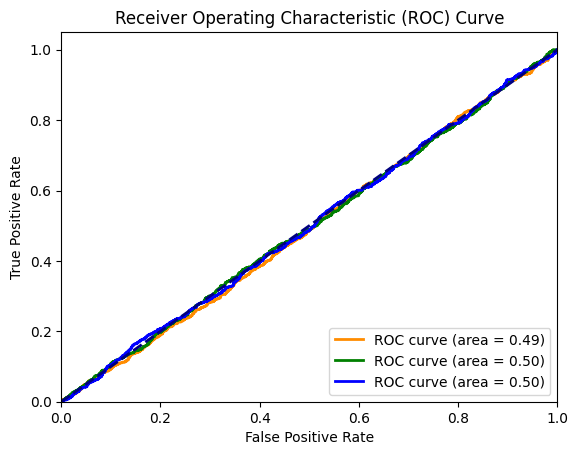

In [38]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve((y_test == i), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
lw = 2
colors = ['darkorange', 'green', 'blue']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [39]:
for i in range(3):
    print(f"AUC for class {i}: {roc_auc[i]}")

AUC for class 0: 0.49320768000000004
AUC for class 1: 0.49742959999999997
AUC for class 2: 0.49865472


In [40]:
torch.save(model.state_dict(), 'model_weights.pth')